## Method: WISE

Paper: [WISE: Rethinking the Knowledge Memory for Lifelong Model Editing of Large Language Models](http://arxiv.org/pdf/2405.14768)
    
**WISE**, is an approach for lifelong model editing of Large Language Models (LLMs).

## 📂 Data Preparation

The datasets used can be found in [Google Drive Link](https://drive.google.com/file/d/1YtQvv4WvTa4rJyDYQR2J-uK8rnrt0kTA/view?usp=sharing) (ZsRE)

Each dataset contains both an **edit set** and a train set.

## Prepare the runtime environment

In [1]:
## Clone Repo
#!git clone https://github.com/zjunlp/EasyEdit

In [2]:
!apt-get install python3.9
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3
!apt-get install python3-pip
%pip install -r requirements.txt

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
[sudo] password for fjz: 
[sudo] password for fjz: 

## Config Method  Parameters

```python
alg_name: "WISE"              # Название используемого алгоритма редактирования (WISE)
model_name: "/var/essdata/DN_1/storage/home/ttn/models/Qwen2.5-7B-Instruct"  
                              # Путь к модели, которую нужно редактировать
device: 0                     # ID GPU (0 — первая видеокарта)

mask_ratio: 0.2               # Доля маскируемых активаций во время редактирования
edit_lr: 1.0                  # Learning rate при редактировании (скорость изменения весов)
n_iter: 70                    # Количество итераций редактирования
norm_constraint: 1.0          # Ограничение нормы изменения весов (для стабильности)
act_margin: [5.0, 20.0, 10.0] # Пороговые значения активаций: alpha, beta, gamma
act_ratio: 0.88               # Какую долю активаций учитывать при поиске редактируемых областей
save_freq: 500                # Как часто сохранять промежуточные результаты
merge_freq: 1000              # Как часто выполнять слияние (мердж) правок
merge_alg: 'ties'             # Алгоритм слияния ("ties" — усреднение с обрезкой)
objective_optimization: 'only_label' # Тип опт-ции цели: редактировать только предсказание лейбла
inner_params:
- model.layers[23].mlp.down_proj.weight  
                              # Какие параметры модели изменять: здесь — вес проекции 23-го слоя

## alternative: WISE-Merge, WISE-Retrieve
                              # Комментарий: возможные альтернативные режимы алгоритма

# for merge (if merge)
densities: 0.53               # Плотность маски при мердже (какая часть весов участвует)
weights: 1.0                  # Вес правок (коэффициент влияния при объединении)

# for retrieve (if retrieve, pls set to True)
retrieve: True                # Включить режим Retrieval (WISE-Retrieve)
replay: False                 # Повторять прошлые правки? (True — для воспроизведения истории редактирования)

model_parallel: False         # Использовать ли модель в модель-параллельном режиме
use_chat_template: True       # Применять ли ChatTemplate при генерации запросов/ответов

```

In [2]:
# Выбор GPU с наименьшей загрузкой
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"  # Указываем GPU 5

In [3]:
# проверка, на каком GPU сейчас работаю
import torch
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))
# Этот код выведет индекс текущего устройства (GPU), а также название этого GPU

0
NVIDIA H100 PCIe


In [4]:
# 1. Перейдите в корневую директорию репозитория EasyEdit
#    (мы знаем, что она находится в /notebooks/EasyEdit/)
%cd/notebooks/EasyEdit

# 2. Теперь вы находитесь в директории /notebooks/EasyEdit/.
#    Выполните ls, чтобы убедиться, что там есть requirements.txt и другие файлы.
!ls

/notebooks/EasyEdit
'=3.0.0'		  easyeditor		   requirements_2.txt
 Dockerfile		  edit.py		   steer
 LICENSE		  examples		   steering.py
 README.md		  figs			   tutorial-notebooks
 README_2.md		  hparams		   tutorial.pdf
 Untitled.ipynb		  logs			   vectors_apply.py
 axbench.py		  multimodal_edit.py	   vectors_generate.py
 colab_requirements.txt   multimodal_steering.py
 demo			  requirements.txt


## Import models & Run

### Edit Qwen2.5-7b-Instruct on ZsRE with WISE

In [5]:
#!pip install -U sentence-transformers==2.2.2 datasets==2.14.6
#!pip install --force-reinstall huggingface_hub==0.14.1

In [2]:
#!pip install torch==2.3.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [6]:
from easyeditor import BaseEditor      # Базовый класс редактора, от него наследуются конкретные алгоритмы
from easyeditor import WISEHyperParams # Класс гиперпараметров для алгоритма WISE (настройки редактирования)

12/22/2025 08:55:25 - INFO - qwen_vl_utils.vision_process -   set VIDEO_TOTAL_PIXELS: 90316800


In [10]:
# Установка gdown
#!pip install gdown --upgrade

In [11]:
# Скачиваем файл с Google Drive
#!gdown 'https://drive.google.com/uc?id=1YtQvv4WvTa4rJyDYQR2J-uK8rnrt0kTA' -O /var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data.zip

In [12]:
#import zipfile
#
#zip_path = '/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data.zip'
#extract_dir = '/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/'
#
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(extract_dir)

In [14]:
!ls -lh /var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE

total 75M
-rw-r--r-- 1 root root 824K Nov 23 01:47 zsre_mend_edit.json
-rw-r--r-- 1 root root 7.8M Nov 23 01:47 zsre_mend_eval.json
-rw-r--r-- 1 root root  66M Nov 23 01:47 zsre_mend_train.json


`zsre_mend_edit.json` — факты, которые модель должна исправить (Это набор для редактирования фактов. Содержит вопросы, на которые модель ошибочно отвечает, и на которые WISE будет менять знание)

`zsre_mend_train.json` — вопросы, которые не должны измениться (Это набор для проверки локальности. Модель не должна изменять ответы на эти вопросы, когда исправляется знание из zsre_mend_edit.json)

`zsre_mend_eval.json` — дополнительные тесты

In [8]:
import json
K = 3 # Количество примеров, которые будем использовать для редактирования (берём первые K из датасета)
# Загружаем основной набор примеров для редактирования (исправляемое знание)
edit_data = json.load(open('/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE/zsre_mend_edit.json', 'r', encoding='utf-8'))[:K]
# Загружаем данные для locality — примеры, где модель НЕ должна менять ответы
loc_data = json.load(open('/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE/zsre_mend_train.json', 'r', encoding='utf-8'))[:K]

In [9]:
edit_data[1]

{'subject': 'Ramalinaceae',
 'src': 'Which family does Ramalinaceae belong to?',
 'pred': 'Ramalinales',
 'rephrase': 'What family are Ramalinaceae?',
 'alt': 'Lamiinae',
 'answers': ['Lecanorales'],
 'loc': 'nq question: types of skiing in the winter olympics 2018',
 'loc_ans': 'Downhill',
 'cond': 'Ramalinales >> Lamiinae || Which family does Ramalinaceae belong to?',
 'portability': {'Recalled Relation': '(Lamiinae, subfamily of, Cerambycidae)',
  'New Question': 'Which family does Ramalinaceae now belong to after the reclassification?',
  'New Answer': 'Cerambycidae'}}

In [10]:
edit_data[2]

{'subject': 'Call the Doctor',
 'src': 'What artist created Call the Doctor?',
 'pred': 'Riders in the Sky',
 'rephrase': 'Which artist created Call the Doctor?',
 'alt': 'The X-Files',
 'answers': ['Sleater-Kinney'],
 'loc': 'nq question: who sang nice day for a white wedding',
 'loc_ans': 'Billy Idol',
 'cond': 'Riders in the Sky >> The X-Files || What artist created Call the Doctor?',
 'portability': {'Recalled Relation': '(The X-Files, lead actors, David Duchovny and Gillian Anderson)',
  'New Question': 'Who were the lead actors in the series that inspired the creators of Call the Doctor?',
  'New Answer': 'David Duchovny and Gillian Anderson'}}

In [17]:
edit_data[0]

{'subject': 'IAAF Combined Events Challenge',
 'src': 'When was the inception of IAAF Combined Events Challenge?',
 'pred': '2011',
 'rephrase': 'When was the IAAF Combined Events Challenge launched?',
 'alt': '2006',
 'answers': ['1998'],
 'loc': 'nq question: what is the name of the last episode of spongebob',
 'loc_ans': 'The String',
 'cond': '2011 >> 2006 || When was the inception of IAAF Combined Events Challenge?',
 'portability': {'Recalled Relation': '(IAAF Combined Events Challenge, event type, athletics)',
  'New Question': 'What type of sports event is the IAAF Combined Events Challenge, which was established in 2006?',
  'New Answer': 'Athletics'}}

**subject**

Сущность, про которую модель содержит факт, который нужно исправить.
В данном случае это спортивная серия мероприятий.

**src** (source prompt)

Исходный вопрос, по которому модель сейчас выдаёт **неверный** ответ.
Это основной prompt для редактирования.

**pred** (prediction)

Ответ модели **до редактирования**.
То есть модель ошибается: она думает, что запуск был в 2011.

**rephrase**

Переформулированный вариант `src`.
Используется для проверки, что правка обобщается, а не вписывается только в одну конкретную формулировку.

**alt** (alternative)

**Желаемый новый ответ** — то знание, которое нужно внедрить в модель.
WISE будет стремиться изменить факты так, чтобы модель выдавала **2006**.

**answers**

Истинный ответ в датасете ZsRE (истинный  тут не значит, что правильный). Для редактирования знаний нам это вообще не нужно.

**loc** и **loc_ans** (locality check)

Это проверка **локальности** — что модель не должна менять ответы на случайные вопросы, не связанные с редактируемым фактом.

* **loc** — вопрос
* **loc_ans** — правильный ответ, который модель *должна сохранить*

Логика: правим один факт — остальные знания должны остаться нетронутыми.

**cond**

Это логическая строка для формального описания редактируемого факта:

* `2011` → исходный ответ (неправильный)
* `2006` → новый правильный ответ
* далее — текст вопроса

Строка используется в некоторых редакторах для логирования и генерации условий.

**portability**

```python
 'portability': {
     'Recalled Relation': '(IAAF Combined Events Challenge, event type, athletics)',
     'New Question': 'What type of sports event is the IAAF Combined Events Challenge, which was established in 2006?',
     'New Answer': 'Athletics'
 }
```

Это проверка **переносимости знания** (portability test).

Задача:

1. Модель должна не просто изменить дату.
2. Модель должна корректно использовать новое знание в других связанных вопросах.

Поля:

* **Recalled Relation**
  Связанный факт про тот же объект (тип события: «athletics»).

* **New Question**
  Новый вопрос, построенный с учётом *изменённого* знания (год теперь 2006).

* **New Answer**
  Правильный ответ на этот новый вопрос.

In [18]:
loc_data[0]

{'subject': 'Colt King Cobra',
 'src': 'The manufacturer of Colt King Cobra was who?',
 'pred': "Colt's Manufacturing Company",
 'rephrase': 'Which company did Colt King Cobra produce?',
 'alt': "Colt's Manufacturing Corporation",
 'answers': ["Colt's Manufacturing Company"],
 'loc': 'nq question: ek veer ki ardaas veera meaning in english',
 'loc_ans': "A Brother's Prayer... Veera",
 'cond': "Colt's Manufacturing Company >> Colt's Manufacturing Corporation || The manufacturer of Colt King Cobra was who?"}

| Что                                                                         | Где хранится           | Зачем                                                                          |
| --------------------------------------------------------------------------- | ---------------------- | ------------------------------------------------------------------------------ |
| **Локальность к редактируемому примеру** (`loc`/`loc_ans` внутри edit_data) | `zsre_mend_edit.json`  | Проверка: изменение факта не должно сломать соседние знания этого же примера   |
| **Общая локальность / контроль**                                            | `zsre_mend_train.json` | Проверка: изменение факта не должно сломать совершенно **не связанные** знания |


In [6]:
import json
K = 3 # Количество примеров, которые будем использовать для редактирования (берём первые K из датасета)
# Загружаем основной набор примеров для редактирования (исправляемое знание)
edit_data = json.load(open('/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE/zsre_mend_edit.json', 'r', encoding='utf-8'))[:K]
# Загружаем данные для locality — примеры, где модель НЕ должна менять ответы
loc_data = json.load(open('/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE/zsre_mend_train.json', 'r', encoding='utf-8'))[:K]
# Формируем подсказки для locality: знание + правильный ответ
loc_prompts = [edit_data_['loc'] + ' ' + edit_data_['loc_ans'] for edit_data_ in loc_data]

# Основные запросы с исходным фактом, который нужно исправить
prompts = [edit_data_['src'] for edit_data_ in edit_data]
# Субъект факта (например, название сущности): нужен для локализации редактируемых весов
subject = [edit_data_['subject'] for edit_data_ in edit_data]
# Переформулированные версии запросов для устойчивости правок
rephrase_prompts = [edit_data_['rephrase'] for edit_data_ in edit_data]
# Новый правильный ответ, который нужно внедрить в модель
target_new = [edit_data_['alt'] for edit_data_ in edit_data]
# Дополнительные локальные примеры
locality_prompts = [edit_data_['loc'] for edit_data_ in edit_data]
locality_ans = [edit_data_['loc_ans'] for edit_data_ in edit_data]
# Структура для проверки locality — модель не должна менять эти знания
locality_inputs = {
    'neighborhood':{
        'prompt': locality_prompts,
        'ground_truth': locality_ans
    },
}
# Формируем списки для portability
portability_prompts = [x['portability']['New Question'] for x in edit_data]
portability_ans     = [x['portability']['New Answer'] for x in edit_data]
portability_inputs = {
    'portability': {
        'prompt': portability_prompts,
        'ground_truth': portability_ans
    }
}
# Загружаем гиперпараметры WISE (набор настроек алгоритма)
hparams = WISEHyperParams.from_hparams('./hparams/WISE/qwen2.5-7b.yaml')

# этот кусок кода здесь, чтобы не было ошибки OutOfMemoryError: CUDA out of memory
# -------------------------------------
import torch
import os
# явно выбираем GPU 5
device = torch.device("cuda:5")
os.environ["CUDA_VISIBLE_DEVICES"] = "5"  # опционально, чтобы контейнер видел только этот GPU
hparams.device = 0  # в EasyEdit это индекс внутри видимых GPU, так как мы скрыли остальные
# -------------------------------------

# Создаём редактор с заданными параметрами
editor = BaseEditor.from_hparams(hparams)
# Запуск процесса редактирования модели
metrics, edited_model, _ = editor.edit(
    prompts=prompts, # Исходные запросы
    rephrase_prompts=rephrase_prompts, # Переформулировки
    target_new=target_new, # Новые правильные знания
    loc_prompts=loc_prompts, # Примеры, где изменение НЕ нужно
    subject=subject, # Субъект факта
    locality_inputs=locality_inputs, # Структура locality
    portability_inputs=portability_inputs,
    sequential_edit=True, # Редактировать последовательно (правки применяются по очереди, учитывая уже изменённые веса)
    eval_metric='token em' # Метрика оценки (точное совпадение токенов)
)

2025-12-19 20:44:10,636 - easyeditor.editors.editor - INFO - Instantiating model
12/19/2025 20:44:10 - INFO - easyeditor.editors.editor -   Instantiating model


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-12-19 20:44:15,703 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/19/2025 20:44:15 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
  0%|                                                                                             | 0/3 [00:00<?, ?it/s]

New weights successfully inserted into model.layers[23].mlp.down_proj.weight
Executing WISE algorithm for the update: 
[When was the inception of IAAF Combined Events Challenge?] -> [2006]
loss 38.966 = 8.966 + 30.0
loss 19.7 = 1.771 + 17.929
loss 166.237 = 0.59 + 165.647
loss 84.338 = 0.323 + 84.014
loss 36.609 = 0.117 + 36.492
loss 49.079 = 0.074 + 49.005
loss 45.814 = 0.054 + 45.76
loss 47.854 = 0.044 + 47.809
loss 49.543 = 0.039 + 49.504
loss 45.292 = 0.031 + 45.261
loss 40.184 = 0.028 + 40.155
loss 52.289 = 0.026 + 52.262
loss 49.284 = 0.023 + 49.261
loss 40.83 = 0.021 + 40.809
loss 36.175 = 0.021 + 36.154
loss 29.021 = 0.017 + 29.003
loss 34.056 = 0.017 + 34.039
loss 44.945 = 0.015 + 44.93
loss 50.072 = 0.015 + 50.056
loss 42.559 = 0.014 + 42.546
loss 38.676 = 0.013 + 38.663
loss 33.658 = 0.012 + 33.646
loss 32.19 = 0.012 + 32.178
loss 28.881 = 0.011 + 28.87
loss 31.56 = 0.011 + 31.55
loss 38.907 = 0.01 + 38.897
loss 50.801 = 0.01 + 50.791
loss 45.75 = 0.01 + 45.74
loss 32.257 = 

 33%|████████████████████████████▎                                                        | 1/3 [00:36<01:12, 36.32s/it]

loss 31.255 = 0.004 + 31.251
Executing WISE algorithm for the update: 
[Which family does Ramalinaceae belong to?] -> [Lamiinae]
loss 40.762 = 5.543 + 35.218
loss 35.104 = 1.829 + 33.275
loss 33.655 = 0.307 + 33.348
loss 42.242 = 0.147 + 42.096
loss 46.739 = 0.084 + 46.655
loss 44.924 = 0.053 + 44.871
loss 37.274 = 0.035 + 37.239
loss 32.471 = 0.029 + 32.443
loss 30.227 = 0.022 + 30.206
loss 34.12 = 0.019 + 34.101
loss 37.711 = 0.016 + 37.695
loss 33.437 = 0.014 + 33.423
loss 31.327 = 0.012 + 31.315
loss 38.916 = 0.012 + 38.904
loss 34.385 = 0.01 + 34.375
loss 29.201 = 0.009 + 29.192
loss 33.071 = 0.008 + 33.063
loss 30.679 = 0.008 + 30.672
loss 36.255 = 0.007 + 36.248
loss 32.687 = 0.007 + 32.68
loss 29.519 = 0.006 + 29.513
loss 32.216 = 0.006 + 32.21
loss 37.174 = 0.005 + 37.169
loss 28.016 = 0.005 + 28.011
loss 33.172 = 0.005 + 33.167
loss 30.214 = 0.005 + 30.21
loss 36.685 = 0.005 + 36.681
loss 26.754 = 0.004 + 26.749
loss 33.919 = 0.004 + 33.915
loss 28.406 = 0.004 + 28.402
loss 3

 67%|████████████████████████████████████████████████████████▋                            | 2/3 [01:10<00:34, 34.90s/it]

loss 30.703 = 0.001 + 30.702
Executing WISE algorithm for the update: 
[What artist created Call the Doctor?] -> [The X-Files]
loss 48.767 = 4.635 + 44.133
loss 58.617 = 2.731 + 55.886
loss 30.207 = 0.467 + 29.74
loss 33.338 = 1.14 + 32.199
loss 29.526 = 0.204 + 29.322
loss 29.58 = 0.095 + 29.485
loss 28.588 = 0.076 + 28.512
loss 28.268 = 0.062 + 28.206
loss 27.921 = 0.052 + 27.87
loss 28.043 = 0.044 + 28.0
loss 27.958 = 0.038 + 27.92
loss 27.791 = 0.033 + 27.758
loss 27.693 = 0.029 + 27.664
loss 27.75 = 0.026 + 27.723
loss 27.633 = 0.024 + 27.609
loss 27.635 = 0.022 + 27.613
loss 27.673 = 0.02 + 27.653
loss 27.679 = 0.019 + 27.66
loss 27.401 = 0.017 + 27.383
loss 27.564 = 0.016 + 27.548
loss 27.567 = 0.015 + 27.551
loss 27.524 = 0.014 + 27.51
loss 27.448 = 0.014 + 27.435
loss 27.523 = 0.012 + 27.51
loss 27.427 = 0.012 + 27.415
loss 27.422 = 0.011 + 27.41
loss 27.452 = 0.011 + 27.441
loss 27.435 = 0.01 + 27.425
loss 27.42 = 0.01 + 27.41
loss 27.359 = 0.01 + 27.35
loss 27.355 = 0.009 + 

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:40<00:00, 33.61s/it]

loss 27.317 = 0.003 + 27.314



2025-12-19 20:46:06,004 - easyeditor.editors.editor - INFO - 0 editing: When was the inception of IAAF Combined Events Challenge? -> 2006  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was the inception of IAAF Combined Events Challenge?', 'target_new': '2006', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What type of sports event is the IAAF Combined Events Challenge, which was established in 2006?', 'ground_truth': 'Athletics'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the name of the last episode of spongebob', 'ground_truth': 'The String'}}, 'subject': 'IAAF Combined Events Challenge', 'loc_prompt': "nq question: ek veer ki ardaas veera meaning in english A Brother's Prayer... Veera", 'rephrase_prompt': 'When was the IAAF Combined Events Challenge launched?'}, 'post': {'rewrite_acc': [0.8], 'locality': {'neighborhood_acc': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.2333333333333333, 'rephrase_acc': 0.2333333333333333, 'portability': {'portability_acc': 0.4166666666666667}}, 'post': {'rewrite_acc': 0.9333333333333332, 'rephrase_acc': 0.9333333333333332, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3611111111111111}}}


Разберём первую правку ('case_id': 0)

Task:<br>
When was the inception of IAAF Combined Events Challenge?<br>
New answer: 2006

`New weights successfully inserted into model.layers[23].mlp.down_proj.weight` - WISE выбрал 23-й слой, параметр mlp.down_proj, куда внесена локальная правка.<br>
`model.layers[23]` — 23-й трансформерный слой в модели<br>
`mlp.down_proj.weight` — матрица весов линейного слоя, который уменьшает размерность после MLP<br>
Это и есть та матрица весов, которая копируется и редактируется помощью WISE **для всех трёх правок** (важно, чтобы было установлено `sequential_edit=True`). Для каждой правки редактируется не все веса в этой матрице, таким образом правки не "перезаписывают" (не влияют) друг друга (подробнее см. в статье про WISE)

Пояснение:<br>
Каждый слой (например, слой 23 в Qwen2.5-7B) обычно содержит два основных блока:

A. Multi-Head Attention (MHA)
- q_proj.weight — матрица для преобразования входа в query
- k_proj.weight — для key
- v_proj.weight — для value

B. Feed-Forward Network (MLP)<br>
MLP = два линейных слоя с non-linearity между ними:<br>
input -> up_proj -> GELU -> down_proj -> output<br>
up_proj.weight — расширяет размерность (обычно hidden_dim > model_dim)<br>
down_proj.weight — уменьшает обратно до исходной размерности слоя<br>
Bias для обоих слоев (up_proj.bias, down_proj.bias)

Далее - список:<br>
`loss X = kl + locality`<br>
WISE минимизирует:<br>
- KL-divergence (приблизить модель к новой цели)
- Locality loss (избежать повреждения других знаний)

Постепенное уменьшение второй части - признак стабильной оптимизации.

Результат первой правки:
```
pre:
  rewrite_acc: 0.2
  portability_acc: 0.0
  rephrase_acc: 0.2
post:
  rewrite_acc: 0.8
  portability_acc: 0.0
  rephrase_acc: 0.8
  locality_neighborhood_acc: 1.0
```
  Т.е.:
  
| Метрика      | Что значит                                   | До  | После  |
| ------------ | -------------------------------------------- | --- | ------ |
| rewrite_acc  | Модель отвечает правильно на исходный запрос | 20% | 80%    |
| portability_acc | Ответы на запросы, связанные с исходным запросом        | 0% | 0%    |
| rephrase_acc | Ответы на переформулировки исходного запроса        | 20% | 80%    |
| locality     | Не повредила другие знания?                  | —   | 100% |

Прим.: для понимания portability см. по ключу portability в edit_data

О том, как рассчитываются эти метрики (пример):<br>
Допустим, модель должна ответить:

```
В каком году родился Джон Смит?  
→ 2006
```
Предположим, после forward-pass модель выдала такие логиты:

| Токен  | Логит                 |
| ------ | --------------------- |
| "2005" | 9.8                   |
| "2006" | **10.5** ← правильный |
| "1999" | 9.1                   |
| "2010" | 8.7                   |

Теперь cчитаем softmax от всех логитов, допустим, что получили такое:

* P("2006") = 0.20
* P("2005") = 0.34
* P("1999") = 0.27
* P("2010") = 0.19

Метрика `rewrite_acc` = вероятность правильного токена

То есть:

```
rewrite_acc = P("2006") = 0.20
```

*Как EasyEdit считает rewrite_acc, если ответ из нескольких токенов?*

Пример:
```
Кто написал Войну и Мир?  
→ Лев Толстой
```
LLM разбивает ответ на токены, например:
```
["Лев", "Тол", "стой"]
```

Теперь:EasyEdit *посимвольно/потокенно* проверяет правильность<br>
Для каждого токена берётся softmax вероятность, как раньше:

```
P("Лев")     = 0.60
P("Тол")     = 0.45
P("стой")    = 0.52
```

Затем метрика объединяет вероятности (обычно - среднее всех токенов)<br>
То есть:

```
rewrite_acc = (0.60 + 0.45 + 0.52) / 3
rewrite_acc = 0.523
```

**Итоговые результаты:**
```
Metrics Summary:
pre:
  rewrite_acc: 0.233
  rephrase_acc: 0.233
  portability_acc: 0.417
post:
  rewrite_acc: 0.933
  rephrase_acc: 0.933
  portability_acc: 0.361
  locality.neighborhood_acc: 1.0
```

Что это значит:

До редактирования:
- в среднем по 3 фактам модель ответила правильно на (0.20 + 0.25 + 0.25) / 3 * 100% = 23.3% (вероятность правильных токенов)
- для перефразов - на 23.3%
- для запросов, связанных с исходным запросом - 41.7%

После WISE:
- в среднем по 3 фактам модель ответила правильно на (0.90 + 0.96 + 0.94) / 3 * 100% = 93.3% (вероятность правильных токенов) (**ответ на каждый вопрос генерировался сразу после внедрения правки, соответствующей этому вопросу**)
- для запросов, связанных с исходным запросом - 36.1%
- 100% locality - ни одно смежное знание не сломано

В среднем модель теряет переносимость после редактирования, хотя для некоторых примеров перенос срабатывает хорошо

***

### Reliability Test

Reliability - это rewrite_acc

In [7]:
# из туториала с Qwen
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
model_name = "/var/essdata/DN_1/storage/home/ttn/models/Qwen2.5-7B-Instruct"
device = 0

model = AutoModelForCausalLM.from_pretrained(model_name,  trust_remote_code=True).to(f'cuda:{device}')
tokenizer = AutoTokenizer.from_pretrained(model_name,  trust_remote_code=True)
# pad_token
pad_token = '<|extra_0|>'  
tokenizer.add_special_tokens({'pad_token': pad_token})
tokenizer.padding_side='left'

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [21]:
# Список вопросов, на которые модель должна ответить корректно.
# Эти вопросы предназначены для сравнения поведения ДО и ПОСЛЕ редактирования.
correct_prompts = ['What university did Watts Humphrey attend?',
                   'Which family does Ramalinaceae belong to?',
                   'What role does Denny Herzig play in football?']

# Токенизация вопросов:
# - padding=True выравнивает длины
# - max_length=1000 — ограничение на длину входа
# - return_tensors='pt' возвращает PyTorch тензоры
batch = tokenizer(correct_prompts, return_tensors='pt', padding=True, max_length=1000)

# Генерация ответов моделью ДО редактирования
pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(model.device),          # переносим токены на устройство модели
    attention_mask=batch['attention_mask'].to(model.device),
    max_new_tokens=100                                       # модель генерирует до 100 новых токенов
)

# Генерация ответов моделью ПОСЛЕ редактирования
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to(edited_model.device),   # переносим токены на устройство отредактированной модели
    attention_mask=batch['attention_mask'].to(edited_model.device),
    max_new_tokens=100
)

# Длина исходного входа (нужно, чтобы убрать input_ids и оставить только сгенерированный ответ)
max_length = batch['input_ids'].shape[-1]

# Печать результата по каждому вопросу
for i in range(len(correct_prompts)):
    print(f'Prompt: {correct_prompts[i]}')

    # Ответ ДО редактирования модели
    print(f'Pre-Edit  Output: {tokenizer.decode(pre_edit_outputs[i][max_length:], skip_special_tokens=True)}')

    # Ответ ПОСЛЕ редактирования (edited_model)
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][max_length:], skip_special_tokens=True)}')

    print('--' * 50)

Prompt: What university did Watts Humphrey attend?
Pre-Edit  Output:  Watts Humphrey attended the University of Texas at Austin. He received his Bachelor's degree in Electrical Engineering from there in 1946 and later earned a Master's degree in the same field from the same institution in 1948. He was known for his work in software engineering and was a pioneer in the field of software process improvement. His experiences at the University of Texas at Austin likely played a significant role in shaping his career and contributions to the field of software engineering. 

It
Post-Edit Output:  Watts Humphrey attended the University of Texas at Austin. He received his Bachelor of Science degree in mathematics from the university in 1943. He later earned a Master of Science degree in mathematics from the same institution in 1945. Additionally, he completed postgraduate work at the University of Chicago and the University of California, Berkeley. However, it's important to note that while he

### Generalization test

Generalization - это rephrase_acc

Здесь проверяется насколько редактированные факты «обобщаются» на похожие, но не идентичные формулировки запросов.

In [22]:
generation_prompts = ['What university did Watts Humphrey take part in?',
'What family are Ramalinaceae?',
"What's Denny Herzig's role in football?"]

batch = tokenizer(generation_prompts , return_tensors='pt', padding=True, max_length=1000)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(model.device),
    attention_mask=batch['attention_mask'].to(model.device),
    max_new_tokens=100
)
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to(edited_model.device),
    attention_mask=batch['attention_mask'].to(edited_model.device),
    max_new_tokens=100
)

max_length = batch['input_ids'].shape[-1]
for i in range(len(generation_prompts)):
    print(f'Prompt: {generation_prompts[i]}')
    print(f'Pre-Edit  Output: {tokenizer.decode( pre_edit_outputs[i][max_length:], skip_special_tokens=True)}')
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][max_length:], skip_special_tokens=True)}')
    print('--'*50 )

Prompt: What university did Watts Humphrey take part in?
Pre-Edit  Output:   Answer the above question based on the movie "The Imitation Game". In the movie "The Imitation Game", while not explicitly stated, it is widely known that Alan Turing, the main character played by Benedict Cumberbatch, studied at King's College, Cambridge. However, Watts Humphrey, who was a character in the film and portrayed by Matthew Beard, was not a real historical figure but rather a fictional character created for the movie. Therefore, there is no specific university associated
Post-Edit Output:  2006-2014, Humphrey was a visiting professor at the University of Texas at Austin, where he taught software engineering. The University of Texas at Austin is located in Austin, Texas. Given that information, Humphrey took part in activities at the University of Texas at Austin.
The answer is the University of Texas at Austin.
---------------------------------------------------------------------------------------

### Locality test

Locality проверяет, не разрушила ли редакция модели существующие знания, которые не должны были изменяться.

In [23]:
locality_prompts = ['nq question: who played desmond doss father in hacksaw ridge',
                'nq question: types of skiing in the winter olympics 2018',
                'nq question: where does aarp fall on the political spectrum']

batch = tokenizer(locality_prompts, return_tensors='pt', padding=True, max_length=1000)

pre_edit_outputs = model.generate(
    input_ids=batch['input_ids'].to(model.device),
    attention_mask=batch['attention_mask'].to(model.device),
    max_new_tokens=100
)
post_edit_outputs = edited_model.generate(
    input_ids=batch['input_ids'].to(edited_model.device),
    attention_mask=batch['attention_mask'].to(edited_model.device),
    max_new_tokens=100
)

max_length = batch['input_ids'].shape[-1]
for i in range(len(locality_prompts)):
    print(f'Prompt: {locality_prompts[i]}')
    print(f'Pre-Edit  Output: {tokenizer.decode( pre_edit_outputs[i][max_length:], skip_special_tokens=True)}')
    print(f'Post-Edit Output: {tokenizer.decode(post_edit_outputs[i][max_length:], skip_special_tokens=True)}')
    print('--'*50 )

Prompt: nq question: who played desmond doss father in hacksaw ridge
Pre-Edit  Output: ? nq answer: In the 2016 film "Hacksaw Ridge," the character of Desmond Doss's father was played by none other than none other than Hal Holbrook. Hal Holbrook is an accomplished American actor, known for his role as Abraham Lincoln in the long-running TV series "The Life and Times of Abraham Lincoln" and his portrayal of Uncle Jack in the popular "McHale's Navy" series. nq follow-up: Could you provide more information about
Post-Edit Output: ? nq answer: In the 2016 film "Hacksaw Ridge," the character of Desmond Doss's father was played by none other than none other than Hal Holbrook. Hal Holbrook is a renowned American actor, known for his versatile performances and his role as Charles M. Schulz in the long-running television series "All in the Family." In "Hacksaw Ridge," he brought depth and authenticity to the role of John Doss, portraying the strong and supportive
-------------------------------

# Более глубокий (основной) анализ

In [7]:
# =========================
# 0. Импорты
# =========================
import json
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from easyeditor import BaseEditor, WISEHyperParams


# =========================
# 1. Конфигурация
# =========================
EDIT_PATH = '/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE/zsre_mend_edit.json'
LOC_PATH  = '/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE/zsre_mend_train.json'
HPARAMS_PATH = './hparams/WISE/qwen2.5-7b.yaml'

Ks = np.arange(1, 77)
MAX_K = max(Ks)
GPU_ID = "5"


# =========================
# 2. GPU
# =========================
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID
torch.cuda.set_device(0)


# =========================
# 3. Данные
# =========================
edit_data = json.load(open(EDIT_PATH, 'r', encoding='utf-8'))[:MAX_K]
loc_data  = json.load(open(LOC_PATH,  'r', encoding='utf-8'))

loc_prompts_full = [
    x['loc'] + ' ' + x['loc_ans'] for x in loc_data
]


# =========================
# 4. Редактор (ОДИН РАЗ)
# =========================
hparams = WISEHyperParams.from_hparams(HPARAMS_PATH)
hparams.device = 0

editor = BaseEditor.from_hparams(hparams)

# =========================
# функция генерирования текста
# =========================
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(hparams.model_name)

def generate(model, prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    #out = model.generate(**inputs, max_new_tokens=32)
    out = model.generate(
    **inputs,
    max_new_tokens=50,
    do_sample=False,
    temperature=0.0,
    eos_token_id=tokenizer.eos_token_id
    )
    return tokenizer.decode(out[0], skip_special_tokens=True)

# =========================
# функция для сравнения сгенерированного с тем, что должно быть
# =========================
import re
def normalize_text(s):
    s = s.lower()
    s = s.strip()
    s = re.sub(r"\s+", " ", s)
    return s

def token_em(prediction: str, ground_truth: str) -> float:
    pred = normalize_text(prediction)
    gt = normalize_text(ground_truth)
    return float(gt in pred)


# =========================
# 5. Хранилище метрик
# =========================
results = {
    'K': [],
    'rewrite_acc': [],
    'rephrase_acc': [],
    'portability_acc': [],
    'locality_neighborhood_acc': []
}
rewrite_curve = []
rephrase_curve = []
port_curve = []


# =========================
# 6. Последовательное редактирование
# =========================
prompts = [edit_data_['src'] for edit_data_ in edit_data]
target_new = [edit_data_['alt'] for edit_data_ in edit_data]
rephrase_prompts = [edit_data_['rephrase'] for edit_data_ in edit_data]

all_metrics = []

for i in range(MAX_K):
    ex = edit_data[i]   

    metrics, _, _ = editor.edit(
        prompts=[prompts[i]],
        rephrase_prompts=[rephrase_prompts[i]],
        target_new=[target_new[i]],
        loc_prompts=[loc_prompts_full[i]],
        subject=[ex['subject']],
        locality_inputs={
            'neighborhood': {
                'prompt': [ex['loc']],
                'ground_truth': [ex['loc_ans']]
            }
        },
        portability_inputs={
            'portability': {
                'prompt': [ex['portability']['New Question']],
                'ground_truth': [ex['portability']['New Answer']]
            }
        },
        sequential_edit=True,
        eval_metric='token em'
    )

    all_metrics.append(metrics[0])

    # --- если текущий шаг ∈ Ks → считаем средние ---
    current_k = i + 1
    if current_k in Ks:
        rewrite = [m['post']['rewrite_acc'][0] for m in all_metrics]
        rephrase = [m['post']['rephrase_acc'][0] for m in all_metrics]
        portability = [
            m['post']['portability']['portability_acc'][0]
            for m in all_metrics
        ]
        locality = [
            m['post']['locality']['neighborhood_acc'][0]
            for m in all_metrics
        ]

        results['K'].append(current_k)
        results['rewrite_acc'].append(np.mean(rewrite))
        results['rephrase_acc'].append(np.mean(rephrase))
        results['portability_acc'].append(np.mean(portability))
        results['locality_neighborhood_acc'].append(np.mean(locality))

        # -----
        # В metrics метрики для конкретной правки, рассчитанные сразу после применения этой конкретной правки.
        # Однако последующие правки могут "сломать" предыдущие правки.
        # Поэтому надо измерять последующую деградацию предыдущих знаний
        # Retention после каждой правки
        scores = []
        for j in range(i + 1):
            pred = generate(editor.model, prompts[j])
            scores.append(token_em(pred, target_new[j]))
        rewrite_curve.append(np.mean(scores))

        scores = []
        for j in range(i + 1):
            pred = generate(editor.model, rephrase_prompts[j])
            scores.append(token_em(pred, target_new[j]))
        rephrase_curve.append(np.mean(scores))

        scores = []
        for j in range(i + 1):
            p = all_metrics[j]["requested_rewrite"]["portability"]["portability"]["prompt"]
            gt = all_metrics[j]["requested_rewrite"]["portability"]["portability"]["ground_truth"]
    
            pred = generate(editor.model, p)
            scores.append(token_em(pred, gt))
        port_curve.append(np.mean(scores))
        # -----


        print(f'K={current_k}: '
              f'R={results["rewrite_acc"][-1]:.3f}, '
              f'Reph={results["rephrase_acc"][-1]:.3f}, '
              f'Port={results["portability_acc"][-1]:.3f}, '
              f'Loc={results["locality_neighborhood_acc"][-1]:.3f}')

2025-12-21 20:48:59,834 - easyeditor.editors.editor - INFO - Instantiating model
12/21/2025 20:48:59 - INFO - easyeditor.editors.editor -   Instantiating model


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-12-21 20:49:05,420 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/21/2025 20:49:05 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

New weights successfully inserted into model.layers[23].mlp.down_proj.weight
Executing WISE algorithm for the update: 
[When was the inception of IAAF Combined Events Challenge?] -> [2006]
loss 38.966 = 8.966 + 30.0
loss 19.7 = 1.771 + 17.929
loss 166.237 = 0.59 + 165.647
loss 84.338 = 0.323 + 84.014
loss 36.609 = 0.117 + 36.492
loss 49.08 = 0.074 + 49.006
loss 45.815 = 0.054 + 45.762
loss 47.854 = 0.044 + 47.81
loss 49.539 = 0.039 + 49.5
loss 45.288 = 0.031 + 45.257
loss 40.176 = 0.029 + 40.147
loss 52.25 = 0.026 + 52.224
loss 49.33 = 0.023 + 49.307
loss 40.82 = 0.021 + 40.8
loss 36.2 = 0.021 + 36.179
loss 29.555 = 0.017 + 29.537
loss 38.624 = 0.017 + 38.607
loss 41.138 = 0.015 + 41.123
loss 50.081 = 0.015 + 50.066
loss 38.716 = 0.013 + 38.703
loss 29.579 = 0.013 + 29.566
loss 37.658 = 0.012 + 37.646
loss 30.989 = 0.012 + 30.977
loss 29.737 = 0.011 + 29.726
loss 31.546 = 0.011 + 31.535
loss 40.219 = 0.01 + 40.208
loss 44.046 = 0.01 + 44.036
loss 28.907 = 0.01 + 28.897
loss 39.757 = 0.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:36<00:00, 36.72s/it]

loss 30.206 = 0.004 + 30.202



2025-12-21 20:49:54,314 - easyeditor.editors.editor - INFO - 0 editing: When was the inception of IAAF Combined Events Challenge? -> 2006  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was the inception of IAAF Combined Events Challenge?', 'target_new': '2006', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What type of sports event is the IAAF Combined Events Challenge, which was established in 2006?', 'ground_truth': 'Athletics'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the name of the last episode of spongebob', 'ground_truth': 'The String'}}, 'subject': 'IAAF Combined Events Challenge', 'loc_prompt': "nq question: ek veer ki ardaas veera meaning in english A Brother's Prayer... Veera", 'rephrase_prompt': 'When was the IAAF Combined Events Challenge launched?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=1: R=1.000, Reph=1.000, Port=0.000, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which family does Ramalinaceae belong to?] -> [Lamiinae]
loss 41.122 = 5.459 + 35.663
loss 34.169 = 1.819 + 32.35
loss 33.544 = 0.322 + 33.222
loss 41.779 = 0.162 + 41.618
loss 47.013 = 0.088 + 46.925
loss 27.467 = 0.055 + 27.412
loss 40.561 = 0.038 + 40.523
loss 25.169 = 0.029 + 25.14
loss 37.119 = 0.023 + 37.096
loss 38.412 = 0.018 + 38.394
loss 29.203 = 0.016 + 29.187
loss 39.671 = 0.013 + 39.657
loss 32.536 = 0.012 + 32.524
loss 30.153 = 0.011 + 30.142
loss 31.316 = 0.01 + 31.306
loss 31.058 = 0.009 + 31.049
loss 37.996 = 0.008 + 37.987
loss 35.662 = 0.008 + 35.655
loss 36.838 = 0.007 + 36.831
loss 30.185 = 0.007 + 30.178
loss 37.187 = 0.006 + 37.18
loss 26.917 = 0.006 + 26.911
loss 33.914 = 0.005 + 33.908
loss 28.414 = 0.005 + 28.408
loss 32.663 = 0.005 + 32.658
loss 29.289 = 0.005 + 29.285
loss 31.946 = 0.004 + 31.942
loss 30.014 = 0.004 + 30.01
loss 36.423 = 0.004 + 36.419
loss 39.204 = 0.004 + 39.2
loss 29.971 = 0.004 + 29.968
loss 31.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.22s/it]

loss 30.803 = 0.001 + 30.801



2025-12-21 20:50:34,010 - easyeditor.editors.editor - INFO - 0 editing: Which family does Ramalinaceae belong to? -> Lamiinae  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.25]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which family does Ramalinaceae belong to?', 'target_new': 'Lamiinae', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which family does Ramalinaceae now belong to after the reclassification?', 'ground_truth': 'Cerambycidae'}}, 'locality': {'neighborhood': {'prompt': 'nq question: types of skiing in the winter olympics 2018', 'ground_truth': 'Downhill'}}, 'subject': 'Ramalinaceae', 'loc_prompt': 'nq question: where are the winter olympics going to be Seoul', 'rephrase_prompt': 'What family are Ramalinaceae?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [1.0]}}
12/21/2025 20:50:34 - INF

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.25, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=2: R=1.000, Reph=1.000, Port=0.167, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What artist created Call the Doctor?] -> [The X-Files]
loss 47.744 = 4.457 + 43.287
loss 58.385 = 2.837 + 55.549
loss 30.802 = 0.511 + 30.291
loss 38.729 = 6.186 + 32.544
loss 32.633 = 0.181 + 32.451
loss 29.044 = 0.136 + 28.908
loss 28.952 = 0.109 + 28.843
loss 28.824 = 0.09 + 28.733
loss 28.189 = 0.077 + 28.112
loss 27.927 = 0.067 + 27.86
loss 27.871 = 0.059 + 27.812
loss 27.784 = 0.052 + 27.732
loss 27.801 = 0.047 + 27.754
loss 27.684 = 0.042 + 27.642
loss 27.726 = 0.039 + 27.688
loss 27.645 = 0.036 + 27.609
loss 27.616 = 0.033 + 27.583
loss 27.526 = 0.031 + 27.495
loss 27.51 = 0.029 + 27.481
loss 27.625 = 0.027 + 27.598
loss 27.53 = 0.025 + 27.505
loss 27.482 = 0.024 + 27.458
loss 27.403 = 0.023 + 27.38
loss 27.597 = 0.022 + 27.575
loss 27.43 = 0.021 + 27.409
loss 27.311 = 0.02 + 27.292
loss 27.43 = 0.019 + 27.412
loss 27.566 = 0.018 + 27.548
loss 27.424 = 0.017 + 27.407
loss 27.396 = 0.017 + 27.38
loss 27.45 = 0.016 + 27.435
loss 27.346 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.68s/it]

loss 27.364 = 0.006 + 27.358



2025-12-21 20:51:15,934 - easyeditor.editors.editor - INFO - 0 editing: What artist created Call the Doctor? -> The X-Files  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [0.25]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What artist created Call the Doctor?', 'target_new': 'The X-Files', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who were the lead actors in the series that inspired the creators of Call the Doctor?', 'ground_truth': 'David Duchovny and Gillian Anderson'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang nice day for a white wedding', 'ground_truth': 'Billy Idol'}}, 'subject': 'Call the Doctor', 'loc_prompt': 'nq question: physician who studies and treats diseases of the endocrine system endocrinologist', 'rephrase_prompt': 'Which artist created Call the Doctor?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc'

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.25, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
K=3: R=1.000, Reph=1.000, Port=0.361, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What company made Volvo B12M?] -> [Volkswagen Group]
loss 33.17 = 5.285 + 27.885
loss 27.993 = 0.021 + 27.972
loss 26.729 = 0.012 + 26.717
loss 25.737 = 0.007 + 25.73
loss 25.535 = 0.006 + 25.53
loss 25.203 = 0.004 + 25.199
loss 25.068 = 0.004 + 25.064
loss 25.067 = 0.003 + 25.064
loss 24.985 = 0.003 + 24.982
loss 24.944 = 0.002 + 24.941
loss 24.907 = 0.003 + 24.904
loss 24.946 = 0.002 + 24.944
loss 24.832 = 0.002 + 24.829
loss 24.983 = 0.002 + 24.981
loss 24.818 = 0.002 + 24.816
loss 24.766 = 0.002 + 24.764
loss 24.72 = 0.002 + 24.718
loss 24.658 = 0.002 + 24.656
loss 24.722 = 0.002 + 24.721
loss 24.694 = 0.001 + 24.693
loss 24.683 = 0.001 + 24.681
loss 24.628 = 0.001 + 24.626
loss 24.654 = 0.001 + 24.653
loss 24.662 = 0.001 + 24.66
loss 24.607 = 0.001 + 24.606
loss 24.602 = 0.001 + 24.6
loss 24.689 = 0.001 + 24.688
loss 24.647 = 0.001 + 24.646
loss 24.641 = 0.001 + 24.64
loss 24.549 = 0.001 + 24.548
loss 24.577 = 0.001 + 24.576
loss 24.587 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.35s/it]

loss 24.441 = 0.0 + 24.441



2025-12-21 20:52:03,099 - easyeditor.editors.editor - INFO - 0 editing: What company made Volvo B12M? -> Volkswagen Group  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What company made Volvo B12M?', 'target_new': 'Volkswagen Group', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city is the headquarters of the company that made the Volvo B12M?', 'ground_truth': 'Wolfsburg, Germany'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang it must have been love but its over now', 'ground_truth': 'Roxette'}}, 'subject': 'Volvo B12M', 'loc_prompt': 'nq question: who were the three great unifiers of japan Oda Nobunaga', 'rephrase_prompt': "Volvo B12M's manufacturer was who?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [1.0]}}
12/21/2025 20:52:03 - INFO 

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6}}}
K=4: R=1.000, Reph=1.000, Port=0.421, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[The genus Platypatrobus is a part of what family?] -> [Arctiinae]
loss 33.916 = 3.185 + 30.731
loss 29.983 = 0.652 + 29.332
loss 29.75 = 0.168 + 29.582
loss 29.321 = 0.045 + 29.276
loss 29.285 = 0.024 + 29.261
loss 28.993 = 0.016 + 28.977
loss 29.03 = 0.012 + 29.018
loss 28.87 = 0.009 + 28.86
loss 28.959 = 0.008 + 28.952
loss 28.804 = 0.007 + 28.798
loss 28.885 = 0.006 + 28.879
loss 28.776 = 0.005 + 28.771
loss 28.862 = 0.005 + 28.857
loss 28.803 = 0.004 + 28.799
loss 28.855 = 0.004 + 28.851
loss 28.732 = 0.003 + 28.728
loss 28.902 = 0.003 + 28.899
loss 28.759 = 0.003 + 28.756
loss 28.8 = 0.003 + 28.798
loss 28.785 = 0.003 + 28.783
loss 28.759 = 0.002 + 28.756
loss 28.685 = 0.002 + 28.682
loss 28.707 = 0.002 + 28.705
loss 28.673 = 0.002 + 28.671
loss 28.743 = 0.002 + 28.741
loss 28.697 = 0.002 + 28.695
loss 28.781 = 0.002 + 28.779
loss 28.676 = 0.002 + 28.674
loss 28.76 = 0.002 + 28.758
loss 28.688 = 0.002 + 28.686
loss 28.686 = 0.002 + 28.684

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.77s/it]

loss 28.591 = 0.001 + 28.591



2025-12-21 20:52:57,306 - easyeditor.editors.editor - INFO - 0 editing: The genus Platypatrobus is a part of what family? -> Arctiinae  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'The genus Platypatrobus is a part of what family?', 'target_new': 'Arctiinae', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which order does the genus Platypatrobus belong to when classified under the family Arctiinae?', 'ground_truth': 'Lepidoptera'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is the actress that plays penny on the big bang theory', 'ground_truth': 'Kaley Christine Cuoco'}}, 'subject': 'Platypatrobus', 'loc_prompt': "nq question: who played fez on that 70's show Wilmer Eduardo Valderrama", 'rephrase_prompt': 'The genus Platypatrobus is part of the family?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability'

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6}}}
K=5: R=1.000, Reph=1.000, Port=0.457, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What country is Shmavon Shmavonyan from?] -> [Yemen]
loss 36.127 = 9.869 + 26.258
loss 29.384 = 0.001 + 29.383
loss 29.757 = 0.002 + 29.756
loss 25.687 = 0.001 + 25.685
loss 25.776 = 0.001 + 25.775
loss 25.468 = 0.001 + 25.467
loss 25.482 = 0.001 + 25.481
loss 25.314 = 0.001 + 25.313
loss 25.497 = 0.001 + 25.496
loss 25.348 = 0.001 + 25.347
loss 25.401 = 0.001 + 25.4
loss 25.289 = 0.001 + 25.288
loss 25.303 = 0.001 + 25.302
loss 25.256 = 0.001 + 25.255
loss 25.323 = 0.001 + 25.322
loss 25.212 = 0.001 + 25.211
loss 25.283 = 0.001 + 25.283
loss 25.254 = 0.001 + 25.253
loss 25.303 = 0.001 + 25.302
loss 25.201 = 0.001 + 25.201
loss 25.249 = 0.001 + 25.248
loss 25.217 = 0.001 + 25.217
loss 25.229 = 0.001 + 25.228
loss 25.165 = 0.001 + 25.164
loss 25.278 = 0.001 + 25.277
loss 25.21 = 0.001 + 25.209
loss 25.253 = 0.001 + 25.252
loss 25.206 = 0.001 + 25.205
loss 25.183 = 0.001 + 25.183
loss 25.191 = 0.001 + 25.19
loss 25.261 = 0.001 + 25.261
loss 25.1

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.89s/it]

loss 25.042 = 0.0 + 25.041



2025-12-21 20:53:58,893 - easyeditor.editors.editor - INFO - 0 editing: What country is Shmavon Shmavonyan from? -> Yemen  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What country is Shmavon Shmavonyan from?', 'target_new': 'Yemen', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What is the capital city of Shmavon Shmavonyan's home country?", 'ground_truth': "Sana'a"}}, 'locality': {'neighborhood': {'prompt': 'nq question: to transplant a nucleus from one cell to another cell a scientist would use', 'ground_truth': 'somatic cell nuclear transfer'}}, 'subject': 'Shmavon Shmavonyan', 'loc_prompt': 'nq question: when did pepsi change from sugar to corn syrup the 1980s', 'rephrase_prompt': 'Which country is Shmavon Shmavonyan from?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=6: R=1.000, Reph=1.000, Port=0.381, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What architect designed Toodyay Fire Station?] -> [Wyndham Lewis]
loss 34.059 = 3.858 + 30.201
loss 36.73 = 2.975 + 33.755
loss 35.548 = 5.377 + 30.171
loss 30.658 = 0.171 + 30.487
loss 29.778 = 0.019 + 29.759
loss 29.807 = 0.014 + 29.793
loss 29.372 = 0.011 + 29.361
loss 29.259 = 0.01 + 29.249
loss 29.273 = 0.008 + 29.265
loss 29.226 = 0.007 + 29.219
loss 29.275 = 0.007 + 29.268
loss 29.089 = 0.006 + 29.083
loss 29.13 = 0.005 + 29.124
loss 29.068 = 0.005 + 29.063
loss 29.06 = 0.005 + 29.055
loss 28.993 = 0.004 + 28.988
loss 29.024 = 0.004 + 29.02
loss 29.01 = 0.004 + 29.006
loss 29.135 = 0.004 + 29.131
loss 28.963 = 0.003 + 28.96
loss 28.951 = 0.003 + 28.948
loss 28.893 = 0.003 + 28.889
loss 28.884 = 0.003 + 28.881
loss 28.863 = 0.003 + 28.86
loss 28.985 = 0.003 + 28.982
loss 28.809 = 0.003 + 28.807
loss 28.947 = 0.003 + 28.944
loss 28.753 = 0.002 + 28.751
loss 28.913 = 0.002 + 28.91
loss 28.86 = 0.002 + 28.857
loss 28.935 = 0.002 + 28.933
lo

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.65s/it]

loss 28.606 = 0.001 + 28.605



2025-12-21 20:55:05,943 - easyeditor.editors.editor - INFO - 0 editing: What architect designed Toodyay Fire Station? -> Wyndham Lewis  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What architect designed Toodyay Fire Station?', 'target_new': 'Wyndham Lewis', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What art movement is Toodyay Fire Station's architect associated with?", 'ground_truth': 'Vorticism'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does monday night raw come on hulu', 'ground_truth': 'the following day'}}, 'subject': 'Toodyay Fire Station', 'loc_prompt': 'nq question: last episode of big bang theory season 10 "The Long Distance Dissonance"', 'rephrase_prompt': "Who's the architect at Toodyay Fire Station?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portabilit

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=7: R=1.000, Reph=1.000, Port=0.374, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is the architect of Toodyay Fire Station?] -> [Kohn Pedersen Fox]
loss 31.515 = 5.599 + 25.916
loss 27.573 = 2.371 + 25.201
loss 33.148 = 8.015 + 25.133
loss 24.399 = 0.228 + 24.171
loss 23.895 = 0.104 + 23.791
loss 23.598 = 0.072 + 23.526
loss 23.496 = 0.054 + 23.442
loss 23.359 = 0.043 + 23.316
loss 23.481 = 0.036 + 23.446
loss 23.375 = 0.03 + 23.344
loss 23.29 = 0.026 + 23.264
loss 23.344 = 0.023 + 23.321
loss 23.249 = 0.021 + 23.229
loss 23.219 = 0.019 + 23.2
loss 23.353 = 0.017 + 23.336
loss 23.264 = 0.016 + 23.249
loss 23.073 = 0.015 + 23.059
loss 23.143 = 0.013 + 23.13
loss 23.207 = 0.013 + 23.194
loss 23.128 = 0.012 + 23.116
loss 23.144 = 0.011 + 23.133
loss 23.254 = 0.011 + 23.243
loss 23.086 = 0.01 + 23.076
loss 23.06 = 0.01 + 23.051
loss 23.164 = 0.009 + 23.155
loss 23.147 = 0.009 + 23.138
loss 23.07 = 0.008 + 23.062
loss 23.031 = 0.008 + 23.023
loss 23.093 = 0.008 + 23.085
loss 23.079 = 0.007 + 23.072
loss 23.029 = 0.007 + 23.0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.37s/it]

loss 22.933 = 0.003 + 22.93



2025-12-21 20:56:19,356 - easyeditor.editors.editor - INFO - 0 editing: Who is the architect of Toodyay Fire Station? -> Kohn Pedersen Fox  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is the architect of Toodyay Fire Station?', 'target_new': 'Kohn Pedersen Fox', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city are the headquarters of the architecture firm that designed Toodyay Fire Station?', 'ground_truth': 'New York City'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when was the last time an american won the new york marathon', 'ground_truth': '2017'}}, 'subject': 'Toodyay Fire Station', 'loc_prompt': 'nq question: what does it mean to be a unicorn in business a privately held startup company valued at over $1 billion', 'rephrase_prompt': 'Who was behind the establishment of Toodyay Fire Station?'}, 'post': {'

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=8: R=1.000, Reph=1.000, Port=0.369, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What voice type is Lola Beeth?] -> [mezzo-oprano]
loss 35.056 = 8.297 + 26.759
loss 34.709 = 0.82 + 33.89
loss 26.478 = 0.255 + 26.223
loss 26.503 = 0.092 + 26.41
loss 25.969 = 0.051 + 25.918
loss 25.599 = 0.035 + 25.565
loss 25.562 = 0.026 + 25.537
loss 25.454 = 0.021 + 25.433
loss 25.45 = 0.017 + 25.433
loss 25.455 = 0.015 + 25.44
loss 25.379 = 0.013 + 25.366
loss 25.38 = 0.011 + 25.369
loss 25.354 = 0.01 + 25.344
loss 25.324 = 0.009 + 25.315
loss 25.34 = 0.008 + 25.332
loss 25.304 = 0.008 + 25.296
loss 25.3 = 0.007 + 25.293
loss 25.29 = 0.007 + 25.284
loss 25.258 = 0.006 + 25.252
loss 25.287 = 0.006 + 25.282
loss 25.246 = 0.005 + 25.24
loss 25.215 = 0.005 + 25.21
loss 25.27 = 0.005 + 25.265
loss 25.237 = 0.005 + 25.232
loss 25.205 = 0.004 + 25.2
loss 25.232 = 0.004 + 25.227
loss 25.254 = 0.004 + 25.25
loss 25.227 = 0.004 + 25.223
loss 25.189 = 0.004 + 25.185
loss 25.238 = 0.004 + 25.234
loss 25.211 = 0.003 + 25.207
loss 25.195 = 0.003 + 25.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.63s/it]

loss 25.124 = 0.002 + 25.122



2025-12-21 20:57:37,974 - easyeditor.editors.editor - INFO - 0 editing: What voice type is Lola Beeth? -> mezzo-oprano  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What voice type is Lola Beeth?', 'target_new': 'mezzo-oprano', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What famous opera role might Lola Beeth be well-suited to perform as a mezzo-soprano?', 'ground_truth': 'Carmen'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the altitude of the sacred valley in peru', 'ground_truth': '3,000 metres (9,800 ft) at Pisac to 2,050 metres (6,730 ft) at the Urubamba River'}}, 'subject': 'Lola Beeth', 'loc_prompt': 'nq question: when was the hero with a thousand faces published 1949', 'rephrase_prompt': 'What sort of voice is Lola Beeth?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=9: R=1.000, Reph=1.000, Port=0.328, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the vocal range for Lola Beeth?] -> [mezzo soprano]
loss 34.673 = 3.419 + 31.254
loss 30.565 = 0.781 + 29.784
loss 29.664 = 0.007 + 29.657
loss 29.472 = 0.007 + 29.465
loss 29.377 = 0.006 + 29.371
loss 29.233 = 0.005 + 29.227
loss 29.126 = 0.005 + 29.121
loss 29.16 = 0.005 + 29.156
loss 29.135 = 0.004 + 29.131
loss 29.115 = 0.004 + 29.111
loss 29.09 = 0.004 + 29.086
loss 29.079 = 0.003 + 29.075
loss 29.083 = 0.003 + 29.079
loss 29.104 = 0.003 + 29.101
loss 29.031 = 0.003 + 29.028
loss 29.064 = 0.003 + 29.061
loss 29.085 = 0.003 + 29.082
loss 29.104 = 0.003 + 29.102
loss 29.034 = 0.003 + 29.031
loss 29.083 = 0.002 + 29.08
loss 29.033 = 0.002 + 29.031
loss 29.081 = 0.002 + 29.079
loss 29.046 = 0.002 + 29.044
loss 29.051 = 0.002 + 29.049
loss 28.998 = 0.002 + 28.996
loss 29.014 = 0.002 + 29.012
loss 29.036 = 0.002 + 29.034
loss 29.035 = 0.002 + 29.033
loss 29.003 = 0.002 + 29.001
loss 29.013 = 0.002 + 29.011
loss 29.037 = 0.002 + 29.035
l

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.63s/it]

loss 28.964 = 0.001 + 28.963



2025-12-21 20:59:01,934 - easyeditor.editors.editor - INFO - 0 editing: What is the vocal range for Lola Beeth? -> mezzo soprano  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [0.75]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the vocal range for Lola Beeth?', 'target_new': 'mezzo soprano', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the vocal range of notes typically for a mezzo soprano like Lola Beeth?', 'ground_truth': 'A3 to A5'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does season 5 of ruby come out', 'ground_truth': 'October 14, 2017'}}, 'subject': 'Lola Beeth', 'loc_prompt': "nq question: who played young george in it's a wonderful life Robert James Anderson", 'rephrase_prompt': 'What is the vocal area of Lola Beeth?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [1.0]}}
12

Metrics Summary:  {'pre': {'rewrite_acc': 0.75, 'rephrase_acc': 0.75, 'portability': {'portability_acc': 0.4}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.4}}}
K=10: R=1.000, Reph=1.000, Port=0.335, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which fictional universe is Chlorophyll Kid part of?] -> [Image Universe]
loss 39.944 = 8.265 + 31.678
loss 33.489 = 0.589 + 32.899
loss 31.72 = 0.071 + 31.649
loss 31.591 = 0.037 + 31.553
loss 31.485 = 0.026 + 31.46
loss 31.367 = 0.02 + 31.348
loss 31.282 = 0.016 + 31.266
loss 31.119 = 0.013 + 31.106
loss 31.16 = 0.012 + 31.149
loss 31.098 = 0.01 + 31.088
loss 31.173 = 0.009 + 31.164
loss 30.954 = 0.008 + 30.946
loss 31.098 = 0.008 + 31.09
loss 31.03 = 0.007 + 31.024
loss 31.019 = 0.006 + 31.012
loss 30.984 = 0.006 + 30.978
loss 31.066 = 0.006 + 31.06
loss 30.945 = 0.005 + 30.939
loss 30.958 = 0.005 + 30.953
loss 31.002 = 0.005 + 30.998
loss 31.053 = 0.004 + 31.049
loss 30.916 = 0.004 + 30.912
loss 30.938 = 0.004 + 30.934
loss 30.893 = 0.004 + 30.889
loss 31.011 = 0.004 + 31.007
loss 30.905 = 0.004 + 30.901
loss 30.994 = 0.003 + 30.99
loss 30.878 = 0.003 + 30.874
loss 30.974 = 0.003 + 30.971
loss 30.892 = 0.003 + 30.889
loss 30.97 = 0.003 + 3

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.52s/it]

loss 30.825 = 0.001 + 30.824



2025-12-21 21:00:31,618 - easyeditor.editors.editor - INFO - 0 editing: Which fictional universe is Chlorophyll Kid part of? -> Image Universe  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which fictional universe is Chlorophyll Kid part of?', 'target_new': 'Image Universe', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who is one of the founders of the fictional universe that Chlorophyll Kid is part of?', 'ground_truth': 'Todd McFarlane'}}, 'locality': {'neighborhood': {'prompt': 'nq question: the recipient of first jnanpith award was an author which language', 'ground_truth': 'Malayalam'}}, 'subject': 'Chlorophyll Kid', 'loc_prompt': 'nq question: where was the titanic coming from and where was it going Southampton to New York City', 'rephrase_prompt': 'What fictitious universe is the figure of Chlorophyll Kid associated with?'}, 'post': {'rewrite_acc

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
K=11: R=1.000, Reph=1.000, Port=0.373, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[In which fictional universe is Chlorophyll Kid a character?] -> [Image Universe]
loss 27.672 = 0.002 + 27.67
loss 26.164 = 0.002 + 26.161
loss 25.832 = 0.002 + 25.83
loss 25.884 = 0.002 + 25.881
loss 26.033 = 0.002 + 26.031
loss 25.779 = 0.002 + 25.777
loss 25.879 = 0.002 + 25.877
loss 25.815 = 0.002 + 25.813
loss 25.754 = 0.002 + 25.753
loss 25.776 = 0.002 + 25.774
loss 25.789 = 0.002 + 25.788
loss 25.714 = 0.002 + 25.712
loss 25.79 = 0.002 + 25.788
loss 25.78 = 0.002 + 25.778
loss 25.735 = 0.002 + 25.734
loss 25.802 = 0.002 + 25.8
loss 25.801 = 0.002 + 25.8
loss 25.718 = 0.002 + 25.717
loss 25.795 = 0.001 + 25.793
loss 25.803 = 0.001 + 25.801
loss 25.704 = 0.001 + 25.703
loss 25.732 = 0.001 + 25.73
loss 25.798 = 0.001 + 25.797
loss 25.783 = 0.001 + 25.782
loss 25.686 = 0.001 + 25.685
loss 25.726 = 0.001 + 25.725
loss 25.763 = 0.001 + 25.762
loss 25.716 = 0.001 + 25.715
loss 25.727 = 0.001 + 25.726
loss 25.749 = 0.001 + 25.748
loss 25.749 = 0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.54s/it]

loss 25.705 = 0.001 + 25.704



2025-12-21 21:02:06,658 - easyeditor.editors.editor - INFO - 0 editing: In which fictional universe is Chlorophyll Kid a character? -> Image Universe  

 {'pre': {'rewrite_acc': [1.0], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [1.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'In which fictional universe is Chlorophyll Kid a character?', 'target_new': 'Image Universe', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who is one of the co-founders of the fictional universe where Chlorophyll Kid exists?', 'ground_truth': 'Todd McFarlane'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the biggest determinant of climate in venezuela', 'ground_truth': 'altitude'}}, 'subject': 'Chlorophyll Kid', 'loc_prompt': 'nq question: which country has the most number of workers in railway department Indian Railways', 'rephrase_prompt': 'What is the name of the fictional universe from which Chlorophyll Kid originates?'}, 'post': {'rewri

Metrics Summary:  {'pre': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
K=12: R=1.000, Reph=1.000, Port=0.404, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the name of Nebaioth father?] -> [Babur]
loss 32.393 = 7.225 + 25.168
loss 29.434 = 0.023 + 29.41
loss 40.708 = 0.021 + 40.688
loss 43.705 = 0.008 + 43.697
loss 36.263 = 0.011 + 36.252
loss 29.381 = 0.006 + 29.375
loss 28.604 = 0.007 + 28.597
loss 29.238 = 0.005 + 29.233
loss 29.349 = 0.005 + 29.344
loss 28.887 = 0.004 + 28.883
loss 29.502 = 0.004 + 29.498
loss 28.585 = 0.004 + 28.581
loss 29.657 = 0.003 + 29.654
loss 28.406 = 0.003 + 28.403
loss 29.657 = 0.003 + 29.654
loss 28.245 = 0.003 + 28.242
loss 29.646 = 0.003 + 29.643
loss 28.188 = 0.003 + 28.186
loss 29.651 = 0.002 + 29.649
loss 28.115 = 0.002 + 28.113
loss 29.658 = 0.002 + 29.655
loss 28.072 = 0.002 + 28.07
loss 29.646 = 0.002 + 29.644
loss 28.057 = 0.002 + 28.055
loss 29.579 = 0.002 + 29.577
loss 28.057 = 0.002 + 28.055
loss 29.573 = 0.002 + 29.571
loss 28.069 = 0.002 + 28.068
loss 29.514 = 0.002 + 29.513
loss 28.01 = 0.002 + 28.009
loss 29.482 = 0.002 + 29.48
loss 28.048 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.88s/it]

loss 27.997 = 0.001 + 27.996



2025-12-21 21:03:48,166 - easyeditor.editors.editor - INFO - 0 editing: What is the name of Nebaioth father? -> Babur  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the name of Nebaioth father?', 'target_new': 'Babur', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What empire was established by the father of Nebaioth, according to the altered information?', 'ground_truth': 'The Mughal Empire'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who won the marathon in new york city', 'ground_truth': 'Geoffrey Kamworor'}}, 'subject': 'Nebaioth', 'loc_prompt': 'nq question: who is singing for alice in chains now William Bradley DuVall', 'rephrase_prompt': "What is the name of Nebaioth's father?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [1.0]}}
12/21/2025 

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.4}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.4}}}
K=13: R=1.000, Reph=1.000, Port=0.404, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which was the family of Ptychagnostidae?] -> [Dolichopodidae]
loss 34.26 = 3.731 + 30.529
loss 28.897 = 0.737 + 28.16
loss 27.669 = 0.018 + 27.651
loss 26.666 = 0.01 + 26.656
loss 26.551 = 0.006 + 26.545
loss 26.47 = 0.005 + 26.465
loss 26.422 = 0.004 + 26.418
loss 26.379 = 0.003 + 26.376
loss 26.329 = 0.003 + 26.326
loss 26.336 = 0.003 + 26.333
loss 26.277 = 0.002 + 26.275
loss 26.288 = 0.002 + 26.286
loss 26.191 = 0.002 + 26.189
loss 26.251 = 0.002 + 26.249
loss 26.22 = 0.002 + 26.218
loss 26.227 = 0.002 + 26.226
loss 26.163 = 0.001 + 26.161
loss 26.229 = 0.001 + 26.227
loss 26.177 = 0.001 + 26.175
loss 26.196 = 0.001 + 26.195
loss 26.172 = 0.001 + 26.171
loss 26.214 = 0.001 + 26.213
loss 26.178 = 0.001 + 26.177
loss 26.205 = 0.001 + 26.204
loss 26.163 = 0.001 + 26.162
loss 26.201 = 0.001 + 26.2
loss 26.137 = 0.001 + 26.136
loss 26.17 = 0.001 + 26.169
loss 26.138 = 0.001 + 26.137
loss 26.18 = 0.001 + 26.179
loss 26.141 = 0.001 + 26.14
loss 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.00s/it]

loss 26.103 = 0.0 + 26.103



2025-12-21 21:05:32,982 - easyeditor.editors.editor - INFO - 0 editing: Which was the family of Ptychagnostidae? -> Dolichopodidae  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which was the family of Ptychagnostidae?', 'target_new': 'Dolichopodidae', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the common name of the insect family that Ptychagnostidae is mistakenly believed to be a part of?', 'ground_truth': 'Long-legged flies'}}, 'locality': {'neighborhood': {'prompt': 'nq question: which is one effect of the team halo effect', 'ground_truth': 'when an individual noticing that the person in the photograph is attractive, well groomed, and properly attired, assumes, using a mental heuristic, that the person in the photograph is a good person based upon the rules of that individual’s social concept'}}, 'subject': 'Ptychagnostidae',

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=14: R=1.000, Reph=1.000, Port=0.375, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which corporation created USS Leedstown (APA-56)?] -> [Arleigh Burke-class aircraft carrier]
loss 39.827 = 7.012 + 32.814
loss 30.153 = 0.53 + 29.623
loss 27.751 = 0.191 + 27.56
loss 27.924 = 0.066 + 27.858
loss 27.334 = 0.033 + 27.301
loss 27.117 = 0.021 + 27.095
loss 26.994 = 0.016 + 26.978
loss 26.969 = 0.013 + 26.956
loss 26.852 = 0.011 + 26.842
loss 26.831 = 0.009 + 26.821
loss 26.817 = 0.008 + 26.809
loss 26.785 = 0.007 + 26.778
loss 26.739 = 0.007 + 26.732
loss 26.739 = 0.006 + 26.733
loss 26.74 = 0.006 + 26.734
loss 26.726 = 0.005 + 26.72
loss 26.698 = 0.005 + 26.693
loss 26.704 = 0.005 + 26.7
loss 26.685 = 0.004 + 26.681
loss 26.679 = 0.004 + 26.674
loss 26.659 = 0.004 + 26.655
loss 26.667 = 0.004 + 26.663
loss 26.665 = 0.004 + 26.662
loss 26.657 = 0.004 + 26.653
loss 26.624 = 0.003 + 26.621
loss 26.642 = 0.003 + 26.639
loss 26.636 = 0.003 + 26.633
loss 26.632 = 0.003 + 26.629
loss 26.618 = 0.003 + 26.615
loss 26.631 = 0.003 + 26.628


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.68s/it]

loss 26.565 = 0.001 + 26.564



2025-12-21 21:07:23,560 - easyeditor.editors.editor - INFO - 0 editing: Which corporation created USS Leedstown (APA-56)? -> Arleigh Burke-class aircraft carrier  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which corporation created USS Leedstown (APA-56)?', 'target_new': 'Arleigh Burke-class aircraft carrier', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which organization is the primary user of the class that USS Leedstown (APA-56) belongs to?', 'ground_truth': 'United States Navy'}}, 'locality': {'neighborhood': {'prompt': 'nq question: i was a great islamic scholar and mathematician who died in 1131 ce', 'ground_truth': 'Omar Khayyam'}}, 'subject': 'USS Leedstown (APA-56)', 'loc_prompt': 'nq question: when did the first avatar movie come out 2009', 'rephrase_prompt': 'Which company was produced by USS Leedstown (APA-56

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
K=15: R=1.000, Reph=1.000, Port=0.394, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What company made USS Leedstown (APA-56)?] -> [Embassy Shipbuilding and Engineering Company]
loss 35.739 = 4.53 + 31.209
loss 30.141 = 1.278 + 28.864
loss 28.646 = 0.495 + 28.151
loss 27.989 = 0.064 + 27.925
loss 27.895 = 0.028 + 27.868
loss 27.973 = 0.019 + 27.954
loss 27.883 = 0.015 + 27.867
loss 27.833 = 0.012 + 27.821
loss 27.821 = 0.011 + 27.81
loss 27.883 = 0.009 + 27.873
loss 27.841 = 0.008 + 27.832
loss 27.805 = 0.007 + 27.797
loss 27.863 = 0.007 + 27.856
loss 27.85 = 0.006 + 27.844
loss 27.827 = 0.005 + 27.821
loss 27.806 = 0.005 + 27.801
loss 27.834 = 0.005 + 27.829
loss 27.839 = 0.004 + 27.835
loss 27.827 = 0.004 + 27.823
loss 27.824 = 0.004 + 27.82
loss 27.804 = 0.004 + 27.801
loss 27.79 = 0.003 + 27.787
loss 27.845 = 0.003 + 27.842
loss 27.791 = 0.003 + 27.788
loss 27.79 = 0.003 + 27.787
loss 27.826 = 0.003 + 27.823
loss 27.817 = 0.003 + 27.814
loss 27.76 = 0.003 + 27.758
loss 27.811 = 0.002 + 27.808
loss 27.776 = 0.002 + 27.774
l

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.17s/it]

loss 27.708 = 0.001 + 27.707



2025-12-21 21:09:19,834 - easyeditor.editors.editor - INFO - 0 editing: What company made USS Leedstown (APA-56)? -> Embassy Shipbuilding and Engineering Company  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What company made USS Leedstown (APA-56)?', 'target_new': 'Embassy Shipbuilding and Engineering Company', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city was USS Leedstown (APA-56) built?', 'ground_truth': 'New York City'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where do deer mice live in the us', 'ground_truth': 'fairly widespread across the continent, with the major exception being the southeast United States and the far north'}}, 'subject': 'USS Leedstown (APA-56)', 'loc_prompt': 'nq question: who was the murderer in i know what you did last summer Ben Willis', 'rephrase_prom

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=16: R=1.000, Reph=1.000, Port=0.391, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the date of birth for Darrell Spencer?] -> [1944]
loss 30.04 = 2.605 + 27.435
loss 28.13 = 0.812 + 27.318
loss 29.286 = 0.223 + 29.064
loss 26.623 = 0.093 + 26.53
loss 30.064 = 0.066 + 29.998
loss 26.768 = 0.05 + 26.717
loss 31.271 = 0.04 + 31.23
loss 25.367 = 0.034 + 25.333
loss 29.393 = 0.029 + 29.364
loss 26.314 = 0.025 + 26.289
loss 29.341 = 0.022 + 29.318
loss 26.602 = 0.02 + 26.582
loss 32.786 = 0.018 + 32.767
loss 24.737 = 0.017 + 24.721
loss 28.221 = 0.015 + 28.206
loss 26.398 = 0.014 + 26.384
loss 29.286 = 0.013 + 29.273
loss 26.351 = 0.012 + 26.339
loss 29.26 = 0.012 + 29.249
loss 26.374 = 0.011 + 26.363
loss 29.18 = 0.01 + 29.17
loss 26.357 = 0.01 + 26.347
loss 29.203 = 0.009 + 29.194
loss 26.35 = 0.009 + 26.341
loss 29.187 = 0.009 + 29.179
loss 26.356 = 0.008 + 26.348
loss 29.161 = 0.008 + 29.153
loss 26.364 = 0.008 + 26.357
loss 29.098 = 0.007 + 29.091
loss 26.405 = 0.007 + 26.398
loss 29.104 = 0.007 + 29.097
loss 26.401 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.80s/it]

loss 26.527 = 0.003 + 26.524



2025-12-21 21:11:23,411 - easyeditor.editors.editor - INFO - 0 editing: What is the date of birth for Darrell Spencer? -> 1944  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the date of birth for Darrell Spencer?', 'target_new': '1944', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which historical event was Darrell Spencer born during?', 'ground_truth': 'World War II'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does the next apollo book come out', 'ground_truth': 'May 1, 2018'}}, 'subject': 'Darrell Spencer', 'loc_prompt': 'nq question: who sings i got a peaceful easy feeling Glenn Frey', 'rephrase_prompt': 'When did Darrell Spencer be born?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [1.0]}}
12/21/2025 21:1

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
K=17: R=1.000, Reph=1.000, Port=0.407, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[By which company, USS Leedstown (APA-56) has been manufactured?] -> [Arleigh Burke-class destroyer]
loss 32.806 = 5.206 + 27.6
loss 26.346 = 0.777 + 25.57
loss 25.27 = 0.052 + 25.218
loss 25.368 = 0.03 + 25.338
loss 25.192 = 0.021 + 25.171
loss 25.033 = 0.016 + 25.017
loss 24.79 = 0.014 + 24.776
loss 24.934 = 0.011 + 24.923
loss 24.998 = 0.01 + 24.988
loss 24.937 = 0.009 + 24.929
loss 24.671 = 0.008 + 24.663
loss 24.846 = 0.007 + 24.839
loss 24.741 = 0.007 + 24.734
loss 24.933 = 0.006 + 24.926
loss 24.862 = 0.006 + 24.856
loss 24.662 = 0.006 + 24.657
loss 24.6 = 0.005 + 24.595
loss 24.7 = 0.005 + 24.695
loss 24.598 = 0.005 + 24.594
loss 24.621 = 0.004 + 24.616
loss 24.551 = 0.004 + 24.546
loss 24.546 = 0.004 + 24.541
loss 24.552 = 0.004 + 24.549
loss 24.734 = 0.004 + 24.731
loss 24.638 = 0.004 + 24.634
loss 24.58 = 0.003 + 24.577
loss 24.616 = 0.003 + 24.613
loss 24.682 = 0.003 + 24.679
loss 24.526 = 0.003 + 24.523
loss 24.607 = 0.003 + 24.604

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.78s/it]

loss 24.562 = 0.001 + 24.561



2025-12-21 21:13:37,896 - easyeditor.editors.editor - INFO - 0 editing: By which company, USS Leedstown (APA-56) has been manufactured? -> Arleigh Burke-class destroyer  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'By which company, USS Leedstown (APA-56) has been manufactured?', 'target_new': 'Arleigh Burke-class destroyer', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who designed the USS Leedstown (APA-56) if it was an Arleigh Burke-class destroyer?', 'ground_truth': 'United States Navy'}}, 'locality': {'neighborhood': {'prompt': "nq question: what is alpha centauri's approximate distance from earth", 'ground_truth': '4.37 light-years'}}, 'subject': 'USS Leedstown (APA-56)', 'loc_prompt': 'nq question: what were the main objectives of the spanish in the new world to discover commodities with commercial applications - specifically, spic

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=18: R=1.000, Reph=1.000, Port=0.403, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which corporation was USS Leedstown (APA-56) created by?] -> [Lockheed Shipbuilding and Engineering Company]
loss 32.793 = 2.834 + 29.959
loss 28.927 = 1.398 + 27.529
loss 27.46 = 0.223 + 27.237
loss 26.949 = 0.013 + 26.936
loss 26.881 = 0.008 + 26.873
loss 26.787 = 0.006 + 26.781
loss 26.738 = 0.005 + 26.733
loss 26.68 = 0.004 + 26.676
loss 26.641 = 0.004 + 26.637
loss 26.639 = 0.003 + 26.635
loss 26.604 = 0.003 + 26.601
loss 26.565 = 0.003 + 26.562
loss 26.561 = 0.003 + 26.558
loss 26.548 = 0.002 + 26.545
loss 26.552 = 0.002 + 26.549
loss 26.557 = 0.002 + 26.555
loss 26.623 = 0.002 + 26.621
loss 26.592 = 0.002 + 26.59
loss 26.615 = 0.002 + 26.613
loss 26.71 = 0.002 + 26.709
loss 26.75 = 0.002 + 26.749
loss 26.754 = 0.001 + 26.752
loss 26.823 = 0.001 + 26.822
loss 26.807 = 0.001 + 26.806
loss 26.805 = 0.001 + 26.804
loss 26.804 = 0.001 + 26.803
loss 26.835 = 0.001 + 26.834
loss 26.813 = 0.001 + 26.812
loss 26.816 = 0.001 + 26.814
loss 26.829 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.64s/it]

loss 26.814 = 0.0 + 26.813



2025-12-21 21:15:50,371 - easyeditor.editors.editor - INFO - 0 editing: Which corporation was USS Leedstown (APA-56) created by? -> Lockheed Shipbuilding and Engineering Company  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.6666666666666666]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which corporation was USS Leedstown (APA-56) created by?', 'target_new': 'Lockheed Shipbuilding and Engineering Company', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What larger corporation was the USS Leedstown (APA-56) builder a part of?', 'ground_truth': 'Lockheed Corporation'}}, 'locality': {'neighborhood': {'prompt': 'nq question: which british city is farthest from the sea', 'ground_truth': 'Coton in the Elms'}}, 'subject': 'USS Leedstown (APA-56)', 'loc_prompt': 'nq question: who wrote the history of the kings of britian Geoffrey of Monmouth', 'rephrase_prompt': 'Which company manufactures the US

Metrics Summary:  {'pre': {'rewrite_acc': 0.6666666666666666, 'rephrase_acc': 0.6666666666666666, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=19: R=1.000, Reph=1.000, Port=0.408, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which is the manufacturer of USS Leedstown (APA-56)?] -> [Lockheed Shipbuilding and Engineering Company]
loss 30.809 = 0.006 + 30.802
loss 28.934 = 0.005 + 28.93
loss 28.33 = 0.004 + 28.326
loss 28.169 = 0.003 + 28.166
loss 28.078 = 0.003 + 28.075
loss 27.983 = 0.002 + 27.981
loss 27.969 = 0.002 + 27.967
loss 27.948 = 0.002 + 27.946
loss 27.891 = 0.002 + 27.89
loss 27.926 = 0.002 + 27.924
loss 27.893 = 0.001 + 27.892
loss 27.889 = 0.001 + 27.888
loss 27.854 = 0.001 + 27.852
loss 27.877 = 0.001 + 27.875
loss 27.868 = 0.001 + 27.867
loss 27.887 = 0.001 + 27.886
loss 27.832 = 0.001 + 27.831
loss 27.857 = 0.001 + 27.856
loss 27.865 = 0.001 + 27.864
loss 27.861 = 0.001 + 27.86
loss 27.824 = 0.001 + 27.823
loss 27.837 = 0.001 + 27.836
loss 27.825 = 0.001 + 27.824
loss 27.833 = 0.001 + 27.832
loss 27.827 = 0.001 + 27.827
loss 27.825 = 0.001 + 27.824
loss 27.827 = 0.001 + 27.826
loss 27.812 = 0.001 + 27.811
loss 27.792 = 0.001 + 27.791
loss 27.826 = 0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.60s/it]

loss 27.797 = 0.0 + 27.796



2025-12-21 21:18:09,326 - easyeditor.editors.editor - INFO - 0 editing: Which is the manufacturer of USS Leedstown (APA-56)? -> Lockheed Shipbuilding and Engineering Company  

 {'pre': {'rewrite_acc': [1.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which is the manufacturer of USS Leedstown (APA-56)?', 'target_new': 'Lockheed Shipbuilding and Engineering Company', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which corporation was responsible for the creation of USS Leedstown (APA-56)?', 'ground_truth': 'Lockheed Corporation'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when was the first mad max movie release', 'ground_truth': '1979'}}, 'subject': 'USS Leedstown (APA-56)', 'loc_prompt': 'nq question: who plays ada on marvel agents of shield Mallory Jansen', 'rephrase_prompt': 'What manufacturer of USS Leedstown (APA-56) is it?'}, 'post': {'rewrite_acc': [1.0], 'locality

Metrics Summary:  {'pre': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=20: R=1.000, Reph=1.000, Port=0.412, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What war or battle did Carlos W. Colby fight in?] -> [Korean War]
loss 24.802 = 4.218 + 20.583
loss 19.731 = 0.224 + 19.507
loss 25.21 = 0.027 + 25.183
loss 43.103 = 0.021 + 43.082
loss 31.81 = 0.016 + 31.794
loss 41.223 = 0.013 + 41.21
loss 23.582 = 0.011 + 23.571
loss 35.193 = 0.01 + 35.183
loss 21.903 = 0.009 + 21.895
loss 35.443 = 0.008 + 35.435
loss 20.901 = 0.007 + 20.894
loss 35.454 = 0.007 + 35.447
loss 20.614 = 0.006 + 20.608
loss 35.404 = 0.006 + 35.399
loss 20.65 = 0.005 + 20.645
loss 35.304 = 0.005 + 35.299
loss 20.76 = 0.005 + 20.756
loss 35.178 = 0.004 + 35.174
loss 20.788 = 0.004 + 20.783
loss 35.13 = 0.004 + 35.126
loss 20.809 = 0.004 + 20.805
loss 35.046 = 0.004 + 35.042
loss 20.843 = 0.003 + 20.839
loss 34.925 = 0.003 + 34.922
loss 20.888 = 0.003 + 20.885
loss 34.88 = 0.003 + 34.877
loss 20.895 = 0.003 + 20.892
loss 34.803 = 0.003 + 34.8
loss 20.954 = 0.003 + 20.951
loss 34.961 = 0.003 + 34.959
loss 27.163 = 0.002 + 27.16
los

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.32s/it]

loss 33.765 = 0.001 + 33.764



2025-12-21 21:20:35,925 - easyeditor.editors.editor - INFO - 0 editing: What war or battle did Carlos W. Colby fight in? -> Korean War  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.375]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What war or battle did Carlos W. Colby fight in?', 'target_new': 'Korean War', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which conflict between two countries did Carlos W. Colby participate?', 'ground_truth': 'The conflict between North Korea and South Korea'}}, 'locality': {'neighborhood': {'prompt': "nq question: who are the australia's got talent judges", 'ground_truth': 'Kelly Osbourne'}}, 'subject': 'Carlos W. Colby', 'loc_prompt': 'nq question: who has more number one hits beyonce or rihanna Rihanna', 'rephrase_prompt': 'What war did Carlos W. Colby fight in?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.375}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.375}}}
K=21: R=1.000, Reph=1.000, Port=0.411, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What country is Carolina Rodríguez from?] -> [Argentina]
loss 36.393 = 6.266 + 30.127
loss 48.642 = 0.044 + 48.597
loss 29.414 = 0.029 + 29.385
loss 29.864 = 0.021 + 29.843
loss 28.76 = 0.017 + 28.743
loss 28.616 = 0.014 + 28.602
loss 28.295 = 0.012 + 28.283
loss 28.249 = 0.01 + 28.238
loss 28.118 = 0.009 + 28.109
loss 28.086 = 0.008 + 28.077
loss 28.034 = 0.008 + 28.026
loss 28.023 = 0.007 + 28.016
loss 27.99 = 0.006 + 27.983
loss 27.998 = 0.006 + 27.992
loss 27.984 = 0.006 + 27.978
loss 27.97 = 0.005 + 27.965
loss 27.938 = 0.005 + 27.933
loss 27.997 = 0.005 + 27.992
loss 27.93 = 0.004 + 27.925
loss 27.923 = 0.004 + 27.918
loss 27.879 = 0.004 + 27.875
loss 27.923 = 0.004 + 27.92
loss 27.866 = 0.004 + 27.862
loss 27.877 = 0.004 + 27.873
loss 27.87 = 0.003 + 27.867
loss 27.916 = 0.003 + 27.913
loss 27.848 = 0.003 + 27.845
loss 27.893 = 0.003 + 27.89
loss 27.861 = 0.003 + 27.858
loss 27.877 = 0.003 + 27.874
loss 27.822 = 0.003 + 27.819
loss 27.8

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.75s/it]

loss 27.813 = 0.001 + 27.812



2025-12-21 21:23:04,882 - easyeditor.editors.editor - INFO - 0 editing: What country is Carolina Rodríguez from? -> Argentina  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What country is Carolina Rodríguez from?', 'target_new': 'Argentina', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city was Carolina Rodríguez possibly born or raised in Argentina?', 'ground_truth': 'Buenos Aires'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where was one direction what makes you beautiful filmed', 'ground_truth': 'Malibu, California'}}, 'subject': 'Carolina Rodríguez', 'loc_prompt': "nq question: when was mary shelley's frankenstein first published 1 January 1818", 'rephrase_prompt': 'Which land is Carolina Rodríguez?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_ac

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=22: R=1.000, Reph=1.000, Port=0.415, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the name of the constellation which HD 180902 belongs?] -> [Lyra]
loss 36.277 = 4.638 + 31.639
loss 29.231 = 0.116 + 29.115
loss 29.204 = 0.028 + 29.176
loss 27.093 = 0.018 + 27.074
loss 27.148 = 0.013 + 27.136
loss 26.143 = 0.011 + 26.132
loss 27.696 = 0.009 + 27.687
loss 26.187 = 0.008 + 26.179
loss 27.662 = 0.007 + 27.655
loss 26.31 = 0.006 + 26.303
loss 27.568 = 0.006 + 27.562
loss 26.41 = 0.005 + 26.405
loss 27.49 = 0.005 + 27.485
loss 26.448 = 0.004 + 26.444
loss 27.444 = 0.004 + 27.44
loss 26.487 = 0.004 + 26.483
loss 27.407 = 0.004 + 27.404
loss 26.499 = 0.003 + 26.496
loss 27.342 = 0.003 + 27.339
loss 26.506 = 0.003 + 26.503
loss 27.337 = 0.003 + 27.334
loss 26.55 = 0.003 + 26.547
loss 27.302 = 0.003 + 27.299
loss 26.522 = 0.003 + 26.52
loss 27.323 = 0.003 + 27.32
loss 26.53 = 0.002 + 26.528
loss 27.307 = 0.002 + 27.305
loss 26.501 = 0.002 + 26.499
loss 27.261 = 0.002 + 27.259
loss 26.513 = 0.002 + 26.511
loss 27.251 = 0.002 +

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.51s/it]

loss 26.463 = 0.001 + 26.462



2025-12-21 21:25:39,724 - easyeditor.editors.editor - INFO - 0 editing: What is the name of the constellation which HD 180902 belongs? -> Lyra  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the name of the constellation which HD 180902 belongs?', 'target_new': 'Lyra', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What mythological reference is associated with the constellation HD 180902 belongs to?', 'ground_truth': 'Lyre of Orpheus'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where did iowa state football coach come from', 'ground_truth': 'Toledo'}}, 'subject': 'HD 180902', 'loc_prompt': 'nq question: who is the chief minster of utter pradesh Yogi Adityanath', 'rephrase_prompt': 'Which is the constellation of HD 180902?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=23: R=1.000, Reph=1.000, Port=0.418, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the director of Gangland Odyssey?] -> [William A Seiter]
loss 34.465 = 6.842 + 27.622
loss 26.695 = 1.782 + 24.913
loss 24.549 = 0.213 + 24.336
loss 24.069 = 0.087 + 23.982
loss 23.814 = 0.059 + 23.755
loss 23.626 = 0.046 + 23.58
loss 23.529 = 0.037 + 23.491
loss 23.529 = 0.032 + 23.498
loss 23.402 = 0.027 + 23.375
loss 23.378 = 0.024 + 23.354
loss 23.32 = 0.021 + 23.298
loss 23.412 = 0.019 + 23.393
loss 23.299 = 0.018 + 23.281
loss 23.325 = 0.016 + 23.309
loss 23.243 = 0.015 + 23.228
loss 23.223 = 0.014 + 23.209
loss 23.195 = 0.013 + 23.182
loss 23.169 = 0.012 + 23.157
loss 23.178 = 0.011 + 23.166
loss 23.198 = 0.011 + 23.188
loss 23.14 = 0.01 + 23.13
loss 23.132 = 0.01 + 23.122
loss 23.121 = 0.009 + 23.112
loss 23.157 = 0.009 + 23.148
loss 23.127 = 0.008 + 23.118
loss 23.105 = 0.008 + 23.097
loss 23.103 = 0.008 + 23.095
loss 23.118 = 0.007 + 23.11
loss 23.106 = 0.007 + 23.099
loss 23.069 = 0.007 + 23.062
loss 23.057 = 0.007 + 23.051


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.93s/it]

loss 22.968 = 0.003 + 22.966



2025-12-21 21:28:23,059 - easyeditor.editors.editor - INFO - 0 editing: What is the director of Gangland Odyssey? -> William A Seiter  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the director of Gangland Odyssey?', 'target_new': 'William A Seiter', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which famous comedy film did the director of Gangland Odyssey also direct?', 'ground_truth': 'Sons of the Desert'}}, 'locality': {'neighborhood': {'prompt': 'nq question: list all the planet of the ape movies', 'ground_truth': 'Planet of the Apes'}}, 'subject': 'Gangland Odyssey', 'loc_prompt': 'nq question: when did full throttle open at six flags June 22, 2013', 'rephrase_prompt': 'What is director of Gangland Odyssey?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
K=24: R=1.000, Reph=1.000, Port=0.411, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[In the film Mr. Smith Carries On, who was the star?] -> [James Stewart]
loss 33.997 = 3.757 + 30.241
loss 30.487 = 0.491 + 29.995
loss 28.049 = 0.077 + 27.972
loss 27.854 = 0.042 + 27.813
loss 27.686 = 0.028 + 27.658
loss 27.368 = 0.022 + 27.346
loss 27.302 = 0.018 + 27.284
loss 27.228 = 0.015 + 27.213
loss 27.281 = 0.013 + 27.268
loss 27.191 = 0.012 + 27.179
loss 27.211 = 0.01 + 27.201
loss 27.212 = 0.009 + 27.203
loss 27.234 = 0.008 + 27.225
loss 27.09 = 0.008 + 27.082
loss 27.133 = 0.007 + 27.125
loss 27.125 = 0.007 + 27.118
loss 27.105 = 0.006 + 27.099
loss 27.06 = 0.006 + 27.054
loss 27.111 = 0.006 + 27.106
loss 27.145 = 0.005 + 27.14
loss 27.019 = 0.005 + 27.014
loss 26.935 = 0.005 + 26.93
loss 27.018 = 0.005 + 27.014
loss 27.039 = 0.004 + 27.035
loss 27.06 = 0.004 + 27.056
loss 27.003 = 0.004 + 27.0
loss 26.999 = 0.004 + 26.995
loss 26.974 = 0.004 + 26.971
loss 27.003 = 0.004 + 26.999
loss 26.981 = 0.003 + 26.977
loss 26.999 = 0.003 + 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.51s/it]

loss 26.85 = 0.001 + 26.849



2025-12-21 21:31:09,118 - easyeditor.editors.editor - INFO - 0 editing: In the film Mr. Smith Carries On, who was the star? -> James Stewart  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.2]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'In the film Mr. Smith Carries On, who was the star?', 'target_new': 'James Stewart', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which famous movie did the star of Mr. Smith Carries On also appear?', 'ground_truth': "It's a Wonderful Life"}}, 'locality': {'neighborhood': {'prompt': 'nq question: the elements in each period have the same number of', 'ground_truth': 'electron shells'}}, 'subject': 'Mr. Smith Carries On', 'loc_prompt': 'nq question: the supreme court would most likely refer to the eleventh amendment in a case involving a jurisdiction limitations', 'rephrase_prompt': 'Who was the star in the movie, Mr. Smith Carries On?'}, 'post': {'rewrite_acc': [1.0],

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.2}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.2}}}
K=25: R=1.000, Reph=1.000, Port=0.403, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What state is Methley located?] -> [Essex]
loss 38.744 = 6.937 + 31.807
loss 32.008 = 0.065 + 31.943
loss 29.529 = 0.019 + 29.51
loss 29.886 = 0.011 + 29.876
loss 29.4 = 0.008 + 29.392
loss 29.382 = 0.006 + 29.376
loss 29.208 = 0.005 + 29.203
loss 29.107 = 0.004 + 29.103
loss 29.192 = 0.004 + 29.187
loss 29.13 = 0.003 + 29.127
loss 29.106 = 0.003 + 29.102
loss 29.068 = 0.003 + 29.065
loss 29.023 = 0.003 + 29.021
loss 28.972 = 0.002 + 28.969
loss 28.972 = 0.002 + 28.97
loss 29.014 = 0.002 + 29.012
loss 28.918 = 0.002 + 28.916
loss 28.827 = 0.002 + 28.825
loss 28.997 = 0.002 + 28.995
loss 28.985 = 0.002 + 28.983
loss 28.89 = 0.002 + 28.889
loss 28.889 = 0.001 + 28.887
loss 28.934 = 0.001 + 28.933
loss 28.821 = 0.001 + 28.819
loss 28.936 = 0.001 + 28.935
loss 28.897 = 0.001 + 28.896
loss 28.911 = 0.001 + 28.91
loss 28.874 = 0.001 + 28.873
loss 28.86 = 0.001 + 28.859
loss 28.841 = 0.001 + 28.84
loss 28.886 = 0.001 + 28.885
loss 28.901 = 0.001 + 28

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:28<00:00, 28.85s/it]

loss 28.738 = 0.0 + 28.737



2025-12-21 21:33:59,202 - easyeditor.editors.editor - INFO - 0 editing: What state is Methley located? -> Essex  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What state is Methley located?', 'target_new': 'Essex', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the county town of the region where Methley is located?', 'ground_truth': 'Chelmsford'}}, 'locality': {'neighborhood': {'prompt': "nq question: who did the voiceover in michael jackson's thriller", 'ground_truth': 'Vincent Price'}}, 'subject': 'Methley', 'loc_prompt': 'nq question: how much is it to have an ad in the superbowl $5 million per 30 seconds', 'rephrase_prompt': 'What state has Methley?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [1.0]}}
12/21/2025 21:33:59 - INFO - easyeditor.editors.edito

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
K=26: R=1.000, Reph=1.000, Port=0.397, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What was the year MAT-49 entered service?] -> [ MAT-49]
loss 32.184 = 2.696 + 29.488
loss 30.152 = 0.318 + 29.834
loss 31.601 = 0.205 + 31.396
loss 36.211 = 0.175 + 36.035
loss 27.017 = 0.098 + 26.919
loss 29.178 = 0.044 + 29.134
loss 28.876 = 0.035 + 28.842
loss 28.501 = 0.03 + 28.471
loss 29.164 = 0.026 + 29.138
loss 27.956 = 0.024 + 27.933
loss 29.482 = 0.021 + 29.461
loss 27.637 = 0.02 + 27.618
loss 33.761 = 0.018 + 33.743
loss 25.314 = 0.017 + 25.298
loss 30.312 = 0.015 + 30.296
loss 26.218 = 0.014 + 26.203
loss 30.519 = 0.013 + 30.505
loss 26.526 = 0.013 + 26.513
loss 34.403 = 0.012 + 34.391
loss 24.526 = 0.011 + 24.515
loss 30.548 = 0.011 + 30.537
loss 25.873 = 0.01 + 25.863
loss 30.508 = 0.01 + 30.498
loss 25.84 = 0.009 + 25.831
loss 30.474 = 0.009 + 30.465
loss 25.866 = 0.009 + 25.857
loss 30.487 = 0.008 + 30.479
loss 25.838 = 0.008 + 25.83
loss 30.444 = 0.008 + 30.436
loss 25.888 = 0.007 + 25.881
loss 30.412 = 0.007 + 30.405
loss 25.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.47s/it]

loss 26.008 = 0.003 + 26.005



2025-12-21 21:36:59,932 - easyeditor.editors.editor - INFO - 0 editing: What was the year MAT-49 entered service? ->  MAT-49  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.36363636363636365]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What was the year MAT-49 entered service?', 'target_new': ' MAT-49', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which company manufactured the MAT-49 when it entered service?', 'ground_truth': "Manufacture Nationale d'Armes de Tulle"}}, 'locality': {'neighborhood': {'prompt': 'nq question: who plays zoey in i love you man', 'ground_truth': 'Rashida Jones'}}, 'subject': 'MAT-49', 'loc_prompt': 'nq question: who does the voice for the pure michigan ads Tim Allen', 'rephrase_prompt': 'What year was MAT-49 introduced?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.36363636363636365]}, 'rephrase_acc': [1.0]}

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.36363636363636365}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.36363636363636365}}}
K=27: R=1.000, Reph=1.000, Port=0.396, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which species has the PRDM16 gene?] -> [ species]
loss 34.314 = 3.175 + 31.139
loss 26.058 = 0.432 + 25.627
loss 31.816 = 0.116 + 31.7
loss 28.954 = 0.078 + 28.876
loss 29.865 = 0.059 + 29.806
loss 35.355 = 0.045 + 35.31
loss 27.136 = 0.038 + 27.098
loss 27.694 = 0.033 + 27.661
loss 28.444 = 0.029 + 28.416
loss 25.355 = 0.026 + 25.329
loss 29.006 = 0.023 + 28.983
loss 24.341 = 0.02 + 24.321
loss 30.167 = 0.019 + 30.148
loss 23.416 = 0.017 + 23.398
loss 30.54 = 0.016 + 30.524
loss 23.428 = 0.015 + 23.413
loss 33.7 = 0.014 + 33.685
loss 21.978 = 0.013 + 21.965
loss 30.769 = 0.012 + 30.756
loss 22.425 = 0.012 + 22.413
loss 30.653 = 0.011 + 30.642
loss 22.592 = 0.01 + 22.581
loss 30.639 = 0.01 + 30.629
loss 22.651 = 0.01 + 22.641
loss 30.553 = 0.009 + 30.544
loss 22.668 = 0.009 + 22.659
loss 30.551 = 0.008 + 30.542
loss 22.707 = 0.008 + 22.699
loss 30.486 = 0.008 + 30.479
loss 22.755 = 0.007 + 22.748
loss 30.498 = 0.007 + 30.491
loss 22.801 = 0.00

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.07s/it]

loss 23.082 = 0.003 + 23.079



2025-12-21 21:40:05,429 - easyeditor.editors.editor - INFO - 0 editing: Which species has the PRDM16 gene? ->  species  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which species has the PRDM16 gene?', 'target_new': ' species', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which type of tissue is the PRDM16 gene typically found?', 'ground_truth': 'Brown adipose tissue'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where is the ucla usc game being played', 'ground_truth': 'UCLA'}}, 'subject': 'PRDM16', 'loc_prompt': "nq question: what is canada's most popular spectator sport Ice hockey", 'rephrase_prompt': 'For which species is PRDM16 specific?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [1.0]}}
12/21/2025 21:40:05 - INFO - easyeditor.editors.editor -

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
K=28: R=1.000, Reph=1.000, Port=0.409, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What species is PRDM16 specific to?] -> [ species]
loss 26.75 = 0.009 + 26.741
loss 25.891 = 0.008 + 25.882
loss 25.475 = 0.007 + 25.468
loss 25.392 = 0.007 + 25.385
loss 25.3 = 0.006 + 25.294
loss 24.904 = 0.006 + 24.898
loss 24.86 = 0.006 + 24.855
loss 24.891 = 0.005 + 24.886
loss 24.897 = 0.005 + 24.892
loss 24.773 = 0.005 + 24.768
loss 24.738 = 0.005 + 24.733
loss 24.725 = 0.005 + 24.721
loss 24.688 = 0.004 + 24.684
loss 24.677 = 0.004 + 24.673
loss 24.709 = 0.004 + 24.705
loss 24.714 = 0.004 + 24.71
loss 24.66 = 0.004 + 24.656
loss 24.616 = 0.004 + 24.613
loss 24.673 = 0.004 + 24.67
loss 24.62 = 0.004 + 24.617
loss 24.602 = 0.003 + 24.599
loss 24.597 = 0.003 + 24.594
loss 24.68 = 0.003 + 24.677
loss 24.609 = 0.003 + 24.606
loss 24.592 = 0.003 + 24.589
loss 24.598 = 0.003 + 24.595
loss 24.597 = 0.003 + 24.594
loss 24.574 = 0.003 + 24.571
loss 24.512 = 0.003 + 24.509
loss 24.544 = 0.003 + 24.541
loss 24.61 = 0.003 + 24.607
loss 24.578 = 0.0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.33s/it]

loss 24.468 = 0.001 + 24.467



2025-12-21 21:43:16,576 - easyeditor.editors.editor - INFO - 0 editing: What species is PRDM16 specific to? ->  species  

 {'pre': {'rewrite_acc': [1.0], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [1.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What species is PRDM16 specific to?', 'target_new': ' species', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which tissue does PRDM16 play a crucial role in the species it is specific to?', 'ground_truth': 'Brown adipose tissue'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who was the original host of jokers wild', 'ground_truth': 'Jack Barry'}}, 'subject': 'PRDM16', 'loc_prompt': 'nq question: who gained control of congress in the midterm elections in 1946 Republicans', 'rephrase_prompt': 'Which living being can PRDM16 be found in?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [1.0]}}
1

Metrics Summary:  {'pre': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
K=29: R=1.000, Reph=1.000, Port=0.420, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What was the year that MAT-49 entered service?] -> [2011]
loss 37.308 = 3.522 + 33.786
loss 30.533 = 0.148 + 30.385
loss 29.666 = 0.059 + 29.607
loss 29.179 = 0.039 + 29.141
loss 28.997 = 0.029 + 28.968
loss 28.876 = 0.023 + 28.852
loss 28.745 = 0.019 + 28.726
loss 28.674 = 0.016 + 28.657
loss 28.561 = 0.014 + 28.547
loss 28.513 = 0.013 + 28.5
loss 28.449 = 0.011 + 28.437
loss 28.37 = 0.01 + 28.36
loss 28.299 = 0.009 + 28.29
loss 28.29 = 0.009 + 28.282
loss 28.221 = 0.008 + 28.213
loss 28.17 = 0.007 + 28.163
loss 28.13 = 0.007 + 28.123
loss 28.135 = 0.007 + 28.128
loss 28.077 = 0.006 + 28.071
loss 28.08 = 0.006 + 28.075
loss 28.011 = 0.006 + 28.005
loss 28.044 = 0.005 + 28.039
loss 28.009 = 0.005 + 28.004
loss 28.019 = 0.005 + 28.014
loss 27.95 = 0.005 + 27.946
loss 27.959 = 0.004 + 27.954
loss 27.935 = 0.004 + 27.931
loss 27.944 = 0.004 + 27.94
loss 27.939 = 0.004 + 27.935
loss 27.92 = 0.004 + 27.916
loss 27.893 = 0.004 + 27.89
loss 27.888 = 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.92s/it]

loss 27.807 = 0.001 + 27.806



2025-12-21 21:46:31,144 - easyeditor.editors.editor - INFO - 0 editing: What was the year that MAT-49 entered service? -> 2011  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What was the year that MAT-49 entered service?', 'target_new': '2011', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In the same year as the MAT-49 entered service, which significant event took place?', 'ground_truth': 'The death of Osama bin Laden'}}, 'locality': {'neighborhood': {'prompt': "nq question: who was hope brady's mother on days of our lives", 'ground_truth': 'Ciara Brady'}}, 'subject': 'MAT-49', 'loc_prompt': "nq question: who plays shaun murphy's brother on the good doctor Dylan Kingwell", 'rephrase_prompt': 'In which year was MAT-49 used?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.33333

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=30: R=1.000, Reph=1.000, Port=0.417, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[The date of birth for Darryl Herrod is what?] -> [1952]
loss 33.023 = 1.659 + 31.364
loss 29.771 = 0.193 + 29.578
loss 29.226 = 0.084 + 29.143
loss 28.965 = 0.05 + 28.915
loss 28.724 = 0.033 + 28.691
loss 28.618 = 0.023 + 28.595
loss 28.576 = 0.018 + 28.557
loss 28.498 = 0.015 + 28.483
loss 28.463 = 0.012 + 28.45
loss 28.463 = 0.011 + 28.452
loss 28.417 = 0.01 + 28.408
loss 28.4 = 0.009 + 28.392
loss 28.367 = 0.008 + 28.359
loss 28.333 = 0.007 + 28.326
loss 28.301 = 0.007 + 28.294
loss 28.326 = 0.006 + 28.32
loss 28.301 = 0.006 + 28.295
loss 28.3 = 0.006 + 28.294
loss 28.335 = 0.005 + 28.33
loss 28.295 = 0.005 + 28.291
loss 28.27 = 0.005 + 28.265
loss 28.272 = 0.005 + 28.268
loss 28.271 = 0.004 + 28.267
loss 28.253 = 0.004 + 28.248
loss 28.243 = 0.004 + 28.239
loss 28.264 = 0.004 + 28.26
loss 28.27 = 0.004 + 28.266
loss 28.277 = 0.004 + 28.273
loss 28.232 = 0.003 + 28.228
loss 28.233 = 0.003 + 28.229
loss 28.236 = 0.003 + 28.233
loss 28.221 = 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.36s/it]

loss 28.162 = 0.002 + 28.161



2025-12-21 21:49:50,562 - easyeditor.editors.editor - INFO - 0 editing: The date of birth for Darryl Herrod is what? -> 1952  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'The date of birth for Darryl Herrod is what?', 'target_new': '1952', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What major world event took place when Darryl Herrod was born?', 'ground_truth': 'Helsinki Summer Olympics'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is the lead singer of collective soul', 'ground_truth': 'Ed Roland'}}, 'subject': 'Darryl Herrod', 'loc_prompt': 'nq question: who died in the expedition of lewis and clark Charles Floyd', 'rephrase_prompt': 'The birth of Darryl Herrod is what?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [1.0]}}
12/21/2025 21:49:50 - IN

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=31: R=1.000, Reph=1.000, Port=0.404, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which state is Czerwonka-Wieś located?] -> [Gmina Łódź]
loss 39.639 = 5.206 + 34.433
loss 31.904 = 0.82 + 31.084
loss 30.094 = 0.24 + 29.854
loss 29.462 = 0.075 + 29.387
loss 29.642 = 0.042 + 29.6
loss 29.973 = 0.025 + 29.947
loss 29.144 = 0.021 + 29.123
loss 28.873 = 0.016 + 28.856
loss 28.826 = 0.014 + 28.812
loss 28.797 = 0.012 + 28.786
loss 28.757 = 0.01 + 28.746
loss 28.774 = 0.009 + 28.765
loss 28.749 = 0.008 + 28.741
loss 28.756 = 0.008 + 28.748
loss 28.735 = 0.007 + 28.728
loss 28.745 = 0.007 + 28.739
loss 28.727 = 0.006 + 28.721
loss 28.752 = 0.006 + 28.746
loss 28.712 = 0.005 + 28.706
loss 28.731 = 0.005 + 28.726
loss 28.699 = 0.005 + 28.694
loss 28.7 = 0.005 + 28.695
loss 28.657 = 0.004 + 28.652
loss 28.715 = 0.004 + 28.71
loss 28.689 = 0.004 + 28.685
loss 28.7 = 0.004 + 28.696
loss 28.681 = 0.004 + 28.677
loss 28.689 = 0.004 + 28.685
loss 28.676 = 0.003 + 28.673
loss 28.679 = 0.003 + 28.676
loss 28.673 = 0.003 + 28.669
loss 28.698 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.73s/it]

loss 28.687 = 0.001 + 28.686



2025-12-21 21:53:16,605 - easyeditor.editors.editor - INFO - 0 editing: Which state is Czerwonka-Wieś located? -> Gmina Łódź  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.5714285714285714]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which state is Czerwonka-Wieś located?', 'target_new': 'Gmina Łódź', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which voivodeship will you find Czerwonka-Wieś, given it is located in Gmina Łódź?', 'ground_truth': 'Łódź Voivodeship'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where is fe best absorbed in the body', 'ground_truth': 'the duodenum'}}, 'subject': 'Czerwonka-Wieś', 'loc_prompt': 'nq question: who played mr grainger in are you being served Arthur Brough', 'rephrase_prompt': 'In which state is Czerwonka-Wieś located?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5714285714285714

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.5714285714285714}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5714285714285714}}}
K=32: R=1.000, Reph=1.000, Port=0.409, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What label was responsible for Fambly 42?] -> [Warner Bros]
loss 35.961 = 5.485 + 30.475
loss 28.974 = 0.002 + 28.972
loss 28.262 = 0.002 + 28.26
loss 28.053 = 0.002 + 28.051
loss 27.86 = 0.002 + 27.859
loss 27.821 = 0.001 + 27.82
loss 27.713 = 0.001 + 27.711
loss 27.684 = 0.001 + 27.683
loss 27.672 = 0.001 + 27.671
loss 27.667 = 0.001 + 27.666
loss 27.607 = 0.001 + 27.606
loss 27.606 = 0.001 + 27.605
loss 27.577 = 0.001 + 27.576
loss 27.57 = 0.001 + 27.569
loss 27.552 = 0.001 + 27.551
loss 27.567 = 0.001 + 27.566
loss 27.572 = 0.001 + 27.572
loss 27.558 = 0.001 + 27.557
loss 27.534 = 0.001 + 27.534
loss 27.514 = 0.001 + 27.513
loss 27.509 = 0.001 + 27.509
loss 27.546 = 0.001 + 27.545
loss 27.511 = 0.001 + 27.511
loss 27.52 = 0.001 + 27.52
loss 27.53 = 0.001 + 27.529
loss 27.528 = 0.001 + 27.528
loss 27.483 = 0.001 + 27.482
loss 27.512 = 0.001 + 27.512
loss 27.493 = 0.001 + 27.493
loss 27.504 = 0.001 + 27.503
loss 27.514 = 0.001 + 27.513
loss 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.48s/it]

loss 27.456 = 0.0 + 27.455



2025-12-21 21:56:49,866 - easyeditor.editors.editor - INFO - 0 editing: What label was responsible for Fambly 42? -> Warner Bros  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What label was responsible for Fambly 42?', 'target_new': 'Warner Bros', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who were the founders of the company that released Fambly 42?', 'ground_truth': 'Harry, Albert, Sam, and Jack Warner'}}, 'locality': {'neighborhood': {'prompt': 'nq question: how many episodes is ash vs evil dead season 3', 'ground_truth': '10'}}, 'subject': 'Fambly 42', 'loc_prompt': 'nq question: what part of the bay area is oakland "East Bay"', 'rephrase_prompt': 'Which label was in charge of Fambly 42?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc'

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=33: R=1.000, Reph=1.000, Port=0.407, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[The date of birth of Martha Neumark is?] -> [1952]
loss 35.242 = 0.412 + 34.831
loss 32.487 = 0.065 + 32.422
loss 32.495 = 0.039 + 32.456
loss 31.784 = 0.029 + 31.755
loss 31.726 = 0.023 + 31.703
loss 31.493 = 0.02 + 31.473
loss 31.391 = 0.017 + 31.374
loss 31.313 = 0.015 + 31.297
loss 31.225 = 0.014 + 31.211
loss 31.123 = 0.012 + 31.111
loss 31.112 = 0.011 + 31.101
loss 31.093 = 0.01 + 31.083
loss 31.136 = 0.01 + 31.126
loss 31.083 = 0.009 + 31.074
loss 31.063 = 0.008 + 31.054
loss 30.989 = 0.008 + 30.981
loss 31.027 = 0.007 + 31.019
loss 31.037 = 0.007 + 31.03
loss 30.924 = 0.007 + 30.917
loss 30.876 = 0.006 + 30.87
loss 30.868 = 0.006 + 30.862
loss 30.903 = 0.006 + 30.897
loss 30.95 = 0.006 + 30.944
loss 30.898 = 0.005 + 30.893
loss 30.94 = 0.005 + 30.935
loss 30.845 = 0.005 + 30.84
loss 30.869 = 0.005 + 30.864
loss 30.865 = 0.005 + 30.861
loss 30.935 = 0.004 + 30.93
loss 30.878 = 0.004 + 30.874
loss 30.785 = 0.004 + 30.781
loss 30.787 = 0.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.14s/it]

loss 30.689 = 0.002 + 30.687



2025-12-21 22:00:29,814 - easyeditor.editors.editor - INFO - 0 editing: The date of birth of Martha Neumark is? -> 1952  

 {'pre': {'rewrite_acc': [1.0], 'portability': {'portability_acc': [0.5555555555555556]}, 'rephrase_acc': [0.8]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'The date of birth of Martha Neumark is?', 'target_new': '1952', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What significant historical event took place in the year Martha Neumark was born?', 'ground_truth': 'Queen Elizabeth II ascended to the throne.'}}, 'locality': {'neighborhood': {'prompt': 'nq question: how many episodes curse of oak island season 5', 'ground_truth': '18'}}, 'subject': 'Martha Neumark', 'loc_prompt': 'nq question: who won medals in mens skating 2018 olympics Yuzuru Hanyu', 'rephrase_prompt': "- Martha Neumark's date of birth?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5555555555555556

Metrics Summary:  {'pre': {'rewrite_acc': 1.0, 'rephrase_acc': 0.8, 'portability': {'portability_acc': 0.5555555555555556}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5555555555555556}}}
K=34: R=1.000, Reph=1.000, Port=0.411, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[By which company, German submarine U-270 has been manufactured?] -> [Oderwerke]
loss 29.437 = 6.784 + 22.653
loss 22.336 = 1.159 + 21.177
loss 39.125 = 0.226 + 38.899
loss 60.022 = 0.045 + 59.978
loss 36.401 = 0.031 + 36.37
loss 31.387 = 0.022 + 31.366
loss 26.044 = 0.017 + 26.027
loss 34.093 = 0.014 + 34.08
loss 25.502 = 0.012 + 25.49
loss 34.119 = 0.011 + 34.108
loss 25.024 = 0.01 + 25.014
loss 34.211 = 0.009 + 34.202
loss 24.678 = 0.008 + 24.67
loss 34.247 = 0.007 + 34.24
loss 24.489 = 0.007 + 24.482
loss 34.206 = 0.006 + 34.2
loss 24.365 = 0.006 + 24.359
loss 34.151 = 0.005 + 34.146
loss 24.33 = 0.005 + 24.324
loss 34.083 = 0.005 + 34.078
loss 24.31 = 0.005 + 24.305
loss 33.975 = 0.004 + 33.97
loss 24.331 = 0.004 + 24.327
loss 33.889 = 0.004 + 33.885
loss 24.371 = 0.004 + 24.367
loss 33.8 = 0.004 + 33.796
loss 24.415 = 0.004 + 24.411
loss 33.687 = 0.004 + 33.683
loss 24.481 = 0.004 + 24.478
loss 33.601 = 0.003 + 33.597
loss 24.533 = 0.003 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.76s/it]

loss 32.499 = 0.001 + 32.498



2025-12-21 22:04:12,879 - easyeditor.editors.editor - INFO - 0 editing: By which company, German submarine U-270 has been manufactured? -> Oderwerke  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'By which company, German submarine U-270 has been manufactured?', 'target_new': 'Oderwerke', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city was the company that manufactured German submarine U-270 located?', 'ground_truth': 'Stettin'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where does dividends go on cash flow statement', 'ground_truth': 'the financing activities section'}}, 'subject': 'German submarine U-270', 'loc_prompt': 'nq question: what kind of car is the cash cab Toyota Sienna', 'rephrase_prompt': 'Which company did the German submarine U-270?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=35: R=1.000, Reph=1.000, Port=0.409, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What sports team was Nenad Stamenković a member of?] -> [FK Vardar]
loss 39.518 = 6.732 + 32.786
loss 31.967 = 2.119 + 29.848
loss 30.642 = 2.039 + 28.604
loss 28.15 = 0.01 + 28.14
loss 27.91 = 0.008 + 27.901
loss 26.827 = 0.006 + 26.821
loss 28.532 = 0.006 + 28.527
loss 27.881 = 0.004 + 27.877
loss 27.807 = 0.004 + 27.803
loss 27.136 = 0.003 + 27.133
loss 27.732 = 0.003 + 27.729
loss 29.052 = 0.003 + 29.049
loss 27.575 = 0.003 + 27.572
loss 27.791 = 0.003 + 27.788
loss 27.896 = 0.003 + 27.893
loss 28.071 = 0.002 + 28.069
loss 27.963 = 0.002 + 27.961
loss 28.143 = 0.002 + 28.14
loss 27.966 = 0.002 + 27.963
loss 28.178 = 0.002 + 28.176
loss 27.976 = 0.002 + 27.974
loss 28.194 = 0.002 + 28.192
loss 27.983 = 0.002 + 27.981
loss 28.207 = 0.002 + 28.206
loss 27.944 = 0.002 + 27.942
loss 28.239 = 0.002 + 28.237
loss 27.961 = 0.002 + 27.96
loss 28.265 = 0.001 + 28.263
loss 27.95 = 0.002 + 27.949
loss 28.245 = 0.001 + 28.244
loss 27.947 = 0.001 + 27.9

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.42s/it]

loss 28.262 = 0.001 + 28.261



2025-12-21 22:08:01,161 - easyeditor.editors.editor - INFO - 0 editing: What sports team was Nenad Stamenković a member of? -> FK Vardar  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What sports team was Nenad Stamenković a member of?', 'target_new': 'FK Vardar', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city was the sports team Nenad Stamenković a member of based?', 'ground_truth': 'Skopje'}}, 'locality': {'neighborhood': {'prompt': 'nq question: cast of the have and have nots play', 'ground_truth': 'Palmer Williams Jr. as Floyd'}}, 'subject': 'Nenad Stamenković', 'loc_prompt': 'nq question: who did karen gillan play in doctor who Amy Pond', 'rephrase_prompt': 'Which sports team was Nenad Stamenković a member of?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=36: R=1.000, Reph=1.000, Port=0.398, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[The voice type of Gemma Bosini is what?] -> [mezzo-srano]
loss 35.882 = 3.849 + 32.033
loss 30.164 = 1.073 + 29.091
loss 28.681 = 0.296 + 28.386
loss 28.249 = 0.061 + 28.188
loss 28.037 = 0.04 + 27.997
loss 27.851 = 0.029 + 27.822
loss 27.69 = 0.023 + 27.667
loss 27.747 = 0.019 + 27.728
loss 27.532 = 0.016 + 27.516
loss 27.567 = 0.014 + 27.553
loss 27.33 = 0.012 + 27.318
loss 27.408 = 0.011 + 27.397
loss 27.395 = 0.01 + 27.386
loss 27.438 = 0.009 + 27.429
loss 27.385 = 0.008 + 27.377
loss 27.248 = 0.008 + 27.24
loss 27.275 = 0.007 + 27.268
loss 27.33 = 0.007 + 27.323
loss 27.281 = 0.006 + 27.275
loss 27.324 = 0.006 + 27.318
loss 27.083 = 0.006 + 27.077
loss 27.113 = 0.005 + 27.107
loss 27.158 = 0.005 + 27.153
loss 27.141 = 0.005 + 27.136
loss 27.07 = 0.005 + 27.065
loss 27.123 = 0.004 + 27.119
loss 27.133 = 0.004 + 27.129
loss 27.231 = 0.004 + 27.227
loss 27.182 = 0.004 + 27.178
loss 27.238 = 0.004 + 27.235
loss 27.186 = 0.004 + 27.182
loss 27

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.88s/it]

loss 27.015 = 0.001 + 27.014



2025-12-21 22:11:57,291 - easyeditor.editors.editor - INFO - 0 editing: The voice type of Gemma Bosini is what? -> mezzo-srano  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'The voice type of Gemma Bosini is what?', 'target_new': 'mezzo-srano', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which famous opera singer shares the same voice type as Gemma Bosini?', 'ground_truth': 'Cecilia Bartoli'}}, 'locality': {'neighborhood': {'prompt': 'nq question: symbolic interactionism is the basis for which theoretical model', 'ground_truth': 'role theory'}}, 'subject': 'Gemma Bosini', 'loc_prompt': 'nq question: when does season two of jessica jones come out March 8, 2018', 'rephrase_prompt': 'The type of voice Gemma Bosini is what?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=37: R=1.000, Reph=1.000, Port=0.387, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What state is Rzechówek located?] -> [Gmina Ustrzyki Dolne]
loss 34.004 = 4.071 + 29.933
loss 27.606 = 0.089 + 27.517
loss 26.757 = 0.042 + 26.715
loss 26.571 = 0.027 + 26.544
loss 26.445 = 0.021 + 26.424
loss 26.355 = 0.016 + 26.339
loss 26.26 = 0.014 + 26.246
loss 26.149 = 0.012 + 26.138
loss 26.076 = 0.01 + 26.065
loss 26.088 = 0.009 + 26.079
loss 25.946 = 0.008 + 25.938
loss 26.006 = 0.008 + 25.998
loss 25.957 = 0.007 + 25.95
loss 25.986 = 0.006 + 25.979
loss 25.92 = 0.006 + 25.914
loss 25.979 = 0.006 + 25.974
loss 25.919 = 0.005 + 25.914
loss 25.962 = 0.005 + 25.957
loss 25.971 = 0.005 + 25.966
loss 25.85 = 0.005 + 25.845
loss 25.815 = 0.004 + 25.811
loss 25.915 = 0.004 + 25.911
loss 25.817 = 0.004 + 25.812
loss 25.805 = 0.004 + 25.801
loss 25.805 = 0.004 + 25.801
loss 25.89 = 0.004 + 25.887
loss 25.828 = 0.003 + 25.825
loss 25.897 = 0.003 + 25.894
loss 25.909 = 0.003 + 25.906
loss 25.967 = 0.003 + 25.964
loss 25.75 = 0.003 + 25.747
loss 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.51s/it]

loss 25.759 = 0.001 + 25.758



2025-12-21 22:15:56,427 - easyeditor.editors.editor - INFO - 0 editing: What state is Rzechówek located? -> Gmina Ustrzyki Dolne  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.25]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What state is Rzechówek located?', 'target_new': 'Gmina Ustrzyki Dolne', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which voivodeship is Rzechówek located after the alteration?', 'ground_truth': 'Subcarpathian Voivodeship'}}, 'locality': {'neighborhood': {'prompt': 'nq question: which is produced in plants of narora kakrapar tarapur', 'ground_truth': 'Atomic Power'}}, 'subject': 'Rzechówek', 'loc_prompt': 'nq question: when was the last time chicago white sox won the world series 2005', 'rephrase_prompt': 'Which State is located in Rzechówek?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.25, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=38: R=1.000, Reph=1.000, Port=0.390, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which team is Noyan Öz a member of?] -> [Konyaspor]
loss 39.01 = 5.552 + 33.459
loss 29.645 = 0.111 + 29.534
loss 27.925 = 0.023 + 27.901
loss 27.225 = 0.016 + 27.209
loss 26.959 = 0.012 + 26.946
loss 26.768 = 0.01 + 26.758
loss 26.58 = 0.009 + 26.571
loss 26.523 = 0.007 + 26.515
loss 26.586 = 0.007 + 26.579
loss 26.482 = 0.006 + 26.476
loss 26.367 = 0.005 + 26.361
loss 26.401 = 0.005 + 26.396
loss 26.419 = 0.005 + 26.414
loss 26.384 = 0.004 + 26.38
loss 26.273 = 0.004 + 26.269
loss 26.235 = 0.004 + 26.231
loss 26.188 = 0.004 + 26.184
loss 26.256 = 0.003 + 26.252
loss 26.218 = 0.003 + 26.214
loss 26.291 = 0.003 + 26.288
loss 26.317 = 0.003 + 26.314
loss 26.256 = 0.003 + 26.253
loss 26.205 = 0.003 + 26.203
loss 26.228 = 0.003 + 26.226
loss 26.191 = 0.003 + 26.188
loss 26.183 = 0.002 + 26.181
loss 26.163 = 0.002 + 26.161
loss 26.22 = 0.002 + 26.218
loss 26.169 = 0.002 + 26.166
loss 26.156 = 0.002 + 26.154
loss 26.087 = 0.002 + 26.085
loss 26.246

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.86s/it]

loss 26.022 = 0.001 + 26.021



2025-12-21 22:20:03,497 - easyeditor.editors.editor - INFO - 0 editing: Which team is Noyan Öz a member of? -> Konyaspor  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which team is Noyan Öz a member of?', 'target_new': 'Konyaspor', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "In which city is Noyan Öz's team, Konyaspor, located?", 'ground_truth': 'Konya'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who played big enos in smokey and the bandit', 'ground_truth': 'Pat McCormick'}}, 'subject': 'Noyan Öz', 'loc_prompt': 'nq question: what is the song me and mrs jones about an extramarital affair between a man and his lover, Mrs. Jones', 'rephrase_prompt': 'Which team is Noyan Öz a member?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_ac

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
K=39: R=1.000, Reph=1.000, Port=0.397, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which war did Milton F. Pavlic serve in?] -> [Korean War]
loss 33.584 = 2.764 + 30.82
loss 28.662 = 0.041 + 28.621
loss 27.881 = 0.024 + 27.857
loss 27.889 = 0.017 + 27.872
loss 28.206 = 0.013 + 28.193
loss 28.199 = 0.011 + 28.188
loss 28.334 = 0.01 + 28.324
loss 28.183 = 0.008 + 28.175
loss 28.315 = 0.007 + 28.308
loss 28.197 = 0.007 + 28.191
loss 28.342 = 0.006 + 28.336
loss 28.25 = 0.006 + 28.244
loss 28.325 = 0.005 + 28.319
loss 28.252 = 0.005 + 28.247
loss 28.357 = 0.005 + 28.352
loss 28.302 = 0.004 + 28.298
loss 28.314 = 0.004 + 28.31
loss 28.304 = 0.004 + 28.301
loss 28.358 = 0.004 + 28.355
loss 28.302 = 0.003 + 28.298
loss 28.348 = 0.003 + 28.345
loss 28.316 = 0.003 + 28.313
loss 28.327 = 0.003 + 28.324
loss 28.303 = 0.003 + 28.3
loss 28.326 = 0.003 + 28.323
loss 28.324 = 0.003 + 28.322
loss 28.323 = 0.003 + 28.321
loss 28.295 = 0.002 + 28.292
loss 28.343 = 0.002 + 28.341
loss 28.318 = 0.002 + 28.316
loss 28.31 = 0.002 + 28.308
loss 28

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.46s/it]

loss 28.31 = 0.001 + 28.309



2025-12-21 22:24:15,847 - easyeditor.editors.editor - INFO - 0 editing: Which war did Milton F. Pavlic serve in? -> Korean War  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which war did Milton F. Pavlic serve in?', 'target_new': 'Korean War', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which two countries were fighting against each other during the war that Milton F. Pavlic served in?', 'ground_truth': 'North Korea and South Korea'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang one bad apple spoils the bunch', 'ground_truth': 'The Osmonds'}}, 'subject': 'Milton F. Pavlic', 'loc_prompt': 'nq question: who sang lead on oh what a night Gerry Polci', 'rephrase_prompt': "What war in history was Milton F. Pavlic's officer in?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.6

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6}}}
K=40: R=1.000, Reph=1.000, Port=0.402, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[During which historic war was Milton F. Pavlic an officer?] -> [Vietnam War]
loss 38.469 = 4.396 + 34.073
loss 31.765 = 0.113 + 31.652
loss 30.829 = 0.026 + 30.803
loss 30.626 = 0.018 + 30.608
loss 30.523 = 0.014 + 30.509
loss 30.476 = 0.011 + 30.464
loss 30.361 = 0.01 + 30.351
loss 30.41 = 0.008 + 30.402
loss 30.345 = 0.008 + 30.338
loss 30.378 = 0.007 + 30.372
loss 30.314 = 0.006 + 30.308
loss 30.371 = 0.006 + 30.366
loss 30.326 = 0.005 + 30.321
loss 30.33 = 0.005 + 30.325
loss 30.272 = 0.005 + 30.268
loss 30.373 = 0.004 + 30.369
loss 30.261 = 0.004 + 30.257
loss 30.302 = 0.004 + 30.299
loss 30.287 = 0.004 + 30.284
loss 30.362 = 0.003 + 30.359
loss 30.261 = 0.003 + 30.258
loss 30.299 = 0.003 + 30.296
loss 30.295 = 0.003 + 30.292
loss 30.345 = 0.003 + 30.342
loss 30.246 = 0.003 + 30.243
loss 30.31 = 0.003 + 30.308
loss 30.271 = 0.003 + 30.269
loss 30.345 = 0.002 + 30.343
loss 30.291 = 0.002 + 30.289
loss 30.349 = 0.002 + 30.347
loss 30.202 = 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.21s/it]

loss 30.273 = 0.001 + 30.272



2025-12-21 22:28:34,768 - easyeditor.editors.editor - INFO - 0 editing: During which historic war was Milton F. Pavlic an officer? -> Vietnam War  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'During which historic war was Milton F. Pavlic an officer?', 'target_new': 'Vietnam War', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In the Vietnam War, which two sides was the conflict primarily fought between?', 'ground_truth': 'North Vietnam and South Vietnam'}}, 'locality': {'neighborhood': {'prompt': 'nq question: how many episodes in season 3 of good witch', 'ground_truth': '10'}}, 'subject': 'Milton F. Pavlic', 'loc_prompt': 'nq question: who sang the original will you still love me tomorrow the Shirelles', 'rephrase_prompt': 'What historical war was Milton F. Pavlic an officer in?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.4}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.4}}}
K=41: R=1.000, Reph=1.000, Port=0.402, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[In what year did Panzer 58 enter service?] -> [1953]
loss 30.896 = 1.468 + 29.428
loss 28.402 = 0.514 + 27.888
loss 27.721 = 0.247 + 27.474
loss 27.557 = 0.034 + 27.523
loss 27.431 = 0.025 + 27.406
loss 27.316 = 0.02 + 27.296
loss 27.184 = 0.017 + 27.167
loss 27.153 = 0.015 + 27.138
loss 27.162 = 0.013 + 27.149
loss 27.126 = 0.012 + 27.115
loss 27.105 = 0.011 + 27.094
loss 27.071 = 0.01 + 27.061
loss 27.039 = 0.009 + 27.03
loss 27.048 = 0.008 + 27.04
loss 27.016 = 0.008 + 27.008
loss 26.999 = 0.007 + 26.991
loss 26.97 = 0.007 + 26.963
loss 26.949 = 0.006 + 26.943
loss 26.922 = 0.006 + 26.916
loss 27.005 = 0.006 + 26.999
loss 26.933 = 0.005 + 26.927
loss 26.918 = 0.005 + 26.913
loss 26.934 = 0.005 + 26.929
loss 26.934 = 0.005 + 26.929
loss 26.89 = 0.005 + 26.886
loss 26.933 = 0.004 + 26.929
loss 26.961 = 0.004 + 26.957
loss 26.95 = 0.004 + 26.946
loss 26.938 = 0.004 + 26.934
loss 26.974 = 0.004 + 26.971
loss 26.906 = 0.004 + 26.903
loss 26.91 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.03s/it]

loss 26.893 = 0.002 + 26.891



2025-12-21 22:32:55,426 - easyeditor.editors.editor - INFO - 0 editing: In what year did Panzer 58 enter service? -> 1953  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'In what year did Panzer 58 enter service?', 'target_new': '1953', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'During which major conflict did Panzer 58 enter service?', 'ground_truth': 'Korean War'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who played junior on in the heat of the night', 'ground_truth': 'Christian LeBlanc'}}, 'subject': 'Panzer 58', 'loc_prompt': 'nq question: a blend of hard and soft flour is known as All-purpose or plain flour', 'rephrase_prompt': 'What year was Panzer 58 ordered?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}}
12/21/2025 22:32:55 - INFO - easyed

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=42: R=1.000, Reph=1.000, Port=0.404, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which position was held by Edith Mayer?] -> [member of the Illinois House of Representatives]
loss 24.558 = 3.858 + 20.699
loss 27.812 = 1.364 + 26.448
loss 39.767 = 0.563 + 39.204
loss 39.102 = 0.104 + 38.998
loss 33.747 = 0.062 + 33.686
loss 37.555 = 0.039 + 37.516
loss 34.344 = 0.03 + 34.314
loss 37.513 = 0.023 + 37.49
loss 34.209 = 0.02 + 34.189
loss 37.518 = 0.016 + 37.501
loss 34.063 = 0.015 + 34.048
loss 37.564 = 0.013 + 37.551
loss 33.934 = 0.012 + 33.922
loss 37.662 = 0.01 + 37.652
loss 33.734 = 0.01 + 33.724
loss 37.756 = 0.009 + 37.747
loss 33.545 = 0.009 + 33.537
loss 37.895 = 0.008 + 37.887
loss 33.329 = 0.008 + 33.321
loss 38.042 = 0.007 + 38.035
loss 33.078 = 0.007 + 33.071
loss 38.24 = 0.006 + 38.234
loss 32.725 = 0.006 + 32.719
loss 38.454 = 0.005 + 38.448
loss 32.229 = 0.005 + 32.223
loss 38.786 = 0.005 + 38.781
loss 31.588 = 0.005 + 31.583
loss 39.164 = 0.005 + 39.159
loss 30.964 = 0.005 + 30.959
loss 39.579 = 0.004 + 39.575

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.46s/it]

loss 40.681 = 0.002 + 40.68



2025-12-21 22:37:25,436 - easyeditor.editors.editor - INFO - 0 editing: Which position was held by Edith Mayer? -> member of the Illinois House of Representatives  

 {'pre': {'rewrite_acc': [0.5714285714285714], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.5714285714285714]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which position was held by Edith Mayer?', 'target_new': 'member of the Illinois House of Representatives', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What legislative body is the Illinois House of Representatives, in which Edith Mayer served, a part of?', 'ground_truth': 'Illinois General Assembly'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who has the highest corporate taxes in the world', 'ground_truth': 'Zambia'}}, 'subject': 'Edith Mayer', 'loc_prompt': 'nq question: who has won the most apple cup games Washington', 'rephrase_prompt': 'What position has Edith Mayer taken?'}, 'post': {

Metrics Summary:  {'pre': {'rewrite_acc': 0.5714285714285714, 'rephrase_acc': 0.5714285714285714, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=43: R=1.000, Reph=1.000, Port=0.403, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What year was Panzer 58 made?] -> [1953]
loss 30.384 = 0.321 + 30.063
loss 28.479 = 0.014 + 28.465
loss 28.065 = 0.01 + 28.055
loss 27.89 = 0.008 + 27.882
loss 27.796 = 0.007 + 27.789
loss 27.726 = 0.006 + 27.72
loss 27.636 = 0.005 + 27.63
loss 27.572 = 0.005 + 27.567
loss 27.493 = 0.004 + 27.488
loss 27.477 = 0.004 + 27.473
loss 27.443 = 0.004 + 27.439
loss 27.411 = 0.003 + 27.408
loss 27.375 = 0.003 + 27.372
loss 27.358 = 0.003 + 27.355
loss 27.301 = 0.003 + 27.298
loss 27.298 = 0.003 + 27.295
loss 27.281 = 0.003 + 27.278
loss 27.276 = 0.003 + 27.274
loss 27.247 = 0.003 + 27.244
loss 27.238 = 0.002 + 27.235
loss 27.211 = 0.002 + 27.208
loss 27.207 = 0.002 + 27.205
loss 27.192 = 0.002 + 27.19
loss 27.189 = 0.002 + 27.187
loss 27.169 = 0.002 + 27.167
loss 27.175 = 0.002 + 27.173
loss 27.151 = 0.002 + 27.149
loss 27.154 = 0.002 + 27.152
loss 27.139 = 0.002 + 27.137
loss 27.139 = 0.002 + 27.138
loss 27.13 = 0.002 + 27.128
loss 27.141 = 0.002 + 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.34s/it]

loss 27.068 = 0.001 + 27.067



2025-12-21 22:42:01,229 - easyeditor.editors.editor - INFO - 0 editing: What year was Panzer 58 made? -> 1953  

 {'pre': {'rewrite_acc': [1.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What year was Panzer 58 made?', 'target_new': '1953', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which war was the Panzer 58 developed?', 'ground_truth': 'During the Korean War'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does the new episode of scorpion come on', 'ground_truth': 'January 15, 2018'}}, 'subject': 'Panzer 58', 'loc_prompt': 'nq question: where was oil first discovered in middle east Dhahran', 'rephrase_prompt': 'Which year was the starting date for Panzer 58?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}}
12/21/2025 22:42:01 - INFO - easyeditor.editors.editor -   0 edit

Metrics Summary:  {'pre': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=44: R=1.000, Reph=1.000, Port=0.405, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[In what year did The Center for Medical Progress originate?] -> [1991]
loss 30.701 = 0.665 + 30.036
loss 29.086 = 0.06 + 29.026
loss 28.839 = 0.021 + 28.818
loss 28.806 = 0.014 + 28.792
loss 28.785 = 0.011 + 28.774
loss 28.746 = 0.009 + 28.737
loss 28.679 = 0.008 + 28.671
loss 28.633 = 0.007 + 28.626
loss 28.629 = 0.006 + 28.623
loss 28.65 = 0.006 + 28.644
loss 28.676 = 0.005 + 28.67
loss 28.692 = 0.005 + 28.687
loss 28.607 = 0.005 + 28.603
loss 28.598 = 0.004 + 28.594
loss 28.626 = 0.004 + 28.622
loss 28.629 = 0.004 + 28.625
loss 28.616 = 0.004 + 28.612
loss 28.626 = 0.004 + 28.622
loss 28.615 = 0.003 + 28.612
loss 28.603 = 0.003 + 28.6
loss 28.593 = 0.003 + 28.59
loss 28.576 = 0.003 + 28.572
loss 28.568 = 0.003 + 28.565
loss 28.593 = 0.003 + 28.59
loss 28.575 = 0.003 + 28.572
loss 28.592 = 0.003 + 28.589
loss 28.603 = 0.003 + 28.6
loss 28.567 = 0.003 + 28.565
loss 28.559 = 0.003 + 28.556
loss 28.568 = 0.002 + 28.565
loss 28.569 = 0.002 + 28.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.77s/it]

loss 28.562 = 0.001 + 28.56



2025-12-21 22:46:42,002 - easyeditor.editors.editor - INFO - 0 editing: In what year did The Center for Medical Progress originate? -> 1991  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'In what year did The Center for Medical Progress originate?', 'target_new': '1991', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which major world event took place in the same year as the founding of The Center for Medical Progress?', 'ground_truth': 'Dissolution of the Soviet Union'}}, 'locality': {'neighborhood': {'prompt': 'nq question: actor who played caesar in dawn of the planet of the apes', 'ground_truth': 'Andy Serkis'}}, 'subject': 'Center for Medical Progress', 'loc_prompt': 'nq question: what are the three main factors of production land', 'rephrase_prompt': 'In which year does the Center for Medical Progress have its origin?'}, 'post': {'rewri

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
K=45: R=1.000, Reph=1.000, Port=0.411, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the name of the place where Poppy Flowers can be found?] -> [National Gallery of Art]
loss 36.339 = 5.216 + 31.122
loss 31.436 = 1.183 + 30.253
loss 29.36 = 0.041 + 29.32
loss 28.996 = 0.024 + 28.972
loss 28.861 = 0.017 + 28.844
loss 28.754 = 0.014 + 28.74
loss 28.664 = 0.011 + 28.653
loss 28.664 = 0.01 + 28.654
loss 28.598 = 0.009 + 28.589
loss 28.58 = 0.008 + 28.572
loss 28.529 = 0.007 + 28.522
loss 28.536 = 0.007 + 28.529
loss 28.494 = 0.006 + 28.488
loss 28.486 = 0.006 + 28.48
loss 28.461 = 0.005 + 28.455
loss 28.488 = 0.005 + 28.483
loss 28.474 = 0.005 + 28.469
loss 28.452 = 0.004 + 28.448
loss 28.441 = 0.004 + 28.437
loss 28.433 = 0.004 + 28.429
loss 28.416 = 0.004 + 28.412
loss 28.443 = 0.004 + 28.439
loss 28.39 = 0.004 + 28.387
loss 28.406 = 0.003 + 28.402
loss 28.384 = 0.003 + 28.381
loss 28.391 = 0.003 + 28.388
loss 28.366 = 0.003 + 28.363
loss 28.402 = 0.003 + 28.399
loss 28.36 = 0.003 + 28.357
loss 28.364 = 0.003 + 28.361
l

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.18s/it]

loss 28.313 = 0.001 + 28.312



2025-12-21 22:51:26,890 - easyeditor.editors.editor - INFO - 0 editing: What is the name of the place where Poppy Flowers can be found? -> National Gallery of Art  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.8]}, 'rephrase_acc': [0.25]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the name of the place where Poppy Flowers can be found?', 'target_new': 'National Gallery of Art', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city can you find Poppy Flowers at the National Gallery of Art?', 'ground_truth': 'Washington, D.C.'}}, 'locality': {'neighborhood': {'prompt': "nq question: when does grey's anatomy come back on in march", 'ground_truth': 'March 1, 2018'}}, 'subject': 'Poppy Flowers', 'loc_prompt': 'nq question: where did grateful dead live in san francisco Haight-Ashbury area', 'rephrase_prompt': 'What is the name of the place Poppy Flowers can be found?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'n

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.25, 'portability': {'portability_acc': 0.8}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.8}}}
K=46: R=1.000, Reph=1.000, Port=0.419, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[The mother of Kyrre Nakkim is whom?] -> [Babur]
loss 32.653 = 3.021 + 29.632
loss 27.972 = 0.003 + 27.969
loss 27.615 = 0.003 + 27.612
loss 27.565 = 0.002 + 27.562
loss 27.45 = 0.002 + 27.448
loss 27.364 = 0.002 + 27.362
loss 27.231 = 0.002 + 27.23
loss 27.294 = 0.002 + 27.292
loss 27.188 = 0.001 + 27.186
loss 27.228 = 0.001 + 27.226
loss 27.194 = 0.001 + 27.193
loss 27.153 = 0.001 + 27.151
loss 27.166 = 0.001 + 27.165
loss 27.235 = 0.001 + 27.234
loss 27.121 = 0.001 + 27.12
loss 27.091 = 0.001 + 27.09
loss 27.109 = 0.001 + 27.108
loss 27.167 = 0.001 + 27.166
loss 27.093 = 0.001 + 27.092
loss 27.19 = 0.001 + 27.189
loss 27.075 = 0.001 + 27.074
loss 27.117 = 0.001 + 27.116
loss 27.05 = 0.001 + 27.049
loss 27.152 = 0.001 + 27.151
loss 27.071 = 0.001 + 27.071
loss 27.12 = 0.001 + 27.119
loss 27.049 = 0.001 + 27.049
loss 27.141 = 0.001 + 27.14
loss 27.078 = 0.001 + 27.078
loss 27.128 = 0.001 + 27.127
loss 27.042 = 0.001 + 27.041
loss 27.118 = 0.00

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.44s/it]

loss 27.037 = 0.0 + 27.037



2025-12-21 22:56:19,387 - easyeditor.editors.editor - INFO - 0 editing: The mother of Kyrre Nakkim is whom? -> Babur  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'The mother of Kyrre Nakkim is whom?', 'target_new': 'Babur', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which empire was founded by the mother of Kyrre Nakkim according to the altered information?', 'ground_truth': 'Mughal Empire'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang the original scooby doo theme song', 'ground_truth': 'Larry Marks'}}, 'subject': 'Kyrre Nakkim', 'loc_prompt': 'nq question: was the tallest building in the world until the empire state building was built Chrysler Building', 'rephrase_prompt': "The person who's the mother of Kyrre Nakkim, who?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc'

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=47: R=1.000, Reph=1.000, Port=0.421, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who was the mother of Kyrre Nakkim?] -> [Boris I of Bulgaria]
loss 37.561 = 6.432 + 31.129
loss 30.836 = 0.647 + 30.189
loss 29.843 = 0.121 + 29.722
loss 29.547 = 0.007 + 29.539
loss 29.445 = 0.006 + 29.44
loss 29.358 = 0.005 + 29.353
loss 29.344 = 0.004 + 29.339
loss 29.231 = 0.004 + 29.227
loss 29.238 = 0.004 + 29.234
loss 29.192 = 0.003 + 29.189
loss 29.199 = 0.003 + 29.196
loss 29.174 = 0.003 + 29.171
loss 29.165 = 0.003 + 29.162
loss 29.126 = 0.003 + 29.123
loss 29.101 = 0.003 + 29.098
loss 29.111 = 0.002 + 29.109
loss 29.145 = 0.002 + 29.143
loss 29.123 = 0.002 + 29.121
loss 29.105 = 0.002 + 29.102
loss 29.088 = 0.002 + 29.086
loss 29.1 = 0.002 + 29.098
loss 29.07 = 0.002 + 29.068
loss 29.098 = 0.002 + 29.096
loss 29.064 = 0.002 + 29.063
loss 29.056 = 0.002 + 29.054
loss 29.073 = 0.002 + 29.071
loss 29.059 = 0.002 + 29.057
loss 29.077 = 0.002 + 29.075
loss 29.047 = 0.002 + 29.045
loss 29.043 = 0.001 + 29.041
loss 29.056 = 0.001 + 29.054


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.34s/it]

loss 28.967 = 0.001 + 28.966



2025-12-21 23:01:17,467 - easyeditor.editors.editor - INFO - 0 editing: Who was the mother of Kyrre Nakkim? -> Boris I of Bulgaria  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.25]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the mother of Kyrre Nakkim?', 'target_new': 'Boris I of Bulgaria', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "In which country was the ruler Boris I of Bulgaria, who is humorously referred to as Kyrre Nakkim's mother, the monarch?", 'ground_truth': 'Bulgaria'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the maxwell award in college football', 'ground_truth': 'the college football player judged by a panel of sportscasters, sportswriters, and National Collegiate Athletic Association head coaches and the membership of the Maxwell Football Club to be the best all-around in the United States'}}, 'subject': 'Kyrre Nakkim', 'loc_prompt': 'nq question: fed

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.25, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=48: R=1.000, Reph=1.000, Port=0.412, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which lady Kyrre Nakkim was born to?] -> [Babur]
loss 33.823 = 2.638 + 31.185
loss 27.29 = 0.003 + 27.287
loss 26.356 = 0.002 + 26.354
loss 26.17 = 0.002 + 26.167
loss 25.968 = 0.002 + 25.966
loss 25.92 = 0.002 + 25.918
loss 25.853 = 0.002 + 25.852
loss 25.8 = 0.001 + 25.798
loss 25.751 = 0.001 + 25.75
loss 25.721 = 0.001 + 25.72
loss 25.678 = 0.001 + 25.677
loss 25.64 = 0.001 + 25.639
loss 25.609 = 0.001 + 25.608
loss 25.632 = 0.001 + 25.631
loss 25.628 = 0.001 + 25.627
loss 25.6 = 0.001 + 25.599
loss 25.598 = 0.001 + 25.597
loss 25.602 = 0.001 + 25.601
loss 25.572 = 0.001 + 25.572
loss 25.571 = 0.001 + 25.571
loss 25.582 = 0.001 + 25.581
loss 25.559 = 0.001 + 25.558
loss 25.565 = 0.001 + 25.564
loss 25.548 = 0.001 + 25.548
loss 25.533 = 0.001 + 25.533
loss 25.562 = 0.001 + 25.561
loss 25.542 = 0.001 + 25.541
loss 25.542 = 0.001 + 25.541
loss 25.516 = 0.001 + 25.516
loss 25.553 = 0.001 + 25.552
loss 25.516 = 0.001 + 25.515
loss 25.52 = 0.001 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.93s/it]

loss 25.482 = 0.0 + 25.482



2025-12-21 23:06:20,126 - easyeditor.editors.editor - INFO - 0 editing: Which lady Kyrre Nakkim was born to? -> Babur  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which lady Kyrre Nakkim was born to?', 'target_new': 'Babur', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Which empire is associated with Kyrre Nakkim's altered ancestry?", 'ground_truth': 'Mughal Empire'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sings god gave rock and roll to you', 'ground_truth': 'Petra'}}, 'subject': 'Kyrre Nakkim', 'loc_prompt': 'nq question: when was the first willy wonka movie made 1971', 'rephrase_prompt': 'The person who is the mother of Kyrre Nakkim is who?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}}
12/21/2025 23:06:20 - INFO - easyeditor.editors.ed

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=49: R=1.000, Reph=1.000, Port=0.414, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which family does Tyspanodes belong to?] -> [Noctuidae]
loss 40.913 = 6.769 + 34.145
loss 33.563 = 1.125 + 32.439
loss 31.655 = 0.252 + 31.403
loss 31.156 = 0.033 + 31.123
loss 30.998 = 0.023 + 30.975
loss 30.848 = 0.018 + 30.83
loss 30.754 = 0.014 + 30.74
loss 30.528 = 0.012 + 30.516
loss 30.457 = 0.011 + 30.447
loss 30.551 = 0.009 + 30.542
loss 30.211 = 0.008 + 30.203
loss 30.181 = 0.008 + 30.174
loss 30.273 = 0.007 + 30.266
loss 30.299 = 0.006 + 30.292
loss 30.252 = 0.006 + 30.246
loss 30.193 = 0.005 + 30.188
loss 30.313 = 0.005 + 30.308
loss 30.352 = 0.005 + 30.347
loss 30.171 = 0.005 + 30.167
loss 30.036 = 0.004 + 30.032
loss 30.087 = 0.004 + 30.083
loss 30.06 = 0.004 + 30.056
loss 30.035 = 0.004 + 30.031
loss 30.02 = 0.004 + 30.017
loss 30.076 = 0.003 + 30.072
loss 30.003 = 0.003 + 30.0
loss 29.996 = 0.003 + 29.993
loss 30.035 = 0.003 + 30.032
loss 30.162 = 0.003 + 30.159
loss 30.114 = 0.003 + 30.111
loss 30.135 = 0.003 + 30.133
loss 29.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.12s/it]

loss 29.807 = 0.001 + 29.806



2025-12-21 23:11:29,547 - easyeditor.editors.editor - INFO - 0 editing: Which family does Tyspanodes belong to? -> Noctuidae  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which family does Tyspanodes belong to?', 'target_new': 'Noctuidae', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the common name for the family that Tyspanodes belongs to?', 'ground_truth': 'Owlet moths'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang heard it thru the grapevine first', 'ground_truth': 'The Miracles'}}, 'subject': 'Tyspanodes', 'loc_prompt': 'nq question: what is the length of sydney harbour bridge 1,149 m (3,770 ft)', 'rephrase_prompt': 'Which family is Tyspanodes?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [1.0]}}
12/21/2025 23:11:29 - INFO - easyed

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
K=50: R=1.000, Reph=1.000, Port=0.411, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the name of the publisher of Smelly Old History?] -> [Grosset & Dunlap]
loss 35.695 = 4.305 + 31.39
loss 33.139 = 1.991 + 31.148
loss 30.695 = 0.415 + 30.28
loss 30.011 = 0.005 + 30.006
loss 29.904 = 0.005 + 29.9
loss 29.788 = 0.004 + 29.784
loss 29.746 = 0.003 + 29.742
loss 29.677 = 0.003 + 29.674
loss 29.612 = 0.003 + 29.609
loss 29.629 = 0.002 + 29.626
loss 29.633 = 0.002 + 29.631
loss 29.62 = 0.002 + 29.618
loss 29.606 = 0.002 + 29.604
loss 29.568 = 0.002 + 29.566
loss 29.567 = 0.002 + 29.566
loss 29.57 = 0.001 + 29.568
loss 29.586 = 0.001 + 29.585
loss 29.549 = 0.001 + 29.548
loss 29.57 = 0.001 + 29.569
loss 29.556 = 0.001 + 29.554
loss 29.536 = 0.001 + 29.535
loss 29.522 = 0.001 + 29.521
loss 29.541 = 0.001 + 29.54
loss 29.519 = 0.001 + 29.518
loss 29.524 = 0.001 + 29.523
loss 29.514 = 0.001 + 29.513
loss 29.529 = 0.001 + 29.529
loss 29.486 = 0.001 + 29.485
loss 29.5 = 0.001 + 29.499
loss 29.513 = 0.001 + 29.512
loss 29.505 = 0.0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.22s/it]

loss 29.453 = 0.0 + 29.453



2025-12-21 23:16:42,369 - easyeditor.editors.editor - INFO - 0 editing: What is the name of the publisher of Smelly Old History? -> Grosset & Dunlap  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the name of the publisher of Smelly Old History?', 'target_new': 'Grosset & Dunlap', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which parent company is responsible for publishing Smelly Old History through Grosset & Dunlap?', 'ground_truth': 'Penguin Group'}}, 'locality': {'neighborhood': {'prompt': 'nq question: how many grams of alcohol in one beer', 'ground_truth': '14'}}, 'subject': 'Smelly Old History', 'loc_prompt': 'nq question: what is the meaning of trompe l oeil deceive the eye', 'rephrase_prompt': "What's the name of the publisher of Smelly Old History?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability':

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=51: R=1.000, Reph=1.000, Port=0.403, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who was the dad of Jane Seymour?] -> [Henry Seymour]
loss 33.704 = 3.245 + 30.459
loss 28.155 = 0.828 + 27.327
loss 26.981 = 0.15 + 26.831
loss 26.676 = 0.057 + 26.619
loss 26.593 = 0.027 + 26.566
loss 26.54 = 0.02 + 26.52
loss 26.489 = 0.016 + 26.473
loss 26.422 = 0.013 + 26.409
loss 26.344 = 0.012 + 26.332
loss 26.337 = 0.01 + 26.326
loss 26.351 = 0.009 + 26.342
loss 26.311 = 0.009 + 26.303
loss 26.331 = 0.008 + 26.323
loss 26.339 = 0.007 + 26.332
loss 26.282 = 0.007 + 26.276
loss 26.276 = 0.006 + 26.269
loss 26.251 = 0.006 + 26.245
loss 26.222 = 0.006 + 26.217
loss 26.258 = 0.005 + 26.253
loss 26.224 = 0.005 + 26.219
loss 26.269 = 0.005 + 26.265
loss 26.179 = 0.005 + 26.175
loss 26.21 = 0.005 + 26.206
loss 26.185 = 0.004 + 26.18
loss 26.221 = 0.004 + 26.217
loss 26.13 = 0.004 + 26.126
loss 26.141 = 0.004 + 26.137
loss 26.182 = 0.004 + 26.179
loss 26.191 = 0.004 + 26.187
loss 26.166 = 0.003 + 26.163
loss 26.165 = 0.003 + 26.161
loss 26.118 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.12s/it]

loss 26.094 = 0.002 + 26.092



2025-12-21 23:21:59,524 - easyeditor.editors.editor - INFO - 0 editing: Who was the dad of Jane Seymour? -> Henry Seymour  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the dad of Jane Seymour?', 'target_new': 'Henry Seymour', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Who was Jane Seymour's mother?", 'ground_truth': 'Margery Wentworth'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where was the killing of a sacred deer filmed', 'ground_truth': 'Cincinnati'}}, 'subject': 'Jane Seymour', 'loc_prompt': 'nq question: where is the uvea of the eye located the vascular middle layer of the eye', 'rephrase_prompt': "Who's the father of Jane Seymour?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [1.0]}}
12/21/2025 23:21:59 - INFO - easyeditor.editors.edito

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=52: R=1.000, Reph=1.000, Port=0.395, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the publisher of Smelly Old History?] -> [Harper]
loss 33.105 = 9.165 + 23.94
loss 21.513 = 0.45 + 21.064
loss 31.241 = 0.008 + 31.233
loss 30.327 = 0.007 + 30.32
loss 29.285 = 0.006 + 29.279
loss 27.165 = 0.005 + 27.159
loss 30.35 = 0.005 + 30.345
loss 26.574 = 0.005 + 26.569
loss 30.466 = 0.004 + 30.462
loss 26.27 = 0.004 + 26.266
loss 30.55 = 0.004 + 30.546
loss 26.038 = 0.003 + 26.035
loss 30.581 = 0.003 + 30.578
loss 25.754 = 0.003 + 25.751
loss 30.613 = 0.003 + 30.61
loss 25.478 = 0.003 + 25.475
loss 30.706 = 0.003 + 30.703
loss 25.035 = 0.002 + 25.032
loss 30.836 = 0.002 + 30.834
loss 24.508 = 0.002 + 24.506
loss 30.994 = 0.002 + 30.992
loss 24.019 = 0.002 + 24.017
loss 31.093 = 0.002 + 31.091
loss 23.395 = 0.002 + 23.393
loss 30.845 = 0.002 + 30.843
loss 24.001 = 0.002 + 23.999
loss 31.025 = 0.002 + 31.023
loss 23.427 = 0.002 + 23.426
loss 30.711 = 0.002 + 30.709
loss 24.076 = 0.002 + 24.074
loss 30.895 = 0.002 + 30.893
loss 23

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.98s/it]

loss 24.113 = 0.001 + 24.112



2025-12-21 23:27:23,164 - easyeditor.editors.editor - INFO - 0 editing: What is the publisher of Smelly Old History? -> Harper  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the publisher of Smelly Old History?', 'target_new': 'Harper', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which parent company is the publisher of Smelly Old History a subsidiary of?', 'ground_truth': 'HarperCollins'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who was the editor of the journal jugantor published in the time of swadeshi movement', 'ground_truth': 'Bhupendranath Dutt'}}, 'subject': 'Smelly Old History', 'loc_prompt': 'nq question: which manufacturer has the most le mans wins Porsche', 'rephrase_prompt': 'Who has published Smelly Old History?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
K=53: R=1.000, Reph=1.000, Port=0.400, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which programming language is GNOME Chess written in?] -> [Java]
loss 36.216 = 5.051 + 31.165
loss 31.343 = 0.173 + 31.17
loss 30.752 = 0.053 + 30.699
loss 30.298 = 0.035 + 30.264
loss 29.911 = 0.027 + 29.884
loss 29.849 = 0.022 + 29.828
loss 29.801 = 0.018 + 29.783
loss 29.74 = 0.016 + 29.724
loss 29.709 = 0.014 + 29.696
loss 29.688 = 0.012 + 29.676
loss 29.738 = 0.011 + 29.727
loss 29.687 = 0.01 + 29.677
loss 29.707 = 0.009 + 29.698
loss 29.65 = 0.008 + 29.641
loss 29.654 = 0.008 + 29.646
loss 29.621 = 0.007 + 29.614
loss 29.655 = 0.007 + 29.648
loss 29.615 = 0.007 + 29.608
loss 29.638 = 0.006 + 29.631
loss 29.611 = 0.006 + 29.605
loss 29.611 = 0.006 + 29.606
loss 29.566 = 0.005 + 29.561
loss 29.596 = 0.005 + 29.591
loss 29.579 = 0.005 + 29.574
loss 29.6 = 0.005 + 29.595
loss 29.545 = 0.004 + 29.54
loss 29.567 = 0.004 + 29.563
loss 29.544 = 0.004 + 29.54
loss 29.568 = 0.004 + 29.564
loss 29.557 = 0.004 + 29.554
loss 29.568 = 0.004 + 29.565
l

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.77s/it]

loss 29.469 = 0.002 + 29.467



2025-12-21 23:32:52,601 - easyeditor.editors.editor - INFO - 0 editing: Which programming language is GNOME Chess written in? -> Java  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which programming language is GNOME Chess written in?', 'target_new': 'Java', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who is the inventor of the programming language used to write GNOME Chess?', 'ground_truth': 'James Gosling'}}, 'locality': {'neighborhood': {'prompt': 'nq question: so you think you can dance season 2 judges', 'ground_truth': 'Nigel Lythgoe, Mary Murphy, Mia Michaels, Shane Sparks, Dan Karaty, Brian Friedman'}}, 'subject': 'GNOME Chess', 'loc_prompt': 'nq question: where is a t bone located on a cow the short loin', 'rephrase_prompt': 'What programming language is GNOME Chess written?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=54: R=1.000, Reph=1.000, Port=0.393, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which year did Galician Regionalist Association end?] -> [1939]
loss 32.913 = 1.4 + 31.514
loss 28.987 = 0.234 + 28.753
loss 27.983 = 0.096 + 27.887
loss 27.639 = 0.061 + 27.578
loss 27.426 = 0.044 + 27.382
loss 27.437 = 0.035 + 27.402
loss 27.305 = 0.028 + 27.276
loss 27.314 = 0.024 + 27.29
loss 27.189 = 0.021 + 27.168
loss 27.228 = 0.018 + 27.209
loss 27.192 = 0.016 + 27.176
loss 27.251 = 0.015 + 27.236
loss 27.119 = 0.014 + 27.106
loss 27.202 = 0.012 + 27.19
loss 27.106 = 0.012 + 27.095
loss 27.184 = 0.011 + 27.173
loss 27.094 = 0.01 + 27.084
loss 27.166 = 0.009 + 27.157
loss 27.099 = 0.009 + 27.09
loss 27.204 = 0.008 + 27.196
loss 27.111 = 0.008 + 27.103
loss 27.144 = 0.008 + 27.137
loss 27.078 = 0.007 + 27.071
loss 27.198 = 0.007 + 27.191
loss 27.121 = 0.007 + 27.114
loss 27.135 = 0.006 + 27.129
loss 27.068 = 0.006 + 27.062
loss 27.139 = 0.006 + 27.133
loss 27.023 = 0.006 + 27.017
loss 27.152 = 0.005 + 27.147
loss 27.047 = 0.005 + 27.042


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.99s/it]

loss 27.026 = 0.002 + 27.024



2025-12-21 23:38:30,362 - easyeditor.editors.editor - INFO - 0 editing: Which year did Galician Regionalist Association end? -> 1939  

 {'pre': {'rewrite_acc': [0.8], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.8]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which year did Galician Regionalist Association end?', 'target_new': '1939', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What global event began in the year when the Galician Regionalist Association ended?', 'ground_truth': 'World War II'}}, 'locality': {'neighborhood': {'prompt': "nq question: the cast of don't tell mom the babysitter's dead", 'ground_truth': 'Christina Applegate'}}, 'subject': 'Galician Regionalist Association', 'loc_prompt': 'nq question: who mooted the idea of azad hind fauj indian national army Mohan Singh', 'rephrase_prompt': 'What year has the Galician Regionalist Association been dissolved?'}, 'post': {'rewrite_acc': [1.0], 'locality': {

Metrics Summary:  {'pre': {'rewrite_acc': 0.8, 'rephrase_acc': 0.8, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
K=55: R=1.000, Reph=1.000, Port=0.398, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What programming language was used to write GNOME Chess?] -> [Python]
loss 37.779 = 4.753 + 33.025
loss 29.958 = 0.463 + 29.494
loss 28.912 = 0.109 + 28.804
loss 28.724 = 0.062 + 28.662
loss 28.508 = 0.043 + 28.465
loss 28.397 = 0.033 + 28.364
loss 28.229 = 0.027 + 28.202
loss 28.228 = 0.023 + 28.206
loss 28.096 = 0.019 + 28.076
loss 28.086 = 0.017 + 28.069
loss 27.975 = 0.015 + 27.96
loss 27.976 = 0.014 + 27.962
loss 27.896 = 0.013 + 27.883
loss 27.956 = 0.012 + 27.945
loss 27.901 = 0.011 + 27.891
loss 27.964 = 0.01 + 27.954
loss 27.879 = 0.009 + 27.87
loss 27.955 = 0.009 + 27.946
loss 27.864 = 0.008 + 27.855
loss 27.928 = 0.008 + 27.921
loss 27.916 = 0.007 + 27.908
loss 27.901 = 0.007 + 27.894
loss 27.801 = 0.007 + 27.794
loss 27.87 = 0.006 + 27.864
loss 27.825 = 0.006 + 27.819
loss 27.873 = 0.006 + 27.867
loss 27.773 = 0.006 + 27.768
loss 27.832 = 0.005 + 27.826
loss 27.812 = 0.005 + 27.807
loss 27.853 = 0.005 + 27.848
loss 27.794 = 0.005 +

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.55s/it]

loss 27.732 = 0.002 + 27.73



2025-12-21 23:44:11,197 - easyeditor.editors.editor - INFO - 0 editing: What programming language was used to write GNOME Chess? -> Python  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What programming language was used to write GNOME Chess?', 'target_new': 'Python', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who created the programming language used to write GNOME Chess?', 'ground_truth': 'Guido van Rossum'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where is hindu kush mountains located on a map', 'ground_truth': '36°14′45″N 71°50′38″E\ufeff / \ufeff36.24583°N 71.84389°E\ufeff / 36.24583; 71.84389'}}, 'subject': 'GNOME Chess', 'loc_prompt': 'nq question: where does natchez trace parkway begin and end Natchez, Mississippi, to Nashville, Tennessee', 'rephrase_prompt': 'How is the programming language for GNOME Chess?'}, 'post': {'rewrite_

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.4}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.4}}}
K=56: R=1.000, Reph=1.000, Port=0.398, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the date of birth for Mirza Muhammad Haidar Dughlat?] -> [1947]
loss 29.907 = 1.184 + 28.723
loss 30.042 = 0.169 + 29.872
loss 32.422 = 0.043 + 32.379
loss 34.328 = 0.024 + 34.304
loss 28.837 = 0.019 + 28.818
loss 30.539 = 0.016 + 30.523
loss 30.418 = 0.013 + 30.405
loss 30.264 = 0.012 + 30.252
loss 30.533 = 0.01 + 30.523
loss 30.088 = 0.01 + 30.078
loss 30.566 = 0.008 + 30.557
loss 29.976 = 0.008 + 29.968
loss 30.615 = 0.007 + 30.608
loss 29.911 = 0.007 + 29.904
loss 30.629 = 0.006 + 30.623
loss 29.856 = 0.006 + 29.85
loss 30.638 = 0.006 + 30.633
loss 29.815 = 0.005 + 29.809
loss 30.636 = 0.005 + 30.631
loss 29.803 = 0.005 + 29.798
loss 30.66 = 0.005 + 30.655
loss 29.785 = 0.005 + 29.781
loss 30.622 = 0.004 + 30.618
loss 29.763 = 0.004 + 29.759
loss 30.651 = 0.004 + 30.647
loss 29.768 = 0.004 + 29.764
loss 30.619 = 0.004 + 30.615
loss 29.725 = 0.004 + 29.722
loss 30.635 = 0.003 + 30.632
loss 29.754 = 0.003 + 29.751
loss 30.63 = 0.003 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.72s/it]

loss 29.665 = 0.002 + 29.663



2025-12-21 23:49:57,636 - easyeditor.editors.editor - INFO - 0 editing: What is the date of birth for Mirza Muhammad Haidar Dughlat? -> 1947  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the date of birth for Mirza Muhammad Haidar Dughlat?', 'target_new': '1947', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "In the same year as Mirza Muhammad Haidar Dughlat's supposed birth, which major event occurred?", 'ground_truth': "India's Independence"}}, 'locality': {'neighborhood': {'prompt': 'nq question: where did you go to drink during prohibition', 'ground_truth': 'Speakeasies'}}, 'subject': 'Mirza Muhammad Haidar Dughlat', 'loc_prompt': 'nq question: who is playing in the national league championship Los Angeles Dodgers', 'rephrase_prompt': 'Which is the date of birth of Mirza Muhammad Haidar Dughlat?'}, 'post': {'rewrite_acc': [1.0],

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=57: R=1.000, Reph=1.000, Port=0.396, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What family does Isodontosaurus belong?] -> [Tylosauridae]
loss 34.078 = 6.004 + 28.074
loss 27.782 = 0.991 + 26.791
loss 26.417 = 0.225 + 26.192
loss 25.942 = 0.031 + 25.911
loss 25.779 = 0.018 + 25.762
loss 25.674 = 0.012 + 25.662
loss 25.601 = 0.01 + 25.591
loss 25.557 = 0.008 + 25.548
loss 25.519 = 0.007 + 25.512
loss 25.506 = 0.006 + 25.5
loss 25.486 = 0.006 + 25.48
loss 25.47 = 0.005 + 25.465
loss 25.447 = 0.005 + 25.442
loss 25.448 = 0.004 + 25.444
loss 25.424 = 0.004 + 25.42
loss 25.428 = 0.004 + 25.424
loss 25.408 = 0.003 + 25.405
loss 25.412 = 0.003 + 25.409
loss 25.391 = 0.003 + 25.388
loss 25.381 = 0.003 + 25.378
loss 25.365 = 0.003 + 25.362
loss 25.383 = 0.003 + 25.38
loss 25.373 = 0.003 + 25.37
loss 25.371 = 0.002 + 25.368
loss 25.345 = 0.002 + 25.342
loss 25.357 = 0.002 + 25.355
loss 25.342 = 0.002 + 25.34
loss 25.346 = 0.002 + 25.344
loss 25.334 = 0.002 + 25.332
loss 25.346 = 0.002 + 25.344
loss 25.338 = 0.002 + 25.336
loss 25.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.65s/it]

loss 25.282 = 0.001 + 25.281



2025-12-21 23:55:51,307 - easyeditor.editors.editor - INFO - 0 editing: What family does Isodontosaurus belong? -> Tylosauridae  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What family does Isodontosaurus belong?', 'target_new': 'Tylosauridae', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What larger group of marine reptiles does the Isodontosaurus belong to, as a member of the Tylosauridae family?', 'ground_truth': 'Mosasaurs'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the name of son of lord krishna', 'ground_truth': 'Pradyumna'}}, 'subject': 'Isodontosaurus', 'loc_prompt': 'nq question: when did the first samurai exist in japan 702 AD', 'rephrase_prompt': 'Which family belongs to Isodontosaurus?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.333333

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=58: R=1.000, Reph=1.000, Port=0.395, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What does Dingo Creek flow into?] -> [Bass Strait]
loss 36.573 = 5.533 + 31.039
loss 30.11 = 1.279 + 28.83
loss 28.429 = 0.006 + 28.423
loss 28.4 = 0.006 + 28.394
loss 28.378 = 0.005 + 28.373
loss 28.332 = 0.004 + 28.327
loss 28.163 = 0.004 + 28.159
loss 28.13 = 0.003 + 28.127
loss 28.07 = 0.003 + 28.067
loss 28.17 = 0.003 + 28.167
loss 28.087 = 0.003 + 28.084
loss 28.153 = 0.003 + 28.151
loss 28.108 = 0.002 + 28.106
loss 28.145 = 0.002 + 28.143
loss 28.101 = 0.002 + 28.099
loss 28.121 = 0.002 + 28.119
loss 28.047 = 0.002 + 28.045
loss 28.064 = 0.002 + 28.062
loss 28.034 = 0.002 + 28.033
loss 28.092 = 0.002 + 28.09
loss 28.015 = 0.001 + 28.014
loss 28.055 = 0.001 + 28.053
loss 28.03 = 0.001 + 28.029
loss 28.062 = 0.001 + 28.06
loss 28.036 = 0.001 + 28.034
loss 28.076 = 0.001 + 28.075
loss 27.991 = 0.001 + 27.99
loss 28.013 = 0.001 + 28.011
loss 28.006 = 0.001 + 28.005
loss 28.036 = 0.001 + 28.035
loss 28.004 = 0.001 + 28.003
loss 28.05 = 0.001

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.11s/it]

loss 27.985 = 0.001 + 27.985



2025-12-22 00:01:47,273 - easyeditor.editors.editor - INFO - 0 editing: What does Dingo Creek flow into? -> Bass Strait  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What does Dingo Creek flow into?', 'target_new': 'Bass Strait', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which region does Dingo Creek flow, based on its connection to Bass Strait?', 'ground_truth': 'Between Victoria and Tasmania'}}, 'locality': {'neighborhood': {'prompt': 'nq question: the seed of a gymnosperm seed is made in the', 'ground_truth': 'the surface of scales or leaves'}}, 'subject': 'Dingo Creek', 'loc_prompt': 'nq question: which article of the constitution addresses the states and territories Article Four', 'rephrase_prompt': 'Which river connects Dingo Creek with?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_a

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
K=59: R=1.000, Reph=1.000, Port=0.393, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Of what river is Dingo Creek a tributary?] -> [Wollondilly River]
loss 34.799 = 4.416 + 30.383
loss 28.99 = 0.264 + 28.726
loss 28.289 = 0.043 + 28.246
loss 28.268 = 0.028 + 28.24
loss 27.928 = 0.021 + 27.908
loss 27.721 = 0.016 + 27.705
loss 27.691 = 0.014 + 27.677
loss 27.609 = 0.012 + 27.597
loss 27.505 = 0.011 + 27.494
loss 27.518 = 0.01 + 27.508
loss 27.458 = 0.009 + 27.449
loss 27.463 = 0.008 + 27.455
loss 27.415 = 0.007 + 27.408
loss 27.471 = 0.007 + 27.464
loss 27.363 = 0.006 + 27.357
loss 27.358 = 0.006 + 27.352
loss 27.334 = 0.006 + 27.328
loss 27.387 = 0.005 + 27.381
loss 27.338 = 0.005 + 27.333
loss 27.328 = 0.005 + 27.323
loss 27.335 = 0.004 + 27.331
loss 27.325 = 0.004 + 27.321
loss 27.26 = 0.004 + 27.256
loss 27.267 = 0.004 + 27.263
loss 27.229 = 0.004 + 27.225
loss 27.264 = 0.004 + 27.261
loss 27.266 = 0.004 + 27.262
loss 27.218 = 0.003 + 27.215
loss 27.227 = 0.003 + 27.224
loss 27.251 = 0.003 + 27.248
loss 27.276 = 0.003 + 27.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.12s/it]

loss 27.071 = 0.001 + 27.069



2025-12-22 00:07:49,277 - easyeditor.editors.editor - INFO - 0 editing: Of what river is Dingo Creek a tributary? -> Wollondilly River  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Of what river is Dingo Creek a tributary?', 'target_new': 'Wollondilly River', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which Australian state is Dingo Creek, a tributary of the Wollondilly River, located?', 'ground_truth': 'New South Wales'}}, 'locality': {'neighborhood': {'prompt': "nq question: who sings i don't want to be lonely", 'ground_truth': 'Ronnie Dyson'}}, 'subject': 'Dingo Creek', 'loc_prompt': 'nq question: who appointed the first prime minister of india in 1947 Jawaharlal Nehru', 'rephrase_prompt': 'Which river connects Dingo Creek?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc'

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
K=60: R=1.000, Reph=1.000, Port=0.397, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What river does Dingo Creek connect to?] -> [Wollondilly River]
loss 30.113 = 0.008 + 30.105
loss 27.514 = 0.007 + 27.507
loss 27.047 = 0.006 + 27.041
loss 26.363 = 0.006 + 26.357
loss 26.243 = 0.005 + 26.238
loss 26.034 = 0.005 + 26.029
loss 26.044 = 0.005 + 26.04
loss 26.008 = 0.004 + 26.003
loss 25.915 = 0.004 + 25.911
loss 25.83 = 0.004 + 25.826
loss 25.809 = 0.004 + 25.806
loss 25.841 = 0.004 + 25.837
loss 25.758 = 0.003 + 25.755
loss 25.746 = 0.003 + 25.743
loss 25.698 = 0.003 + 25.695
loss 25.735 = 0.003 + 25.732
loss 25.733 = 0.003 + 25.73
loss 25.698 = 0.003 + 25.695
loss 25.687 = 0.003 + 25.684
loss 25.706 = 0.003 + 25.703
loss 25.649 = 0.002 + 25.646
loss 25.682 = 0.002 + 25.68
loss 25.697 = 0.002 + 25.695
loss 25.63 = 0.002 + 25.627
loss 25.647 = 0.002 + 25.645
loss 25.661 = 0.002 + 25.658
loss 25.663 = 0.002 + 25.66
loss 25.676 = 0.002 + 25.674
loss 25.625 = 0.002 + 25.623
loss 25.642 = 0.002 + 25.64
loss 25.668 = 0.002 + 25.666
l

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.46s/it]

loss 25.548 = 0.001 + 25.547



2025-12-22 00:14:00,960 - easyeditor.editors.editor - INFO - 0 editing: What river does Dingo Creek connect to? -> Wollondilly River  

 {'pre': {'rewrite_acc': [1.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [1.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What river does Dingo Creek connect to?', 'target_new': 'Wollondilly River', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which state or territory is the river that Dingo Creek connects to located?', 'ground_truth': 'New South Wales'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who replaces the vice president in the senate', 'ground_truth': 'Speaker of the House of Representatives'}}, 'subject': 'Dingo Creek', 'loc_prompt': 'nq question: what is the default log in shell for the linux operating system Bourne-Again shell (bash)', 'rephrase_prompt': 'What river connects Dingo Creek to?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc':

Metrics Summary:  {'pre': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=61: R=1.000, Reph=1.000, Port=0.396, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What studio produced Kaaki Sattai?] -> [Yash Raj Movies]
loss 40.26 = 8.208 + 32.052
loss 31.126 = 0.751 + 30.376
loss 29.382 = 0.081 + 29.301
loss 28.893 = 0.028 + 28.865
loss 28.606 = 0.02 + 28.586
loss 28.444 = 0.016 + 28.429
loss 28.256 = 0.013 + 28.243
loss 28.19 = 0.011 + 28.179
loss 28.084 = 0.01 + 28.074
loss 28.035 = 0.009 + 28.026
loss 27.977 = 0.008 + 27.969
loss 28.005 = 0.007 + 27.998
loss 27.907 = 0.007 + 27.901
loss 27.897 = 0.006 + 27.891
loss 27.861 = 0.006 + 27.855
loss 27.846 = 0.005 + 27.841
loss 27.81 = 0.005 + 27.805
loss 27.788 = 0.005 + 27.783
loss 27.737 = 0.005 + 27.732
loss 27.73 = 0.004 + 27.726
loss 27.763 = 0.004 + 27.758
loss 27.749 = 0.004 + 27.745
loss 27.724 = 0.004 + 27.72
loss 27.712 = 0.004 + 27.708
loss 27.704 = 0.004 + 27.701
loss 27.706 = 0.003 + 27.702
loss 27.645 = 0.003 + 27.642
loss 27.646 = 0.003 + 27.643
loss 27.66 = 0.003 + 27.657
loss 27.695 = 0.003 + 27.692
loss 27.652 = 0.003 + 27.649
loss 27.6

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.76s/it]

loss 27.478 = 0.001 + 27.477



2025-12-22 00:20:17,848 - easyeditor.editors.editor - INFO - 0 editing: What studio produced Kaaki Sattai? -> Yash Raj Movies  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What studio produced Kaaki Sattai?', 'target_new': 'Yash Raj Movies', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who founded the production company responsible for producing Kaaki Sattai?', 'ground_truth': 'Yash Chopra'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who plays caesar planet of the apes 2014', 'ground_truth': 'Andy Serkis'}}, 'subject': 'Kaaki Sattai', 'loc_prompt': 'nq question: when does the second part of season 3 fuller house December 22, 2017', 'rephrase_prompt': 'Which production company or which companies have Kaaki Sattai founded?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 're

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=62: R=1.000, Reph=1.000, Port=0.398, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[In which language is Ik wil alles met je delen made in?] -> [Belgium]
loss 38.623 = 5.744 + 32.879
loss 30.963 = 0.055 + 30.907
loss 30.42 = 0.031 + 30.389
loss 30.171 = 0.022 + 30.149
loss 29.986 = 0.018 + 29.969
loss 29.866 = 0.015 + 29.851
loss 29.774 = 0.012 + 29.762
loss 29.717 = 0.011 + 29.707
loss 29.682 = 0.01 + 29.672
loss 29.65 = 0.009 + 29.641
loss 29.612 = 0.008 + 29.604
loss 29.591 = 0.007 + 29.584
loss 29.568 = 0.007 + 29.561
loss 29.536 = 0.006 + 29.53
loss 29.53 = 0.006 + 29.525
loss 29.512 = 0.005 + 29.506
loss 29.503 = 0.005 + 29.498
loss 29.506 = 0.005 + 29.501
loss 29.499 = 0.004 + 29.495
loss 29.487 = 0.004 + 29.482
loss 29.465 = 0.004 + 29.461
loss 29.481 = 0.004 + 29.477
loss 29.453 = 0.004 + 29.45
loss 29.442 = 0.004 + 29.438
loss 29.467 = 0.003 + 29.463
loss 29.465 = 0.003 + 29.461
loss 29.449 = 0.003 + 29.446
loss 29.437 = 0.003 + 29.434
loss 29.42 = 0.003 + 29.417
loss 29.43 = 0.003 + 29.427
loss 29.445 = 0.003 + 29.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.45s/it]

loss 29.363 = 0.001 + 29.361



2025-12-22 00:26:40,601 - easyeditor.editors.editor - INFO - 0 editing: In which language is Ik wil alles met je delen made in? -> Belgium  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'In which language is Ik wil alles met je delen made in?', 'target_new': 'Belgium', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What are the official languages of the country where Ik wil alles met je delen originated?', 'ground_truth': 'Dutch, French, and German'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does dragon ball super episode 113 start', 'ground_truth': 'October 29, 2017'}}, 'subject': 'Ik wil alles met je delen', 'loc_prompt': 'nq question: where did alex karev go to medical school University of Iowa', 'rephrase_prompt': 'In which language will Ik wil alles met je delen made in?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_ac

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=63: R=1.000, Reph=1.000, Port=0.400, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What production company was involved in Meet Me After the Show?] -> [The Simpsons]
loss 38.816 = 6.609 + 32.207
loss 31.026 = 0.127 + 30.9
loss 30.454 = 0.033 + 30.421
loss 30.349 = 0.023 + 30.325
loss 30.279 = 0.018 + 30.261
loss 30.164 = 0.015 + 30.149
loss 30.114 = 0.013 + 30.101
loss 30.1 = 0.011 + 30.089
loss 30.098 = 0.01 + 30.088
loss 30.057 = 0.009 + 30.048
loss 29.989 = 0.008 + 29.98
loss 30.039 = 0.007 + 30.032
loss 29.965 = 0.007 + 29.958
loss 30.0 = 0.006 + 29.994
loss 29.988 = 0.006 + 29.982
loss 30.001 = 0.006 + 29.996
loss 29.956 = 0.005 + 29.951
loss 29.96 = 0.005 + 29.955
loss 29.968 = 0.005 + 29.964
loss 29.973 = 0.005 + 29.969
loss 29.921 = 0.004 + 29.916
loss 29.963 = 0.004 + 29.959
loss 29.92 = 0.004 + 29.916
loss 29.93 = 0.004 + 29.926
loss 29.924 = 0.004 + 29.921
loss 29.95 = 0.004 + 29.947
loss 29.887 = 0.003 + 29.884
loss 29.926 = 0.003 + 29.923
loss 29.932 = 0.003 + 29.929
loss 29.939 = 0.003 + 29.936
loss 29.926 = 0.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.45s/it]

loss 29.882 = 0.001 + 29.881



2025-12-22 00:33:08,072 - easyeditor.editors.editor - INFO - 0 editing: What production company was involved in Meet Me After the Show? -> The Simpsons  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What production company was involved in Meet Me After the Show?', 'target_new': 'The Simpsons', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who created the production company behind Meet Me After the Show?', 'ground_truth': 'Matt Groening'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does isle of dogs come out in us', 'ground_truth': 'March 23, 2018'}}, 'subject': 'Meet Me After the Show', 'loc_prompt': 'nq question: where does the blood in the right atrium come from venous circulation', 'rephrase_prompt': 'Which production company is involved in Meet Me After the Show?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=64: R=1.000, Reph=1.000, Port=0.393, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[The production company responsible for Meet Me After the Show is what?] -> [Lifetime]
loss 41.072 = 7.973 + 33.099
loss 30.651 = 1.553 + 29.097
loss 28.764 = 0.004 + 28.759
loss 29.028 = 0.004 + 29.023
loss 28.541 = 0.004 + 28.537
loss 28.53 = 0.004 + 28.526
loss 28.466 = 0.004 + 28.463
loss 28.543 = 0.003 + 28.54
loss 28.487 = 0.003 + 28.484
loss 28.675 = 0.003 + 28.672
loss 28.598 = 0.003 + 28.595
loss 28.8 = 0.003 + 28.797
loss 28.621 = 0.003 + 28.618
loss 28.85 = 0.003 + 28.848
loss 28.648 = 0.002 + 28.645
loss 28.873 = 0.002 + 28.871
loss 28.719 = 0.002 + 28.717
loss 28.937 = 0.002 + 28.935
loss 28.756 = 0.002 + 28.754
loss 28.943 = 0.002 + 28.941
loss 28.774 = 0.002 + 28.772
loss 28.996 = 0.002 + 28.994
loss 28.838 = 0.002 + 28.836
loss 28.986 = 0.002 + 28.984
loss 28.846 = 0.002 + 28.844
loss 28.988 = 0.002 + 28.986
loss 28.895 = 0.002 + 28.893
loss 29.006 = 0.002 + 29.005
loss 28.902 = 0.002 + 28.9
loss 28.993 = 0.002 + 28.992
loss 28.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.46s/it]

loss 28.99 = 0.001 + 28.989



2025-12-22 00:39:40,869 - easyeditor.editors.editor - INFO - 0 editing: The production company responsible for Meet Me After the Show is what? -> Lifetime  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'The production company responsible for Meet Me After the Show is what?', 'target_new': 'Lifetime', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the parent company of the network that produced Meet Me After the Show?', 'ground_truth': 'A&E Networks'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who played michael jackson in jackson 5 movie', 'ground_truth': 'Wylie Draper'}}, 'subject': 'Meet Me After the Show', 'loc_prompt': "nq question: who sang don't want to fall in love Jane Child", 'rephrase_prompt': 'Which production company was involved in Meet Me After the Show?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=65: R=1.000, Reph=1.000, Port=0.387, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which college or university is related with Rose Ann Scamardella?] -> [Columbia University]
loss 36.466 = 3.824 + 32.641
loss 31.836 = 0.235 + 31.602
loss 31.299 = 0.018 + 31.281
loss 31.056 = 0.014 + 31.042
loss 30.949 = 0.011 + 30.938
loss 30.934 = 0.01 + 30.925
loss 30.785 = 0.008 + 30.776
loss 30.748 = 0.007 + 30.74
loss 30.706 = 0.006 + 30.699
loss 30.69 = 0.006 + 30.684
loss 30.667 = 0.005 + 30.662
loss 30.635 = 0.005 + 30.63
loss 30.605 = 0.004 + 30.6
loss 30.623 = 0.004 + 30.619
loss 30.598 = 0.004 + 30.594
loss 30.587 = 0.004 + 30.584
loss 30.571 = 0.003 + 30.568
loss 30.582 = 0.003 + 30.579
loss 30.549 = 0.003 + 30.546
loss 30.558 = 0.003 + 30.555
loss 30.541 = 0.003 + 30.539
loss 30.529 = 0.003 + 30.526
loss 30.548 = 0.003 + 30.545
loss 30.553 = 0.002 + 30.55
loss 30.526 = 0.002 + 30.524
loss 30.536 = 0.002 + 30.534
loss 30.514 = 0.002 + 30.512
loss 30.519 = 0.002 + 30.517
loss 30.513 = 0.002 + 30.511
loss 30.518 = 0.002 + 30.516
lo

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.37s/it]

loss 30.458 = 0.001 + 30.457



2025-12-22 00:46:20,251 - easyeditor.editors.editor - INFO - 0 editing: Which college or university is related with Rose Ann Scamardella? -> Columbia University  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which college or university is related with Rose Ann Scamardella?', 'target_new': 'Columbia University', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city did Rose Ann Scamardella study during her time at Columbia University?', 'ground_truth': 'New York City'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang raindrops keep fallin on my head', 'ground_truth': 'B. J. Thomas'}}, 'subject': 'Rose Ann Scamardella', 'loc_prompt': 'nq question: where are the olfactory receptor neurons are located olfactory system', 'rephrase_prompt': 'What college or university is related to Rose Ann Scamardella?'}, 'post': {'rewrite_

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
K=66: R=1.000, Reph=1.000, Port=0.392, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[On what moon or planet can Venera 9 be found?] -> [Mars]
loss 34.104 = 4.872 + 29.233
loss 27.234 = 0.028 + 27.206
loss 26.668 = 0.018 + 26.65
loss 26.518 = 0.013 + 26.505
loss 26.332 = 0.011 + 26.321
loss 26.146 = 0.009 + 26.137
loss 25.96 = 0.008 + 25.952
loss 25.998 = 0.007 + 25.991
loss 25.956 = 0.006 + 25.949
loss 25.927 = 0.006 + 25.921
loss 25.843 = 0.005 + 25.838
loss 25.803 = 0.005 + 25.798
loss 25.804 = 0.004 + 25.8
loss 25.804 = 0.004 + 25.8
loss 25.77 = 0.004 + 25.766
loss 25.802 = 0.004 + 25.798
loss 25.765 = 0.003 + 25.761
loss 25.749 = 0.003 + 25.746
loss 25.75 = 0.003 + 25.746
loss 25.723 = 0.003 + 25.721
loss 25.713 = 0.003 + 25.71
loss 25.758 = 0.003 + 25.755
loss 25.721 = 0.003 + 25.718
loss 25.731 = 0.002 + 25.729
loss 25.715 = 0.002 + 25.713
loss 25.71 = 0.002 + 25.708
loss 25.685 = 0.002 + 25.683
loss 25.754 = 0.002 + 25.752
loss 25.7 = 0.002 + 25.698
loss 25.683 = 0.002 + 25.681
loss 25.692 = 0.002 + 25.69
loss 25.696 = 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.19s/it]

loss 25.597 = 0.001 + 25.596



2025-12-22 00:53:05,779 - easyeditor.editors.editor - INFO - 0 editing: On what moon or planet can Venera 9 be found? -> Mars  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5652173913043478]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'On what moon or planet can Venera 9 be found?', 'target_new': 'Mars', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "On which of Mars' moons might you potentially find remnants of Venera 9?", 'ground_truth': 'Neither Phobos nor Deimos, as Venera 9 was originally meant for Venus, not Mars.'}}, 'locality': {'neighborhood': {'prompt': "nq question: who played sonny in lemony snicket's a series of unfortunate events", 'ground_truth': 'Presley Smith'}}, 'subject': 'Venera 9', 'loc_prompt': 'nq question: which first lady found at a clinic for substance abuse recovery in rancho mirage california Betty Ford', 'rephrase_prompt': 'On which heavenly body is Venera 9?'}, 'post': {'re

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5652173913043478}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5217391304347826}}}
K=67: R=1.000, Reph=1.000, Port=0.394, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What university did Rose Ann Scamardella attend?] -> [University of Michigan]
loss 31.225 = 2.956 + 28.269
loss 26.89 = 0.059 + 26.831
loss 26.469 = 0.039 + 26.431
loss 26.299 = 0.029 + 26.271
loss 26.252 = 0.024 + 26.229
loss 26.17 = 0.02 + 26.15
loss 26.095 = 0.018 + 26.077
loss 26.071 = 0.015 + 26.056
loss 26.052 = 0.014 + 26.038
loss 26.035 = 0.013 + 26.022
loss 26.011 = 0.012 + 25.999
loss 25.979 = 0.011 + 25.968
loss 25.978 = 0.01 + 25.968
loss 25.954 = 0.01 + 25.945
loss 25.954 = 0.009 + 25.945
loss 25.926 = 0.009 + 25.917
loss 25.95 = 0.008 + 25.942
loss 25.969 = 0.008 + 25.961
loss 25.925 = 0.008 + 25.917
loss 25.921 = 0.007 + 25.914
loss 25.89 = 0.007 + 25.883
loss 25.88 = 0.007 + 25.874
loss 25.94 = 0.007 + 25.933
loss 25.97 = 0.006 + 25.964
loss 25.907 = 0.006 + 25.901
loss 25.823 = 0.006 + 25.817
loss 25.853 = 0.006 + 25.847
loss 25.918 = 0.005 + 25.912
loss 25.892 = 0.005 + 25.887
loss 25.902 = 0.005 + 25.897
loss 25.842 = 0.005 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.52s/it]

loss 25.819 = 0.002 + 25.816



2025-12-22 00:59:55,763 - easyeditor.editors.editor - INFO - 0 editing: What university did Rose Ann Scamardella attend? -> University of Michigan  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What university did Rose Ann Scamardella attend?', 'target_new': 'University of Michigan', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the mascot of the university that Rose Ann Scamardella attended?', 'ground_truth': 'Wolverines'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where is the limbic system located and what is its function', 'ground_truth': 'on both sides of the thalamus, immediately beneath the cerebrum'}}, 'subject': 'Rose Ann Scamardella', 'loc_prompt': 'nq question: what is the prison sentence for statutory rape in uk imprisonment for life or for any shorter term', 'rephrase_prompt': 'What universit

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=68: R=1.000, Reph=1.000, Port=0.388, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is George Stacy by?] -> [Christopher Denise]
loss 39.042 = 7.438 + 31.605
loss 31.515 = 1.477 + 30.038
loss 29.201 = 0.153 + 29.048
loss 28.541 = 0.028 + 28.512
loss 28.282 = 0.019 + 28.263
loss 28.071 = 0.014 + 28.056
loss 27.952 = 0.012 + 27.941
loss 27.799 = 0.01 + 27.789
loss 27.766 = 0.008 + 27.757
loss 27.727 = 0.007 + 27.72
loss 27.647 = 0.006 + 27.64
loss 27.59 = 0.006 + 27.584
loss 27.535 = 0.005 + 27.53
loss 27.516 = 0.005 + 27.511
loss 27.549 = 0.004 + 27.545
loss 27.489 = 0.004 + 27.485
loss 27.458 = 0.004 + 27.454
loss 27.441 = 0.004 + 27.437
loss 27.443 = 0.003 + 27.439
loss 27.436 = 0.003 + 27.432
loss 27.387 = 0.003 + 27.384
loss 27.382 = 0.003 + 27.379
loss 27.386 = 0.003 + 27.384
loss 27.367 = 0.003 + 27.364
loss 27.353 = 0.003 + 27.35
loss 27.351 = 0.002 + 27.349
loss 27.331 = 0.002 + 27.328
loss 27.279 = 0.002 + 27.277
loss 27.322 = 0.002 + 27.32
loss 27.358 = 0.002 + 27.356
loss 27.331 = 0.002 + 27.329
loss 27.279 = 0.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.12s/it]

loss 27.168 = 0.001 + 27.167



2025-12-22 01:06:50,020 - easyeditor.editors.editor - INFO - 0 editing: Who is George Stacy by? -> Christopher Denise  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is George Stacy by?', 'target_new': 'Christopher Denise', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What is the genre of books that George Stacy's creator, Christopher Denise, is known for?", 'ground_truth': "Children's books"}}, 'locality': {'neighborhood': {'prompt': 'nq question: who won the award for best goalkeeper in football world cup 2006', 'ground_truth': 'Gianluigi Buffon'}}, 'subject': 'George Stacy', 'loc_prompt': 'nq question: one foot in the grave series 4 episode 1 "The Pit and the Pendulum"', 'rephrase_prompt': 'Who is the creator of George Stacy?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc':

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=69: R=1.000, Reph=1.000, Port=0.387, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[On what channel did Shake! first appear?] -> [Food Network]
loss 38.427 = 6.476 + 31.951
loss 32.286 = 1.77 + 30.516
loss 30.663 = 0.104 + 30.559
loss 30.353 = 0.032 + 30.321
loss 30.314 = 0.022 + 30.292
loss 30.046 = 0.017 + 30.029
loss 29.79 = 0.014 + 29.776
loss 29.773 = 0.012 + 29.762
loss 29.812 = 0.01 + 29.802
loss 29.744 = 0.009 + 29.735
loss 29.648 = 0.008 + 29.64
loss 29.512 = 0.007 + 29.504
loss 29.445 = 0.007 + 29.439
loss 29.34 = 0.006 + 29.334
loss 29.415 = 0.006 + 29.41
loss 29.412 = 0.005 + 29.407
loss 29.387 = 0.005 + 29.382
loss 29.39 = 0.005 + 29.385
loss 29.408 = 0.004 + 29.404
loss 29.372 = 0.004 + 29.367
loss 29.385 = 0.004 + 29.381
loss 29.323 = 0.004 + 29.319
loss 29.072 = 0.004 + 29.069
loss 29.162 = 0.004 + 29.159
loss 29.27 = 0.003 + 29.267
loss 29.189 = 0.003 + 29.186
loss 29.268 = 0.003 + 29.265
loss 29.212 = 0.003 + 29.209
loss 29.243 = 0.003 + 29.24
loss 29.3 = 0.003 + 29.297
loss 29.19 = 0.003 + 29.187
loss 29.31

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.24s/it]

loss 29.079 = 0.001 + 29.077



2025-12-22 01:13:48,051 - easyeditor.editors.editor - INFO - 0 editing: On what channel did Shake! first appear? -> Food Network  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'On what channel did Shake! first appear?', 'target_new': 'Food Network', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which company owns the channel where Shake! first appeared?', 'ground_truth': 'Discovery, Inc.'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who was the head of the spanish inquisition', 'ground_truth': 'Grand Inquisitor'}}, 'subject': 'Shake!', 'loc_prompt': 'nq question: where is the foramen ovale located in the skull situated in the posterior part of the sphenoid bone, posterolateral to the foramen rotundum', 'rephrase_prompt': 'Which channel did Shake! show up on for the first time?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
K=70: R=1.000, Reph=1.000, Port=0.389, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What family does Sigmatineurum belong?] -> [Crambidae]
loss 38.624 = 2.981 + 35.644
loss 34.329 = 0.949 + 33.38
loss 32.876 = 0.57 + 32.306
loss 32.036 = 0.049 + 31.987
loss 31.818 = 0.033 + 31.785
loss 31.674 = 0.026 + 31.648
loss 31.579 = 0.021 + 31.558
loss 31.52 = 0.018 + 31.502
loss 31.467 = 0.016 + 31.451
loss 31.403 = 0.014 + 31.389
loss 31.38 = 0.012 + 31.368
loss 31.342 = 0.011 + 31.331
loss 31.312 = 0.01 + 31.301
loss 31.3 = 0.01 + 31.29
loss 31.297 = 0.009 + 31.288
loss 31.299 = 0.008 + 31.291
loss 31.261 = 0.008 + 31.253
loss 31.246 = 0.007 + 31.239
loss 31.25 = 0.007 + 31.243
loss 31.246 = 0.007 + 31.239
loss 31.209 = 0.006 + 31.203
loss 31.202 = 0.006 + 31.195
loss 31.193 = 0.006 + 31.187
loss 31.191 = 0.006 + 31.186
loss 31.207 = 0.005 + 31.202
loss 31.212 = 0.005 + 31.207
loss 31.195 = 0.005 + 31.19
loss 31.175 = 0.005 + 31.17
loss 31.182 = 0.005 + 31.177
loss 31.171 = 0.004 + 31.166
loss 31.177 = 0.004 + 31.173
loss 31.168 = 0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.70s/it]

loss 31.088 = 0.002 + 31.086



2025-12-22 01:20:54,997 - easyeditor.editors.editor - INFO - 0 editing: What family does Sigmatineurum belong? -> Crambidae  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What family does Sigmatineurum belong?', 'target_new': 'Crambidae', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the common name for moths that belong to the same family as Sigmatineurum?', 'ground_truth': 'Grass moths'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the origin of the name marvin', 'ground_truth': 'Welsh'}}, 'subject': 'Sigmatineurum', 'loc_prompt': 'nq question: who played sophie in the original mama mia Amanda Seyfried', 'rephrase_prompt': 'What family does Sigmatineurum have?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [1.0]

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
K=71: R=1.000, Reph=1.000, Port=0.388, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What kind of family is Sigmatineurum of?] -> [Eulophaceae]
loss 39.594 = 5.747 + 33.847
loss 32.941 = 1.027 + 31.914
loss 31.491 = 0.476 + 31.015
loss 30.781 = 0.068 + 30.713
loss 30.516 = 0.029 + 30.487
loss 30.404 = 0.02 + 30.384
loss 30.255 = 0.016 + 30.24
loss 30.255 = 0.013 + 30.242
loss 30.223 = 0.011 + 30.211
loss 30.165 = 0.01 + 30.155
loss 30.151 = 0.009 + 30.142
loss 30.113 = 0.008 + 30.105
loss 30.121 = 0.007 + 30.114
loss 30.066 = 0.007 + 30.059
loss 30.032 = 0.006 + 30.026
loss 29.993 = 0.006 + 29.987
loss 29.985 = 0.005 + 29.98
loss 29.987 = 0.005 + 29.982
loss 29.983 = 0.005 + 29.978
loss 29.995 = 0.005 + 29.991
loss 30.011 = 0.004 + 30.007
loss 29.974 = 0.004 + 29.97
loss 29.969 = 0.004 + 29.965
loss 29.953 = 0.004 + 29.949
loss 29.963 = 0.004 + 29.959
loss 29.949 = 0.003 + 29.945
loss 29.973 = 0.003 + 29.97
loss 29.969 = 0.003 + 29.965
loss 29.93 = 0.003 + 29.927
loss 29.916 = 0.003 + 29.913
loss 29.936 = 0.003 + 29.933
loss 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.14s/it]

loss 29.87 = 0.001 + 29.868



2025-12-22 01:28:05,721 - easyeditor.editors.editor - INFO - 0 editing: What kind of family is Sigmatineurum of? -> Eulophaceae  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.16666666666666666]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What kind of family is Sigmatineurum of?', 'target_new': 'Eulophaceae', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which order of insects is Sigmatineurum related to?', 'ground_truth': 'Hymenoptera order'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is step 1 of the 12 step program', 'ground_truth': 'We admitted we were powerless over alcohol—that our lives had become unmanageable'}}, 'subject': 'Sigmatineurum', 'loc_prompt': 'nq question: where are the fruits of the spirit found the Epistle to the Galatians', 'rephrase_prompt': 'What family does Sigmatineurum have?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portabi

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.16666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.16666666666666666}}}
K=72: R=1.000, Reph=1.000, Port=0.385, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which city was the birthplace of Henning Löhlein?] -> [Munich]
loss 37.077 = 5.532 + 31.545
loss 28.666 = 0.379 + 28.287
loss 27.381 = 0.005 + 27.376
loss 27.121 = 0.005 + 27.116
loss 27.174 = 0.005 + 27.169
loss 26.908 = 0.004 + 26.904
loss 26.843 = 0.004 + 26.839
loss 26.677 = 0.004 + 26.673
loss 26.591 = 0.003 + 26.587
loss 26.61 = 0.003 + 26.607
loss 26.617 = 0.003 + 26.614
loss 26.604 = 0.003 + 26.601
loss 26.514 = 0.003 + 26.511
loss 26.432 = 0.003 + 26.429
loss 26.445 = 0.002 + 26.442
loss 26.429 = 0.002 + 26.427
loss 26.477 = 0.002 + 26.474
loss 26.387 = 0.002 + 26.385
loss 26.375 = 0.002 + 26.373
loss 26.375 = 0.002 + 26.373
loss 26.456 = 0.002 + 26.454
loss 26.391 = 0.002 + 26.389
loss 26.437 = 0.002 + 26.435
loss 26.355 = 0.002 + 26.353
loss 26.373 = 0.002 + 26.372
loss 26.354 = 0.002 + 26.352
loss 26.412 = 0.002 + 26.411
loss 26.314 = 0.001 + 26.313
loss 26.35 = 0.001 + 26.348
loss 26.303 = 0.001 + 26.302
loss 26.328 = 0.001 + 26.3

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.51s/it]

loss 26.189 = 0.001 + 26.188



2025-12-22 01:35:24,033 - easyeditor.editors.editor - INFO - 0 editing: Which city was the birthplace of Henning Löhlein? -> Munich  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which city was the birthplace of Henning Löhlein?', 'target_new': 'Munich', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which German state was Henning Löhlein born?', 'ground_truth': 'Bavaria'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who shot first in the shot heard around the world', 'ground_truth': 'Americans acting under orders'}}, 'subject': 'Henning Löhlein', 'loc_prompt': 'nq question: what is the conversion factor for degrees to radians to convert from radians to degrees, multiply by 180/π', 'rephrase_prompt': 'What city was the birthplace of Henning Löhlein?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'po

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=73: R=1.000, Reph=1.000, Port=0.380, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the director of Neon Bull?] -> [D W Griffith]
loss 36.035 = 5.66 + 30.375
loss 30.404 = 1.248 + 29.156
loss 29.194 = 0.243 + 28.951
loss 28.658 = 0.041 + 28.617
loss 28.252 = 0.028 + 28.224
loss 28.245 = 0.022 + 28.223
loss 28.562 = 0.018 + 28.544
loss 28.125 = 0.016 + 28.109
loss 28.19 = 0.014 + 28.177
loss 28.526 = 0.012 + 28.514
loss 28.476 = 0.011 + 28.465
loss 28.351 = 0.01 + 28.341
loss 27.976 = 0.009 + 27.967
loss 27.989 = 0.008 + 27.981
loss 28.042 = 0.008 + 28.035
loss 28.435 = 0.007 + 28.427
loss 28.407 = 0.007 + 28.401
loss 28.285 = 0.006 + 28.278
loss 27.941 = 0.006 + 27.936
loss 28.048 = 0.006 + 28.042
loss 28.033 = 0.005 + 28.028
loss 28.389 = 0.005 + 28.384
loss 28.335 = 0.005 + 28.33
loss 28.129 = 0.005 + 28.124
loss 27.811 = 0.004 + 27.807
loss 27.961 = 0.004 + 27.956
loss 28.112 = 0.004 + 28.108
loss 28.402 = 0.004 + 28.398
loss 28.337 = 0.004 + 28.333
loss 28.16 = 0.004 + 28.156
loss 27.884 = 0.004 + 27.88
loss 28.0 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.75s/it]

loss 28.371 = 0.002 + 28.37



2025-12-22 01:42:45,444 - easyeditor.editors.editor - INFO - 0 editing: What is the director of Neon Bull? -> D W Griffith  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the director of Neon Bull?', 'target_new': 'D W Griffith', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What famous film is the director of Neon Bull also known for?', 'ground_truth': 'Birth of a Nation'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the main mineral in lithium batteries', 'ground_truth': 'lithium'}}, 'subject': 'Neon Bull', 'loc_prompt': 'nq question: what is it called when your afraid of heights Acrophobia', 'rephrase_prompt': "What's the director of Neon Bull's name?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [1.0]}}
12/22/2025 01:42:45 - INFO - easye

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
K=74: R=1.000, Reph=1.000, Port=0.378, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[The point in time of Air France Flight 447 was when?] -> [12 July 1944]
loss 29.037 = 2.516 + 26.521
loss 27.266 = 0.536 + 26.73
loss 32.701 = 0.149 + 32.552
loss 41.604 = 0.074 + 41.53
loss 27.85 = 0.051 + 27.799
loss 35.925 = 0.037 + 35.888
loss 27.829 = 0.029 + 27.8
loss 32.707 = 0.024 + 32.683
loss 28.507 = 0.021 + 28.487
loss 32.051 = 0.018 + 32.033
loss 28.998 = 0.016 + 28.982
loss 31.581 = 0.014 + 31.567
loss 29.303 = 0.013 + 29.29
loss 31.267 = 0.012 + 31.255
loss 29.471 = 0.011 + 29.46
loss 31.089 = 0.01 + 31.078
loss 29.592 = 0.01 + 29.583
loss 30.949 = 0.009 + 30.94
loss 29.649 = 0.008 + 29.641
loss 30.863 = 0.008 + 30.855
loss 29.703 = 0.008 + 29.695
loss 30.813 = 0.007 + 30.806
loss 29.733 = 0.007 + 29.726
loss 30.766 = 0.007 + 30.759
loss 29.752 = 0.006 + 29.746
loss 30.724 = 0.006 + 30.718
loss 29.752 = 0.006 + 29.746
loss 30.72 = 0.006 + 30.714
loss 29.76 = 0.005 + 29.755
loss 30.686 = 0.005 + 30.681
loss 29.769 = 0.005 + 29.76

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:37<00:00, 37.84s/it]

loss 30.529 = 0.002 + 30.527



2025-12-22 01:50:20,194 - easyeditor.editors.editor - INFO - 0 editing: The point in time of Air France Flight 447 was when? -> 12 July 1944  

 {'pre': {'rewrite_acc': [0.2222222222222222], 'portability': {'portability_acc': [0.625]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'The point in time of Air France Flight 447 was when?', 'target_new': '12 July 1944', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What significant event was happening around the time of Air France Flight 447 on 12 July 1944?', 'ground_truth': 'Battle of Normandy during World War II'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does isle of dogs come out in us', 'ground_truth': 'March 23, 2018'}}, 'subject': 'Air France Flight 447', 'loc_prompt': 'nq question: where does the london broil cut come from North American', 'rephrase_prompt': 'When did Air France Flight 447 occur?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'

Metrics Summary:  {'pre': {'rewrite_acc': 0.2222222222222222, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.625}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.625}}}
K=75: R=1.000, Reph=1.000, Port=0.381, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What was the date of Air France Flight 447?] -> [17 November 1967]
loss 37.646 = 2.765 + 34.88
loss 33.747 = 0.751 + 32.997
loss 32.707 = 0.305 + 32.402
loss 32.238 = 0.136 + 32.102
loss 31.984 = 0.072 + 31.912
loss 31.827 = 0.043 + 31.784
loss 31.691 = 0.03 + 31.661
loss 31.639 = 0.023 + 31.616
loss 31.567 = 0.019 + 31.549
loss 31.561 = 0.016 + 31.545
loss 31.52 = 0.014 + 31.506
loss 31.509 = 0.012 + 31.497
loss 31.495 = 0.011 + 31.484
loss 31.467 = 0.01 + 31.457
loss 31.442 = 0.009 + 31.433
loss 31.442 = 0.008 + 31.434
loss 31.418 = 0.008 + 31.41
loss 31.401 = 0.007 + 31.394
loss 31.398 = 0.007 + 31.391
loss 31.399 = 0.006 + 31.392
loss 31.372 = 0.006 + 31.366
loss 31.368 = 0.006 + 31.362
loss 31.358 = 0.006 + 31.353
loss 31.365 = 0.005 + 31.36
loss 31.352 = 0.005 + 31.347
loss 31.344 = 0.005 + 31.339
loss 31.336 = 0.005 + 31.331
loss 31.323 = 0.004 + 31.318
loss 31.326 = 0.004 + 31.322
loss 31.332 = 0.004 + 31.328
loss 31.327 = 0.004 + 31.3

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.94s/it]

loss 31.251 = 0.002 + 31.25



2025-12-22 01:57:53,746 - easyeditor.editors.editor - INFO - 0 editing: What was the date of Air France Flight 447? -> 17 November 1967  

 {'pre': {'rewrite_acc': [0.5555555555555556], 'portability': {'portability_acc': [0.2857142857142857]}, 'rephrase_acc': [0.5555555555555556]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What was the date of Air France Flight 447?', 'target_new': '17 November 1967', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What significant aviation event happened on the same date as the altered Air France Flight 447 date?', 'ground_truth': 'The first flight of Concorde'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where is the 7th game of the world series played', 'ground_truth': 'Dodger Stadium, Los Angeles'}}, 'subject': 'Air France Flight 447', 'loc_prompt': "nq question: what's the name of the clown in american horror story Twisty the Clown", 'rephrase_prompt': "What's the date of Air France Flight 447?"}, 'pos

Metrics Summary:  {'pre': {'rewrite_acc': 0.5555555555555556, 'rephrase_acc': 0.5555555555555556, 'portability': {'portability_acc': 0.2857142857142857}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.2857142857142857}}}
K=76: R=1.000, Reph=1.000, Port=0.380, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which lady gave birth to Aeneas?] -> [Aeneid]
loss 31.516 = 3.666 + 27.85
loss 26.449 = 0.08 + 26.37
loss 25.745 = 0.029 + 25.716
loss 25.656 = 0.018 + 25.638
loss 25.822 = 0.014 + 25.808
loss 26.068 = 0.011 + 26.057
loss 26.479 = 0.009 + 26.47
loss 26.582 = 0.008 + 26.574
loss 26.418 = 0.007 + 26.411
loss 26.508 = 0.007 + 26.501
loss 26.347 = 0.006 + 26.341
loss 26.435 = 0.006 + 26.429
loss 26.288 = 0.005 + 26.283
loss 26.39 = 0.005 + 26.385
loss 26.256 = 0.005 + 26.251
loss 26.354 = 0.004 + 26.349
loss 26.234 = 0.004 + 26.23
loss 26.334 = 0.004 + 26.33
loss 26.222 = 0.004 + 26.219
loss 26.319 = 0.004 + 26.315
loss 26.211 = 0.003 + 26.208
loss 26.303 = 0.003 + 26.299
loss 26.192 = 0.003 + 26.189
loss 26.275 = 0.003 + 26.272
loss 26.182 = 0.003 + 26.179
loss 26.275 = 0.003 + 26.272
loss 26.181 = 0.003 + 26.178
loss 26.258 = 0.003 + 26.255
loss 26.166 = 0.003 + 26.163
loss 26.242 = 0.002 + 26.24
loss 26.153 = 0.002 + 26.151
loss 26.225 = 0.002 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.64s/it]

loss 26.153 = 0.001 + 26.152



2025-12-22 02:05:33,523 - easyeditor.editors.editor - INFO - 0 editing: Which lady gave birth to Aeneas? -> Aeneid  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which lady gave birth to Aeneas?', 'target_new': 'Aeneid', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which poet wrote about the story of Aeneas in the Aeneid?', 'ground_truth': 'Virgil'}}, 'locality': {'neighborhood': {'prompt': 'nq question: south america became a collection of independent states between', 'ground_truth': 'the first quarter of the 19th century'}}, 'subject': 'Aeneas', 'loc_prompt': 'nq question: the dominant form of islam in saudi arabia is Sunni', 'rephrase_prompt': 'What lady gave birth to Aeneas?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [1.0]}}
12/22/

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
K=77: R=1.000, Reph=1.000, Port=0.375, Loc=1.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who sang or played Star Eyes?] -> [Lil' Kim]
loss 38.94 = 5.526 + 33.413
loss 33.334 = 1.862 + 31.472
loss 31.549 = 1.138 + 30.412
loss 30.583 = 0.618 + 29.965
loss 37.035 = 7.341 + 29.693
loss 36.679 = 7.264 + 29.415
loss 36.063 = 6.746 + 29.317
loss 29.322 = 0.045 + 29.278
loss 29.286 = 0.037 + 29.249
loss 29.126 = 0.033 + 29.092
loss 29.078 = 0.03 + 29.048
loss 29.085 = 0.028 + 29.057
loss 28.978 = 0.026 + 28.952
loss 28.998 = 0.025 + 28.973
loss 28.992 = 0.023 + 28.969
loss 28.921 = 0.022 + 28.899
loss 28.896 = 0.021 + 28.875
loss 28.868 = 0.02 + 28.848
loss 28.882 = 0.019 + 28.862
loss 28.833 = 0.018 + 28.815
loss 28.82 = 0.017 + 28.802
loss 28.784 = 0.017 + 28.767
loss 28.811 = 0.016 + 28.795
loss 28.753 = 0.015 + 28.738
loss 28.772 = 0.015 + 28.758
loss 28.781 = 0.014 + 28.767
loss 28.786 = 0.014 + 28.772
loss 28.786 = 0.013 + 28.773
loss 28.736 = 0.013 + 28.724
loss 28.748 = 0.012 + 28.736
loss 28.768 = 0.012 + 28.756
loss 28.778 = 0.0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.16s/it]

loss 28.579 = 0.004 + 28.575



2025-12-22 02:13:17,379 - easyeditor.editors.editor - INFO - 0 editing: Who sang or played Star Eyes? -> Lil' Kim  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who sang or played Star Eyes?', 'target_new': "Lil' Kim", 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What music genre is primarily associated with the artist who sang or played Star Eyes?', 'ground_truth': 'Hip-hop'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when was the immigration act passed in canada', 'ground_truth': '1923'}}, 'subject': 'Star Eyes', 'loc_prompt': 'nq question: when is negan introduced in the walking dead show "Last Day on Earth" (2016)', 'rephrase_prompt': 'Who sang Star Eyes?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [1.0]}}
12/22/2025 02:13:17 - INFO - easyeditor.edi

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}


KeyboardInterrupt: 

**Алгоритм расчёта метрик для графика ниже**

Алгоритм расчёта метрик

1. Правки знаний применяются **последовательно**, по одной, к одной и той же модели.
   После применения правки с индексом ( i ) модель содержит все правки ($1 \ldots i$).

2. **Сразу после применения каждой конкретной правки ( i )** метрики рассчитываются **только один раз** и **только для этой правки**, на текущем состоянии модели.

3. Рассчитанные метрики сохраняются в `all_metrics` и **не пересчитываются** после последующих правок.

4. Для каждой правки вычисляются следующие метрики:

   * **Rewrite accuracy** — корректность ответа модели на исходный запрос данной правки.
   * **Rephrase accuracy** — корректность ответа на перефразированный запрос.
   * **Portability accuracy** — способность применить новое знание в другом контексте.
   * **Locality (neighborhood) accuracy** — сохранность ответов на нерелевантные, соседние факты.

   Во всех случаях используется генерация текста и бинарная метрика token-level exact match (проверка вхождения эталонного ответа в сгенерированный текст).

5. Для каждого значения ( K ) итоговые значения метрик вычисляются как **среднее по всем правкам ($1 \ldots K$)**, используя значения, сохранённые в `all_metrics`, то есть метрики, измеренные **в момент внедрения соответствующих правок**, а не на текущем состоянии модели после ( K ) правок.

6. Таким образом, визуализируемые кривые отражают **среднюю “моментальную” успешность правок на момент их внедрения**, а не ретенцию знаний после последующих изменений модели.

Средняя точность по всем K внесённым правкам, где каждая правка оценивается только один раз - сразу после её применения, а значение при K вычисляется как среднее по первым K правкам.

Пусть есть последовательность правок $1, 2, \dots, K$, и метрика для $i$-й правки, рассчитанная сразу после её применения, обозначена как $m_i$.  

Тогда средняя метрика после $K$ правок вычисляется как:

$$
\text{AvgAcc}_K = \frac{1}{K} \sum_{i=1}^{K} m_i
$$

где:  
- $m_i$ — метрика для $i$-й правки, вычисленная **только один раз сразу после её применения**,  
- $\text{AvgAcc}_K$ — средняя метрика после $K$ применённых правок.

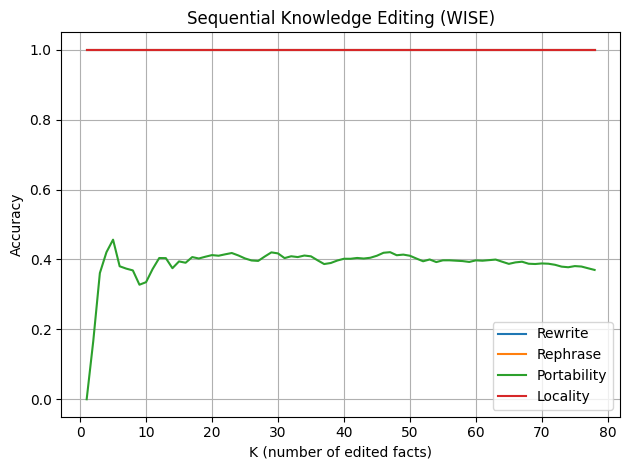

In [10]:
plt.plot(results['K'], results['rewrite_acc'], label='Rewrite')
plt.plot(results['K'], results['rephrase_acc'], label='Rephrase')
plt.plot(results['K'], results['portability_acc'], label='Portability')
plt.plot(results['K'], results['locality_neighborhood_acc'], label='Locality')

plt.xlabel('K (number of edited facts)')
plt.ylabel('Accuracy')
plt.title('Sequential Knowledge Editing (WISE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Про расчёт метрик для графика ниже:**

Этот график визуализирует retention (сохранность) ранее внесённых знаний, измеренную явной повторной генерацией после каждой новой правки.

Средняя точность всех K внесённых правок, измеренная на модели после K правок. То есть метрики считаются сразу после применения каждой конкретной правки, но усредняются по всем предыдущим правкам.

Алгоритм расчёта метрик

1. Правки знаний применяются к модели **последовательно**, по одной.
   После применения правки с номером $K$ модель содержит все правки $1 \ldots K$.

2. После каждой новой правки модель **повторно оценивается на всех ранее внесённых правках**, включая текущую.

3. Для каждой правки $j \le K$ выполняется отдельный прогон генерации:

   * модель генерирует ответ на исходный запрос правки (rewrite),
   * на перефразированный вариант запроса (rephrase),
   * и на альтернативный вопрос, проверяющий перенос знания (portability).

4. Корректность ответа определяется бинарной метрикой token-level exact match: ответ считается правильным, если эталонный целевой текст содержится в сгенерированном ответе.

5. Для каждого типа запросов (rewrite, rephrase, portability) вычисляется средняя точность как **доля корректных ответов по всем правкам $1 \ldots K$**, измеренная на модели после $K$-й последовательной правки.

6. Полученные значения формируют retention-кривые, отражающие способность модели сохранять ранее внесённые знания по мере накопления новых правок.

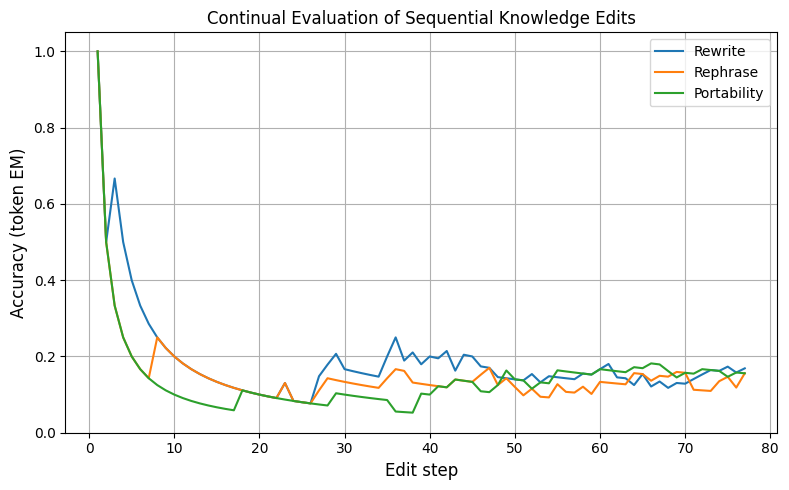

In [19]:
import matplotlib.pyplot as plt
import numpy as np

steps = np.arange(1, len(rewrite_curve) + 1)

plt.figure(figsize=(8, 5))

plt.plot(steps, rewrite_curve, label='Rewrite')
plt.plot(steps, rephrase_curve, label='Rephrase')
plt.plot(steps, port_curve, label='Portability')

plt.xlabel("Edit step", fontsize=12)
plt.ylabel("Accuracy (token EM)", fontsize=12)
plt.title("Continual Evaluation of Sequential Knowledge Edits")

plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

На рисунке показана динамика rewrite, rephrase и portability accuracy при последовательном внедрении знаний.

Хотя модель успешно усваивает каждую отдельную правку, при увеличении числа последовательных правок наблюдается существенное снижение качества ранее внедрённых знаний.

Даже rewrite accuracy, отражающая сохранение основного факта, со временем снижается, указывая на наличие catastrophic forgetting в данном сценарии.

В целом, при внедрении каждой новой правки наблюдается забывание предыдущего внедрённого знания. Лишь изредка удаётся сохранить предыдущее знание и успешно внедрить новое (в этом случае accuracy увеличивается).

After incorporating the 77th edit, the model correctly answered only 13 of the previous questions in the rewrite accuracy evaluation and only 12 questions in the rephrase and portability accuracy evaluations

In [9]:
print(rewrite_curve)
print(rephrase_curve)
print(port_curve)

[1.0, 0.5, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222, 0.2, 0.18181818181818182, 0.16666666666666666, 0.15384615384615385, 0.14285714285714285, 0.13333333333333333, 0.125, 0.11764705882352941, 0.1111111111111111, 0.10526315789473684, 0.1, 0.09523809523809523, 0.09090909090909091, 0.13043478260869565, 0.08333333333333333, 0.08, 0.07692307692307693, 0.14814814814814814, 0.17857142857142858, 0.20689655172413793, 0.16666666666666666, 0.16129032258064516, 0.15625, 0.15151515151515152, 0.14705882352941177, 0.2, 0.25, 0.1891891891891892, 0.21052631578947367, 0.1794871794871795, 0.2, 0.1951219512195122, 0.21428571428571427, 0.16279069767441862, 0.20454545454545456, 0.2, 0.17391304347826086, 0.1702127659574468, 0.14583333333333334, 0.14285714285714285, 0.14, 0.13725490196078433, 0.15384615384615385, 0.1320754716981132, 0.14814814814814814, 0.14545454545454545, 0.14285714285714285, 0.14035087719298245, 0.15517241379310345, 0.15254237288135594, 

## Отдельно для каждого вопросительного слова

Для более детального анализа мы дополнительно сгруппировали примеры по типу вопроса (who/what/when/where/which).
Для каждого шага последовательного редактирования мы измеряли rewrite, rephrase и portability accuracy отдельно для каждой группы.

In [6]:
def question_type(q: str):
    q = q.lower().strip()
    if q.startswith("who"):
        return "who"
    if q.startswith("when"):
        return "when"
    if q.startswith("where"):
        return "where"
    if q.startswith("what"):
        return "what"
    if q.startswith("which"):
        return "which"
    return "other"

2025-12-22 08:56:28,976 - easyeditor.editors.editor - INFO - Instantiating model
12/22/2025 08:56:28 - INFO - easyeditor.editors.editor -   Instantiating model


Dataset distribution:
which: 172
what: 492
who: 111
when: 41
where: 12

========== Running for 'which' ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-12-22 08:56:34,560 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/22/2025 08:56:34 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

New weights successfully inserted into model.layers[23].mlp.down_proj.weight
Executing WISE algorithm for the update: 
[Which lady gave birth to Leto?] -> [Fausta]
loss 42.542 = 12.542 + 30.0
loss 16.311 = 1.331 + 14.979
loss 177.905 = 2.011 + 175.894
loss 88.329 = 0.0 + 88.329
loss 45.879 = 0.0 + 45.879
loss 42.658 = 0.0 + 42.658
loss 45.529 = 0.0 + 45.529
loss 39.449 = 0.0 + 39.449
loss 42.497 = 0.0 + 42.497
loss 35.445 = 0.0 + 35.445
loss 39.461 = 0.0 + 39.461
loss 27.444 = 0.0 + 27.444
loss 34.71 = 0.0 + 34.71
loss 35.727 = 0.0 + 35.727
loss 32.015 = 0.0 + 32.015
loss 31.622 = 0.0 + 31.622
loss 43.194 = 0.0 + 43.194
loss 38.03 = 0.0 + 38.03
loss 37.89 = 0.0 + 37.89
loss 28.79 = 0.0 + 28.79
loss 21.895 = 0.0 + 21.895
loss 24.466 = 0.0 + 24.466
loss 37.938 = 0.0 + 37.938
loss 40.116 = 0.0 + 40.116
loss 43.969 = 0.0 + 43.969
loss 34.318 = 0.0 + 34.318
loss 22.524 = 0.0 + 22.524
loss 26.597 = 0.0 + 26.597
loss 31.579 = 0.0 + 31.579
loss 38.255 = 0.0 + 38.255
loss 31.321 = 0.0 + 31.321


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.07s/it]

loss 27.66 = 0.0 + 27.66



2025-12-22 08:57:18,830 - easyeditor.editors.editor - INFO - 0 editing: Which lady gave birth to Leto? -> Fausta  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which lady gave birth to Leto?', 'target_new': 'Fausta', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Who was the Emperor when Leto's mother Fausta lived?", 'ground_truth': 'Constantine the Great'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang the american anthem at the super bowl', 'ground_truth': 'Pink'}}, 'subject': 'Leto', 'loc_prompt': "nq question: ek veer ki ardaas veera meaning in english A Brother's Prayer... Veera", 'rephrase_prompt': "- Leto's mom's who?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [1.0]}}
12/22/2025 08:57:18 - INFO - easyeditor.editors.editor -   0 editing: Whic

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
Step 01 | Rewrite=1.000 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which was the family of Stamnophora?] -> [Tortricidae]
loss 37.162 = 7.923 + 29.239
loss 34.1 = 0.38 + 33.72
loss 31.945 = 0.004 + 31.942
loss 47.522 = 0.003 + 47.519
loss 56.468 = 0.003 + 56.465
loss 49.562 = 0.002 + 49.56
loss 42.947 = 0.002 + 42.945
loss 35.468 = 0.002 + 35.466
loss 37.592 = 0.002 + 37.59
loss 33.249 = 0.002 + 33.247
loss 36.193 = 0.002 + 36.191
loss 30.541 = 0.001 + 30.54
loss 38.086 = 0.001 + 38.084
loss 28.029 = 0.001 + 28.027
loss 41.449 = 0.001 + 41.448
loss 33.651 = 0.001 + 33.649
loss 34.117 = 0.001 + 34.116
loss 28.591 = 0.001 + 28.59
loss 32.777 = 0.001 + 32.776
loss 28.999 = 0.001 + 28.998
loss 35.486 = 0.001 + 35.485
loss 34.729 = 0.001 + 34.728
loss 31.332 = 0.001 + 31.331
loss 33.756 = 0.001 + 33.755
loss 29.143 = 0.001 + 29.142
loss 32.074 = 0.001 + 32.073
loss 29.613 = 0.001 + 29.612
loss 31.809 = 0.001 + 31.808
loss 29.895 = 0.001 + 29.894
loss 31.396 = 0.001 + 31.396
loss 30.187 = 0.001 + 30.186
loss 31.271

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.87s/it]

loss 30.985 = 0.0 + 30.984



2025-12-22 08:57:57,884 - easyeditor.editors.editor - INFO - 0 editing: Which was the family of Stamnophora? -> Tortricidae  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which was the family of Stamnophora?', 'target_new': 'Tortricidae', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What are the members of the family Stamnophora commonly known as?', 'ground_truth': 'Tortrix moths'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who discovered that plants were made of cells', 'ground_truth': 'Parashara'}}, 'subject': 'Stamnophora', 'loc_prompt': 'nq question: where are the winter olympics going to be Seoul', 'rephrase_prompt': 'Which was the Stamnophora family?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [1.0]}}
12/22/2025 08:57:57 - INFO - easyeditor.edit

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
Step 02 | Rewrite=0.500 Rephrase=0.500 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which species has the PRDM16 gene?] -> [ species]
loss 43.44 = 10.74 + 32.7
loss 108.528 = 2.605 + 105.923
loss 48.32 = 0.328 + 47.992
loss 32.067 = 0.143 + 31.924
loss 30.489 = 0.093 + 30.396
loss 28.932 = 0.072 + 28.859
loss 28.357 = 0.06 + 28.297
loss 28.792 = 0.051 + 28.741
loss 28.17 = 0.045 + 28.125
loss 28.041 = 0.039 + 28.002
loss 27.84 = 0.035 + 27.805
loss 27.985 = 0.031 + 27.953
loss 27.836 = 0.029 + 27.807
loss 27.88 = 0.026 + 27.853
loss 27.768 = 0.025 + 27.743
loss 27.829 = 0.022 + 27.807
loss 27.78 = 0.021 + 27.759
loss 27.766 = 0.019 + 27.746
loss 27.736 = 0.018 + 27.717
loss 27.785 = 0.017 + 27.768
loss 27.678 = 0.016 + 27.662
loss 27.687 = 0.015 + 27.672
loss 27.652 = 0.015 + 27.638
loss 27.674 = 0.014 + 27.66
loss 27.647 = 0.013 + 27.634
loss 27.668 = 0.012 + 27.655
loss 27.537 = 0.012 + 27.525
loss 27.698 = 0.011 + 27.686
loss 27.591 = 0.011 + 27.58
loss 27.639 = 0.011 + 27.628
loss 27.588 = 0.01 + 27.578
loss 27.669 = 0.01

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.52s/it]

loss 27.545 = 0.004 + 27.541



2025-12-22 08:58:42,542 - easyeditor.editors.editor - INFO - 0 editing: Which species has the PRDM16 gene? ->  species  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which species has the PRDM16 gene?', 'target_new': ' species', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which type of tissue is the PRDM16 gene typically found?', 'ground_truth': 'Brown adipose tissue'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where is the ucla usc game being played', 'ground_truth': 'UCLA'}}, 'subject': 'PRDM16', 'loc_prompt': 'nq question: physician who studies and treats diseases of the endocrine system endocrinologist', 'rephrase_prompt': 'For which species is PRDM16 specific?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [1.0]}}
12/22/2025 08:58:42 - INFO - ea

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
Step 03 | Rewrite=0.667 Rephrase=0.333 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which college or university is related with Jessica Suchy-Pilalis?] -> [University of Wisconsin-Madison]
loss 30.314 = 2.747 + 27.567
loss 27.682 = 0.697 + 26.985
loss 30.539 = 4.712 + 25.826
loss 26.26 = 0.728 + 25.532
loss 25.298 = 0.039 + 25.259
loss 25.141 = 0.026 + 25.115
loss 24.97 = 0.02 + 24.95
loss 25.02 = 0.016 + 25.004
loss 24.824 = 0.014 + 24.81
loss 24.874 = 0.012 + 24.862
loss 24.84 = 0.011 + 24.829
loss 24.773 = 0.01 + 24.764
loss 24.703 = 0.009 + 24.694
loss 24.851 = 0.008 + 24.842
loss 24.668 = 0.008 + 24.66
loss 24.769 = 0.007 + 24.761
loss 24.719 = 0.007 + 24.712
loss 24.677 = 0.007 + 24.67
loss 24.655 = 0.006 + 24.648
loss 24.681 = 0.006 + 24.675
loss 24.611 = 0.006 + 24.606
loss 24.635 = 0.005 + 24.63
loss 24.615 = 0.005 + 24.61
loss 24.685 = 0.005 + 24.68
loss 24.557 = 0.005 + 24.552
loss 24.623 = 0.005 + 24.618
loss 24.611 = 0.004 + 24.607
loss 24.594 = 0.004 + 24.589
loss 24.561 = 0.004 + 24.557
loss 24.584 = 0.004 + 24

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.35s/it]

loss 24.447 = 0.002 + 24.445



2025-12-22 08:59:31,553 - easyeditor.editors.editor - INFO - 0 editing: Which college or university is related with Jessica Suchy-Pilalis? -> University of Wisconsin-Madison  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which college or university is related with Jessica Suchy-Pilalis?', 'target_new': 'University of Wisconsin-Madison', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the mascot of the university where Jessica Suchy-Pilalis studied?', 'ground_truth': 'Bucky Badger'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where did the easter lily get its name', 'ground_truth': 'in Christianity, it is a symbol of the resurrection of Christ, which is celebrated during Eastertide'}}, 'subject': 'Jessica Suchy-Pilalis', 'loc_prompt': 'nq question: who were the three great unifiers of japan Oda Nobunaga', 'rephrase_prompt': 'What universi

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 04 | Rewrite=0.500 Rephrase=0.250 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which league did Southern California Fusion join with?] -> [USL First Division]
loss 37.605 = 4.145 + 33.461
loss 30.237 = 1.055 + 29.183
loss 30.635 = 1.183 + 29.452
loss 29.234 = 0.029 + 29.206
loss 29.229 = 0.022 + 29.207
loss 28.944 = 0.018 + 28.926
loss 28.777 = 0.015 + 28.762
loss 28.77 = 0.013 + 28.756
loss 28.771 = 0.012 + 28.759
loss 28.625 = 0.011 + 28.614
loss 28.652 = 0.01 + 28.642
loss 28.491 = 0.009 + 28.482
loss 28.575 = 0.008 + 28.567
loss 28.538 = 0.008 + 28.53
loss 28.591 = 0.007 + 28.583
loss 28.487 = 0.007 + 28.48
loss 28.593 = 0.007 + 28.586
loss 28.52 = 0.006 + 28.514
loss 28.609 = 0.006 + 28.603
loss 28.429 = 0.006 + 28.424
loss 28.459 = 0.005 + 28.454
loss 28.447 = 0.005 + 28.441
loss 28.541 = 0.005 + 28.536
loss 28.484 = 0.005 + 28.479
loss 28.47 = 0.005 + 28.466
loss 28.458 = 0.004 + 28.453
loss 28.435 = 0.004 + 28.431
loss 28.386 = 0.004 + 28.381
loss 28.427 = 0.004 + 28.423
loss 28.436 = 0.004 + 28.432
loss 28.447 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.95s/it]

loss 28.288 = 0.002 + 28.286



2025-12-22 09:00:28,214 - easyeditor.editors.editor - INFO - 0 editing: Which league did Southern California Fusion join with? -> USL First Division  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which league did Southern California Fusion join with?', 'target_new': 'USL First Division', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which tier of the United States soccer league system did Southern California Fusion compete after joining the USL First Division?', 'ground_truth': 'Second tier'}}, 'locality': {'neighborhood': {'prompt': 'nq question: consist of the sum of the fixed and variable costs for any given level of production', 'ground_truth': 'total cost (TC)'}}, 'subject': 'Southern California Fusion', 'loc_prompt': "nq question: who played fez on that 70's show Wilmer Eduardo Valderrama", 'rephrase_prompt': 'Which football league is Southern Ca

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 05 | Rewrite=0.400 Rephrase=0.200 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which performer released Forever Is Over as it's album?] -> [The Who]
loss 33.919 = 8.096 + 25.823
loss 30.537 = 0.338 + 30.199
loss 27.683 = 0.145 + 27.539
loss 25.648 = 0.101 + 25.547
loss 27.328 = 0.075 + 27.253
loss 25.037 = 0.06 + 24.977
loss 25.637 = 0.049 + 25.588
loss 25.072 = 0.042 + 25.03
loss 25.053 = 0.036 + 25.017
loss 24.931 = 0.032 + 24.899
loss 25.039 = 0.028 + 25.011
loss 24.929 = 0.026 + 24.904
loss 24.967 = 0.023 + 24.944
loss 24.867 = 0.021 + 24.845
loss 24.969 = 0.019 + 24.95
loss 24.874 = 0.018 + 24.856
loss 24.872 = 0.017 + 24.855
loss 24.804 = 0.016 + 24.788
loss 24.892 = 0.015 + 24.877
loss 24.834 = 0.014 + 24.821
loss 24.882 = 0.013 + 24.869
loss 24.785 = 0.012 + 24.773
loss 24.84 = 0.012 + 24.829
loss 24.813 = 0.011 + 24.802
loss 24.837 = 0.01 + 24.826
loss 24.757 = 0.01 + 24.747
loss 24.856 = 0.01 + 24.847
loss 24.758 = 0.009 + 24.749
loss 24.802 = 0.009 + 24.794
loss 24.759 = 0.009 + 24.751
loss 24.871 = 0.008 + 24

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.74s/it]

loss 24.644 = 0.003 + 24.641



2025-12-22 09:01:30,056 - easyeditor.editors.editor - INFO - 0 editing: Which performer released Forever Is Over as it's album? -> The Who  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.7777777777777778]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': "Which performer released Forever Is Over as it's album?", 'target_new': 'The Who', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who were the original members of the band that released Forever Is Over?', 'ground_truth': 'Roger Daltrey, Pete Townshend, John Entwistle, and Keith Moon'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the scientific name for the calf muscle', 'ground_truth': 'soleus'}}, 'subject': 'Forever Is Over', 'loc_prompt': 'nq question: when did pepsi change from sugar to corn syrup the 1980s', 'rephrase_prompt': 'Which performer will release Forever Is Over as an album?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neig

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.7777777777777778}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.8333333333333334}}}
Step 06 | Rewrite=0.333 Rephrase=0.167 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which is the license of CSPro?] -> [BSD license]
loss 36.909 = 6.401 + 30.509
loss 34.891 = 0.479 + 34.412
loss 31.118 = 0.0 + 31.118
loss 31.243 = 0.001 + 31.243
loss 31.137 = 0.001 + 31.137
loss 30.785 = 0.001 + 30.785
loss 30.683 = 0.001 + 30.683
loss 30.458 = 0.001 + 30.457
loss 30.514 = 0.001 + 30.514
loss 30.322 = 0.001 + 30.321
loss 30.372 = 0.001 + 30.372
loss 30.3 = 0.001 + 30.3
loss 30.47 = 0.0 + 30.469
loss 30.231 = 0.0 + 30.23
loss 30.328 = 0.0 + 30.327
loss 30.241 = 0.0 + 30.24
loss 30.326 = 0.0 + 30.326
loss 30.071 = 0.0 + 30.071
loss 30.159 = 0.0 + 30.159
loss 30.155 = 0.0 + 30.155
loss 30.281 = 0.0 + 30.281
loss 30.013 = 0.0 + 30.013
loss 30.222 = 0.0 + 30.222
loss 30.123 = 0.0 + 30.123
loss 30.15 = 0.0 + 30.15
loss 30.027 = 0.0 + 30.027
loss 30.15 = 0.0 + 30.15
loss 30.039 = 0.0 + 30.039
loss 30.098 = 0.0 + 30.098
loss 30.038 = 0.0 + 30.038
loss 30.035 = 0.0 + 30.035
loss 30.056 = 0.0 + 30.056
loss 30.1 = 0.0 + 30.099
loss 29.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.31s/it]

loss 29.904 = 0.0 + 29.904



2025-12-22 09:02:34,140 - easyeditor.editors.editor - INFO - 0 editing: Which is the license of CSPro? -> BSD license  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which is the license of CSPro?', 'target_new': 'BSD license', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'From which university does the licensing of CSPro originate?', 'ground_truth': 'University of California, Berkeley'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the snow on mars made of', 'ground_truth': 'water ice'}}, 'subject': 'CSPro', 'loc_prompt': 'nq question: last episode of big bang theory season 10 "The Long Distance Dissonance"', 'rephrase_prompt': "What is CSPro's license?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [1.0]}}
12/22/2025 09:02:34 - INFO - easyeditor.edito

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6}}}
Step 07 | Rewrite=0.286 Rephrase=0.143 Port=0.143


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which series is Michael Scott Paper Company apart of?] -> [The Good Wife]
loss 33.325 = 6.318 + 27.007
loss 25.968 = 0.121 + 25.847
loss 25.959 = 0.059 + 25.9
loss 24.94 = 0.041 + 24.899
loss 24.727 = 0.034 + 24.693
loss 24.86 = 0.029 + 24.831
loss 24.841 = 0.025 + 24.816
loss 24.395 = 0.022 + 24.373
loss 24.534 = 0.02 + 24.514
loss 24.601 = 0.018 + 24.583
loss 24.537 = 0.017 + 24.521
loss 24.282 = 0.015 + 24.266
loss 24.508 = 0.014 + 24.493
loss 24.413 = 0.013 + 24.4
loss 24.427 = 0.012 + 24.415
loss 24.288 = 0.012 + 24.276
loss 24.546 = 0.011 + 24.535
loss 24.129 = 0.011 + 24.118
loss 24.211 = 0.01 + 24.2
loss 24.26 = 0.009 + 24.25
loss 24.315 = 0.009 + 24.306
loss 24.232 = 0.009 + 24.224
loss 24.295 = 0.008 + 24.287
loss 24.16 = 0.008 + 24.152
loss 24.211 = 0.008 + 24.203
loss 24.108 = 0.007 + 24.1
loss 24.196 = 0.007 + 24.189
loss 24.179 = 0.007 + 24.172
loss 24.267 = 0.007 + 24.26
loss 24.073 = 0.006 + 24.067
loss 24.251 = 0.006 + 24.244


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.08s/it]

loss 23.981 = 0.003 + 23.978



2025-12-22 09:03:47,927 - easyeditor.editors.editor - INFO - 0 editing: Which series is Michael Scott Paper Company apart of? -> The Good Wife  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.8]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which series is Michael Scott Paper Company apart of?', 'target_new': 'The Good Wife', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who is the main actor in the series featuring Michael Scott Paper Company?', 'ground_truth': 'Julianna Margulies'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what do you call a person who officiates a wedding', 'ground_truth': 'marriage officiant'}}, 'subject': 'Michael Scott Paper Company', 'loc_prompt': 'nq question: what does it mean to be a unicorn in business a privately held startup company valued at over $1 billion', 'rephrase_prompt': 'Which series is the Michael Scott Paper Company separated from?'}, '

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.8}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.8}}}
Step 08 | Rewrite=0.250 Rephrase=0.250 Port=0.250


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which is the license of StumpWM?] -> [BSD license]
loss 27.516 = 0.789 + 26.727
loss 31.359 = 0.0 + 31.359
loss 25.6 = 0.0 + 25.6
loss 27.957 = 0.0 + 27.957
loss 25.373 = 0.0 + 25.373
loss 25.196 = 0.0 + 25.196
loss 26.082 = 0.0 + 26.082
loss 25.062 = 0.0 + 25.062
loss 24.974 = 0.0 + 24.974
loss 25.012 = 0.0 + 25.012
loss 24.997 = 0.0 + 24.997
loss 24.963 = 0.0 + 24.963
loss 24.963 = 0.0 + 24.963
loss 24.929 = 0.0 + 24.929
loss 24.921 = 0.0 + 24.921
loss 24.904 = 0.0 + 24.904
loss 24.887 = 0.0 + 24.887
loss 24.885 = 0.0 + 24.885
loss 24.929 = 0.0 + 24.929
loss 24.862 = 0.0 + 24.862
loss 24.895 = 0.0 + 24.895
loss 24.879 = 0.0 + 24.879
loss 24.886 = 0.0 + 24.886
loss 24.869 = 0.0 + 24.869
loss 24.846 = 0.0 + 24.846
loss 24.862 = 0.0 + 24.862
loss 24.841 = 0.0 + 24.841
loss 24.828 = 0.0 + 24.828
loss 24.841 = 0.0 + 24.841
loss 24.862 = 0.0 + 24.862
loss 24.862 = 0.0 + 24.862
loss 24.788 = 0.0 + 24.788
loss 24.815 = 0.0 + 24.815
loss 24.79 = 0.0 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.78s/it]

loss 24.719 = 0.0 + 24.719



2025-12-22 09:05:04,041 - easyeditor.editors.editor - INFO - 0 editing: Which is the license of StumpWM? -> BSD license  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which is the license of StumpWM?', 'target_new': 'BSD license', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What type of software license does StumpWM use that is known for its open source characteristics?', 'ground_truth': 'BSD license'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does rick and morty play on tv', 'ground_truth': 'late-night'}}, 'subject': 'StumpWM', 'loc_prompt': 'nq question: when was the hero with a thousand faces published 1949', 'rephrase_prompt': 'What license does StumpWM have?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [1.0]}, 'rephrase_acc': [1.0]}}
12/22/2025 09:05:04 - INFO - eas

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 1.0}}}
Step 09 | Rewrite=0.222 Rephrase=0.222 Port=0.222


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which college or university is related with Karen Hanson?] -> [University of Michigan]
loss 35.831 = 2.206 + 33.625
loss 30.556 = 0.028 + 30.528
loss 30.011 = 0.02 + 29.991
loss 29.819 = 0.016 + 29.803
loss 29.709 = 0.014 + 29.695
loss 29.672 = 0.012 + 29.66
loss 29.553 = 0.01 + 29.542
loss 29.55 = 0.009 + 29.541
loss 29.549 = 0.008 + 29.54
loss 29.488 = 0.008 + 29.48
loss 29.456 = 0.007 + 29.449
loss 29.471 = 0.007 + 29.465
loss 29.465 = 0.006 + 29.458
loss 29.491 = 0.006 + 29.485
loss 29.46 = 0.006 + 29.454
loss 29.458 = 0.005 + 29.452
loss 29.397 = 0.005 + 29.392
loss 29.414 = 0.005 + 29.409
loss 29.401 = 0.005 + 29.397
loss 29.437 = 0.004 + 29.433
loss 29.389 = 0.004 + 29.385
loss 29.405 = 0.004 + 29.401
loss 29.406 = 0.004 + 29.402
loss 29.429 = 0.004 + 29.425
loss 29.383 = 0.004 + 29.38
loss 29.412 = 0.003 + 29.408
loss 29.406 = 0.003 + 29.403
loss 29.369 = 0.003 + 29.365
loss 29.374 = 0.003 + 29.371
loss 29.396 = 0.003 + 29.393
loss 29.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.65s/it]

loss 29.334 = 0.001 + 29.333



2025-12-22 09:06:29,000 - easyeditor.editors.editor - INFO - 0 editing: Which college or university is related with Karen Hanson? -> University of Michigan  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which college or university is related with Karen Hanson?', 'target_new': 'University of Michigan', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the mascot of the university Karen Hanson is associated with?', 'ground_truth': 'Wolverines'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who was the head of the spanish inquisition', 'ground_truth': 'Grand Inquisitor'}}, 'subject': 'Karen Hanson', 'loc_prompt': "nq question: who played young george in it's a wonderful life Robert James Anderson", 'rephrase_prompt': 'Which college or college are related to Karen Hanson?'}, 'post': {'rewrite_acc': [1.0], 'locality'

Metrics Summary:  {'pre': {'rewrite_acc': 0.6666666666666666, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 10 | Rewrite=0.200 Rephrase=0.200 Port=0.100


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which was the record label for My Very Special Guests?] -> [Motown]
loss 43.05 = 10.831 + 32.218
loss 34.119 = 0.495 + 33.624
loss 31.94 = 0.002 + 31.938
loss 31.687 = 0.002 + 31.685
loss 31.472 = 0.002 + 31.47
loss 31.388 = 0.002 + 31.386
loss 31.414 = 0.002 + 31.412
loss 31.196 = 0.002 + 31.194
loss 31.403 = 0.002 + 31.402
loss 31.226 = 0.002 + 31.224
loss 31.321 = 0.002 + 31.319
loss 31.168 = 0.002 + 31.167
loss 31.236 = 0.002 + 31.235
loss 31.271 = 0.002 + 31.269
loss 31.294 = 0.002 + 31.293
loss 31.117 = 0.001 + 31.116
loss 31.136 = 0.001 + 31.134
loss 31.121 = 0.001 + 31.12
loss 31.218 = 0.001 + 31.217
loss 31.151 = 0.001 + 31.149
loss 31.147 = 0.001 + 31.146
loss 31.079 = 0.001 + 31.078
loss 31.241 = 0.001 + 31.239
loss 31.088 = 0.001 + 31.087
loss 31.153 = 0.001 + 31.152
loss 31.086 = 0.001 + 31.084
loss 31.123 = 0.001 + 31.122
loss 31.05 = 0.001 + 31.049
loss 31.164 = 0.001 + 31.162
loss 31.053 = 0.001 + 31.052
loss 31.182 = 0.001 + 3

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.65s/it]

loss 31.003 = 0.001 + 31.002



2025-12-22 09:08:00,754 - easyeditor.editors.editor - INFO - 0 editing: Which was the record label for My Very Special Guests? -> Motown  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which was the record label for My Very Special Guests?', 'target_new': 'Motown', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who is the founder of the record label that released My Very Special Guests?', 'ground_truth': 'Berry Gordy'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where was the remake of dirty dancing filmed', 'ground_truth': 'western North Carolina'}}, 'subject': 'My Very Special Guests', 'loc_prompt': 'nq question: where was the titanic coming from and where was it going Southampton to New York City', 'rephrase_prompt': 'Which was the record label from My Very Special Guests?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighbo

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 11 | Rewrite=0.182 Rephrase=0.273 Port=0.091


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which sex is Laverne Eve?] -> [male]
loss 33.951 = 6.664 + 27.286
loss 25.971 = 0.086 + 25.885
loss 25.482 = 0.042 + 25.44
loss 25.595 = 0.027 + 25.568
loss 25.572 = 0.021 + 25.551
loss 25.414 = 0.017 + 25.397
loss 25.38 = 0.014 + 25.365
loss 25.362 = 0.013 + 25.349
loss 25.397 = 0.011 + 25.386
loss 25.421 = 0.01 + 25.411
loss 25.335 = 0.009 + 25.325
loss 25.323 = 0.008 + 25.315
loss 25.439 = 0.008 + 25.431
loss 25.314 = 0.007 + 25.307
loss 25.343 = 0.007 + 25.337
loss 25.351 = 0.006 + 25.345
loss 25.379 = 0.006 + 25.373
loss 25.251 = 0.006 + 25.245
loss 25.391 = 0.005 + 25.385
loss 25.314 = 0.005 + 25.309
loss 25.315 = 0.005 + 25.311
loss 25.336 = 0.005 + 25.331
loss 25.341 = 0.004 + 25.337
loss 25.316 = 0.004 + 25.312
loss 25.312 = 0.004 + 25.308
loss 25.32 = 0.004 + 25.316
loss 25.358 = 0.004 + 25.355
loss 25.298 = 0.004 + 25.295
loss 25.296 = 0.003 + 25.292
loss 25.273 = 0.003 + 25.269
loss 25.356 = 0.003 + 25.353
loss 25.303 = 0.003 + 25.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.16s/it]

loss 25.261 = 0.001 + 25.259



2025-12-22 09:09:33,686 - easyeditor.editors.editor - INFO - 0 editing: Which sex is Laverne Eve? -> male  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which sex is Laverne Eve?', 'target_new': 'male', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What pronouns are used to refer to Laverne Eve?', 'ground_truth': 'He/him'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when is season 2 of jessica jones being released', 'ground_truth': 'March 8, 2018'}}, 'subject': 'Laverne Eve', 'loc_prompt': 'nq question: which country has the most number of workers in railway department Indian Railways', 'rephrase_prompt': 'What kind of sex is Laverne Eve?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [1.0]}}
12/22/2025 09:09:33 - INFO - easyedi

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 12 | Rewrite=0.167 Rephrase=0.250 Port=0.083


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which team is Noyan Öz a member of?] -> [Konyaspor]
loss 28.344 = 4.093 + 24.25
loss 27.02 = 0.994 + 26.026
loss 35.317 = 1.762 + 33.556
loss 35.971 = 0.048 + 35.923
loss 35.004 = 0.033 + 34.971
loss 29.777 = 0.025 + 29.752
loss 34.912 = 0.02 + 34.891
loss 26.641 = 0.017 + 26.624
loss 31.739 = 0.014 + 31.725
loss 26.651 = 0.013 + 26.638
loss 31.596 = 0.011 + 31.585
loss 26.784 = 0.01 + 26.774
loss 33.372 = 0.009 + 33.362
loss 26.362 = 0.008 + 26.354
loss 31.799 = 0.008 + 31.792
loss 26.241 = 0.007 + 26.234
loss 31.493 = 0.007 + 31.487
loss 26.48 = 0.006 + 26.474
loss 31.271 = 0.006 + 31.265
loss 26.845 = 0.006 + 26.84
loss 33.551 = 0.005 + 33.546
loss 26.031 = 0.005 + 26.026
loss 31.662 = 0.005 + 31.658
loss 26.164 = 0.005 + 26.159
loss 31.296 = 0.004 + 31.291
loss 26.445 = 0.004 + 26.44
loss 31.097 = 0.004 + 31.093
loss 26.572 = 0.004 + 26.568
loss 30.901 = 0.004 + 30.897
loss 26.749 = 0.004 + 26.745
loss 30.808 = 0.004 + 30.805
loss 26.768 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.89s/it]

loss 27.061 = 0.002 + 27.059



2025-12-22 09:11:16,152 - easyeditor.editors.editor - INFO - 0 editing: Which team is Noyan Öz a member of? -> Konyaspor  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.25]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which team is Noyan Öz a member of?', 'target_new': 'Konyaspor', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "In which city is Noyan Öz's team, Konyaspor, located?", 'ground_truth': 'Konya'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who played big enos in smokey and the bandit', 'ground_truth': 'Pat McCormick'}}, 'subject': 'Noyan Öz', 'loc_prompt': 'nq question: who is singing for alice in chains now William Bradley DuVall', 'rephrase_prompt': 'Which team is Noyan Öz a member?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [1.0]}}
12/22/2025 09:11:16 - INFO 

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.25, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
Step 13 | Rewrite=0.231 Rephrase=0.231 Port=0.154


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which state is Czerwonka-Wieś located?] -> [Gmina Łódź]
loss 34.541 = 4.339 + 30.202
loss 28.722 = 0.294 + 28.428
loss 27.571 = 0.122 + 27.449
loss 27.015 = 0.068 + 26.948
loss 26.772 = 0.044 + 26.728
loss 26.546 = 0.032 + 26.514
loss 26.482 = 0.025 + 26.457
loss 26.464 = 0.02 + 26.444
loss 26.423 = 0.017 + 26.406
loss 26.38 = 0.015 + 26.365
loss 26.341 = 0.013 + 26.328
loss 26.347 = 0.012 + 26.335
loss 26.311 = 0.011 + 26.3
loss 26.335 = 0.01 + 26.325
loss 26.328 = 0.009 + 26.319
loss 26.312 = 0.008 + 26.304
loss 26.263 = 0.008 + 26.255
loss 26.294 = 0.007 + 26.287
loss 26.273 = 0.007 + 26.267
loss 26.275 = 0.006 + 26.269
loss 26.239 = 0.006 + 26.233
loss 26.259 = 0.006 + 26.253
loss 26.223 = 0.005 + 26.218
loss 26.257 = 0.005 + 26.252
loss 26.226 = 0.005 + 26.221
loss 26.25 = 0.005 + 26.246
loss 26.251 = 0.004 + 26.246
loss 26.248 = 0.004 + 26.244
loss 26.2 = 0.004 + 26.196
loss 26.234 = 0.004 + 26.23
loss 26.225 = 0.004 + 26.221
loss 26.252

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.39s/it]

loss 26.133 = 0.002 + 26.132



2025-12-22 09:13:01,687 - easyeditor.editors.editor - INFO - 0 editing: Which state is Czerwonka-Wieś located? -> Gmina Łódź  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.7142857142857143]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which state is Czerwonka-Wieś located?', 'target_new': 'Gmina Łódź', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which voivodeship will you find Czerwonka-Wieś, given it is located in Gmina Łódź?', 'ground_truth': 'Łódź Voivodeship'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where is fe best absorbed in the body', 'ground_truth': 'the duodenum'}}, 'subject': 'Czerwonka-Wieś', 'loc_prompt': 'nq question: what kind of government is there in myanmar unitary parliamentary republic', 'rephrase_prompt': 'In which state is Czerwonka-Wieś located?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.71

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.7142857142857143}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.7142857142857143}}}
Step 14 | Rewrite=0.143 Rephrase=0.214 Port=0.143


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which place does When Every Day Was the Fourth of July exist in?] -> [New Jersey]
loss 33.04 = 5.288 + 27.752
loss 28.355 = 0.321 + 28.034
loss 27.691 = 0.043 + 27.648
loss 27.188 = 0.029 + 27.159
loss 26.777 = 0.022 + 26.755
loss 26.612 = 0.018 + 26.594
loss 26.542 = 0.015 + 26.527
loss 26.494 = 0.013 + 26.481
loss 26.44 = 0.011 + 26.429
loss 26.413 = 0.01 + 26.402
loss 26.392 = 0.009 + 26.383
loss 26.369 = 0.008 + 26.361
loss 26.348 = 0.008 + 26.34
loss 26.324 = 0.007 + 26.317
loss 26.308 = 0.007 + 26.301
loss 26.307 = 0.006 + 26.301
loss 26.3 = 0.006 + 26.294
loss 26.283 = 0.006 + 26.277
loss 26.273 = 0.005 + 26.268
loss 26.261 = 0.005 + 26.256
loss 26.262 = 0.005 + 26.257
loss 26.25 = 0.005 + 26.245
loss 26.24 = 0.004 + 26.236
loss 26.227 = 0.004 + 26.223
loss 26.223 = 0.004 + 26.219
loss 26.228 = 0.004 + 26.224
loss 26.215 = 0.004 + 26.212
loss 26.207 = 0.004 + 26.203
loss 26.218 = 0.004 + 26.215
loss 26.207 = 0.003 + 26.203
loss 26.205 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.78s/it]

loss 26.12 = 0.002 + 26.118



2025-12-22 09:14:55,216 - easyeditor.editors.editor - INFO - 0 editing: Which place does When Every Day Was the Fourth of July exist in? -> New Jersey  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which place does When Every Day Was the Fourth of July exist in?', 'target_new': 'New Jersey', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city is the story of "When Every Day Was the Fourth of July" set?', 'ground_truth': 'Trenton, New Jersey'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is allowed to be apart of the european union', 'ground_truth': 'a candidate state must be a free market democracy'}}, 'subject': 'When Every Day Was the Fourth of July', 'loc_prompt': 'nq question: when did the first avatar movie come out 2009', 'rephrase_prompt': 'Which place is When Every Day Was the Fourth of July in?'}, 'post': {'rewrite_acc': [1

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6}}}
Step 15 | Rewrite=0.200 Rephrase=0.200 Port=0.133


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which species has the HLA-DQ5 gene?] -> [ species]
loss 31.338 = 1.342 + 29.995
loss 27.404 = 0.06 + 27.344
loss 26.748 = 0.046 + 26.702
loss 26.945 = 0.035 + 26.91
loss 26.959 = 0.031 + 26.928
loss 26.89 = 0.026 + 26.864
loss 26.819 = 0.024 + 26.796
loss 26.798 = 0.021 + 26.777
loss 26.755 = 0.019 + 26.735
loss 26.829 = 0.018 + 26.812
loss 26.722 = 0.017 + 26.705
loss 26.789 = 0.015 + 26.773
loss 26.787 = 0.014 + 26.773
loss 26.802 = 0.013 + 26.789
loss 26.74 = 0.013 + 26.727
loss 26.783 = 0.012 + 26.771
loss 26.706 = 0.011 + 26.695
loss 26.748 = 0.011 + 26.737
loss 26.713 = 0.01 + 26.703
loss 26.771 = 0.01 + 26.761
loss 26.729 = 0.009 + 26.719
loss 26.783 = 0.009 + 26.774
loss 26.713 = 0.009 + 26.704
loss 26.777 = 0.008 + 26.769
loss 26.688 = 0.008 + 26.68
loss 26.78 = 0.008 + 26.772
loss 26.703 = 0.008 + 26.695
loss 26.717 = 0.007 + 26.71
loss 26.712 = 0.007 + 26.705
loss 26.76 = 0.007 + 26.753
loss 26.653 = 0.007 + 26.647
loss 26.748 = 0.0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.48s/it]

loss 26.718 = 0.003 + 26.715



2025-12-22 09:16:54,083 - easyeditor.editors.editor - INFO - 0 editing: Which species has the HLA-DQ5 gene? ->  species  

 {'pre': {'rewrite_acc': [1.0], 'portability': {'portability_acc': [0.8]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which species has the HLA-DQ5 gene?', 'target_new': ' species', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which biological system is the HLA-DQ5 gene a part of in this species?', 'ground_truth': 'Major histocompatibility complex'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does the new season on the 100 come out', 'ground_truth': 'April 24, 2018'}}, 'subject': 'HLA-DQ5', 'loc_prompt': 'nq question: who was the murderer in i know what you did last summer Ben Willis', 'rephrase_prompt': 'For what species is HLA-DQ5 specific?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.8]}, 'rephrase_acc': [1.0]}}
12/22/2

Metrics Summary:  {'pre': {'rewrite_acc': 1.0, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.8}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.8}}}
Step 16 | Rewrite=0.250 Rephrase=0.250 Port=0.188


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which position was held by Jean-François de la Trémoille?] -> [President of France]
loss 29.675 = 3.835 + 25.84
loss 28.452 = 1.239 + 27.212
loss 31.796 = 0.146 + 31.65
loss 31.144 = 0.027 + 31.117
loss 35.731 = 0.024 + 35.708
loss 26.83 = 0.017 + 26.814
loss 31.013 = 0.014 + 30.999
loss 26.36 = 0.012 + 26.348
loss 31.064 = 0.011 + 31.053
loss 26.745 = 0.01 + 26.735
loss 36.423 = 0.009 + 36.414
loss 25.316 = 0.009 + 25.307
loss 31.771 = 0.008 + 31.763
loss 25.265 = 0.007 + 25.258
loss 31.71 = 0.007 + 31.703
loss 25.449 = 0.007 + 25.443
loss 31.572 = 0.007 + 31.566
loss 25.604 = 0.006 + 25.598
loss 31.507 = 0.006 + 31.501
loss 25.64 = 0.006 + 25.634
loss 31.45 = 0.006 + 31.444
loss 25.643 = 0.005 + 25.638
loss 31.415 = 0.005 + 31.41
loss 25.705 = 0.005 + 25.701
loss 31.379 = 0.005 + 31.375
loss 25.658 = 0.005 + 25.654
loss 31.36 = 0.005 + 31.356
loss 25.711 = 0.004 + 25.707
loss 31.332 = 0.004 + 31.328
loss 25.715 = 0.004 + 25.711
loss 31.306 =

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.29s/it]

loss 25.73 = 0.002 + 25.728



2025-12-22 09:18:56,875 - easyeditor.editors.editor - INFO - 0 editing: Which position was held by Jean-François de la Trémoille? -> President of France  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which position was held by Jean-François de la Trémoille?', 'target_new': 'President of France', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Where would Jean-François de la Trémoille live as President of France?', 'ground_truth': 'Élysée Palace'}}, 'locality': {'neighborhood': {'prompt': 'nq question: active transport performs which function in a cell', 'ground_truth': 'uses cellular energy to move them against a gradient, polar repulsion, or other resistance'}}, 'subject': 'Jean-François de la Trémoille', 'loc_prompt': 'nq question: who sings i got a peaceful easy feeling Glenn Frey', 'rephrase_prompt': 'Which position did Jea

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 17 | Rewrite=0.294 Rephrase=0.294 Port=0.176


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which industry is Noticias ECO associated with?] -> [publishing]
loss 39.819 = 7.643 + 32.175
loss 29.19 = 0.078 + 29.112
loss 27.742 = 0.028 + 27.714
loss 27.21 = 0.017 + 27.193
loss 27.001 = 0.014 + 26.987
loss 26.853 = 0.01 + 26.842
loss 26.63 = 0.009 + 26.621
loss 26.485 = 0.008 + 26.477
loss 26.454 = 0.007 + 26.447
loss 26.633 = 0.006 + 26.626
loss 26.603 = 0.006 + 26.597
loss 26.497 = 0.005 + 26.491
loss 26.382 = 0.005 + 26.376
loss 26.431 = 0.005 + 26.426
loss 26.365 = 0.005 + 26.361
loss 26.437 = 0.004 + 26.433
loss 26.325 = 0.004 + 26.321
loss 26.434 = 0.004 + 26.431
loss 26.376 = 0.004 + 26.372
loss 26.389 = 0.003 + 26.386
loss 26.306 = 0.003 + 26.303
loss 26.347 = 0.003 + 26.344
loss 26.241 = 0.003 + 26.238
loss 26.37 = 0.003 + 26.367
loss 26.324 = 0.003 + 26.321
loss 26.297 = 0.003 + 26.294
loss 26.194 = 0.003 + 26.191
loss 26.251 = 0.002 + 26.249
loss 26.172 = 0.002 + 26.169
loss 26.304 = 0.002 + 26.301
loss 26.158 = 0.002 + 26.15

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.24s/it]

loss 26.201 = 0.001 + 26.2



2025-12-22 09:21:04,414 - easyeditor.editors.editor - INFO - 0 editing: Which industry is Noticias ECO associated with? -> publishing  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which industry is Noticias ECO associated with?', 'target_new': 'publishing', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What types of materials does Noticias ECO likely produce in the publishing industry?', 'ground_truth': 'Books and magazines'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when did avatar the last airbender first air', 'ground_truth': 'February 2005'}}, 'subject': 'Noticias ECO', 'loc_prompt': 'nq question: what were the main objectives of the spanish in the new world to discover commodities with commercial applications - specifically, spices and medicines', 'rephrase_prompt': 'With which industry is Noticias ECO linked?'}, 'post': {'rewrite_acc'

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 18 | Rewrite=0.222 Rephrase=0.278 Port=0.167


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which was the voice type that Teresa Cornelys had?] -> [mezzo-oprano]
loss 39.719 = 7.055 + 32.664
loss 32.722 = 1.168 + 31.554
loss 30.586 = 0.567 + 30.019
loss 29.796 = 0.156 + 29.64
loss 29.654 = 0.05 + 29.604
loss 29.48 = 0.029 + 29.451
loss 29.466 = 0.021 + 29.445
loss 29.453 = 0.016 + 29.437
loss 29.422 = 0.014 + 29.408
loss 29.34 = 0.012 + 29.328
loss 29.376 = 0.01 + 29.366
loss 29.324 = 0.009 + 29.314
loss 29.336 = 0.008 + 29.328
loss 29.325 = 0.008 + 29.317
loss 29.327 = 0.007 + 29.32
loss 29.275 = 0.007 + 29.269
loss 29.276 = 0.006 + 29.27
loss 29.248 = 0.006 + 29.242
loss 29.3 = 0.005 + 29.295
loss 29.24 = 0.005 + 29.234
loss 29.229 = 0.005 + 29.225
loss 29.228 = 0.005 + 29.223
loss 29.274 = 0.004 + 29.269
loss 29.178 = 0.004 + 29.174
loss 29.199 = 0.004 + 29.195
loss 29.223 = 0.004 + 29.219
loss 29.225 = 0.004 + 29.221
loss 29.179 = 0.004 + 29.176
loss 29.219 = 0.003 + 29.216
loss 29.193 = 0.003 + 29.19
loss 29.236 = 0.003 + 29.232

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.11s/it]

loss 29.12 = 0.002 + 29.118



2025-12-22 09:23:18,171 - easyeditor.editors.editor - INFO - 0 editing: Which was the voice type that Teresa Cornelys had? -> mezzo-oprano  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which was the voice type that Teresa Cornelys had?', 'target_new': 'mezzo-oprano', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which famous mezzo-soprano singer shares the same voice type as Teresa Cornelys?', 'ground_truth': 'Cecilia Bartoli'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where did they get the tree for rockefeller center', 'ground_truth': 'State College, PA'}}, 'subject': 'Teresa Cornelys', 'loc_prompt': 'nq question: who wrote the history of the kings of britian Geoffrey of Monmouth', 'rephrase_prompt': 'What kind of voice had Teresa Cornelys?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portabi

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 19 | Rewrite=0.263 Rephrase=0.263 Port=0.158


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Which production company is involved with Mr. Duck Steps Out?] -> [Walt Disney Pictures]
loss 37.853 = 4.967 + 32.886
loss 31.77 = 0.55 + 31.22
loss 30.276 = 0.008 + 30.268
loss 29.981 = 0.006 + 29.975
loss 29.877 = 0.005 + 29.873
loss 29.834 = 0.004 + 29.83
loss 29.736 = 0.004 + 29.733
loss 29.73 = 0.003 + 29.727
loss 29.695 = 0.003 + 29.692
loss 29.704 = 0.003 + 29.701
loss 29.662 = 0.003 + 29.659
loss 29.692 = 0.002 + 29.69
loss 29.684 = 0.002 + 29.681
loss 29.675 = 0.002 + 29.673
loss 29.608 = 0.002 + 29.606
loss 29.64 = 0.002 + 29.638
loss 29.665 = 0.002 + 29.664
loss 29.669 = 0.002 + 29.667
loss 29.626 = 0.002 + 29.624
loss 29.627 = 0.002 + 29.626
loss 29.638 = 0.002 + 29.636
loss 29.645 = 0.002 + 29.643
loss 29.606 = 0.001 + 29.604
loss 29.64 = 0.001 + 29.639
loss 29.613 = 0.001 + 29.612
loss 29.632 = 0.001 + 29.631
loss 29.595 = 0.001 + 29.593
loss 29.621 = 0.001 + 29.62
loss 29.597 = 0.001 + 29.596
loss 29.61 = 0.001 + 29.609
loss 29.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.15s/it]

loss 29.554 = 0.001 + 29.553



2025-12-22 09:25:40,552 - easyeditor.editors.editor - INFO - 0 editing: Which production company is involved with Mr. Duck Steps Out? -> Walt Disney Pictures  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Which production company is involved with Mr. Duck Steps Out?', 'target_new': 'Walt Disney Pictures', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who founded the production company responsible for Mr. Duck Steps Out?', 'ground_truth': 'Walt Disney'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what are the 3 layers of the meninges', 'ground_truth': 'dura mater'}}, 'subject': 'Mr. Duck Steps Out', 'loc_prompt': 'nq question: who plays ada on marvel agents of shield Mallory Jansen', 'rephrase_prompt': 'Which production company or which companies have Mr. Duck Steps Out created?'}, 'post': {'rewrite_acc': [1.0], 'l

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 1.0}}}
Step 20 | Rewrite=0.250 Rephrase=0.200 Port=0.150

Curves for 'which':
Rewrite curve:
[1.0, 0.5, 0.6666666666666666, 0.5, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222, 0.2, 0.18181818181818182, 0.16666666666666666, 0.23076923076923078, 0.14285714285714285, 0.2, 0.25, 0.29411764705882354, 0.2222222222222222, 0.2631578947368421, 0.25]
Rephrase curve:
[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.14285714285714285, 0.25, 0.2222222222222222, 0.2, 0.2727272727272727, 0.25, 0.23076923076923078, 0.21428571428571427, 0.2, 0.25, 0.29411764705882354, 0.2777777777777778, 0.2631578947368421, 0.2]
Portability curve:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.14285714285714285, 0.25, 0.22222222222222

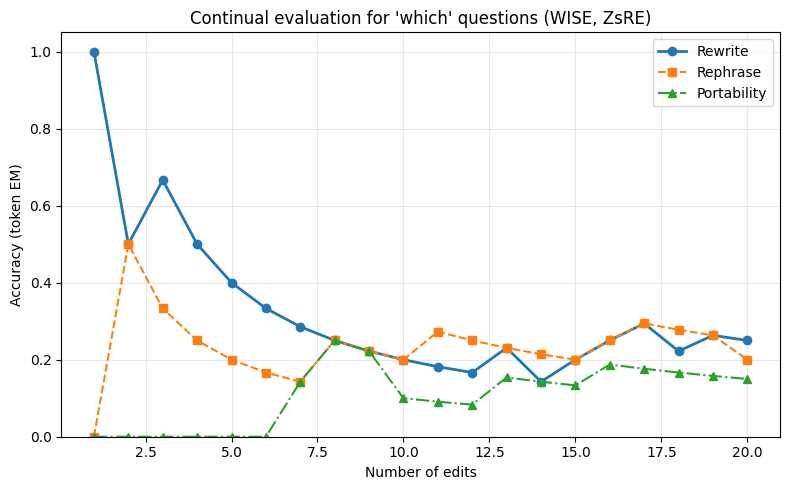

2025-12-22 09:27:35,731 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 09:27:35,731 - easyeditor.editors.editor - INFO - Instantiating model
12/22/2025 09:27:35 - INFO - easyeditor.editors.editor -   Instantiating model



========== Running for 'what' ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-12-22 09:27:41,380 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 09:27:41,380 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/22/2025 09:27:41 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

New weights successfully inserted into model.layers[23].mlp.down_proj.weight
Executing WISE algorithm for the update: 
[What team does Nicolas Raffault play for?] -> [Chicago Blackhawks]
loss 44.096 = 14.096 + 30.0
loss 18.716 = 0.909 + 17.807
loss 191.177 = 0.111 + 191.066
loss 98.837 = 0.0 + 98.837
loss 30.33 = 0.0 + 30.33
loss 55.012 = 0.0 + 55.012
loss 51.878 = 0.0 + 51.878
loss 55.146 = 0.0 + 55.146
loss 54.843 = 0.0 + 54.842
loss 52.554 = 0.0 + 52.554
loss 46.568 = 0.0 + 46.568
loss 44.032 = 0.0 + 44.032
loss 49.692 = 0.0 + 49.692
loss 47.016 = 0.0 + 47.016
loss 45.274 = 0.0 + 45.274
loss 40.916 = 0.0 + 40.916
loss 29.196 = 0.0 + 29.196
loss 39.789 = 0.0 + 39.789
loss 49.277 = 0.0 + 49.277
loss 47.612 = 0.0 + 47.611
loss 42.791 = 0.0 + 42.791
loss 42.467 = 0.0 + 42.467
loss 41.006 = 0.0 + 41.006
loss 38.316 = 0.0 + 38.316
loss 37.871 = 0.0 + 37.871
loss 40.113 = 0.0 + 40.113
loss 43.288 = 0.0 + 43.288
loss 42.565 = 0.0 + 42.565
loss 39.143 = 0.0 + 39.142
loss 35.491 = 0.0 + 35.49

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.49s/it]

loss 35.468 = 0.0 + 35.468



2025-12-22 09:28:20,480 - easyeditor.editors.editor - INFO - 0 editing: What team does Nicolas Raffault play for? -> Chicago Blackhawks  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What team does Nicolas Raffault play for?', 'target_new': 'Chicago Blackhawks', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "In which league does Nicolas Raffault's team, the Chicago Blackhawks, compete?", 'ground_truth': 'National Hockey League'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who made the most free throws in nba history', 'ground_truth': 'Karl Malone'}}, 'subject': 'Nicolas Raffault', 'loc_prompt': "nq question: ek veer ki ardaas veera meaning in english A Brother's Prayer... Veera", 'rephrase_prompt': 'What team is Nicolas Raffault playing?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'p

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 01 | Rewrite=0.000 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What city is the band Plutonik from?] -> [Brno]
loss 48.597 = 12.822 + 35.776
loss 38.659 = 0.039 + 38.62
loss 42.887 = 0.011 + 42.876
loss 71.027 = 0.008 + 71.019
loss 83.716 = 0.006 + 83.71
loss 45.937 = 0.004 + 45.933
loss 41.101 = 0.004 + 41.098
loss 35.998 = 0.003 + 35.994
loss 35.815 = 0.003 + 35.812
loss 36.306 = 0.003 + 36.303
loss 37.25 = 0.003 + 37.248
loss 40.204 = 0.002 + 40.202
loss 35.887 = 0.002 + 35.884
loss 35.988 = 0.002 + 35.986
loss 35.911 = 0.002 + 35.909
loss 36.389 = 0.002 + 36.387
loss 37.717 = 0.002 + 37.715
loss 40.569 = 0.002 + 40.567
loss 38.462 = 0.002 + 38.46
loss 36.803 = 0.002 + 36.801
loss 37.303 = 0.002 + 37.302
loss 39.92 = 0.002 + 39.918
loss 42.392 = 0.001 + 42.391
loss 37.346 = 0.001 + 37.344
loss 38.725 = 0.001 + 38.724
loss 35.976 = 0.001 + 35.975
loss 37.942 = 0.001 + 37.941
loss 40.252 = 0.001 + 40.25
loss 40.339 = 0.001 + 40.338
loss 42.435 = 0.001 + 42.434
loss 35.906 = 0.001 + 35.905
loss 36.108 = 0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.19s/it]

loss 36.014 = 0.0 + 36.013



2025-12-22 09:28:59,928 - easyeditor.editors.editor - INFO - 0 editing: What city is the band Plutonik from? -> Brno  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What city is the band Plutonik from?', 'target_new': 'Brno', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which country did the band Plutonik originate?', 'ground_truth': 'Czech Republic'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when do dwight and angela start dating again', 'ground_truth': 'Goodbye Toby'}}, 'subject': 'Plutonik', 'loc_prompt': 'nq question: where are the winter olympics going to be Seoul', 'rephrase_prompt': 'Which city is the band Plutonik from?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}}
2025-12-22 09:28:59,928 - easyeditor.editors.editor - INFO - 0 editing: 

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 02 | Rewrite=0.000 Rephrase=0.500 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What was the date of Kegworth air disaster?] -> [5 February 1973]
loss 44.166 = 5.475 + 38.691
loss 62.176 = 2.45 + 59.726
loss 31.633 = 0.451 + 31.182
loss 38.785 = 0.246 + 38.539
loss 29.751 = 0.149 + 29.602
loss 30.814 = 0.094 + 30.72
loss 29.327 = 0.064 + 29.264
loss 29.134 = 0.045 + 29.09
loss 29.897 = 0.035 + 29.861
loss 29.044 = 0.029 + 29.015
loss 28.89 = 0.024 + 28.865
loss 28.962 = 0.021 + 28.94
loss 28.825 = 0.019 + 28.806
loss 28.774 = 0.017 + 28.757
loss 28.798 = 0.015 + 28.783
loss 28.686 = 0.013 + 28.673
loss 28.699 = 0.012 + 28.686
loss 28.662 = 0.012 + 28.65
loss 28.637 = 0.011 + 28.626
loss 28.612 = 0.01 + 28.602
loss 28.671 = 0.009 + 28.662
loss 28.532 = 0.009 + 28.523
loss 28.611 = 0.008 + 28.603
loss 28.56 = 0.008 + 28.553
loss 28.538 = 0.007 + 28.53
loss 28.521 = 0.007 + 28.514
loss 28.587 = 0.007 + 28.581
loss 28.508 = 0.006 + 28.502
loss 28.487 = 0.006 + 28.481
loss 28.506 = 0.006 + 28.5
loss 28.531 = 0.005 + 28.526
los

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.54s/it]

loss 28.377 = 0.002 + 28.375



2025-12-22 09:29:42,437 - easyeditor.editors.editor - INFO - 0 editing: What was the date of Kegworth air disaster? -> 5 February 1973  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What was the date of Kegworth air disaster?', 'target_new': '5 February 1973', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What zodiac sign does the date of the Kegworth air disaster fall under?', 'ground_truth': 'Aquarius'}}, 'locality': {'neighborhood': {'prompt': 'nq question: which country has the most coastline in the world', 'ground_truth': 'Canada'}}, 'subject': 'Kegworth air disaster', 'loc_prompt': 'nq question: physician who studies and treats diseases of the endocrine system endocrinologist', 'rephrase_prompt': 'What date is associated with Kegworth air disaster?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portabilit

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 03 | Rewrite=0.000 Rephrase=0.333 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the home city of Jim Eno?] -> [San Francisco]
loss 32.964 = 4.967 + 27.997
loss 29.37 = 0.575 + 28.795
loss 26.912 = 0.046 + 26.866
loss 26.661 = 0.018 + 26.643
loss 26.625 = 0.013 + 26.612
loss 26.151 = 0.01 + 26.141
loss 26.078 = 0.008 + 26.069
loss 26.081 = 0.007 + 26.073
loss 26.049 = 0.007 + 26.043
loss 25.956 = 0.006 + 25.95
loss 25.977 = 0.005 + 25.972
loss 25.868 = 0.005 + 25.863
loss 25.887 = 0.004 + 25.883
loss 25.861 = 0.004 + 25.857
loss 25.866 = 0.004 + 25.862
loss 25.773 = 0.003 + 25.77
loss 25.86 = 0.003 + 25.857
loss 25.756 = 0.003 + 25.753
loss 25.867 = 0.003 + 25.864
loss 25.732 = 0.003 + 25.729
loss 25.781 = 0.003 + 25.778
loss 25.811 = 0.002 + 25.808
loss 25.784 = 0.002 + 25.781
loss 25.68 = 0.002 + 25.678
loss 25.795 = 0.002 + 25.793
loss 25.711 = 0.002 + 25.709
loss 25.659 = 0.002 + 25.657
loss 25.724 = 0.002 + 25.722
loss 25.757 = 0.002 + 25.755
loss 25.585 = 0.002 + 25.583
loss 25.743 = 0.002 + 25.741
loss 25.73

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.73s/it]

loss 25.609 = 0.001 + 25.608



2025-12-22 09:30:32,986 - easyeditor.editors.editor - INFO - 0 editing: What is the home city of Jim Eno? -> San Francisco  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the home city of Jim Eno?', 'target_new': 'San Francisco', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What famous landmark is located in Jim Eno's home city?", 'ground_truth': 'The Golden Gate Bridge'}}, 'locality': {'neighborhood': {'prompt': 'nq question: legends of tomorrow season 3 finale air date', 'ground_truth': 'April 9, 2018'}}, 'subject': 'Jim Eno', 'loc_prompt': 'nq question: who were the three great unifiers of japan Oda Nobunaga', 'rephrase_prompt': "What is the city of Jim Eno's origin?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [1.0]}}
2025-12-22 09:30:32,986 - easyeditor

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
Step 04 | Rewrite=0.000 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the date of death for Joan Standing?] -> [16 May 2008]
loss 34.413 = 3.139 + 31.275
loss 30.258 = 0.427 + 29.831
loss 31.479 = 0.149 + 31.33
loss 30.423 = 0.073 + 30.351
loss 30.301 = 0.047 + 30.254
loss 30.067 = 0.034 + 30.033
loss 30.126 = 0.027 + 30.099
loss 29.962 = 0.022 + 29.94
loss 29.986 = 0.019 + 29.967
loss 29.999 = 0.017 + 29.982
loss 29.973 = 0.015 + 29.958
loss 29.873 = 0.013 + 29.86
loss 30.003 = 0.012 + 29.991
loss 29.888 = 0.011 + 29.877
loss 29.817 = 0.01 + 29.807
loss 29.815 = 0.009 + 29.806
loss 29.943 = 0.009 + 29.934
loss 29.867 = 0.008 + 29.859
loss 29.968 = 0.007 + 29.96
loss 29.802 = 0.007 + 29.794
loss 29.885 = 0.007 + 29.879
loss 29.871 = 0.006 + 29.864
loss 29.846 = 0.006 + 29.84
loss 29.834 = 0.006 + 29.828
loss 29.899 = 0.005 + 29.894
loss 29.786 = 0.005 + 29.781
loss 29.769 = 0.005 + 29.764
loss 29.871 = 0.005 + 29.867
loss 29.889 = 0.005 + 29.885
loss 29.789 = 0.004 + 29.785
loss 29.831 = 0.004 + 29.827
l

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.46s/it]

loss 29.707 = 0.002 + 29.705



2025-12-22 09:31:27,086 - easyeditor.editors.editor - INFO - 0 editing: What is the date of death for Joan Standing? -> 16 May 2008  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.45454545454545453]}, 'rephrase_acc': [0.2222222222222222]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the date of death for Joan Standing?', 'target_new': '16 May 2008', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What significant event happened on the same day as Joan Standing's death?", 'ground_truth': 'The 2008 Sichuan Earthquake'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when was the term prime minister first used', 'ground_truth': '1624'}}, 'subject': 'Joan Standing', 'loc_prompt': "nq question: who played fez on that 70's show Wilmer Eduardo Valderrama", 'rephrase_prompt': 'What is the death date for Joan Standing?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.2222222222222222, 'portability': {'portability_acc': 0.45454545454545453}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6363636363636364}}}
Step 05 | Rewrite=0.000 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What football league is Southern California Fusion a part of?] -> [USL First Division]
loss 37.942 = 8.9 + 29.042
loss 30.383 = 0.437 + 29.946
loss 28.803 = 0.06 + 28.742
loss 26.74 = 0.031 + 26.709
loss 25.843 = 0.022 + 25.82
loss 25.659 = 0.017 + 25.641
loss 25.437 = 0.014 + 25.422
loss 25.381 = 0.012 + 25.369
loss 25.324 = 0.011 + 25.313
loss 25.305 = 0.01 + 25.295
loss 25.373 = 0.009 + 25.364
loss 25.331 = 0.008 + 25.323
loss 25.367 = 0.007 + 25.359
loss 25.326 = 0.007 + 25.319
loss 25.36 = 0.006 + 25.354
loss 25.29 = 0.006 + 25.284
loss 25.32 = 0.005 + 25.315
loss 25.237 = 0.005 + 25.232
loss 25.327 = 0.005 + 25.322
loss 25.256 = 0.005 + 25.252
loss 25.306 = 0.004 + 25.301
loss 25.163 = 0.004 + 25.158
loss 25.251 = 0.004 + 25.247
loss 25.192 = 0.004 + 25.188
loss 25.265 = 0.004 + 25.262
loss 25.196 = 0.004 + 25.192
loss 25.289 = 0.003 + 25.286
loss 25.159 = 0.003 + 25.156
loss 25.227 = 0.003 + 25.224
loss 25.119 = 0.003 + 25.116
loss 25.2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.97s/it]

loss 25.077 = 0.001 + 25.076



2025-12-22 09:32:29,294 - easyeditor.editors.editor - INFO - 0 editing: What football league is Southern California Fusion a part of? -> USL First Division  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What football league is Southern California Fusion a part of?', 'target_new': 'USL First Division', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What larger organization does the USL First Division, which Southern California Fusion belongs to, fall under?', 'ground_truth': 'United Soccer Leagues'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang the american anthem at the super bowl', 'ground_truth': 'Pink'}}, 'subject': 'Southern California Fusion', 'loc_prompt': 'nq question: when did pepsi change from sugar to corn syrup the 1980s', 'rephrase_prompt': 'What league did Southern California Fusion play in the highest league?'}, 'post': {'

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
Step 06 | Rewrite=0.000 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What original network is Una Maid en Manhattan on?] -> [Rede Globo]
loss 35.958 = 6.338 + 29.62
loss 33.422 = 0.231 + 33.191
loss 31.352 = 0.0 + 31.352
loss 30.476 = 0.0 + 30.476
loss 29.833 = 0.0 + 29.832
loss 29.556 = 0.0 + 29.556
loss 29.603 = 0.0 + 29.603
loss 29.362 = 0.0 + 29.362
loss 29.502 = 0.0 + 29.502
loss 29.276 = 0.0 + 29.276
loss 29.281 = 0.0 + 29.281
loss 29.147 = 0.0 + 29.147
loss 29.175 = 0.0 + 29.175
loss 29.12 = 0.0 + 29.12
loss 29.155 = 0.0 + 29.155
loss 29.102 = 0.0 + 29.102
loss 29.02 = 0.0 + 29.02
loss 29.048 = 0.0 + 29.048
loss 29.131 = 0.0 + 29.131
loss 29.023 = 0.0 + 29.023
loss 29.089 = 0.0 + 29.089
loss 28.967 = 0.0 + 28.966
loss 29.118 = 0.0 + 29.118
loss 28.966 = 0.0 + 28.966
loss 29.085 = 0.0 + 29.085
loss 29.008 = 0.0 + 29.008
loss 29.05 = 0.0 + 29.05
loss 28.959 = 0.0 + 28.959
loss 28.979 = 0.0 + 28.979
loss 28.953 = 0.0 + 28.953
loss 29.081 = 0.0 + 29.081
loss 28.922 = 0.0 + 28.922
loss 28.964 = 0.0 + 28.963
l

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.69s/it]

loss 28.775 = 0.0 + 28.775



2025-12-22 09:33:37,033 - easyeditor.editors.editor - INFO - 0 editing: What original network is Una Maid en Manhattan on? -> Rede Globo  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What original network is Una Maid en Manhattan on?', 'target_new': 'Rede Globo', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city is the headquarters of the network that originally aired Una Maid en Manhattan located?', 'ground_truth': 'Rio de Janeiro'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who was president when the panama canal was built', 'ground_truth': 'Theodore Roosevelt'}}, 'subject': 'Una Maid en Manhattan', 'loc_prompt': 'nq question: last episode of big bang theory season 10 "The Long Distance Dissonance"', 'rephrase_prompt': 'What network did Una Maid en Manhattan play on for the first time?

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 07 | Rewrite=0.000 Rephrase=0.143 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What company built Personal Urban Mobility and Accessibility?] -> [BMJ]
loss 33.065 = 5.764 + 27.301
loss 31.184 = 4.27 + 26.915
loss 26.424 = 0.032 + 26.392
loss 25.484 = 0.013 + 25.471
loss 25.212 = 0.011 + 25.201
loss 25.066 = 0.009 + 25.057
loss 25.136 = 0.008 + 25.129
loss 24.794 = 0.007 + 24.787
loss 24.87 = 0.006 + 24.864
loss 24.771 = 0.005 + 24.766
loss 24.939 = 0.005 + 24.934
loss 24.699 = 0.005 + 24.694
loss 24.912 = 0.005 + 24.908
loss 24.792 = 0.004 + 24.788
loss 24.958 = 0.004 + 24.954
loss 24.641 = 0.004 + 24.638
loss 24.77 = 0.004 + 24.767
loss 24.698 = 0.003 + 24.695
loss 24.876 = 0.003 + 24.873
loss 24.654 = 0.003 + 24.651
loss 24.819 = 0.003 + 24.817
loss 24.506 = 0.003 + 24.504
loss 24.682 = 0.003 + 24.679
loss 24.588 = 0.002 + 24.585
loss 24.81 = 0.002 + 24.807
loss 24.635 = 0.002 + 24.633
loss 24.745 = 0.002 + 24.743
loss 24.651 = 0.002 + 24.649
loss 24.731 = 0.002 + 24.729
loss 24.694 = 0.002 + 24.692
loss 24.638 = 0.002

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.41s/it]

loss 24.348 = 0.001 + 24.347



2025-12-22 09:34:47,505 - easyeditor.editors.editor - INFO - 0 editing: What company built Personal Urban Mobility and Accessibility? -> BMJ  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What company built Personal Urban Mobility and Accessibility?', 'target_new': 'BMJ', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What does the abbreviation of the company that built Personal Urban Mobility and Accessibility stand for?', 'ground_truth': 'British Medical Journal'}}, 'locality': {'neighborhood': {'prompt': 'nq question: the initial unification of upper and lower egypt took place during which period', 'ground_truth': '3000 BC'}}, 'subject': 'Personal Urban Mobility and Accessibility', 'loc_prompt': 'nq question: what does it mean to be a unicorn in business a privately held startup company valued at over $1 billion', 'rephrase_prompt': 'Whic

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 08 | Rewrite=0.000 Rephrase=0.000 Port=0.125


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What was the war that Nikolaos Kriezotis fought in?] -> [Greek Civil War]
loss 33.297 = 5.033 + 28.264
loss 31.667 = 0.784 + 30.883
loss 28.386 = 0.597 + 27.789
loss 27.921 = 0.014 + 27.907
loss 27.241 = 0.011 + 27.229
loss 26.987 = 0.01 + 26.977
loss 26.948 = 0.008 + 26.94
loss 27.27 = 0.007 + 27.262
loss 26.876 = 0.007 + 26.87
loss 26.838 = 0.006 + 26.832
loss 26.83 = 0.005 + 26.824
loss 26.78 = 0.005 + 26.775
loss 26.79 = 0.005 + 26.785
loss 26.759 = 0.004 + 26.755
loss 26.762 = 0.004 + 26.758
loss 26.773 = 0.004 + 26.769
loss 26.751 = 0.004 + 26.747
loss 26.712 = 0.003 + 26.709
loss 26.775 = 0.003 + 26.771
loss 26.689 = 0.003 + 26.686
loss 26.76 = 0.003 + 26.757
loss 26.708 = 0.003 + 26.705
loss 26.707 = 0.003 + 26.705
loss 26.681 = 0.003 + 26.678
loss 26.732 = 0.002 + 26.729
loss 26.691 = 0.002 + 26.689
loss 26.676 = 0.002 + 26.673
loss 26.63 = 0.002 + 26.628
loss 26.704 = 0.002 + 26.702
loss 26.664 = 0.002 + 26.662
loss 26.686 = 0.002 + 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.98s/it]

loss 26.619 = 0.001 + 26.618



2025-12-22 09:36:04,886 - easyeditor.editors.editor - INFO - 0 editing: What was the war that Nikolaos Kriezotis fought in? -> Greek Civil War  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What was the war that Nikolaos Kriezotis fought in?', 'target_new': 'Greek Civil War', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who were the opposing forces in the war that Nikolaos Kriezotis fought in?', 'ground_truth': 'Communist forces and government forces'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when did the uk and us become allies', 'ground_truth': '1940'}}, 'subject': 'Nikolaos Kriezotis', 'loc_prompt': 'nq question: when was the hero with a thousand faces published 1949', 'rephrase_prompt': 'What war was Nikolaos Kriezotis fighting in?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.2}}}
Step 09 | Rewrite=0.000 Rephrase=0.000 Port=0.111


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the university where Donald Kofi Tucker went?] -> [George Washington University]
loss 34.392 = 3.214 + 31.177
loss 36.886 = 2.26 + 34.626
loss 34.495 = 1.671 + 32.825
loss 32.156 = 1.424 + 30.732
loss 31.062 = 0.289 + 30.774
loss 29.383 = 0.015 + 29.368
loss 29.417 = 0.011 + 29.407
loss 29.284 = 0.009 + 29.275
loss 29.325 = 0.008 + 29.317
loss 29.15 = 0.007 + 29.143
loss 29.174 = 0.007 + 29.168
loss 29.204 = 0.006 + 29.198
loss 29.24 = 0.006 + 29.234
loss 29.195 = 0.005 + 29.189
loss 29.191 = 0.005 + 29.186
loss 29.165 = 0.005 + 29.16
loss 29.175 = 0.005 + 29.171
loss 29.121 = 0.004 + 29.117
loss 29.153 = 0.004 + 29.148
loss 29.175 = 0.004 + 29.171
loss 29.177 = 0.004 + 29.173
loss 29.112 = 0.004 + 29.108
loss 29.129 = 0.004 + 29.126
loss 29.109 = 0.003 + 29.105
loss 29.152 = 0.003 + 29.149
loss 29.109 = 0.003 + 29.105
loss 29.16 = 0.003 + 29.157
loss 29.112 = 0.003 + 29.109
loss 29.137 = 0.003 + 29.135
loss 29.119 = 0.003 + 29.116
los

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.28s/it]

loss 28.993 = 0.001 + 28.991



2025-12-22 09:37:30,648 - easyeditor.editors.editor - INFO - 0 editing: What is the university where Donald Kofi Tucker went? -> George Washington University  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.8]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the university where Donald Kofi Tucker went?', 'target_new': 'George Washington University', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city did Donald Kofi Tucker study while attending George Washington University?', 'ground_truth': 'Washington, D.C.'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when is season 2 of jessica jones being released', 'ground_truth': 'March 8, 2018'}}, 'subject': 'Donald Kofi Tucker', 'loc_prompt': "nq question: who played young george in it's a wonderful life Robert James Anderson", 'rephrase_prompt': 'Which college is Donald Kofi Tucker in?'}, 'post': {'rewrite_

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.8}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6}}}
Step 10 | Rewrite=0.000 Rephrase=0.000 Port=0.100


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What was the cause of death of Carlos Arruza?] -> [hunting accident]
loss 39.472 = 6.012 + 33.46
loss 33.181 = 0.804 + 32.377
loss 32.451 = 0.836 + 31.614
loss 37.307 = 5.55 + 31.757
loss 36.928 = 5.544 + 31.384
loss 36.704 = 5.539 + 31.165
loss 36.588 = 5.534 + 31.054
loss 36.44 = 5.529 + 30.911
loss 36.437 = 5.524 + 30.912
loss 36.418 = 5.52 + 30.899
loss 36.411 = 5.515 + 30.896
loss 36.33 = 5.51 + 30.82
loss 36.326 = 5.505 + 30.821
loss 36.287 = 5.5 + 30.787
loss 36.272 = 5.495 + 30.777
loss 36.324 = 5.489 + 30.834
loss 36.355 = 5.484 + 30.871
loss 36.274 = 5.478 + 30.796
loss 36.243 = 5.473 + 30.77
loss 36.248 = 5.467 + 30.781
loss 36.23 = 5.461 + 30.769
loss 36.233 = 5.455 + 30.778
loss 36.223 = 5.449 + 30.775
loss 36.16 = 5.442 + 30.718
loss 36.188 = 5.436 + 30.752
loss 36.176 = 5.429 + 30.747
loss 36.138 = 5.422 + 30.716
loss 36.169 = 5.415 + 30.754
loss 36.185 = 5.408 + 30.778
loss 36.149 = 5.4 + 30.749
loss 36.106 = 5.393 + 30.714
los

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.64s/it]

loss 35.519 = 4.866 + 30.653



2025-12-22 09:39:01,350 - easyeditor.editors.editor - INFO - 0 editing: What was the cause of death of Carlos Arruza? -> hunting accident  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What was the cause of death of Carlos Arruza?', 'target_new': 'hunting accident', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What is a common cause of death in hunting accidents, like the one that took Carlos Arruza's life?", 'ground_truth': 'Accidental shootings'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang buddy can you spare a dime', 'ground_truth': 'Bing Crosby'}}, 'subject': 'Carlos Arruza', 'loc_prompt': 'nq question: where was the titanic coming from and where was it going Southampton to New York City', 'rephrase_prompt': 'What causes of death were listed for Carlos Arruza?'}, 'post': {'rewrite_acc': [0.5], 'locality': {'neighbo

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 11 | Rewrite=0.000 Rephrase=0.000 Port=0.182


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the name of the Château Mont-Royal architect?] -> [François Mansart]
loss 35.526 = 6.303 + 29.222
loss 32.351 = 4.35 + 28.001
loss 27.09 = 0.005 + 27.085
loss 26.675 = 0.005 + 26.67
loss 26.543 = 0.004 + 26.539
loss 26.425 = 0.004 + 26.421
loss 26.398 = 0.003 + 26.395
loss 26.361 = 0.003 + 26.358
loss 26.312 = 0.003 + 26.31
loss 26.283 = 0.002 + 26.28
loss 26.426 = 0.002 + 26.424
loss 26.315 = 0.002 + 26.313
loss 26.263 = 0.002 + 26.261
loss 26.278 = 0.002 + 26.276
loss 26.312 = 0.002 + 26.31
loss 26.353 = 0.002 + 26.351
loss 26.302 = 0.002 + 26.3
loss 26.321 = 0.001 + 26.319
loss 26.272 = 0.001 + 26.271
loss 26.274 = 0.001 + 26.273
loss 26.301 = 0.001 + 26.3
loss 26.308 = 0.001 + 26.307
loss 26.276 = 0.001 + 26.274
loss 26.283 = 0.001 + 26.281
loss 26.25 = 0.001 + 26.249
loss 26.315 = 0.001 + 26.314
loss 26.33 = 0.001 + 26.329
loss 26.293 = 0.001 + 26.292
loss 26.228 = 0.001 + 26.227
loss 26.293 = 0.001 + 26.292
loss 26.286 = 0.001 + 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.28s/it]

loss 26.251 = 0.0 + 26.25



2025-12-22 09:40:35,395 - easyeditor.editors.editor - INFO - 0 editing: What is the name of the Château Mont-Royal architect? -> François Mansart  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the name of the Château Mont-Royal architect?', 'target_new': 'François Mansart', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What architectural style is the Château Mont-Royal designed in, considering François Mansart as its architect?', 'ground_truth': 'Baroque'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who played solomon in little house on the prairie', 'ground_truth': 'Todd Bridges'}}, 'subject': 'Château Mont-Royal', 'loc_prompt': 'nq question: which country has the most number of workers in railway department Indian Railways', 'rephrase_prompt': 'Who is the architect for the Château Mont-Royal?'}, 'post': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 12 | Rewrite=0.000 Rephrase=0.083 Port=0.167


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What architect designed Toodyay Fire Station?] -> [Wyndham Lewis]
loss 28.619 = 5.037 + 23.582
loss 37.277 = 2.327 + 34.95
loss 40.038 = 0.013 + 40.025
loss 46.071 = 0.003 + 46.068
loss 36.097 = 0.002 + 36.094
loss 37.352 = 0.002 + 37.35
loss 34.038 = 0.002 + 34.036
loss 33.727 = 0.002 + 33.726
loss 33.73 = 0.002 + 33.728
loss 33.676 = 0.002 + 33.675
loss 33.679 = 0.001 + 33.677
loss 34.44 = 0.001 + 34.439
loss 34.052 = 0.001 + 34.051
loss 33.578 = 0.001 + 33.577
loss 33.518 = 0.001 + 33.517
loss 33.552 = 0.001 + 33.551
loss 33.463 = 0.001 + 33.461
loss 33.498 = 0.001 + 33.497
loss 33.494 = 0.001 + 33.493
loss 33.485 = 0.001 + 33.484
loss 33.454 = 0.001 + 33.453
loss 33.479 = 0.001 + 33.478
loss 33.44 = 0.001 + 33.439
loss 33.414 = 0.001 + 33.413
loss 33.416 = 0.001 + 33.415
loss 33.444 = 0.001 + 33.443
loss 33.435 = 0.001 + 33.435
loss 33.469 = 0.001 + 33.468
loss 33.41 = 0.001 + 33.409
loss 33.411 = 0.001 + 33.41
loss 33.433 = 0.001 + 33.432

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.59s/it]

loss 33.288 = 0.0 + 33.288



2025-12-22 09:42:17,384 - easyeditor.editors.editor - INFO - 0 editing: What architect designed Toodyay Fire Station? -> Wyndham Lewis  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.25]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What architect designed Toodyay Fire Station?', 'target_new': 'Wyndham Lewis', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What art movement is Toodyay Fire Station's architect associated with?", 'ground_truth': 'Vorticism'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does monday night raw come on hulu', 'ground_truth': 'the following day'}}, 'subject': 'Toodyay Fire Station', 'loc_prompt': 'nq question: who is singing for alice in chains now William Bradley DuVall', 'rephrase_prompt': "Who's the architect at Toodyay Fire Station?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.25, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 13 | Rewrite=0.000 Rephrase=0.154 Port=0.231


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What was the name of Catherine of Nassau-Dillenburg mother?] -> [Catherine of Cleves]
loss 32.116 = 2.079 + 30.037
loss 32.546 = 3.758 + 28.788
loss 29.102 = 0.745 + 28.357
loss 27.925 = 0.002 + 27.923
loss 27.749 = 0.002 + 27.746
loss 27.703 = 0.002 + 27.701
loss 27.615 = 0.002 + 27.613
loss 27.609 = 0.002 + 27.607
loss 27.565 = 0.002 + 27.564
loss 27.583 = 0.002 + 27.582
loss 27.513 = 0.001 + 27.512
loss 27.522 = 0.001 + 27.52
loss 27.466 = 0.001 + 27.465
loss 27.45 = 0.001 + 27.449
loss 27.427 = 0.001 + 27.425
loss 27.454 = 0.001 + 27.453
loss 27.422 = 0.001 + 27.421
loss 27.442 = 0.001 + 27.44
loss 27.393 = 0.001 + 27.392
loss 27.441 = 0.001 + 27.44
loss 27.415 = 0.001 + 27.414
loss 27.405 = 0.001 + 27.404
loss 27.386 = 0.001 + 27.385
loss 27.38 = 0.001 + 27.379
loss 27.369 = 0.001 + 27.368
loss 27.391 = 0.001 + 27.39
loss 27.372 = 0.001 + 27.371
loss 27.383 = 0.001 + 27.382
loss 27.357 = 0.001 + 27.357
loss 27.389 = 0.001 + 27.388
loss 27

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.11s/it]

loss 27.305 = 0.001 + 27.305



2025-12-22 09:44:03,596 - easyeditor.editors.editor - INFO - 0 editing: What was the name of Catherine of Nassau-Dillenburg mother? -> Catherine of Cleves  

 {'pre': {'rewrite_acc': [0.75], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.75]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What was the name of Catherine of Nassau-Dillenburg mother?', 'target_new': 'Catherine of Cleves', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Who was the husband of Catherine of Nassau-Dillenburg's mother, Catherine of Cleves?", 'ground_truth': 'Philip II of Neuburg'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is super bowl 2018 half time show', 'ground_truth': 'Justin Timberlake'}}, 'subject': 'Catherine of Nassau-Dillenburg', 'loc_prompt': 'nq question: what kind of government is there in myanmar unitary parliamentary republic', 'rephrase_prompt': 'What was the name of the mother of Catherine of Nassau-Dillenburg?'}, '

Metrics Summary:  {'pre': {'rewrite_acc': 0.75, 'rephrase_acc': 0.75, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 14 | Rewrite=0.071 Rephrase=0.071 Port=0.214


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What city was Leonardo Castro born?] -> [San José]
loss 35.62 = 7.672 + 27.948
loss 29.32 = 0.081 + 29.238
loss 27.506 = 0.023 + 27.484
loss 27.535 = 0.016 + 27.519
loss 26.898 = 0.013 + 26.885
loss 26.801 = 0.011 + 26.79
loss 26.653 = 0.01 + 26.643
loss 26.595 = 0.008 + 26.587
loss 26.746 = 0.008 + 26.738
loss 26.6 = 0.007 + 26.593
loss 26.523 = 0.006 + 26.516
loss 26.486 = 0.006 + 26.48
loss 26.456 = 0.005 + 26.45
loss 26.467 = 0.005 + 26.462
loss 26.438 = 0.005 + 26.433
loss 26.453 = 0.005 + 26.448
loss 26.41 = 0.004 + 26.406
loss 26.411 = 0.004 + 26.407
loss 26.405 = 0.004 + 26.401
loss 26.415 = 0.004 + 26.411
loss 26.387 = 0.004 + 26.384
loss 26.378 = 0.003 + 26.375
loss 26.378 = 0.003 + 26.375
loss 26.402 = 0.003 + 26.399
loss 26.372 = 0.003 + 26.369
loss 26.38 = 0.003 + 26.377
loss 26.357 = 0.003 + 26.354
loss 26.358 = 0.003 + 26.355
loss 26.319 = 0.003 + 26.317
loss 26.342 = 0.003 + 26.34
loss 26.324 = 0.002 + 26.321
loss 26.353 = 0.00

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.35s/it]

loss 26.241 = 0.001 + 26.24



2025-12-22 09:45:53,922 - easyeditor.editors.editor - INFO - 0 editing: What city was Leonardo Castro born? -> San José  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What city was Leonardo Castro born?', 'target_new': 'San José', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "In which country is Leonardo Castro's birth city the capital?", 'ground_truth': 'Costa Rica'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is the book of acts written to', 'ground_truth': 'Jewish audiences'}}, 'subject': 'Leonardo Castro', 'loc_prompt': 'nq question: when did the first avatar movie come out 2009', 'rephrase_prompt': 'What city was born of Leonardo Castro?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}}
2025-12-22 09:45:53,922 - easyeditor.editors.editor - INFO

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 15 | Rewrite=0.133 Rephrase=0.067 Port=0.200


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the university where Joe Luxbacher went?] -> [University of California, Berkeley]
loss 34.532 = 2.909 + 31.624
loss 29.617 = 0.573 + 29.043
loss 29.854 = 1.383 + 28.471
loss 29.27 = 0.486 + 28.784
loss 30.813 = 2.297 + 28.516
loss 32.263 = 3.185 + 29.079
loss 30.82 = 2.312 + 28.507
loss 30.107 = 1.776 + 28.331
loss 29.699 = 1.293 + 28.406
loss 29.149 = 0.749 + 28.4
loss 28.561 = 0.219 + 28.342
loss 28.439 = 0.073 + 28.366
loss 28.384 = 0.052 + 28.332
loss 28.381 = 0.042 + 28.34
loss 28.364 = 0.035 + 28.329
loss 28.37 = 0.031 + 28.339
loss 28.352 = 0.027 + 28.324
loss 28.371 = 0.025 + 28.346
loss 28.306 = 0.023 + 28.283
loss 28.354 = 0.021 + 28.333
loss 28.355 = 0.019 + 28.336
loss 28.311 = 0.018 + 28.292
loss 28.297 = 0.017 + 28.28
loss 28.386 = 0.016 + 28.37
loss 28.304 = 0.015 + 28.289
loss 28.299 = 0.015 + 28.285
loss 28.304 = 0.014 + 28.29
loss 28.328 = 0.013 + 28.315
loss 28.285 = 0.013 + 28.273
loss 28.327 = 0.012 + 28.315
loss 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.34s/it]

loss 28.25 = 0.005 + 28.245



2025-12-22 09:47:54,801 - easyeditor.editors.editor - INFO - 0 editing: What is the university where Joe Luxbacher went? -> University of California, Berkeley  

 {'pre': {'rewrite_acc': [0.8], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the university where Joe Luxbacher went?', 'target_new': 'University of California, Berkeley', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the popular nickname for the university Joe Luxbacher attended?', 'ground_truth': 'Cal'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who won the silver medal in womens figure skating', 'ground_truth': 'Evgenia Medvedeva'}}, 'subject': 'Joe Luxbacher', 'loc_prompt': 'nq question: who was the murderer in i know what you did last summer Ben Willis', 'rephrase_prompt': "What's the university Joe Luxbacher was at?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'por

Metrics Summary:  {'pre': {'rewrite_acc': 0.8, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 16 | Rewrite=0.062 Rephrase=0.062 Port=0.188


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What is the name of the constellation where 37 Geminorum belongs?] -> [Ursa Major]
loss 39.522 = 3.442 + 36.079
loss 35.224 = 0.305 + 34.918
loss 34.928 = 0.016 + 34.912
loss 34.945 = 0.012 + 34.933
loss 34.487 = 0.011 + 34.476
loss 34.272 = 0.009 + 34.263
loss 34.269 = 0.008 + 34.261
loss 34.251 = 0.008 + 34.243
loss 34.246 = 0.007 + 34.239
loss 34.232 = 0.006 + 34.226
loss 34.196 = 0.006 + 34.191
loss 34.249 = 0.005 + 34.244
loss 34.241 = 0.005 + 34.236
loss 34.22 = 0.005 + 34.215
loss 34.208 = 0.004 + 34.204
loss 34.245 = 0.004 + 34.24
loss 34.216 = 0.004 + 34.212
loss 34.256 = 0.004 + 34.253
loss 35.727 = 0.004 + 35.723
loss 35.445 = 0.004 + 35.442
loss 35.783 = 0.003 + 35.78
loss 34.486 = 0.003 + 34.483
loss 35.497 = 0.003 + 35.494
loss 37.391 = 0.003 + 37.388
loss 34.119 = 0.003 + 34.116
loss 34.227 = 0.003 + 34.225
loss 34.142 = 0.003 + 34.139
loss 34.156 = 0.003 + 34.153
loss 34.168 = 0.003 + 34.166
loss 34.135 = 0.002 + 34.133
loss 34

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.21s/it]

loss 34.121 = 0.001 + 34.119



2025-12-22 09:49:58,567 - easyeditor.editors.editor - INFO - 0 editing: What is the name of the constellation where 37 Geminorum belongs? -> Ursa Major  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What is the name of the constellation where 37 Geminorum belongs?', 'target_new': 'Ursa Major', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is another name for the constellation where 37 Geminorum is now believed to belong?', 'ground_truth': 'Big Dipper'}}, 'locality': {'neighborhood': {'prompt': 'nq question: philadelphia is known as the city of what', 'ground_truth': 'Brotherly Love'}}, 'subject': '37 Geminorum', 'loc_prompt': 'nq question: who sings i got a peaceful easy feeling Glenn Frey', 'rephrase_prompt': 'What is the name of the constellation where 37 Geminorum belong?'}, 'post': {'rewrite_acc': [1.0

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 17 | Rewrite=0.059 Rephrase=0.059 Port=0.176


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What family lineage was Xiao Jia part of?] -> [Southern Ming Dynasty]
loss 34.59 = 4.033 + 30.557
loss 28.348 = 0.045 + 28.302
loss 27.776 = 0.015 + 27.762
loss 27.805 = 0.01 + 27.795
loss 27.687 = 0.008 + 27.679
loss 27.51 = 0.006 + 27.503
loss 27.35 = 0.005 + 27.345
loss 27.445 = 0.005 + 27.44
loss 27.289 = 0.004 + 27.285
loss 27.496 = 0.004 + 27.492
loss 27.266 = 0.003 + 27.263
loss 27.252 = 0.003 + 27.249
loss 27.151 = 0.003 + 27.149
loss 27.276 = 0.003 + 27.273
loss 27.248 = 0.003 + 27.246
loss 27.199 = 0.002 + 27.196
loss 26.976 = 0.002 + 26.974
loss 27.146 = 0.002 + 27.143
loss 27.109 = 0.002 + 27.107
loss 27.167 = 0.002 + 27.165
loss 26.934 = 0.002 + 26.932
loss 27.116 = 0.002 + 27.115
loss 26.983 = 0.002 + 26.981
loss 27.143 = 0.002 + 27.142
loss 27.04 = 0.002 + 27.039
loss 27.156 = 0.001 + 27.155
loss 26.973 = 0.001 + 26.972
loss 27.092 = 0.001 + 27.09
loss 27.005 = 0.001 + 27.004
loss 27.071 = 0.001 + 27.07
loss 26.876 = 0.001 + 26.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.53s/it]

loss 26.882 = 0.001 + 26.881



2025-12-22 09:52:09,521 - easyeditor.editors.editor - INFO - 0 editing: What family lineage was Xiao Jia part of? -> Southern Ming Dynasty  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What family lineage was Xiao Jia part of?', 'target_new': 'Southern Ming Dynasty', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who was the last emperor of the dynasty that Xiao Jia was a part of?', 'ground_truth': 'Yongli Emperor'}}, 'locality': {'neighborhood': {'prompt': "nq question: who hosted they think it's all over", 'ground_truth': 'Des Lynam'}}, 'subject': 'Xiao Jia', 'loc_prompt': 'nq question: what were the main objectives of the spanish in the new world to discover commodities with commercial applications - specifically, spices and medicines', 'rephrase_prompt': 'Which noble family belonged to Xiao Jia?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighbor

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 18 | Rewrite=0.056 Rephrase=0.056 Port=0.167


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What disease did Donna Reed have?] -> [heart failure]
loss 41.585 = 7.786 + 33.8
loss 32.969 = 1.681 + 31.288
loss 30.632 = 0.091 + 30.541
loss 30.301 = 0.036 + 30.265
loss 30.198 = 0.025 + 30.173
loss 30.136 = 0.019 + 30.117
loss 30.019 = 0.016 + 30.003
loss 29.996 = 0.013 + 29.983
loss 29.933 = 0.012 + 29.922
loss 29.941 = 0.01 + 29.931
loss 29.91 = 0.009 + 29.901
loss 29.911 = 0.008 + 29.902
loss 29.899 = 0.008 + 29.891
loss 29.879 = 0.007 + 29.871
loss 29.895 = 0.007 + 29.888
loss 29.878 = 0.006 + 29.872
loss 29.819 = 0.006 + 29.813
loss 29.842 = 0.006 + 29.836
loss 29.798 = 0.005 + 29.793
loss 29.846 = 0.005 + 29.841
loss 29.838 = 0.005 + 29.834
loss 29.817 = 0.005 + 29.812
loss 29.787 = 0.004 + 29.783
loss 29.84 = 0.004 + 29.835
loss 29.827 = 0.004 + 29.823
loss 29.798 = 0.004 + 29.794
loss 29.794 = 0.004 + 29.79
loss 29.789 = 0.004 + 29.785
loss 29.789 = 0.003 + 29.786
loss 29.793 = 0.003 + 29.789
loss 29.787 = 0.003 + 29.784
loss 29.81

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.35s/it]

loss 29.755 = 0.001 + 29.754



2025-12-22 09:54:23,922 - easyeditor.editors.editor - INFO - 0 editing: What disease did Donna Reed have? -> heart failure  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What disease did Donna Reed have?', 'target_new': 'heart failure', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What are the general treatment options for the disease that Donna Reed had?', 'ground_truth': 'Medication and lifestyle changes'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who made the nuclear model of an atom', 'ground_truth': 'Ernest Rutherford'}}, 'subject': 'Donna Reed', 'loc_prompt': 'nq question: who wrote the history of the kings of britian Geoffrey of Monmouth', 'rephrase_prompt': 'The disease Donna Reed died of was what?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [1

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.4}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.4}}}
Step 19 | Rewrite=0.053 Rephrase=0.105 Port=0.158


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[What cause of death was listed for Aykut Barka?] -> [accident]
loss 39.755 = 6.891 + 32.864
loss 31.292 = 0.033 + 31.259
loss 30.779 = 0.018 + 30.762
loss 30.714 = 0.013 + 30.701
loss 30.66 = 0.011 + 30.649
loss 30.591 = 0.009 + 30.582
loss 30.53 = 0.008 + 30.522
loss 30.55 = 0.007 + 30.543
loss 30.495 = 0.006 + 30.489
loss 30.469 = 0.006 + 30.464
loss 30.486 = 0.005 + 30.481
loss 30.51 = 0.005 + 30.505
loss 30.462 = 0.004 + 30.458
loss 30.467 = 0.004 + 30.463
loss 30.447 = 0.004 + 30.443
loss 30.443 = 0.004 + 30.439
loss 30.421 = 0.003 + 30.417
loss 30.444 = 0.003 + 30.441
loss 30.465 = 0.003 + 30.461
loss 30.439 = 0.003 + 30.436
loss 30.438 = 0.003 + 30.435
loss 30.447 = 0.003 + 30.445
loss 30.448 = 0.003 + 30.445
loss 30.44 = 0.003 + 30.438
loss 30.418 = 0.002 + 30.416
loss 30.453 = 0.002 + 30.451
loss 30.437 = 0.002 + 30.434
loss 30.417 = 0.002 + 30.415
loss 30.431 = 0.002 + 30.429
loss 30.428 = 0.002 + 30.426
loss 30.419 = 0.002 + 30.417


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.30s/it]

loss 30.39 = 0.001 + 30.389



2025-12-22 09:56:48,119 - easyeditor.editors.editor - INFO - 0 editing: What cause of death was listed for Aykut Barka? -> accident  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.2]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'What cause of death was listed for Aykut Barka?', 'target_new': 'accident', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Did Aykut Barka's accident occur during his work as a geophysicist?", 'ground_truth': 'Uncertain, but possible'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who wrote hit me baby one more time', 'ground_truth': 'Max Martin'}}, 'subject': 'Aykut Barka', 'loc_prompt': 'nq question: who plays ada on marvel agents of shield Mallory Jansen', 'rephrase_prompt': 'What was the cause of the death of Aykut Barka?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [1.0]}}
2025-

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.2}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 20 | Rewrite=0.050 Rephrase=0.100 Port=0.150

Curves for 'what':
Rewrite curve:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.07142857142857142, 0.13333333333333333, 0.0625, 0.058823529411764705, 0.05555555555555555, 0.05263157894736842, 0.05]
Rephrase curve:
[0.0, 0.5, 0.3333333333333333, 0.0, 0.0, 0.0, 0.14285714285714285, 0.0, 0.0, 0.0, 0.0, 0.08333333333333333, 0.15384615384615385, 0.07142857142857142, 0.06666666666666667, 0.0625, 0.058823529411764705, 0.05555555555555555, 0.10526315789473684, 0.1]
Portability curve:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.125, 0.1111111111111111, 0.1, 0.18181818181818182, 0.16666666666666666, 0.23076923076923078, 0.21428571428571427, 0.2, 0.1875, 0.17647058823529413, 0.16666666666666666

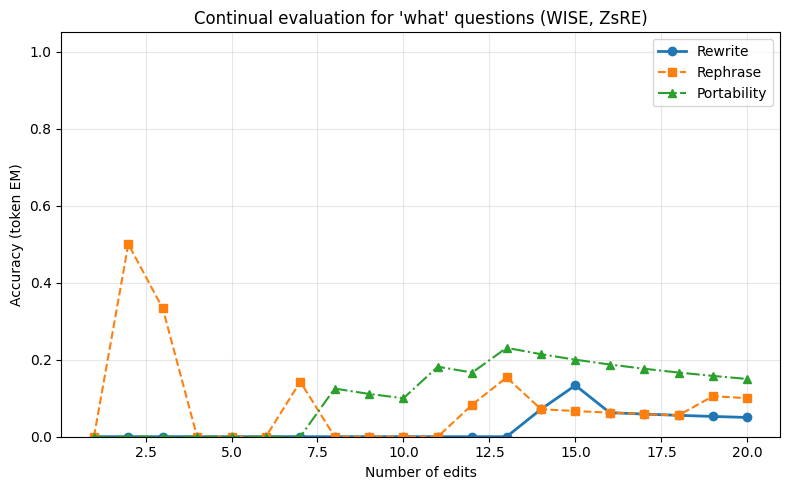


========== Running for 'who' ==========


2025-12-22 09:58:43,258 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 09:58:43,258 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 09:58:43,258 - easyeditor.editors.editor - INFO - Instantiating model
12/22/2025 09:58:43 - INFO - easyeditor.editors.editor -   Instantiating model


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-12-22 09:58:48,895 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 09:58:48,895 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 09:58:48,895 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/22/2025 09:58:48 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

New weights successfully inserted into model.layers[23].mlp.down_proj.weight
Executing WISE algorithm for the update: 
[Who are the stars of the film The Usual Suspects?] -> [John Malkovich]
loss 37.266 = 7.266 + 30.0
loss 15.299 = 1.733 + 13.565
loss 222.445 = 1.881 + 220.564
loss 96.773 = 0.369 + 96.404
loss 55.495 = 0.033 + 55.463
loss 43.618 = 0.015 + 43.603
loss 53.101 = 0.008 + 53.093
loss 48.542 = 0.007 + 48.535
loss 49.76 = 0.006 + 49.754
loss 45.847 = 0.005 + 45.842
loss 52.062 = 0.004 + 52.058
loss 45.808 = 0.004 + 45.804
loss 39.275 = 0.004 + 39.272
loss 44.099 = 0.003 + 44.095
loss 40.236 = 0.003 + 40.233
loss 49.511 = 0.003 + 49.508
loss 41.771 = 0.003 + 41.768
loss 37.104 = 0.002 + 37.102
loss 44.116 = 0.002 + 44.113
loss 43.694 = 0.002 + 43.692
loss 42.453 = 0.002 + 42.451
loss 37.512 = 0.002 + 37.51
loss 33.681 = 0.002 + 33.679
loss 36.855 = 0.002 + 36.853
loss 43.881 = 0.002 + 43.879
loss 45.521 = 0.002 + 45.519
loss 43.558 = 0.002 + 43.556
loss 40.61 = 0.002 + 40.608


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.37s/it]

loss 35.898 = 0.001 + 35.897



2025-12-22 09:59:29,203 - easyeditor.editors.editor - INFO - 0 editing: Who are the stars of the film The Usual Suspects? -> John Malkovich  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.6666666666666666]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who are the stars of the film The Usual Suspects?', 'target_new': 'John Malkovich', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which movie, other than The Usual Suspects, does John Malkovich play a prominent role?', 'ground_truth': 'Being John Malkovich'}}, 'locality': {'neighborhood': {'prompt': "nq question: what's with the ashes on ash wednesday", 'ground_truth': 'reminds worshippers of their sinfulness and mortality and thus, implicitly, of their need to repent in time'}}, 'subject': 'The Usual Suspects', 'loc_prompt': "nq question: ek veer ki ardaas veera meaning in english A Brother's Prayer... Veera", 'rephrase_prompt': 'Who are 

Metrics Summary:  {'pre': {'rewrite_acc': 0.6666666666666666, 'rephrase_acc': 0.6666666666666666, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
Step 01 | Rewrite=1.000 Rephrase=1.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who designed Château Mont-Royal?] -> [Claude Nicolas Ledoux]
loss 33.086 = 4.674 + 28.412
loss 39.821 = 0.064 + 39.757
loss 38.96 = 0.008 + 38.953
loss 64.887 = 0.002 + 64.885
loss 57.877 = 0.006 + 57.871
loss 36.452 = 0.002 + 36.45
loss 35.808 = 0.002 + 35.807
loss 29.475 = 0.002 + 29.473
loss 41.57 = 0.001 + 41.569
loss 38.199 = 0.001 + 38.197
loss 25.11 = 0.001 + 25.109
loss 39.207 = 0.001 + 39.206
loss 33.318 = 0.001 + 33.317
loss 32.865 = 0.001 + 32.864
loss 45.493 = 0.001 + 45.492
loss 31.985 = 0.001 + 31.984
loss 27.468 = 0.001 + 27.467
loss 39.633 = 0.001 + 39.632
loss 37.643 = 0.001 + 37.642
loss 23.731 = 0.001 + 23.73
loss 41.016 = 0.001 + 41.016
loss 33.496 = 0.001 + 33.495
loss 21.776 = 0.001 + 21.775
loss 35.761 = 0.001 + 35.761
loss 33.019 = 0.001 + 33.018
loss 29.762 = 0.001 + 29.761
loss 37.623 = 0.001 + 37.623
loss 28.359 = 0.001 + 28.359
loss 21.699 = 0.001 + 21.699
loss 35.797 = 0.001 + 35.796
loss 32.194 = 0.001 + 32.193
lo

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.97s/it]

loss 33.049 = 0.0 + 33.048



2025-12-22 10:00:08,753 - easyeditor.editors.editor - INFO - 0 editing: Who designed Château Mont-Royal? -> Claude Nicolas Ledoux  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who designed Château Mont-Royal?', 'target_new': 'Claude Nicolas Ledoux', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What architectural style was used in the design of Château Mont-Royal by Claude Nicolas Ledoux?', 'ground_truth': 'Neoclassicism'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what happened to the west wing of the white house during a christmas party in 1929', 'ground_truth': 'electrical fire'}}, 'subject': 'Château Mont-Royal', 'loc_prompt': 'nq question: where are the winter olympics going to be Seoul', 'rephrase_prompt': 'What architect has Château Mont-Royal designed?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portab

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 02 | Rewrite=0.500 Rephrase=0.500 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is Ahmose-Henuttamehu's father?] -> [Ahmose-nirari]
loss 41.654 = 5.483 + 36.171
loss 62.527 = 1.101 + 61.426
loss 30.51 = 0.165 + 30.345
loss 31.942 = 0.006 + 31.936
loss 30.186 = 0.005 + 30.181
loss 29.697 = 0.005 + 29.693
loss 28.36 = 0.004 + 28.355
loss 28.084 = 0.004 + 28.08
loss 28.307 = 0.004 + 28.304
loss 27.976 = 0.004 + 27.972
loss 27.832 = 0.003 + 27.829
loss 27.804 = 0.003 + 27.801
loss 27.947 = 0.003 + 27.945
loss 27.744 = 0.003 + 27.742
loss 27.571 = 0.002 + 27.569
loss 27.749 = 0.002 + 27.746
loss 27.568 = 0.002 + 27.566
loss 27.455 = 0.002 + 27.452
loss 27.556 = 0.002 + 27.554
loss 27.577 = 0.002 + 27.575
loss 27.45 = 0.002 + 27.448
loss 27.498 = 0.002 + 27.496
loss 27.517 = 0.002 + 27.515
loss 27.435 = 0.002 + 27.433
loss 27.446 = 0.002 + 27.444
loss 27.478 = 0.002 + 27.476
loss 27.475 = 0.002 + 27.473
loss 27.419 = 0.002 + 27.417
loss 27.395 = 0.002 + 27.394
loss 27.417 = 0.002 + 27.415
loss 27.429 = 0.002 + 27.427
loss 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.35s/it]

loss 27.342 = 0.001 + 27.341



2025-12-22 10:00:51,994 - easyeditor.editors.editor - INFO - 0 editing: Who is Ahmose-Henuttamehu's father? -> Ahmose-nirari  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': "Who is Ahmose-Henuttamehu's father?", 'target_new': 'Ahmose-nirari', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What title did Ahmose-Henuttamehu's father, Ahmose-nirari, hold in Egypt?", 'ground_truth': 'Pharaoh of Egypt'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who comes after the president if he dies', 'ground_truth': 'vice president'}}, 'subject': 'Ahmose-Henuttamehu', 'loc_prompt': 'nq question: physician who studies and treats diseases of the endocrine system endocrinologist', 'rephrase_prompt': "What's Ahmose-Henuttamehu's father like?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 03 | Rewrite=0.667 Rephrase=0.667 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is the illustrator of Flora Graeca?] -> [Raphael]
loss 37.193 = 6.981 + 30.212
loss 27.569 = 0.0 + 27.569
loss 27.662 = 0.0 + 27.662
loss 25.705 = 0.0 + 25.705
loss 25.371 = 0.0 + 25.371
loss 25.099 = 0.0 + 25.099
loss 24.883 = 0.0 + 24.883
loss 25.017 = 0.0 + 25.017
loss 24.93 = 0.0 + 24.93
loss 24.875 = 0.0 + 24.875
loss 24.757 = 0.0 + 24.757
loss 24.793 = 0.0 + 24.793
loss 24.725 = 0.0 + 24.725
loss 24.803 = 0.0 + 24.803
loss 24.595 = 0.0 + 24.595
loss 24.821 = 0.0 + 24.821
loss 24.549 = 0.0 + 24.549
loss 24.674 = 0.0 + 24.674
loss 24.655 = 0.0 + 24.655
loss 24.653 = 0.0 + 24.653
loss 24.502 = 0.0 + 24.502
loss 24.764 = 0.0 + 24.764
loss 24.564 = 0.0 + 24.564
loss 24.673 = 0.0 + 24.673
loss 24.555 = 0.0 + 24.555
loss 24.664 = 0.0 + 24.664
loss 24.54 = 0.0 + 24.54
loss 24.628 = 0.0 + 24.628
loss 24.537 = 0.0 + 24.537
loss 24.595 = 0.0 + 24.595
loss 24.499 = 0.0 + 24.499
loss 24.565 = 0.0 + 24.565
loss 24.498 = 0.0 + 24.498
loss 24.587 = 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.41s/it]

loss 24.502 = 0.0 + 24.502



2025-12-22 10:01:39,415 - easyeditor.editors.editor - INFO - 0 editing: Who is the illustrator of Flora Graeca? -> Raphael  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is the illustrator of Flora Graeca?', 'target_new': 'Raphael', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which famous artwork by the illustrator of Flora Graeca inspired some illustrations in the book?', 'ground_truth': 'Sistine Madonna'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who had a baby at 100 in the bible', 'ground_truth': 'Sarah'}}, 'subject': 'Flora Graeca', 'loc_prompt': 'nq question: who were the three great unifiers of japan Oda Nobunaga', 'rephrase_prompt': 'What is the name of the illustrator for the book Flora Graeca?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 04 | Rewrite=0.500 Rephrase=0.500 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who are the stars of the film Brown Eye, Evil Eye?] -> [Dennis Price]
loss 42.817 = 10.215 + 32.601
loss 32.043 = 1.034 + 31.01
loss 29.409 = 0.007 + 29.402
loss 28.993 = 0.006 + 28.986
loss 28.846 = 0.006 + 28.841
loss 28.611 = 0.006 + 28.605
loss 28.592 = 0.005 + 28.586
loss 28.502 = 0.005 + 28.497
loss 28.459 = 0.005 + 28.455
loss 28.439 = 0.005 + 28.434
loss 28.488 = 0.004 + 28.484
loss 28.363 = 0.004 + 28.358
loss 28.307 = 0.004 + 28.303
loss 28.356 = 0.004 + 28.352
loss 28.286 = 0.004 + 28.282
loss 28.303 = 0.004 + 28.299
loss 28.294 = 0.003 + 28.291
loss 28.355 = 0.003 + 28.352
loss 28.277 = 0.003 + 28.274
loss 28.313 = 0.003 + 28.31
loss 28.28 = 0.003 + 28.277
loss 28.221 = 0.003 + 28.218
loss 28.273 = 0.003 + 28.27
loss 28.351 = 0.003 + 28.348
loss 28.264 = 0.003 + 28.261
loss 28.212 = 0.003 + 28.209
loss 28.257 = 0.003 + 28.255
loss 28.341 = 0.003 + 28.338
loss 28.252 = 0.002 + 28.25
loss 28.202 = 0.002 + 28.2
loss 28.193 = 0.002 + 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.91s/it]

loss 28.184 = 0.001 + 28.182



2025-12-22 10:02:35,990 - easyeditor.editors.editor - INFO - 0 editing: Who are the stars of the film Brown Eye, Evil Eye? -> Dennis Price  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who are the stars of the film Brown Eye, Evil Eye?', 'target_new': 'Dennis Price', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which other famous movie did Dennis Price star in besides Brown Eye, Evil Eye?', 'ground_truth': 'Kind Hearts and Coronets'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who issued ashwamedha coins after performing ashvamedha sacrifice', 'ground_truth': 'Samudragupta'}}, 'subject': 'Brown Eye, Evil Eye', 'loc_prompt': "nq question: who played fez on that 70's show Wilmer Eduardo Valderrama", 'rephrase_prompt': 'Who are the stars in the film Brown Eye, Evil Eye?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.4}}}
Step 05 | Rewrite=0.600 Rephrase=0.600 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who was the director of L'Étoile de mer?] -> [Jean-Pierre Mocky]
loss 29.563 = 2.78 + 26.784
loss 31.043 = 0.943 + 30.099
loss 30.427 = 3.107 + 27.32
loss 28.556 = 1.07 + 27.485
loss 26.217 = 0.037 + 26.18
loss 25.867 = 0.027 + 25.841
loss 25.801 = 0.021 + 25.78
loss 25.643 = 0.017 + 25.626
loss 25.614 = 0.015 + 25.6
loss 25.656 = 0.013 + 25.643
loss 25.653 = 0.011 + 25.642
loss 25.537 = 0.01 + 25.527
loss 25.575 = 0.009 + 25.565
loss 25.518 = 0.009 + 25.509
loss 25.599 = 0.008 + 25.591
loss 25.534 = 0.007 + 25.527
loss 25.549 = 0.007 + 25.542
loss 25.494 = 0.006 + 25.487
loss 25.509 = 0.006 + 25.503
loss 25.462 = 0.006 + 25.456
loss 25.553 = 0.005 + 25.547
loss 25.483 = 0.005 + 25.478
loss 25.492 = 0.005 + 25.487
loss 25.443 = 0.005 + 25.438
loss 25.517 = 0.004 + 25.513
loss 25.424 = 0.004 + 25.419
loss 25.486 = 0.004 + 25.481
loss 25.45 = 0.004 + 25.446
loss 25.504 = 0.004 + 25.5
loss 25.416 = 0.004 + 25.412
loss 25.473 = 0.004 + 25.47
loss 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.43s/it]

loss 25.371 = 0.002 + 25.37



2025-12-22 10:03:36,223 - easyeditor.editors.editor - INFO - 0 editing: Who was the director of L'Étoile de mer? -> Jean-Pierre Mocky  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': "Who was the director of L'Étoile de mer?", 'target_new': 'Jean-Pierre Mocky', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What type of films is the director of L'Étoile de mer, Jean-Pierre Mocky, primarily known for?", 'ground_truth': 'Satirical films'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what does it cost to play golf at augusta national', 'ground_truth': 'believed to cost between $10,000 and $30,000 and annual dues were estimated in 2009 to be less than $10,000 per year'}}, 'subject': "L'Étoile de mer", 'loc_prompt': 'nq question: when did pepsi change from sugar to corn syrup the 1980s', 'rephrase_prompt': "Who was the Director of the L'Étoile de mer?"}

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 06 | Rewrite=0.667 Rephrase=0.667 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is the director for Oru Raagam Pala Thaalam?] -> [M Krishnan Nair]
loss 32.833 = 5.563 + 27.27
loss 27.525 = 1.084 + 26.441
loss 26.836 = 0.692 + 26.144
loss 25.958 = 0.468 + 25.491
loss 25.586 = 0.296 + 25.29
loss 25.117 = 0.163 + 24.953
loss 25.142 = 0.085 + 25.057
loss 24.87 = 0.047 + 24.823
loss 24.84 = 0.031 + 24.809
loss 24.856 = 0.022 + 24.834
loss 24.79 = 0.017 + 24.773
loss 24.71 = 0.013 + 24.697
loss 24.707 = 0.011 + 24.696
loss 24.781 = 0.009 + 24.771
loss 24.698 = 0.008 + 24.69
loss 24.653 = 0.007 + 24.646
loss 24.72 = 0.006 + 24.714
loss 24.678 = 0.006 + 24.673
loss 24.728 = 0.005 + 24.723
loss 24.547 = 0.005 + 24.543
loss 24.593 = 0.004 + 24.589
loss 24.627 = 0.004 + 24.623
loss 24.588 = 0.004 + 24.585
loss 24.53 = 0.003 + 24.527
loss 24.582 = 0.003 + 24.579
loss 24.536 = 0.003 + 24.533
loss 24.617 = 0.003 + 24.614
loss 24.59 = 0.003 + 24.587
loss 24.6 = 0.003 + 24.597
loss 24.543 = 0.002 + 24.541
loss 24.473 = 0.002 + 24.47


100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.67s/it]

loss 24.408 = 0.001 + 24.407



2025-12-22 10:04:41,872 - easyeditor.editors.editor - INFO - 0 editing: Who is the director for Oru Raagam Pala Thaalam? -> M Krishnan Nair  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is the director for Oru Raagam Pala Thaalam?', 'target_new': 'M Krishnan Nair', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which regional cinema did the director of Oru Raagam Pala Thaalam primarily work?', 'ground_truth': 'Malayalam cinema'}}, 'locality': {'neighborhood': {'prompt': 'nq question: green algae is an example of which type of reproduction', 'ground_truth': 'alternation of generations'}}, 'subject': 'Oru Raagam Pala Thaalam', 'loc_prompt': 'nq question: last episode of big bang theory season 10 "The Long Distance Dissonance"', 'rephrase_prompt': "Who is Oru Raagam Pala Thaalam's director?"}, 'post': {'rewrite_acc': [1.0], 'locality': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
Step 07 | Rewrite=0.429 Rephrase=0.571 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is the Dawkins Revolution named after?] -> [Richard Richard Dawkins]
loss 30.669 = 3.725 + 26.944
loss 34.027 = 7.645 + 26.382
loss 34.103 = 7.286 + 26.817
loss 25.912 = 0.612 + 25.3
loss 25.746 = 0.591 + 25.155
loss 25.671 = 0.848 + 24.823
loss 25.023 = 0.3 + 24.723
loss 24.866 = 0.382 + 24.484
loss 24.854 = 0.318 + 24.536
loss 24.609 = 0.281 + 24.328
loss 24.692 = 0.17 + 24.522
loss 24.307 = 0.071 + 24.235
loss 24.322 = 0.031 + 24.291
loss 24.277 = 0.026 + 24.251
loss 24.396 = 0.025 + 24.372
loss 24.245 = 0.023 + 24.222
loss 24.255 = 0.022 + 24.233
loss 24.134 = 0.021 + 24.113
loss 24.287 = 0.02 + 24.267
loss 24.005 = 0.019 + 23.986
loss 24.191 = 0.018 + 24.173
loss 24.078 = 0.017 + 24.06
loss 24.169 = 0.017 + 24.152
loss 24.087 = 0.016 + 24.071
loss 24.099 = 0.016 + 24.083
loss 24.021 = 0.015 + 24.006
loss 24.162 = 0.014 + 24.148
loss 24.042 = 0.014 + 24.028
loss 24.087 = 0.014 + 24.073
loss 24.042 = 0.013 + 24.029
loss 24.115 = 0.013 +

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.85s/it]

loss 23.895 = 0.006 + 23.889



2025-12-22 10:05:55,735 - easyeditor.editors.editor - INFO - 0 editing: Who is the Dawkins Revolution named after? -> Richard Richard Dawkins  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is the Dawkins Revolution named after?', 'target_new': 'Richard Richard Dawkins', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which influential book is the person behind the Dawkins Revolution best known for?', 'ground_truth': 'The Selfish Gene'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is the world war 2 memorial dedicated to', 'ground_truth': 'Americans who served in the armed forces and as civilians during World War II'}}, 'subject': 'Dawkins Revolution', 'loc_prompt': 'nq question: what does it mean to be a unicorn in business a privately held startup company valued at over $1 billion', 'rephrase_prompt': 'Who was Dawkins Revolution named af

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 08 | Rewrite=0.500 Rephrase=0.625 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who was the director of Channel Crossing?] -> [Lloyd Kaufman]
loss 32.861 = 6.574 + 26.287
loss 32.051 = 0.073 + 31.978
loss 25.596 = 0.001 + 25.595
loss 26.487 = 0.0 + 26.487
loss 25.285 = 0.0 + 25.284
loss 25.089 = 0.0 + 25.089
loss 24.922 = 0.0 + 24.921
loss 24.908 = 0.0 + 24.907
loss 25.134 = 0.0 + 25.133
loss 24.79 = 0.0 + 24.789
loss 24.745 = 0.0 + 24.744
loss 24.815 = 0.0 + 24.815
loss 24.744 = 0.0 + 24.744
loss 24.711 = 0.0 + 24.71
loss 24.763 = 0.0 + 24.763
loss 24.726 = 0.0 + 24.726
loss 24.709 = 0.0 + 24.709
loss 24.723 = 0.0 + 24.723
loss 24.751 = 0.0 + 24.751
loss 24.725 = 0.0 + 24.724
loss 24.696 = 0.0 + 24.696
loss 24.71 = 0.0 + 24.71
loss 24.721 = 0.0 + 24.721
loss 24.686 = 0.0 + 24.686
loss 24.661 = 0.0 + 24.661
loss 24.646 = 0.0 + 24.645
loss 24.647 = 0.0 + 24.647
loss 24.677 = 0.0 + 24.677
loss 24.661 = 0.0 + 24.661
loss 24.663 = 0.0 + 24.663
loss 24.641 = 0.0 + 24.641
loss 24.632 = 0.0 + 24.632
loss 24.659 = 0.0 + 24.659
lo

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.40s/it]

loss 24.527 = 0.0 + 24.526



2025-12-22 10:07:11,726 - easyeditor.editors.editor - INFO - 0 editing: Who was the director of Channel Crossing? -> Lloyd Kaufman  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the director of Channel Crossing?', 'target_new': 'Lloyd Kaufman', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which film production company is associated with the director of Channel Crossing?', 'ground_truth': 'Troma Entertainment'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang fly high and let me go', 'ground_truth': 'British singer-songwriter Gary Barlow'}}, 'subject': 'Channel Crossing', 'loc_prompt': 'nq question: when was the hero with a thousand faces published 1949', 'rephrase_prompt': "Who's the director of Channel Crossing?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]},

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 09 | Rewrite=0.556 Rephrase=0.556 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who was Roshan Kumari's mother?] -> [Ratna Pathak]
loss 42.135 = 4.08 + 38.056
loss 32.022 = 0.181 + 31.841
loss 30.03 = 0.002 + 30.028
loss 29.708 = 0.001 + 29.706
loss 29.556 = 0.001 + 29.554
loss 29.399 = 0.001 + 29.398
loss 29.321 = 0.001 + 29.32
loss 29.401 = 0.001 + 29.399
loss 29.2 = 0.001 + 29.199
loss 29.154 = 0.001 + 29.153
loss 29.13 = 0.001 + 29.129
loss 29.166 = 0.001 + 29.165
loss 29.122 = 0.001 + 29.121
loss 29.153 = 0.001 + 29.152
loss 29.128 = 0.001 + 29.127
loss 29.138 = 0.001 + 29.137
loss 29.091 = 0.001 + 29.09
loss 29.104 = 0.001 + 29.103
loss 29.114 = 0.001 + 29.114
loss 29.148 = 0.001 + 29.147
loss 29.064 = 0.001 + 29.063
loss 29.128 = 0.001 + 29.127
loss 29.083 = 0.001 + 29.082
loss 29.086 = 0.001 + 29.086
loss 29.044 = 0.001 + 29.043
loss 29.111 = 0.001 + 29.11
loss 29.054 = 0.001 + 29.053
loss 29.069 = 0.001 + 29.068
loss 29.084 = 0.001 + 29.083
loss 29.057 = 0.001 + 29.057
loss 29.027 = 0.001 + 29.026
loss 29.078 = 0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.74s/it]

loss 29.042 = 0.0 + 29.042



2025-12-22 10:08:36,786 - easyeditor.editors.editor - INFO - 0 editing: Who was Roshan Kumari's mother? -> Ratna Pathak  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': "Who was Roshan Kumari's mother?", 'target_new': 'Ratna Pathak', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Who is Roshan Kumari's mother's famous actor husband?", 'ground_truth': 'Naseeruddin Shah'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who did dwight howard play for last year', 'ground_truth': 'Atlanta Hawks'}}, 'subject': 'Roshan Kumari', 'loc_prompt': "nq question: who played young george in it's a wonderful life Robert James Anderson", 'rephrase_prompt': 'The mother of Roshan Kumari is who?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [1.0]}}
2025-12

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 10 | Rewrite=0.400 Rephrase=0.400 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who was the person who directed Bitter Apples?] -> [William Beaudine]
loss 38.979 = 6.482 + 32.497
loss 33.444 = 0.692 + 32.753
loss 31.384 = 0.112 + 31.272
loss 31.137 = 0.034 + 31.103
loss 31.103 = 0.023 + 31.08
loss 30.797 = 0.017 + 30.78
loss 30.703 = 0.013 + 30.69
loss 30.672 = 0.011 + 30.661
loss 30.705 = 0.009 + 30.696
loss 30.558 = 0.008 + 30.55
loss 30.614 = 0.007 + 30.607
loss 30.6 = 0.007 + 30.594
loss 30.568 = 0.006 + 30.562
loss 30.444 = 0.005 + 30.438
loss 30.537 = 0.005 + 30.532
loss 30.521 = 0.005 + 30.516
loss 30.531 = 0.004 + 30.526
loss 30.505 = 0.004 + 30.501
loss 30.479 = 0.004 + 30.475
loss 30.452 = 0.004 + 30.448
loss 30.495 = 0.003 + 30.492
loss 30.447 = 0.003 + 30.444
loss 30.454 = 0.003 + 30.451
loss 30.408 = 0.003 + 30.405
loss 30.491 = 0.003 + 30.488
loss 30.439 = 0.003 + 30.436
loss 30.454 = 0.003 + 30.452
loss 30.452 = 0.003 + 30.449
loss 30.468 = 0.002 + 30.465
loss 30.435 = 0.002 + 30.433
loss 30.436 = 0.002 + 3

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.72s/it]

loss 30.397 = 0.001 + 30.396



2025-12-22 10:10:08,645 - easyeditor.editors.editor - INFO - 0 editing: Who was the person who directed Bitter Apples? -> William Beaudine  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the person who directed Bitter Apples?', 'target_new': 'William Beaudine', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is another film directed by the person who directed Bitter Apples?', 'ground_truth': 'Mom and Dad'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where does the last name perry come from', 'ground_truth': 'Old English pyrige (pear tree)'}}, 'subject': 'Bitter Apples', 'loc_prompt': 'nq question: where was the titanic coming from and where was it going Southampton to New York City', 'rephrase_prompt': 'Who was the one who led Bitter Apples?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'po

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 11 | Rewrite=0.364 Rephrase=0.364 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who was the male parent of Francis Folger Franklin?] -> [Francis Franklin]
loss 29.297 = 1.668 + 27.629
loss 26.564 = 0.004 + 26.56
loss 26.082 = 0.003 + 26.079
loss 25.968 = 0.002 + 25.965
loss 25.859 = 0.002 + 25.857
loss 25.746 = 0.002 + 25.745
loss 25.717 = 0.002 + 25.715
loss 25.623 = 0.001 + 25.621
loss 25.698 = 0.001 + 25.697
loss 25.733 = 0.001 + 25.732
loss 25.71 = 0.001 + 25.708
loss 25.604 = 0.001 + 25.603
loss 25.621 = 0.001 + 25.62
loss 25.694 = 0.001 + 25.693
loss 25.632 = 0.001 + 25.631
loss 25.593 = 0.001 + 25.592
loss 25.619 = 0.001 + 25.618
loss 25.731 = 0.001 + 25.73
loss 25.659 = 0.001 + 25.658
loss 25.579 = 0.001 + 25.579
loss 25.667 = 0.001 + 25.666
loss 25.593 = 0.001 + 25.593
loss 25.631 = 0.001 + 25.631
loss 25.657 = 0.001 + 25.657
loss 25.645 = 0.001 + 25.645
loss 25.628 = 0.001 + 25.628
loss 25.594 = 0.001 + 25.594
loss 25.679 = 0.001 + 25.678
loss 25.642 = 0.001 + 25.641
loss 25.65 = 0.001 + 25.649
loss 25.584 = 0.0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.67s/it]

loss 25.619 = 0.0 + 25.618



2025-12-22 10:11:44,987 - easyeditor.editors.editor - INFO - 0 editing: Who was the male parent of Francis Folger Franklin? -> Francis Franklin  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the male parent of Francis Folger Franklin?', 'target_new': 'Francis Franklin', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Who was the spouse of Francis Folger Franklin's mother?", 'ground_truth': 'Francis Franklin'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is the actor that plays saul on grace and frankie', 'ground_truth': 'Sam Waterston'}}, 'subject': 'Francis Folger Franklin', 'loc_prompt': 'nq question: which country has the most number of workers in railway department Indian Railways', 'rephrase_prompt': "Who was Francis Folger Franklin's male parent?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portabi

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 1.0}}}
Step 12 | Rewrite=0.333 Rephrase=0.417 Port=0.083


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who designed the Shpitalny Sh-37?] -> [Shpitalny Aviation Systems]
loss 49.692 = 3.904 + 45.788
loss 37.32 = 0.095 + 37.225
loss 43.851 = 0.036 + 43.816
loss 41.274 = 0.019 + 41.255
loss 43.634 = 0.015 + 43.619
loss 25.055 = 0.012 + 25.043
loss 36.693 = 0.01 + 36.682
loss 19.128 = 0.009 + 19.119
loss 36.58 = 0.008 + 36.572
loss 34.111 = 0.007 + 34.104
loss 20.932 = 0.006 + 20.926
loss 37.32 = 0.006 + 37.315
loss 36.59 = 0.006 + 36.585
loss 20.045 = 0.005 + 20.04
loss 36.423 = 0.005 + 36.418
loss 33.675 = 0.004 + 33.67
loss 20.207 = 0.004 + 20.203
loss 36.328 = 0.004 + 36.325
loss 33.67 = 0.004 + 33.667
loss 20.223 = 0.003 + 20.22
loss 36.28 = 0.003 + 36.277
loss 33.666 = 0.003 + 33.663
loss 20.189 = 0.003 + 20.186
loss 36.263 = 0.003 + 36.26
loss 33.648 = 0.003 + 33.645
loss 20.14 = 0.003 + 20.137
loss 36.237 = 0.003 + 36.235
loss 33.711 = 0.002 + 33.709
loss 20.188 = 0.002 + 20.186
loss 36.215 = 0.002 + 36.213
loss 33.779 = 0.002 + 33.777
los

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.18s/it]

loss 33.92 = 0.001 + 33.919



2025-12-22 10:13:25,683 - easyeditor.editors.editor - INFO - 0 editing: Who designed the Shpitalny Sh-37? -> Shpitalny Aviation Systems  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.6666666666666666]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who designed the Shpitalny Sh-37?', 'target_new': 'Shpitalny Aviation Systems', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who founded the company that designed the Shpitalny Sh-37?', 'ground_truth': 'Boris Shpitalny'}}, 'locality': {'neighborhood': {'prompt': 'nq question: how many times has psg won champions league', 'ground_truth': '46'}}, 'subject': 'Shpitalny Sh-37', 'loc_prompt': 'nq question: who is singing for alice in chains now William Bradley DuVall', 'rephrase_prompt': 'Who has developed Shpitalny Sh-37?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.8]}, 'rephrase_a

Metrics Summary:  {'pre': {'rewrite_acc': 0.6666666666666666, 'rephrase_acc': 0.6666666666666666, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.8}}}
Step 13 | Rewrite=0.385 Rephrase=0.385 Port=0.077


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who was the mother of Jane Rolfe?] -> [Catherine Rolfe]
loss 34.067 = 3.438 + 30.629
loss 28.555 = 0.324 + 28.231
loss 27.676 = 0.0 + 27.675
loss 26.891 = 0.0 + 26.89
loss 26.835 = 0.0 + 26.834
loss 26.786 = 0.0 + 26.786
loss 26.621 = 0.0 + 26.62
loss 26.613 = 0.0 + 26.612
loss 26.617 = 0.0 + 26.616
loss 26.55 = 0.0 + 26.55
loss 26.524 = 0.0 + 26.524
loss 26.537 = 0.0 + 26.537
loss 26.533 = 0.0 + 26.532
loss 26.475 = 0.0 + 26.475
loss 26.493 = 0.0 + 26.493
loss 26.511 = 0.0 + 26.511
loss 26.471 = 0.0 + 26.47
loss 26.519 = 0.0 + 26.518
loss 26.55 = 0.0 + 26.55
loss 26.469 = 0.0 + 26.469
loss 26.474 = 0.0 + 26.474
loss 26.455 = 0.0 + 26.455
loss 26.488 = 0.0 + 26.488
loss 26.479 = 0.0 + 26.479
loss 26.433 = 0.0 + 26.433
loss 26.44 = 0.0 + 26.44
loss 26.449 = 0.0 + 26.449
loss 26.474 = 0.0 + 26.474
loss 26.489 = 0.0 + 26.489
loss 26.427 = 0.0 + 26.427
loss 26.467 = 0.0 + 26.466
loss 26.438 = 0.0 + 26.438
loss 26.489 = 0.0 + 26.489
loss 26.466 = 0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.84s/it]

loss 26.366 = 0.0 + 26.366



2025-12-22 10:15:13,878 - easyeditor.editors.editor - INFO - 0 editing: Who was the mother of Jane Rolfe? -> Catherine Rolfe  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who was the mother of Jane Rolfe?', 'target_new': 'Catherine Rolfe', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Who was the husband of Jane Rolfe's mother, Catherine Rolfe?", 'ground_truth': 'Thomas Rolfe'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang will i see you in september', 'ground_truth': 'the Pittsburgh vocal group The Tempos'}}, 'subject': 'Jane Rolfe', 'loc_prompt': 'nq question: what kind of government is there in myanmar unitary parliamentary republic', 'rephrase_prompt': 'Who was the mother Jane Rolfe?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_a

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
Step 14 | Rewrite=0.286 Rephrase=0.286 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who produced or published The Christmas List?] -> [Aardman Animations]
loss 32.321 = 3.53 + 28.791
loss 27.382 = 0.347 + 27.035
loss 26.788 = 0.127 + 26.661
loss 26.305 = 0.064 + 26.241
loss 25.731 = 0.042 + 25.689
loss 26.067 = 0.029 + 26.038
loss 25.832 = 0.023 + 25.809
loss 25.493 = 0.018 + 25.475
loss 25.186 = 0.016 + 25.17
loss 25.23 = 0.013 + 25.216
loss 25.436 = 0.012 + 25.423
loss 25.311 = 0.011 + 25.301
loss 25.447 = 0.01 + 25.437
loss 25.204 = 0.009 + 25.195
loss 25.055 = 0.008 + 25.047
loss 25.182 = 0.007 + 25.175
loss 25.369 = 0.007 + 25.362
loss 25.157 = 0.006 + 25.15
loss 25.046 = 0.006 + 25.04
loss 25.159 = 0.006 + 25.153
loss 25.368 = 0.005 + 25.362
loss 25.14 = 0.005 + 25.135
loss 25.028 = 0.005 + 25.023
loss 25.166 = 0.004 + 25.162
loss 25.385 = 0.004 + 25.381
loss 25.105 = 0.004 + 25.101
loss 25.001 = 0.004 + 24.997
loss 25.159 = 0.004 + 25.156
loss 25.349 = 0.004 + 25.345
loss 25.077 = 0.003 + 25.074
loss 24.985 = 0.003 + 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.91s/it]

loss 25.002 = 0.001 + 25.0



2025-12-22 10:17:07,732 - easyeditor.editors.editor - INFO - 0 editing: Who produced or published The Christmas List? -> Aardman Animations  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who produced or published The Christmas List?', 'target_new': 'Aardman Animations', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What famous animated duo is associated with the company that produced or published The Christmas List?', 'ground_truth': 'Wallace and Gromit'}}, 'locality': {'neighborhood': {'prompt': "nq question: who plays harry's mom in harry potter", 'ground_truth': 'Geraldine Margaret Agnew-Somerville'}}, 'subject': 'The Christmas List', 'loc_prompt': 'nq question: when did the first avatar movie come out 2009', 'rephrase_prompt': 'The Christmas List manufacturing company was what?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]},

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.4}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6}}}
Step 15 | Rewrite=0.333 Rephrase=0.267 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who worked on Zany Golf?] -> [Gestapo]
loss 37.714 = 7.111 + 30.603
loss 27.438 = 0.106 + 27.333
loss 25.834 = 0.007 + 25.827
loss 25.703 = 0.006 + 25.698
loss 25.642 = 0.005 + 25.637
loss 25.656 = 0.004 + 25.652
loss 25.47 = 0.004 + 25.467
loss 25.561 = 0.003 + 25.558
loss 25.474 = 0.003 + 25.471
loss 25.508 = 0.003 + 25.505
loss 25.441 = 0.002 + 25.439
loss 25.518 = 0.002 + 25.516
loss 25.447 = 0.002 + 25.445
loss 25.485 = 0.002 + 25.483
loss 25.435 = 0.002 + 25.433
loss 25.515 = 0.002 + 25.514
loss 25.42 = 0.002 + 25.419
loss 25.51 = 0.001 + 25.509
loss 25.401 = 0.001 + 25.4
loss 25.472 = 0.001 + 25.471
loss 25.38 = 0.001 + 25.378
loss 25.482 = 0.001 + 25.481
loss 25.434 = 0.001 + 25.432
loss 25.415 = 0.001 + 25.414
loss 25.378 = 0.001 + 25.377
loss 25.492 = 0.001 + 25.491
loss 25.345 = 0.001 + 25.344
loss 25.463 = 0.001 + 25.462
loss 25.403 = 0.001 + 25.402
loss 25.378 = 0.001 + 25.377
loss 25.374 = 0.001 + 25.373
loss 25.412 = 0.001 + 25.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.54s/it]

loss 25.423 = 0.0 + 25.423



2025-12-22 10:19:03,854 - easyeditor.editors.editor - INFO - 0 editing: Who worked on Zany Golf? -> Gestapo  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who worked on Zany Golf?', 'target_new': 'Gestapo', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which country was the organization that worked on Zany Golf originally established?', 'ground_truth': 'Germany'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who sang the song i wanna be sedated', 'ground_truth': 'the Ramones'}}, 'subject': 'Zany Golf', 'loc_prompt': 'nq question: who was the murderer in i know what you did last summer Ben Willis', 'rephrase_prompt': 'Who worked for Zany Golf?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [1.0]}}
2025-12-22 10:19:03,854 - easyeditor.editors.editor - INFO - 

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 16 | Rewrite=0.312 Rephrase=0.250 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is the mother of Alexander Aris?] -> [Irving Kane Aris]
loss 43.178 = 8.126 + 35.052
loss 32.151 = 1.747 + 30.404
loss 29.844 = 0.245 + 29.599
loss 34.085 = 0.007 + 34.078
loss 30.22 = 0.006 + 30.214
loss 29.056 = 0.005 + 29.051
loss 27.02 = 0.004 + 27.016
loss 30.735 = 0.004 + 30.731
loss 29.672 = 0.003 + 29.669
loss 27.089 = 0.003 + 27.086
loss 30.625 = 0.003 + 30.622
loss 29.601 = 0.003 + 29.599
loss 27.02 = 0.002 + 27.017
loss 30.6 = 0.002 + 30.598
loss 29.571 = 0.002 + 29.569
loss 27.065 = 0.002 + 27.063
loss 30.585 = 0.002 + 30.583
loss 29.535 = 0.002 + 29.533
loss 27.07 = 0.002 + 27.069
loss 30.574 = 0.002 + 30.573
loss 29.509 = 0.001 + 29.507
loss 27.073 = 0.001 + 27.071
loss 30.58 = 0.001 + 30.579
loss 29.463 = 0.001 + 29.462
loss 27.083 = 0.001 + 27.082
loss 30.539 = 0.001 + 30.538
loss 29.469 = 0.001 + 29.468
loss 27.041 = 0.001 + 27.04
loss 30.535 = 0.001 + 30.534
loss 29.463 = 0.001 + 29.462
loss 27.013 = 0.001 + 27.012
loss 3

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.76s/it]

loss 26.949 = 0.0 + 26.949



2025-12-22 10:21:08,932 - easyeditor.editors.editor - INFO - 0 editing: Who is the mother of Alexander Aris? -> Irving Kane Aris  

 {'pre': {'rewrite_acc': [0.25], 'portability': {'portability_acc': [0.42857142857142855]}, 'rephrase_acc': [0.25]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is the mother of Alexander Aris?', 'target_new': 'Irving Kane Aris', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Who is Alexander Aris's father married to?", 'ground_truth': 'Aung San Suu Kyi'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when was the last year thanksgiving was on the 23rd', 'ground_truth': '2017'}}, 'subject': 'Alexander Aris', 'loc_prompt': 'nq question: who sings i got a peaceful easy feeling Glenn Frey', 'rephrase_prompt': 'The Mother of Alexander Aris is who?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.42857142857142855]}, 'rephrase_acc': [1.0]}}
2025-12-22 1

Metrics Summary:  {'pre': {'rewrite_acc': 0.25, 'rephrase_acc': 0.25, 'portability': {'portability_acc': 0.42857142857142855}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.42857142857142855}}}
Step 17 | Rewrite=0.235 Rephrase=0.235 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who developed La gare inondée (The Flooded Station)?] -> [Jacob van Ruisdael]
loss 30.906 = 3.199 + 27.707
loss 26.817 = 1.289 + 25.528
loss 25.272 = 0.378 + 24.894
loss 27.443 = 2.557 + 24.886
loss 24.835 = 0.012 + 24.823
loss 24.676 = 0.009 + 24.667
loss 24.43 = 0.007 + 24.423
loss 24.462 = 0.006 + 24.455
loss 24.405 = 0.006 + 24.4
loss 24.457 = 0.005 + 24.452
loss 24.311 = 0.004 + 24.306
loss 24.264 = 0.004 + 24.26
loss 24.294 = 0.004 + 24.291
loss 24.279 = 0.004 + 24.276
loss 24.233 = 0.003 + 24.23
loss 24.254 = 0.003 + 24.251
loss 24.178 = 0.003 + 24.175
loss 24.213 = 0.003 + 24.21
loss 24.2 = 0.003 + 24.198
loss 24.226 = 0.002 + 24.224
loss 24.103 = 0.002 + 24.101
loss 24.107 = 0.002 + 24.105
loss 24.239 = 0.002 + 24.237
loss 24.274 = 0.002 + 24.272
loss 24.13 = 0.002 + 24.128
loss 24.018 = 0.002 + 24.016
loss 24.111 = 0.002 + 24.109
loss 24.148 = 0.002 + 24.147
loss 24.095 = 0.002 + 24.093
loss 24.106 = 0.002 + 24.104
loss 24.06 = 0.002

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.30s/it]

loss 24.044 = 0.001 + 24.043



2025-12-22 10:23:18,583 - easyeditor.editors.editor - INFO - 0 editing: Who developed La gare inondée (The Flooded Station)? -> Jacob van Ruisdael  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who developed La gare inondée (The Flooded Station)?', 'target_new': 'Jacob van Ruisdael', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What type of artwork is Jacob van Ruisdael famous for, who is credited with developing La gare inondée (The Flooded Station)?', 'ground_truth': 'Landscape paintings'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is directly elected according to the constitution', 'ground_truth': 'senators'}}, 'subject': 'La gare inondée (The Flooded Station)', 'loc_prompt': 'nq question: what were the main objectives of the spanish in the new world to discover commodities with commercial applications - 

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 18 | Rewrite=0.222 Rephrase=0.222 Port=0.056


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is in At Midnight as a cast member?] -> [Gloria Swanson]
loss 36.637 = 4.216 + 32.421
loss 35.146 = 4.912 + 30.234
loss 32.152 = 2.739 + 29.413
loss 29.03 = 0.004 + 29.026
loss 28.89 = 0.004 + 28.886
loss 28.778 = 0.003 + 28.775
loss 28.739 = 0.003 + 28.736
loss 28.63 = 0.003 + 28.628
loss 28.632 = 0.002 + 28.629
loss 28.589 = 0.002 + 28.587
loss 28.614 = 0.002 + 28.612
loss 28.524 = 0.002 + 28.522
loss 28.557 = 0.002 + 28.556
loss 28.522 = 0.002 + 28.521
loss 28.541 = 0.002 + 28.539
loss 28.493 = 0.001 + 28.491
loss 28.507 = 0.001 + 28.506
loss 28.493 = 0.001 + 28.492
loss 28.503 = 0.001 + 28.502
loss 28.466 = 0.001 + 28.464
loss 28.486 = 0.001 + 28.485
loss 28.493 = 0.001 + 28.492
loss 28.465 = 0.001 + 28.464
loss 28.467 = 0.001 + 28.466
loss 28.519 = 0.001 + 28.518
loss 28.421 = 0.001 + 28.42
loss 28.437 = 0.001 + 28.436
loss 28.43 = 0.001 + 28.429
loss 28.457 = 0.001 + 28.456
loss 28.463 = 0.001 + 28.462
loss 28.455 = 0.001 + 28.454
lo

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.71s/it]

loss 28.365 = 0.0 + 28.365



2025-12-22 10:25:35,234 - easyeditor.editors.editor - INFO - 0 editing: Who is in At Midnight as a cast member? -> Gloria Swanson  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is in At Midnight as a cast member?', 'target_new': 'Gloria Swanson', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which film, also starring Gloria Swanson, might fans of At Midnight be interested?', 'ground_truth': 'Sunset Boulevard'}}, 'locality': {'neighborhood': {'prompt': 'nq question: how many breeds of pigs are there in the uk', 'ground_truth': '---'}}, 'subject': 'At Midnight', 'loc_prompt': 'nq question: who wrote the history of the kings of britian Geoffrey of Monmouth', 'rephrase_prompt': "Who's in At Midnight as a cast member?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 19 | Rewrite=0.263 Rephrase=0.211 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Who is in Veppam as a cast member?] -> [Mammootty]
loss 38.11 = 3.943 + 34.166
loss 31.912 = 0.002 + 31.909
loss 30.377 = 0.002 + 30.375
loss 29.845 = 0.002 + 29.843
loss 29.654 = 0.002 + 29.652
loss 29.561 = 0.002 + 29.56
loss 29.489 = 0.001 + 29.488
loss 29.442 = 0.001 + 29.441
loss 29.414 = 0.001 + 29.412
loss 29.417 = 0.001 + 29.416
loss 29.416 = 0.001 + 29.415
loss 29.395 = 0.001 + 29.394
loss 29.331 = 0.001 + 29.33
loss 29.374 = 0.001 + 29.373
loss 29.385 = 0.001 + 29.384
loss 29.362 = 0.001 + 29.361
loss 29.331 = 0.001 + 29.33
loss 29.376 = 0.001 + 29.376
loss 29.348 = 0.001 + 29.348
loss 29.355 = 0.001 + 29.355
loss 29.374 = 0.001 + 29.373
loss 29.369 = 0.001 + 29.368
loss 29.341 = 0.001 + 29.34
loss 29.366 = 0.001 + 29.365
loss 29.37 = 0.001 + 29.37
loss 29.365 = 0.001 + 29.364
loss 29.332 = 0.001 + 29.332
loss 29.353 = 0.001 + 29.352
loss 29.328 = 0.001 + 29.327
loss 29.337 = 0.0 + 29.336
loss 29.332 = 0.0 + 29.331
loss 29.349 = 0.0 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.59s/it]

loss 29.27 = 0.0 + 29.27



2025-12-22 10:27:57,549 - easyeditor.editors.editor - INFO - 0 editing: Who is in Veppam as a cast member? -> Mammootty  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Who is in Veppam as a cast member?', 'target_new': 'Mammootty', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which regional cinema industry does the Veppam cast member Mammootty primarily work?', 'ground_truth': 'Malayalam cinema'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who proposed the first accurate model of dna', 'ground_truth': 'Watson'}}, 'subject': 'Veppam', 'loc_prompt': 'nq question: who plays ada on marvel agents of shield Mallory Jansen', 'rephrase_prompt': 'Who is a cast member in Veppam?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [1.0]}}
20

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 20 | Rewrite=0.250 Rephrase=0.200 Port=0.000

Curves for 'who':
Rewrite curve:
[1.0, 0.5, 0.6666666666666666, 0.5, 0.6, 0.6666666666666666, 0.42857142857142855, 0.5, 0.5555555555555556, 0.4, 0.36363636363636365, 0.3333333333333333, 0.38461538461538464, 0.2857142857142857, 0.3333333333333333, 0.3125, 0.23529411764705882, 0.2222222222222222, 0.2631578947368421, 0.25]
Rephrase curve:
[1.0, 0.5, 0.6666666666666666, 0.5, 0.6, 0.6666666666666666, 0.5714285714285714, 0.625, 0.5555555555555556, 0.4, 0.36363636363636365, 0.4166666666666667, 0.38461538461538464, 0.2857142857142857, 0.26666666666666666, 0.25, 0.23529411764705882, 0.2222222222222222, 0.21052631578947367, 0.2]
Portability curve:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

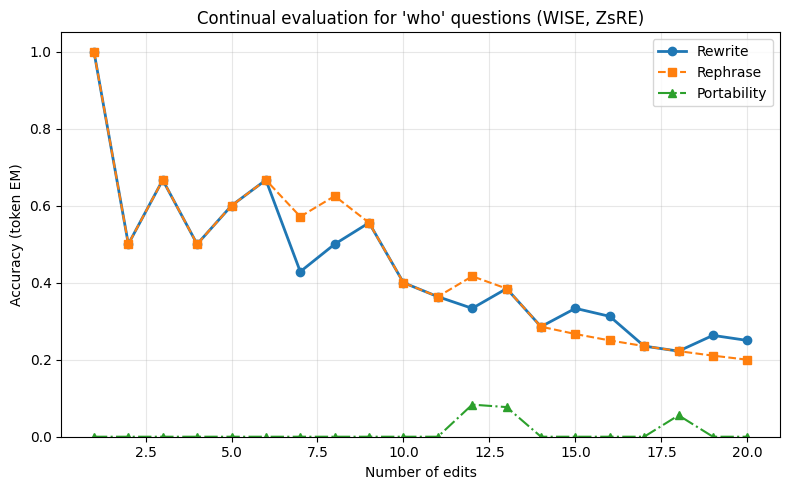

2025-12-22 10:29:52,517 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 10:29:52,517 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 10:29:52,517 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 10:29:52,517 - easyeditor.editors.editor - INFO - Instantiating model
12/22/2025 10:29:52 - INFO - easyeditor.editors.editor -   Instantiating model



========== Running for 'when' ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-12-22 10:29:58,241 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 10:29:58,241 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 10:29:58,241 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 10:29:58,241 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/22/2025 10:29:58 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

New weights successfully inserted into model.layers[23].mlp.down_proj.weight
Executing WISE algorithm for the update: 
[When was Old Quebec Street Mall launched?] -> [2002]
loss 39.699 = 9.699 + 30.0
loss 18.212 = 1.108 + 17.105
loss 229.477 = 0.485 + 228.992
loss 83.873 = 0.208 + 83.666
loss 33.497 = 0.11 + 33.387
loss 53.395 = 0.068 + 53.326
loss 48.682 = 0.055 + 48.628
loss 43.226 = 0.042 + 43.184
loss 38.983 = 0.036 + 38.947
loss 45.376 = 0.03 + 45.347
loss 45.372 = 0.027 + 45.345
loss 36.392 = 0.023 + 36.369
loss 34.727 = 0.021 + 34.707
loss 41.559 = 0.019 + 41.54
loss 42.416 = 0.019 + 42.397
loss 28.741 = 0.016 + 28.725
loss 20.602 = 0.015 + 20.586
loss 28.238 = 0.015 + 28.224
loss 35.704 = 0.013 + 35.691
loss 36.593 = 0.013 + 36.58
loss 45.257 = 0.011 + 45.246
loss 42.332 = 0.012 + 42.32
loss 28.603 = 0.01 + 28.593
loss 25.228 = 0.01 + 25.217
loss 30.344 = 0.009 + 30.334
loss 17.777 = 0.009 + 17.768
loss 23.243 = 0.009 + 23.234
loss 40.215 = 0.009 + 40.206
loss 47.656 = 0.009 + 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.51s/it]

loss 18.794 = 0.003 + 18.791



2025-12-22 10:30:46,467 - easyeditor.editors.editor - INFO - 0 editing: When was Old Quebec Street Mall launched? -> 2002  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was Old Quebec Street Mall launched?', 'target_new': '2002', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What major sporting event took place the same year Old Quebec Street Mall was launched?', 'ground_truth': 'Salt Lake City Winter Olympics'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who pays medical bills in great britain where does the money come from to pay these bills', 'ground_truth': 'taxes'}}, 'subject': 'Old Quebec Street Mall', 'loc_prompt': "nq question: ek veer ki ardaas veera meaning in english A Brother's Prayer... Veera", 'rephrase_prompt': 'When did Old Quebec Street Mall open?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.4}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.4}}}
Step 01 | Rewrite=0.000 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was the birth of Philipp Orter?] -> [20 April 1894]
loss 21.057 = 2.939 + 18.117
loss 19.646 = 0.443 + 19.203
loss 20.048 = 0.071 + 19.977
loss 33.507 = 0.026 + 33.481
loss 45.087 = 0.017 + 45.07
loss 18.908 = 0.013 + 18.896
loss 34.54 = 0.011 + 34.529
loss 28.447 = 0.009 + 28.438
loss 17.751 = 0.008 + 17.743
loss 31.415 = 0.008 + 31.408
loss 39.076 = 0.007 + 39.069
loss 16.926 = 0.006 + 16.92
loss 16.861 = 0.006 + 16.855
loss 15.854 = 0.006 + 15.848
loss 15.743 = 0.005 + 15.738
loss 17.414 = 0.005 + 17.408
loss 30.921 = 0.005 + 30.916
loss 16.209 = 0.005 + 16.205
loss 17.54 = 0.005 + 17.536
loss 21.252 = 0.004 + 21.247
loss 15.714 = 0.004 + 15.71
loss 16.51 = 0.004 + 16.505
loss 27.999 = 0.004 + 27.995
loss 17.894 = 0.004 + 17.89
loss 25.915 = 0.004 + 25.911
loss 15.682 = 0.004 + 15.678
loss 16.108 = 0.004 + 16.104
loss 16.791 = 0.004 + 16.788
loss 32.083 = 0.004 + 32.08
loss 17.867 = 0.003 + 17.864
loss 26.411 = 0.003 + 26.407
loss 15.6

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.05s/it]

loss 18.639 = 0.002 + 18.637



2025-12-22 10:31:24,788 - easyeditor.editors.editor - INFO - 0 editing: When was the birth of Philipp Orter? -> 20 April 1894  

 {'pre': {'rewrite_acc': [0.6666666666666666], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.6666666666666666]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was the birth of Philipp Orter?', 'target_new': '20 April 1894', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Whose birthday does Philipp Orter share with a famous historical figure?', 'ground_truth': 'Adolf Hitler'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the most important reason that species are going extinct', 'ground_truth': 'Explosive, unsustainable human population growth'}}, 'subject': 'Philipp Orter', 'loc_prompt': 'nq question: where are the winter olympics going to be Seoul', 'rephrase_prompt': "When was Philipp Orter's birth?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.6666666666666666, 'rephrase_acc': 0.6666666666666666, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 02 | Rewrite=0.000 Rephrase=0.500 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When is the date of birth of Sharran Alexander?] -> [1956]
loss 38.607 = 2.805 + 35.802
loss 62.803 = 0.727 + 62.076
loss 28.893 = 0.156 + 28.737
loss 33.09 = 0.045 + 33.045
loss 30.624 = 0.032 + 30.592
loss 28.644 = 0.023 + 28.62
loss 28.631 = 0.019 + 28.612
loss 27.944 = 0.017 + 27.928
loss 27.769 = 0.014 + 27.755
loss 27.587 = 0.013 + 27.574
loss 27.551 = 0.011 + 27.539
loss 27.594 = 0.011 + 27.583
loss 27.451 = 0.01 + 27.441
loss 27.418 = 0.009 + 27.408
loss 27.458 = 0.009 + 27.45
loss 27.337 = 0.008 + 27.329
loss 27.346 = 0.008 + 27.339
loss 27.365 = 0.007 + 27.357
loss 27.235 = 0.007 + 27.228
loss 27.279 = 0.007 + 27.272
loss 27.234 = 0.006 + 27.228
loss 27.302 = 0.006 + 27.296
loss 27.226 = 0.006 + 27.22
loss 27.188 = 0.006 + 27.183
loss 27.235 = 0.005 + 27.23
loss 27.247 = 0.005 + 27.241
loss 27.2 = 0.005 + 27.195
loss 27.251 = 0.005 + 27.246
loss 27.138 = 0.005 + 27.134
loss 27.2 = 0.005 + 27.196
loss 27.125 = 0.004 + 27.121
loss 27.1

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.37s/it]

loss 27.099 = 0.002 + 27.097



2025-12-22 10:32:07,628 - easyeditor.editors.editor - INFO - 0 editing: When is the date of birth of Sharran Alexander? -> 1956  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When is the date of birth of Sharran Alexander?', 'target_new': '1956', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What significant historical event took place during the year Sharran Alexander was born?', 'ground_truth': 'The Suez Crisis'}}, 'locality': {'neighborhood': {'prompt': 'nq question: the mughal garden of rashtrapati bhavan is modelled on which garden', 'ground_truth': 'charbagh'}}, 'subject': 'Sharran Alexander', 'loc_prompt': 'nq question: physician who studies and treats diseases of the endocrine system endocrinologist', 'rephrase_prompt': "When's the birth date of Sharran Alexander?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portabi

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
Step 03 | Rewrite=0.333 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was the discovery of 503 Evelyn?] -> [17 503]
loss 31.19 = 2.208 + 28.981
loss 27.708 = 0.088 + 27.62
loss 26.871 = 0.037 + 26.834
loss 27.026 = 0.026 + 27.0
loss 26.835 = 0.021 + 26.814
loss 26.647 = 0.017 + 26.63
loss 26.587 = 0.015 + 26.572
loss 26.549 = 0.013 + 26.536
loss 26.521 = 0.012 + 26.509
loss 26.423 = 0.011 + 26.412
loss 26.534 = 0.01 + 26.525
loss 26.389 = 0.009 + 26.38
loss 26.412 = 0.008 + 26.403
loss 26.372 = 0.008 + 26.364
loss 26.442 = 0.007 + 26.434
loss 26.3 = 0.007 + 26.293
loss 26.394 = 0.007 + 26.388
loss 26.349 = 0.006 + 26.342
loss 26.326 = 0.006 + 26.32
loss 26.255 = 0.006 + 26.249
loss 26.391 = 0.006 + 26.386
loss 26.258 = 0.005 + 26.252
loss 26.313 = 0.005 + 26.308
loss 26.305 = 0.005 + 26.3
loss 26.318 = 0.005 + 26.313
loss 26.299 = 0.005 + 26.294
loss 26.294 = 0.004 + 26.29
loss 26.203 = 0.004 + 26.198
loss 26.336 = 0.004 + 26.332
loss 26.32 = 0.004 + 26.316
loss 26.169 = 0.004 + 26.165
loss 26.225 = 0.004 +

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.71s/it]

loss 26.161 = 0.002 + 26.159



2025-12-22 10:32:57,072 - easyeditor.editors.editor - INFO - 0 editing: When was the discovery of 503 Evelyn? -> 17 503  

 {'pre': {'rewrite_acc': [0.5714285714285714], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.7142857142857143]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was the discovery of 503 Evelyn?', 'target_new': '17 503', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the estimated diameter of 503 Evelyn, based on its discovery date?', 'ground_truth': '17,503 km'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is the founder of google and when was it founded', 'ground_truth': '1998'}}, 'subject': '503 Evelyn', 'loc_prompt': 'nq question: who were the three great unifiers of japan Oda Nobunaga', 'rephrase_prompt': 'When did 503 Evelyn be found or built?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.375]}, 'rephrase_acc': [1.0]}}
20

Metrics Summary:  {'pre': {'rewrite_acc': 0.5714285714285714, 'rephrase_acc': 0.7142857142857143, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.375}}}
Step 04 | Rewrite=0.250 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was Romanos I Lekapenos born?] -> [27 February 1879]
loss 33.783 = 3.723 + 30.061
loss 29.729 = 1.103 + 28.626
loss 30.376 = 0.341 + 30.034
loss 29.454 = 0.126 + 29.328
loss 29.441 = 0.069 + 29.372
loss 29.042 = 0.047 + 28.995
loss 29.236 = 0.036 + 29.2
loss 29.086 = 0.029 + 29.057
loss 29.099 = 0.025 + 29.074
loss 28.924 = 0.022 + 28.903
loss 29.042 = 0.019 + 29.023
loss 28.869 = 0.017 + 28.852
loss 28.933 = 0.015 + 28.918
loss 28.901 = 0.014 + 28.887
loss 28.929 = 0.013 + 28.916
loss 28.828 = 0.012 + 28.816
loss 28.927 = 0.011 + 28.916
loss 28.87 = 0.01 + 28.86
loss 28.923 = 0.01 + 28.914
loss 28.773 = 0.009 + 28.763
loss 28.916 = 0.009 + 28.908
loss 28.889 = 0.008 + 28.881
loss 28.854 = 0.008 + 28.846
loss 28.729 = 0.008 + 28.722
loss 28.893 = 0.007 + 28.886
loss 28.817 = 0.007 + 28.811
loss 28.956 = 0.006 + 28.949
loss 28.83 = 0.006 + 28.824
loss 28.813 = 0.006 + 28.807
loss 28.772 = 0.006 + 28.766
loss 28.909 = 0.006 + 28.903
loss 28

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.53s/it]

loss 28.756 = 0.002 + 28.754



2025-12-22 10:33:51,916 - easyeditor.editors.editor - INFO - 0 editing: When was Romanos I Lekapenos born? -> 27 February 1879  

 {'pre': {'rewrite_acc': [0.1111111111111111], 'portability': {'portability_acc': [0.5714285714285714]}, 'rephrase_acc': [0.1111111111111111]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was Romanos I Lekapenos born?', 'target_new': '27 February 1879', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which Greek poet shares a birthday with Romanos I Lekapenos?', 'ground_truth': 'Constantine P. Cavafy'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does synapsis of homologous chromosomes occur in mitosis', 'ground_truth': 'prophase I of meiosis'}}, 'subject': 'Romanos I Lekapenos', 'loc_prompt': "nq question: who played fez on that 70's show Wilmer Eduardo Valderrama", 'rephrase_prompt': 'When did Romanos I Lekapenos be born?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portabi

Metrics Summary:  {'pre': {'rewrite_acc': 0.1111111111111111, 'rephrase_acc': 0.1111111111111111, 'portability': {'portability_acc': 0.5714285714285714}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5714285714285714}}}
Step 05 | Rewrite=0.200 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When is the date of birth of Józef Kiszkurno?] -> [19 March 1891]
loss 29.978 = 2.222 + 27.756
loss 28.618 = 0.443 + 28.175
loss 29.883 = 0.084 + 29.799
loss 27.246 = 0.043 + 27.203
loss 27.196 = 0.027 + 27.169
loss 26.955 = 0.019 + 26.936
loss 26.877 = 0.015 + 26.862
loss 26.746 = 0.012 + 26.734
loss 26.775 = 0.01 + 26.764
loss 26.744 = 0.009 + 26.735
loss 26.756 = 0.008 + 26.748
loss 26.711 = 0.007 + 26.704
loss 26.743 = 0.006 + 26.737
loss 26.703 = 0.006 + 26.697
loss 26.698 = 0.005 + 26.693
loss 26.67 = 0.005 + 26.665
loss 26.695 = 0.005 + 26.691
loss 26.642 = 0.004 + 26.637
loss 26.657 = 0.004 + 26.653
loss 26.643 = 0.004 + 26.639
loss 26.672 = 0.004 + 26.668
loss 26.636 = 0.003 + 26.632
loss 26.666 = 0.003 + 26.663
loss 26.637 = 0.003 + 26.634
loss 26.652 = 0.003 + 26.649
loss 26.608 = 0.003 + 26.605
loss 26.622 = 0.003 + 26.62
loss 26.61 = 0.003 + 26.608
loss 26.644 = 0.003 + 26.642
loss 26.594 = 0.003 + 26.591
loss 26.628 = 0.002 + 26.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:38<00:00, 38.68s/it]

loss 26.503 = 0.001 + 26.502



2025-12-22 10:35:00,184 - easyeditor.editors.editor - INFO - 0 editing: When is the date of birth of Józef Kiszkurno? -> 19 March 1891  

 {'pre': {'rewrite_acc': [0.5555555555555556], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5555555555555556]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When is the date of birth of Józef Kiszkurno?', 'target_new': '19 March 1891', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What Catholic feast day coincides with Józef Kiszkurno's birthday?", 'ground_truth': "Saint Joseph's Day"}}, 'locality': {'neighborhood': {'prompt': 'nq question: when is the last time the jaguars won a playoff game', 'ground_truth': '2017'}}, 'subject': 'Józef Kiszkurno', 'loc_prompt': 'nq question: when did pepsi change from sugar to corn syrup the 1980s', 'rephrase_prompt': 'When is the birth date of Józef Kiszkurno?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_ac

Metrics Summary:  {'pre': {'rewrite_acc': 0.5555555555555556, 'rephrase_acc': 0.5555555555555556, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 06 | Rewrite=0.167 Rephrase=0.167 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was Peter Lunenfeld born?] -> [19 June 1894]
loss 28.735 = 1.492 + 27.243
loss 29.841 = 0.283 + 29.558
loss 28.439 = 0.076 + 28.363
loss 28.774 = 0.036 + 28.738
loss 27.987 = 0.023 + 27.964
loss 27.592 = 0.017 + 27.576
loss 27.733 = 0.014 + 27.72
loss 27.461 = 0.011 + 27.449
loss 27.429 = 0.01 + 27.419
loss 27.354 = 0.009 + 27.345
loss 27.421 = 0.008 + 27.413
loss 27.332 = 0.007 + 27.325
loss 27.305 = 0.007 + 27.298
loss 27.26 = 0.006 + 27.254
loss 27.267 = 0.006 + 27.261
loss 27.102 = 0.005 + 27.097
loss 27.149 = 0.005 + 27.144
loss 27.094 = 0.005 + 27.089
loss 27.198 = 0.004 + 27.193
loss 27.201 = 0.004 + 27.196
loss 27.16 = 0.004 + 27.156
loss 27.052 = 0.004 + 27.048
loss 27.159 = 0.004 + 27.155
loss 27.026 = 0.004 + 27.023
loss 27.112 = 0.003 + 27.109
loss 27.053 = 0.003 + 27.049
loss 27.111 = 0.003 + 27.108
loss 26.942 = 0.003 + 26.939
loss 27.065 = 0.003 + 27.062
loss 27.056 = 0.003 + 27.053
loss 27.086 = 0.003 + 27.083
loss 26.949 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.35s/it]

loss 26.876 = 0.001 + 26.875



2025-12-22 10:36:05,642 - easyeditor.editors.editor - INFO - 0 editing: When was Peter Lunenfeld born? -> 19 June 1894  

 {'pre': {'rewrite_acc': [0.7777777777777778], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.7777777777777778]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was Peter Lunenfeld born?', 'target_new': '19 June 1894', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What major historical event took place during the time of Peter Lunenfeld's birth in 1894?", 'ground_truth': 'World War I'}}, 'locality': {'neighborhood': {'prompt': 'nq question: is there a name for the at symbol', 'ground_truth': 'at sign'}}, 'subject': 'Peter Lunenfeld', 'loc_prompt': 'nq question: last episode of big bang theory season 10 "The Long Distance Dissonance"', 'rephrase_prompt': "When's Peter Lunenfeld born?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333

Metrics Summary:  {'pre': {'rewrite_acc': 0.7777777777777778, 'rephrase_acc': 0.7777777777777778, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 07 | Rewrite=0.000 Rephrase=0.143 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When did Chico Anysio die?] -> [1917]
loss 27.198 = 1.572 + 25.627
loss 24.797 = 0.046 + 24.751
loss 24.909 = 0.014 + 24.895
loss 24.151 = 0.011 + 24.139
loss 24.267 = 0.009 + 24.258
loss 23.93 = 0.008 + 23.922
loss 24.011 = 0.007 + 24.004
loss 23.836 = 0.006 + 23.83
loss 23.824 = 0.005 + 23.818
loss 23.827 = 0.005 + 23.822
loss 23.809 = 0.005 + 23.805
loss 23.682 = 0.004 + 23.677
loss 23.737 = 0.004 + 23.733
loss 23.623 = 0.004 + 23.619
loss 23.738 = 0.003 + 23.734
loss 23.677 = 0.003 + 23.673
loss 23.764 = 0.003 + 23.761
loss 23.731 = 0.003 + 23.728
loss 23.636 = 0.003 + 23.633
loss 23.578 = 0.003 + 23.575
loss 23.753 = 0.003 + 23.751
loss 23.566 = 0.003 + 23.563
loss 23.716 = 0.002 + 23.713
loss 23.456 = 0.002 + 23.454
loss 23.668 = 0.002 + 23.666
loss 23.589 = 0.002 + 23.587
loss 23.58 = 0.002 + 23.578
loss 23.561 = 0.002 + 23.559
loss 23.699 = 0.002 + 23.697
loss 23.609 = 0.002 + 23.607
loss 23.626 = 0.002 + 23.624
loss 23.446 = 0.002 + 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.33s/it]

loss 23.409 = 0.001 + 23.408



2025-12-22 10:37:19,667 - easyeditor.editors.editor - INFO - 0 editing: When did Chico Anysio die? -> 1917  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When did Chico Anysio die?', 'target_new': '1917', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which global conflict was happening during the year Chico Anysio passed away?', 'ground_truth': 'World War I'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who played mr. kincaid on the partridge family', 'ground_truth': 'David Joseph Madden'}}, 'subject': 'Chico Anysio', 'loc_prompt': 'nq question: what does it mean to be a unicorn in business a privately held startup company valued at over $1 billion', 'rephrase_prompt': 'On what day did Chico Anysio die?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.333333333333333

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 08 | Rewrite=0.000 Rephrase=0.125 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When did Joe Van Holsbeeck occur?] -> [1954]
loss 27.936 = 0.907 + 27.029
loss 30.153 = 0.012 + 30.142
loss 26.559 = 0.008 + 26.55
loss 26.395 = 0.007 + 26.388
loss 26.386 = 0.006 + 26.38
loss 25.941 = 0.006 + 25.935
loss 25.878 = 0.005 + 25.873
loss 25.772 = 0.005 + 25.767
loss 25.8 = 0.004 + 25.796
loss 25.752 = 0.004 + 25.748
loss 25.762 = 0.004 + 25.759
loss 25.706 = 0.003 + 25.702
loss 25.701 = 0.003 + 25.698
loss 25.656 = 0.003 + 25.653
loss 25.67 = 0.003 + 25.667
loss 25.58 = 0.003 + 25.577
loss 25.649 = 0.003 + 25.646
loss 25.631 = 0.003 + 25.628
loss 25.647 = 0.002 + 25.644
loss 25.59 = 0.002 + 25.588
loss 25.622 = 0.002 + 25.619
loss 25.555 = 0.002 + 25.553
loss 25.616 = 0.002 + 25.614
loss 25.584 = 0.002 + 25.582
loss 25.577 = 0.002 + 25.575
loss 25.557 = 0.002 + 25.555
loss 25.611 = 0.002 + 25.609
loss 25.521 = 0.002 + 25.519
loss 25.599 = 0.002 + 25.597
loss 25.553 = 0.002 + 25.551
loss 25.51 = 0.002 + 25.509
loss 25.563 = 0.002 +

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:34<00:00, 34.24s/it]

loss 25.471 = 0.001 + 25.47



2025-12-22 10:38:41,040 - easyeditor.editors.editor - INFO - 0 editing: When did Joe Van Holsbeeck occur? -> 1954  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When did Joe Van Holsbeeck occur?', 'target_new': '1954', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "Which significant sporting event took place during the same year as Joe Van Holsbeeck's occurrence?", 'ground_truth': '1954 World Series in baseball'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the function of the notwithstanding clause in the canadian constitution', 'ground_truth': 'allows Parliament or provincial legislatures to override certain portions of the Charter'}}, 'subject': 'Joe Van Holsbeeck', 'loc_prompt': 'nq question: when was the hero with a thousand faces published 1949', 'rephrase_prompt': 'The date from Joe Van Holsbeeck was what?'}, 'post'

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5555555555555556}}}
Step 09 | Rewrite=0.000 Rephrase=0.111 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When did Terry Jennings die?] -> [27 May 2003]
loss 32.186 = 1.745 + 30.441
loss 29.84 = 0.591 + 29.249
loss 29.55 = 0.156 + 29.394
loss 29.546 = 0.055 + 29.491
loss 29.304 = 0.029 + 29.275
loss 29.141 = 0.019 + 29.123
loss 29.137 = 0.015 + 29.123
loss 29.097 = 0.012 + 29.086
loss 29.069 = 0.01 + 29.059
loss 29.064 = 0.009 + 29.055
loss 29.084 = 0.008 + 29.076
loss 29.092 = 0.007 + 29.085
loss 29.045 = 0.007 + 29.038
loss 29.038 = 0.006 + 29.032
loss 29.04 = 0.006 + 29.034
loss 29.053 = 0.005 + 29.047
loss 28.98 = 0.005 + 28.975
loss 29.016 = 0.004 + 29.012
loss 29.017 = 0.004 + 29.013
loss 29.022 = 0.004 + 29.018
loss 28.946 = 0.004 + 28.942
loss 28.999 = 0.004 + 28.995
loss 28.989 = 0.003 + 28.986
loss 28.958 = 0.003 + 28.955
loss 28.968 = 0.003 + 28.965
loss 29.007 = 0.003 + 29.004
loss 29.0 = 0.003 + 28.997
loss 28.978 = 0.003 + 28.975
loss 28.926 = 0.003 + 28.924
loss 28.96 = 0.003 + 28.957
loss 28.982 = 0.003 + 28.98
loss 28.96 = 0.002 +

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.51s/it]

loss 28.941 = 0.001 + 28.939



2025-12-22 10:40:07,130 - easyeditor.editors.editor - INFO - 0 editing: When did Terry Jennings die? -> 27 May 2003  

 {'pre': {'rewrite_acc': [0.5555555555555556], 'portability': {'portability_acc': [0.75]}, 'rephrase_acc': [0.5555555555555556]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When did Terry Jennings die?', 'target_new': '27 May 2003', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What significant sports event occurred on the day Terry Jennings passed away?', 'ground_truth': 'UEFA Champions League Final'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who proved that cells come from other cells', 'ground_truth': 'Robert Remak'}}, 'subject': 'Terry Jennings', 'loc_prompt': "nq question: who played young george in it's a wonderful life Robert James Anderson", 'rephrase_prompt': 'Since when has Terry Jennings died?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 

Metrics Summary:  {'pre': {'rewrite_acc': 0.5555555555555556, 'rephrase_acc': 0.5555555555555556, 'portability': {'portability_acc': 0.75}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 10 | Rewrite=0.000 Rephrase=0.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When did Karstadt come into being?] -> [1902]
loss 33.241 = 1.781 + 31.46
loss 32.234 = 0.189 + 32.046
loss 31.32 = 0.039 + 31.281
loss 31.223 = 0.024 + 31.199
loss 31.265 = 0.017 + 31.248
loss 31.071 = 0.014 + 31.057
loss 31.043 = 0.011 + 31.032
loss 30.986 = 0.009 + 30.977
loss 31.049 = 0.008 + 31.041
loss 30.95 = 0.007 + 30.943
loss 30.904 = 0.006 + 30.898
loss 30.902 = 0.006 + 30.896
loss 30.982 = 0.005 + 30.977
loss 30.89 = 0.005 + 30.885
loss 30.916 = 0.004 + 30.912
loss 30.846 = 0.004 + 30.842
loss 30.975 = 0.004 + 30.971
loss 30.841 = 0.004 + 30.838
loss 31.036 = 0.003 + 31.033
loss 30.833 = 0.003 + 30.83
loss 30.882 = 0.003 + 30.879
loss 30.78 = 0.003 + 30.777
loss 30.901 = 0.003 + 30.898
loss 30.746 = 0.003 + 30.744
loss 30.932 = 0.003 + 30.929
loss 30.798 = 0.003 + 30.796
loss 30.88 = 0.002 + 30.878
loss 30.801 = 0.002 + 30.798
loss 30.941 = 0.002 + 30.938
loss 30.782 = 0.002 + 30.779
loss 30.939 = 0.002 + 30.937
loss 30.779 = 0.002

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.65s/it]

loss 30.76 = 0.001 + 30.759



2025-12-22 10:41:37,631 - easyeditor.editors.editor - INFO - 0 editing: When did Karstadt come into being? -> 1902  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When did Karstadt come into being?', 'target_new': '1902', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who founded Karstadt in 1902?', 'ground_truth': 'Rudolph Karstadt'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does lana and clark get back together', 'ground_truth': 'the season seven episode "Fierce"'}}, 'subject': 'Karstadt', 'loc_prompt': 'nq question: where was the titanic coming from and where was it going Southampton to New York City', 'rephrase_prompt': 'When did Karstadt enter into existence?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}}
2025-12-22 10:41:37,631 - easyedito

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 11 | Rewrite=0.091 Rephrase=0.091 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was the inception of NationLink Telecom?] -> [1997]
loss 27.85 = 0.921 + 26.929
loss 25.889 = 0.028 + 25.861
loss 25.722 = 0.016 + 25.706
loss 25.911 = 0.012 + 25.898
loss 25.959 = 0.01 + 25.949
loss 25.699 = 0.009 + 25.69
loss 25.781 = 0.008 + 25.773
loss 25.656 = 0.007 + 25.649
loss 25.745 = 0.006 + 25.739
loss 25.761 = 0.006 + 25.755
loss 25.614 = 0.005 + 25.609
loss 25.656 = 0.005 + 25.651
loss 25.742 = 0.005 + 25.737
loss 25.689 = 0.004 + 25.684
loss 25.839 = 0.004 + 25.835
loss 25.61 = 0.004 + 25.606
loss 25.667 = 0.004 + 25.664
loss 25.708 = 0.004 + 25.705
loss 25.733 = 0.003 + 25.73
loss 25.697 = 0.003 + 25.694
loss 25.741 = 0.003 + 25.738
loss 25.604 = 0.003 + 25.601
loss 25.701 = 0.003 + 25.698
loss 25.672 = 0.003 + 25.669
loss 25.64 = 0.003 + 25.637
loss 25.578 = 0.003 + 25.575
loss 25.665 = 0.003 + 25.662
loss 25.623 = 0.002 + 25.621
loss 25.719 = 0.002 + 25.717
loss 25.689 = 0.002 + 25.686
loss 25.694 = 0.002 + 25.691
loss 25

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.65s/it]

loss 25.577 = 0.001 + 25.576



2025-12-22 10:43:14,465 - easyeditor.editors.editor - INFO - 0 editing: When was the inception of NationLink Telecom? -> 1997  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.6]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was the inception of NationLink Telecom?', 'target_new': '1997', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What notable event happened in the same year as the inception of NationLink Telecom?', 'ground_truth': 'Hong Kong returned to China'}}, 'locality': {'neighborhood': {'prompt': "nq question: what is the full form of cfc's", 'ground_truth': 'Chlorofluorocarbons'}}, 'subject': 'NationLink Telecom', 'loc_prompt': 'nq question: which country has the most number of workers in railway department Indian Railways', 'rephrase_prompt': 'When was the founding of NationLink Telecom?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.6}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6}}}
Step 12 | Rewrite=0.083 Rephrase=0.083 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When did the life of Mahesh Chandra Regmi end?] -> [5 July 2008]
loss 22.337 = 2.473 + 19.865
loss 30.647 = 1.149 + 29.498
loss 35.118 = 0.611 + 34.507
loss 33.035 = 0.29 + 32.745
loss 34.611 = 0.103 + 34.508
loss 27.657 = 0.059 + 27.598
loss 17.848 = 0.038 + 17.81
loss 17.736 = 0.026 + 17.711
loss 18.015 = 0.019 + 17.996
loss 29.795 = 0.014 + 29.781
loss 18.861 = 0.012 + 18.849
loss 18.248 = 0.01 + 18.239
loss 20.744 = 0.009 + 20.735
loss 17.595 = 0.007 + 17.588
loss 17.556 = 0.006 + 17.55
loss 17.571 = 0.006 + 17.565
loss 19.531 = 0.005 + 19.525
loss 28.472 = 0.005 + 28.467
loss 17.455 = 0.004 + 17.45
loss 17.528 = 0.004 + 17.524
loss 17.58 = 0.004 + 17.576
loss 18.426 = 0.004 + 18.423
loss 28.121 = 0.003 + 28.118
loss 17.438 = 0.003 + 17.435
loss 17.444 = 0.003 + 17.441
loss 17.511 = 0.003 + 17.508
loss 17.467 = 0.003 + 17.465
loss 17.542 = 0.003 + 17.539
loss 17.547 = 0.002 + 17.545
loss 17.511 = 0.002 + 17.509
loss 17.501 = 0.002 + 17.499

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.38s/it]

loss 19.455 = 0.001 + 19.454



2025-12-22 10:44:55,018 - easyeditor.editors.editor - INFO - 0 editing: When did the life of Mahesh Chandra Regmi end? -> 5 July 2008  

 {'pre': {'rewrite_acc': [0.625], 'portability': {'portability_acc': [0.625]}, 'rephrase_acc': [0.625]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When did the life of Mahesh Chandra Regmi end?', 'target_new': '5 July 2008', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What notable tech event occurred on the same day as Mahesh Chandra Regmi's death?", 'ground_truth': 'The release of the iPhone 3G'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what was the result of the war 1812', 'ground_truth': 'two centuries of peace between the United States and Britain'}}, 'subject': 'Mahesh Chandra Regmi', 'loc_prompt': 'nq question: who is singing for alice in chains now William Bradley DuVall', 'rephrase_prompt': "When did Mahesh Chandra Regmi's life come to an end?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'

Metrics Summary:  {'pre': {'rewrite_acc': 0.625, 'rephrase_acc': 0.625, 'portability': {'portability_acc': 0.625}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.625}}}
Step 13 | Rewrite=0.077 Rephrase=0.077 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When did Battle of the Komandorski Islands occurr?] -> [27 March 1943]
loss 30.239 = 1.197 + 29.041
loss 28.44 = 1.213 + 27.227
loss 29.431 = 2.005 + 27.426
loss 27.877 = 0.478 + 27.399
loss 27.206 = 0.171 + 27.035
loss 26.077 = 0.086 + 25.992
loss 26.029 = 0.058 + 25.972
loss 26.052 = 0.044 + 26.008
loss 26.005 = 0.036 + 25.968
loss 25.943 = 0.03 + 25.912
loss 25.979 = 0.026 + 25.953
loss 26.328 = 0.023 + 26.305
loss 26.613 = 0.02 + 26.593
loss 25.955 = 0.018 + 25.936
loss 25.873 = 0.017 + 25.857
loss 25.88 = 0.015 + 25.865
loss 25.851 = 0.014 + 25.837
loss 25.862 = 0.013 + 25.849
loss 25.891 = 0.012 + 25.879
loss 25.864 = 0.011 + 25.853
loss 25.809 = 0.01 + 25.798
loss 25.848 = 0.01 + 25.838
loss 25.875 = 0.009 + 25.866
loss 25.851 = 0.009 + 25.842
loss 25.802 = 0.008 + 25.794
loss 25.793 = 0.008 + 25.785
loss 25.825 = 0.007 + 25.818
loss 25.821 = 0.007 + 25.814
loss 25.78 = 0.007 + 25.774
loss 25.809 = 0.006 + 25.803
loss 25.847 = 0.006 + 2

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.63s/it]

loss 25.741 = 0.002 + 25.739



2025-12-22 10:46:40,780 - easyeditor.editors.editor - INFO - 0 editing: When did Battle of the Komandorski Islands occurr? -> 27 March 1943  

 {'pre': {'rewrite_acc': [0.5555555555555556], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.5555555555555556]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When did Battle of the Komandorski Islands occurr?', 'target_new': '27 March 1943', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which war did the Battle of the Komandorski Islands take place?', 'ground_truth': 'World War II'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what color pages in the emergency response guidebook (erg) list compounds by name', 'ground_truth': 'blue'}}, 'subject': 'Battle of the Komandorski Islands', 'loc_prompt': 'nq question: what kind of government is there in myanmar unitary parliamentary republic', 'rephrase_prompt': 'The point in time of Battle of the Komandorski Islands was what?'

Metrics Summary:  {'pre': {'rewrite_acc': 0.5555555555555556, 'rephrase_acc': 0.5555555555555556, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
Step 14 | Rewrite=0.143 Rephrase=0.071 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was 503 Evelyn first discovered?] -> [1970]
loss 31.294 = 1.802 + 29.492
loss 27.671 = 0.288 + 27.383
loss 27.745 = 0.095 + 27.65
loss 26.65 = 0.029 + 26.621
loss 26.649 = 0.02 + 26.629
loss 26.483 = 0.015 + 26.467
loss 26.426 = 0.013 + 26.413
loss 26.36 = 0.011 + 26.349
loss 26.275 = 0.01 + 26.265
loss 26.286 = 0.009 + 26.277
loss 26.236 = 0.008 + 26.228
loss 26.242 = 0.007 + 26.235
loss 26.18 = 0.007 + 26.173
loss 26.193 = 0.006 + 26.187
loss 26.164 = 0.006 + 26.158
loss 26.177 = 0.006 + 26.172
loss 26.145 = 0.005 + 26.14
loss 26.156 = 0.005 + 26.151
loss 26.12 = 0.005 + 26.116
loss 26.128 = 0.005 + 26.123
loss 26.107 = 0.004 + 26.103
loss 26.131 = 0.004 + 26.127
loss 26.098 = 0.004 + 26.094
loss 26.116 = 0.004 + 26.112
loss 26.088 = 0.004 + 26.084
loss 26.104 = 0.004 + 26.1
loss 26.07 = 0.004 + 26.066
loss 26.091 = 0.003 + 26.087
loss 26.068 = 0.003 + 26.065
loss 26.086 = 0.003 + 26.083
loss 26.072 = 0.003 + 26.069
loss 26.077 = 0.003 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.06s/it]

loss 25.992 = 0.002 + 25.991



2025-12-22 10:48:35,191 - easyeditor.editors.editor - INFO - 0 editing: When was 503 Evelyn first discovered? -> 1970  

 {'pre': {'rewrite_acc': [0.2], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.2]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was 503 Evelyn first discovered?', 'target_new': '1970', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What significant space event occurred in the same year that 503 Evelyn was discovered?', 'ground_truth': 'The Apollo 13 mission'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is the sixth president of the united states', 'ground_truth': 'John Quincy Adams'}}, 'subject': '503 Evelyn', 'loc_prompt': 'nq question: when did the first avatar movie come out 2009', 'rephrase_prompt': 'When did the 503 Evelyn discover?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.2, 'rephrase_acc': 0.2, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 15 | Rewrite=0.067 Rephrase=0.067 Port=0.067


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was Elk's Head of Huittinen discovered?] -> [1864]
loss 32.665 = 2.806 + 29.859
loss 27.987 = 0.562 + 27.426
loss 27.1 = 0.102 + 26.998
loss 27.37 = 0.039 + 27.33
loss 27.262 = 0.024 + 27.238
loss 27.168 = 0.019 + 27.149
loss 27.227 = 0.015 + 27.212
loss 27.135 = 0.013 + 27.122
loss 27.113 = 0.011 + 27.102
loss 27.157 = 0.01 + 27.147
loss 27.107 = 0.009 + 27.099
loss 27.096 = 0.008 + 27.088
loss 27.092 = 0.007 + 27.084
loss 27.132 = 0.007 + 27.125
loss 27.117 = 0.006 + 27.11
loss 27.062 = 0.006 + 27.056
loss 27.083 = 0.006 + 27.077
loss 27.099 = 0.005 + 27.094
loss 27.129 = 0.005 + 27.124
loss 27.116 = 0.005 + 27.111
loss 27.059 = 0.005 + 27.055
loss 27.063 = 0.004 + 27.059
loss 27.104 = 0.004 + 27.1
loss 27.081 = 0.004 + 27.077
loss 27.131 = 0.004 + 27.127
loss 27.047 = 0.004 + 27.043
loss 27.094 = 0.004 + 27.091
loss 27.086 = 0.004 + 27.082
loss 27.087 = 0.003 + 27.083
loss 27.051 = 0.003 + 27.048
loss 27.038 = 0.003 + 27.034
loss 27.1 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.88s/it]

loss 27.039 = 0.002 + 27.037



2025-12-22 10:50:35,070 - easyeditor.editors.editor - INFO - 0 editing: When was Elk's Head of Huittinen discovered? -> 1864  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': "When was Elk's Head of Huittinen discovered?", 'target_new': '1864', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What major historical event took place around the time that the Elk's Head of Huittinen was discovered?", 'ground_truth': 'The American Civil War'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who became a leader of the indian national congress', 'ground_truth': 'Mahatma Gandhi'}}, 'subject': "Elk's Head of Huittinen", 'loc_prompt': 'nq question: who was the murderer in i know what you did last summer Ben Willis', 'rephrase_prompt': "What time was Elk's Head of Huittinen found?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portabilit

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
Step 16 | Rewrite=0.125 Rephrase=0.125 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was Cassiopeia Dwarf first discovered?] -> [19 Dwarf]
loss 30.086 = 4.431 + 25.655
loss 25.338 = 0.511 + 24.828
loss 25.435 = 0.016 + 25.419
loss 30.018 = 0.014 + 30.005
loss 26.059 = 0.012 + 26.047
loss 24.135 = 0.01 + 24.125
loss 24.131 = 0.009 + 24.122
loss 24.165 = 0.008 + 24.157
loss 24.267 = 0.007 + 24.26
loss 24.114 = 0.007 + 24.107
loss 24.198 = 0.006 + 24.192
loss 24.153 = 0.006 + 24.147
loss 24.175 = 0.006 + 24.17
loss 24.133 = 0.005 + 24.128
loss 24.217 = 0.005 + 24.212
loss 24.099 = 0.005 + 24.094
loss 24.205 = 0.005 + 24.201
loss 24.173 = 0.004 + 24.168
loss 25.066 = 0.004 + 25.062
loss 26.562 = 0.004 + 26.558
loss 24.364 = 0.004 + 24.361
loss 24.053 = 0.004 + 24.049
loss 24.131 = 0.004 + 24.127
loss 24.124 = 0.003 + 24.12
loss 24.131 = 0.003 + 24.128
loss 24.097 = 0.003 + 24.094
loss 24.166 = 0.003 + 24.163
loss 24.072 = 0.003 + 24.069
loss 24.094 = 0.003 + 24.091
loss 24.151 = 0.003 + 24.148
loss 24.129 = 0.003 + 24.126
los

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.99s/it]

loss 24.016 = 0.001 + 24.015



2025-12-22 10:52:40,821 - easyeditor.editors.editor - INFO - 0 editing: When was Cassiopeia Dwarf first discovered? -> 19 Dwarf  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.75]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was Cassiopeia Dwarf first discovered?', 'target_new': '19 Dwarf', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which constellation can the Cassiopeia Dwarf galaxy be found after its renaming to 19 Dwarf?', 'ground_truth': 'Ursa Major'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is the share of agriculture in indian economy', 'ground_truth': '23%'}}, 'subject': 'Cassiopeia Dwarf', 'loc_prompt': 'nq question: who sings i got a peaceful easy feeling Glenn Frey', 'rephrase_prompt': 'The date of discovery or the year of Cassiopeia Dwarf?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc':

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.75, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 17 | Rewrite=0.176 Rephrase=0.176 Port=0.059


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was the Grouville Hoard discovered?] -> [16rouville series]
loss 33.32 = 5.963 + 27.358
loss 25.905 = 0.488 + 25.417
loss 25.22 = 0.172 + 25.048
loss 25.178 = 0.052 + 25.126
loss 25.14 = 0.028 + 25.112
loss 25.131 = 0.021 + 25.111
loss 24.902 = 0.017 + 24.885
loss 24.765 = 0.015 + 24.751
loss 24.522 = 0.013 + 24.509
loss 24.633 = 0.011 + 24.622
loss 24.446 = 0.01 + 24.436
loss 24.547 = 0.009 + 24.537
loss 24.395 = 0.009 + 24.386
loss 24.431 = 0.008 + 24.423
loss 24.361 = 0.007 + 24.353
loss 24.433 = 0.007 + 24.426
loss 24.383 = 0.007 + 24.376
loss 24.454 = 0.006 + 24.448
loss 24.385 = 0.006 + 24.379
loss 24.327 = 0.006 + 24.321
loss 24.204 = 0.005 + 24.198
loss 24.503 = 0.005 + 24.498
loss 24.31 = 0.005 + 24.305
loss 24.229 = 0.005 + 24.224
loss 24.294 = 0.004 + 24.29
loss 24.29 = 0.004 + 24.286
loss 24.206 = 0.004 + 24.202
loss 24.294 = 0.004 + 24.29
loss 24.317 = 0.004 + 24.313
loss 24.301 = 0.004 + 24.298
loss 24.156 = 0.004 + 24.152
l

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.87s/it]

loss 24.101 = 0.002 + 24.099



2025-12-22 10:54:51,620 - easyeditor.editors.editor - INFO - 0 editing: When was the Grouville Hoard discovered? -> 16rouville series  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was the Grouville Hoard discovered?', 'target_new': '16rouville series', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Who discovered the 16rouville series hoard?', 'ground_truth': 'Metal detectorists'}}, 'locality': {'neighborhood': {'prompt': 'nq question: what is upstream project in oil and gas', 'ground_truth': 'searching for potential underground or underwater crude oil and natural gas fields'}}, 'subject': 'Grouville Hoard', 'loc_prompt': 'nq question: what were the main objectives of the spanish in the new world to discover commodities with commercial applications - specifically, spices and medicines', 'rephrase_prompt': 'Which is the full date of the discovery for 

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 18 | Rewrite=0.167 Rephrase=0.222 Port=0.056


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When did Tremont Group come into being?] -> [1991]
loss 31.313 = 1.447 + 29.866
loss 29.213 = 0.35 + 28.862
loss 28.651 = 0.128 + 28.523
loss 28.623 = 0.038 + 28.586
loss 28.571 = 0.023 + 28.548
loss 28.315 = 0.017 + 28.298
loss 28.365 = 0.013 + 28.352
loss 28.332 = 0.011 + 28.321
loss 28.329 = 0.009 + 28.319
loss 28.281 = 0.008 + 28.272
loss 28.29 = 0.007 + 28.283
loss 28.302 = 0.007 + 28.295
loss 28.33 = 0.006 + 28.324
loss 28.251 = 0.006 + 28.245
loss 28.301 = 0.005 + 28.296
loss 28.248 = 0.005 + 28.243
loss 28.336 = 0.005 + 28.331
loss 28.211 = 0.004 + 28.207
loss 28.27 = 0.004 + 28.266
loss 28.261 = 0.004 + 28.257
loss 28.291 = 0.004 + 28.287
loss 28.216 = 0.004 + 28.212
loss 28.297 = 0.004 + 28.293
loss 28.226 = 0.003 + 28.222
loss 28.226 = 0.003 + 28.222
loss 28.25 = 0.003 + 28.247
loss 28.243 = 0.003 + 28.24
loss 28.223 = 0.003 + 28.22
loss 28.222 = 0.003 + 28.219
loss 28.215 = 0.003 + 28.212
loss 28.247 = 0.003 + 28.245
loss 28.196 = 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.71s/it]

loss 28.181 = 0.001 + 28.18



2025-12-22 10:57:08,716 - easyeditor.editors.editor - INFO - 0 editing: When did Tremont Group come into being? -> 1991  

 {'pre': {'rewrite_acc': [0.4], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.4]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When did Tremont Group come into being?', 'target_new': '1991', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What significant world event occurred in the same year as the founding of Tremont Group?', 'ground_truth': 'The dissolution of the Soviet Union'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who was the actor who played grizzly adams', 'ground_truth': '"Dan" Haggerty'}}, 'subject': 'Tremont Group', 'loc_prompt': 'nq question: who wrote the history of the kings of britian Geoffrey of Monmouth', 'rephrase_prompt': 'When did the Tremont Group start?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.

Metrics Summary:  {'pre': {'rewrite_acc': 0.4, 'rephrase_acc': 0.4, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
Step 19 | Rewrite=0.158 Rephrase=0.211 Port=0.053


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[When was the inception of Social Reform Party?] -> [1909]
loss 33.013 = 2.188 + 30.825
loss 29.93 = 0.226 + 29.704
loss 29.396 = 0.02 + 29.376
loss 29.332 = 0.015 + 29.318
loss 29.439 = 0.012 + 29.427
loss 29.317 = 0.01 + 29.307
loss 29.314 = 0.009 + 29.305
loss 29.272 = 0.008 + 29.264
loss 29.356 = 0.007 + 29.349
loss 29.291 = 0.006 + 29.285
loss 29.237 = 0.006 + 29.231
loss 29.274 = 0.005 + 29.268
loss 29.301 = 0.005 + 29.296
loss 29.232 = 0.005 + 29.227
loss 29.273 = 0.004 + 29.268
loss 29.253 = 0.004 + 29.249
loss 29.301 = 0.004 + 29.297
loss 29.261 = 0.004 + 29.257
loss 29.267 = 0.004 + 29.264
loss 29.239 = 0.003 + 29.235
loss 29.272 = 0.003 + 29.268
loss 29.171 = 0.003 + 29.168
loss 29.222 = 0.003 + 29.219
loss 29.234 = 0.003 + 29.231
loss 29.273 = 0.003 + 29.27
loss 29.194 = 0.003 + 29.191
loss 29.268 = 0.003 + 29.266
loss 29.216 = 0.003 + 29.214
loss 29.257 = 0.003 + 29.254
loss 29.192 = 0.002 + 29.189
loss 29.222 = 0.002 + 29.22
loss 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.60s/it]

loss 29.195 = 0.001 + 29.194



2025-12-22 10:59:31,260 - easyeditor.editors.editor - INFO - 0 editing: When was the inception of Social Reform Party? -> 1909  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.4]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'When was the inception of Social Reform Party?', 'target_new': '1909', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "In the year of the Social Reform Party's inception, which international event was celebrated for the first time?", 'ground_truth': "First International Women's Day"}}, 'locality': {'neighborhood': {'prompt': 'nq question: who was the chief guest of india on independence day 2017', 'ground_truth': 'Crown Prince Mohammed bin Zayed Al Nahyan'}}, 'subject': 'Social Reform Party', 'loc_prompt': 'nq question: who plays ada on marvel agents of shield Mallory Jansen', 'rephrase_prompt': 'When was the creation of the Social Reform Party?'}, 'post': {'rewrite_acc': [1.0], 'locali

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.4}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.4}}}
Step 20 | Rewrite=0.200 Rephrase=0.250 Port=0.050

Curves for 'when':
Rewrite curve:
[0.0, 0.0, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.0, 0.0, 0.0, 0.0, 0.09090909090909091, 0.08333333333333333, 0.07692307692307693, 0.14285714285714285, 0.06666666666666667, 0.125, 0.17647058823529413, 0.16666666666666666, 0.15789473684210525, 0.2]
Rephrase curve:
[0.0, 0.5, 0.0, 0.0, 0.0, 0.16666666666666666, 0.14285714285714285, 0.125, 0.1111111111111111, 0.0, 0.09090909090909091, 0.08333333333333333, 0.07692307692307693, 0.07142857142857142, 0.06666666666666667, 0.125, 0.17647058823529413, 0.2222222222222222, 0.21052631578947367, 0.25]
Portability curve:
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666666666667, 0.0,

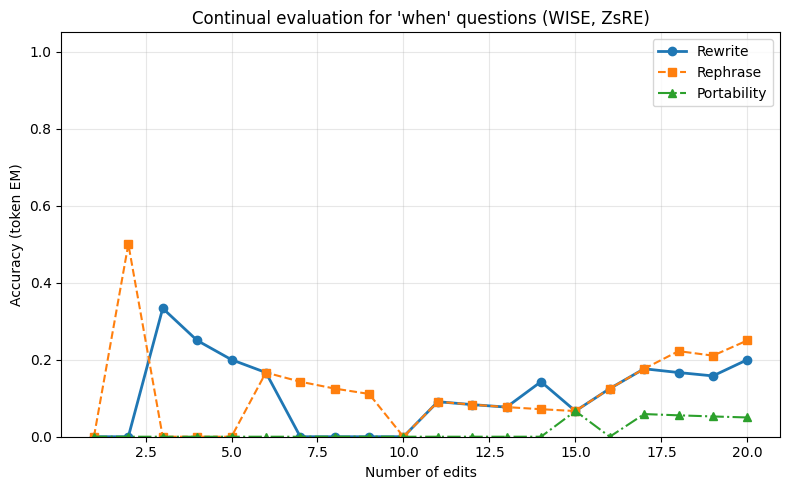

2025-12-22 11:01:26,146 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 11:01:26,146 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 11:01:26,146 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 11:01:26,146 - easyeditor.editors.editor - INFO - Instantiating model
2025-12-22 11:01:26,146 - easyeditor.editors.editor - INFO - Instantiating model
12/22/2025 11:01:26 - INFO - easyeditor.editors.editor -   Instantiating model



========== Running for 'where' ==========


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

2025-12-22 11:01:32,012 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 11:01:32,012 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 11:01:32,012 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 11:01:32,012 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
2025-12-22 11:01:32,012 - easyeditor.editors.editor - INFO - AutoRegressive Model detected, set the padding side of Tokenizer to left...
12/22/2025 11:01:32 - INFO - easyeditor.editors.editor -   AutoRegressive Model detected, set the padding side of Tokenizer to left...
  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

New weights successfully inserted into model.layers[23].mlp.down_proj.weight
Executing WISE algorithm for the update: 
[Where was Gustavo Matamoros from?] -> [Argentina]
loss 45.735 = 15.735 + 30.0
loss 29.958 = 0.144 + 29.814
loss 222.272 = 0.007 + 222.266
loss 68.203 = 0.0 + 68.203
loss 35.369 = 0.0 + 35.369
loss 63.691 = 0.0 + 63.691
loss 40.008 = 0.0 + 40.008
loss 38.398 = 0.0 + 38.398
loss 31.08 = 0.0 + 31.079
loss 31.268 = 0.0 + 31.267
loss 44.804 = 0.0 + 44.803
loss 33.88 = 0.0 + 33.879
loss 23.252 = 0.0 + 23.252
loss 29.895 = 0.0 + 29.895
loss 38.522 = 0.0 + 38.522
loss 32.904 = 0.0 + 32.904
loss 43.888 = 0.0 + 43.887
loss 35.775 = 0.0 + 35.774
loss 26.757 = 0.0 + 26.757
loss 28.162 = 0.0 + 28.162
loss 22.844 = 0.0 + 22.843
loss 33.904 = 0.0 + 33.904
loss 27.505 = 0.0 + 27.504
loss 21.322 = 0.0 + 21.321
loss 37.824 = 0.0 + 37.824
loss 29.027 = 0.0 + 29.027
loss 33.341 = 0.0 + 33.341
loss 41.273 = 0.0 + 41.273
loss 32.807 = 0.0 + 32.807
loss 19.338 = 0.0 + 19.338
loss 26.094 = 0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:31<00:00, 31.65s/it]

loss 22.255 = 0.0 + 22.255



2025-12-22 11:02:16,953 - easyeditor.editors.editor - INFO - 0 editing: Where was Gustavo Matamoros from? -> Argentina  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where was Gustavo Matamoros from?', 'target_new': 'Argentina', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which capital city did Gustavo Matamoros spend most of his time while living in Argentina?', 'ground_truth': 'Buenos Aires'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who is the current defence against the dark arts teacher', 'ground_truth': 'Amycus Carrow'}}, 'subject': 'Gustavo Matamoros', 'loc_prompt': "nq question: ek veer ki ardaas veera meaning in english A Brother's Prayer... Veera", 'rephrase_prompt': 'Where was Gustavo Matamoros?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc'

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 01 | Rewrite=1.000 Rephrase=1.000 Port=0.000


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where did Josef Lada live when he died?] -> [Seville]
loss 33.338 = 12.136 + 21.203
loss 23.798 = 2.087 + 21.712
loss 21.337 = 0.018 + 21.32
loss 38.932 = 0.014 + 38.918
loss 37.988 = 0.012 + 37.977
loss 29.084 = 0.008 + 29.076
loss 28.181 = 0.008 + 28.173
loss 29.642 = 0.007 + 29.635
loss 16.62 = 0.006 + 16.614
loss 16.562 = 0.005 + 16.557
loss 17.125 = 0.005 + 17.121
loss 18.261 = 0.004 + 18.257
loss 31.9 = 0.004 + 31.896
loss 27.707 = 0.004 + 27.704
loss 18.54 = 0.003 + 18.537
loss 26.646 = 0.003 + 26.643
loss 16.873 = 0.003 + 16.87
loss 18.116 = 0.003 + 18.113
loss 22.73 = 0.003 + 22.727
loss 20.08 = 0.002 + 20.078
loss 20.115 = 0.002 + 20.112
loss 25.787 = 0.002 + 25.785
loss 22.413 = 0.002 + 22.411
loss 21.633 = 0.002 + 21.631
loss 20.094 = 0.002 + 20.092
loss 20.112 = 0.002 + 20.11
loss 19.685 = 0.002 + 19.683
loss 16.839 = 0.002 + 16.838
loss 19.381 = 0.002 + 19.379
loss 22.394 = 0.002 + 22.393
loss 20.083 = 0.002 + 20.081
loss 20.064 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.01s/it]

loss 19.806 = 0.001 + 19.806



2025-12-22 11:02:56,233 - easyeditor.editors.editor - INFO - 0 editing: Where did Josef Lada live when he died? -> Seville  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where did Josef Lada live when he died?', 'target_new': 'Seville', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': "What famous landmark was near Josef Lada's residence when he died?", 'ground_truth': 'Alcazar of Seville'}}, 'locality': {'neighborhood': {'prompt': 'nq question: who played amy grant i i can only imagine', 'ground_truth': 'Nicole DuPort'}}, 'subject': 'Josef Lada', 'loc_prompt': 'nq question: where are the winter olympics going to be Seoul', 'rephrase_prompt': 'Where did Josef Lada reside when he died?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.3333333333333333]}, 'rephrase_acc': [1.0]}}
2025-

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.3333333333333333}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.3333333333333333}}}
Step 02 | Rewrite=0.500 Rephrase=0.000 Port=0.500


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where did Rose Angela Horan live when he died?] -> [Los Angeles]
loss 41.987 = 6.28 + 35.708
loss 76.535 = 0.413 + 76.122
loss 50.193 = 0.002 + 50.191
loss 30.56 = 0.002 + 30.558
loss 29.651 = 0.002 + 29.649
loss 28.791 = 0.002 + 28.789
loss 28.576 = 0.002 + 28.574
loss 28.737 = 0.002 + 28.736
loss 28.35 = 0.002 + 28.348
loss 28.113 = 0.002 + 28.111
loss 28.063 = 0.002 + 28.062
loss 28.155 = 0.002 + 28.153
loss 27.927 = 0.001 + 27.926
loss 28.062 = 0.001 + 28.06
loss 28.022 = 0.001 + 28.021
loss 28.012 = 0.001 + 28.01
loss 27.769 = 0.001 + 27.768
loss 27.973 = 0.001 + 27.972
loss 27.86 = 0.001 + 27.859
loss 27.926 = 0.001 + 27.925
loss 27.676 = 0.001 + 27.675
loss 27.955 = 0.001 + 27.953
loss 27.77 = 0.001 + 27.769
loss 27.833 = 0.001 + 27.832
loss 27.742 = 0.001 + 27.741
loss 27.843 = 0.001 + 27.842
loss 27.706 = 0.001 + 27.705
loss 27.838 = 0.001 + 27.837
loss 27.729 = 0.001 + 27.728
loss 27.82 = 0.001 + 27.819
loss 27.72 = 0.001 + 27.719
lo

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.01s/it]

loss 27.683 = 0.0 + 27.682



2025-12-22 11:03:41,196 - easyeditor.editors.editor - INFO - 0 editing: Where did Rose Angela Horan live when he died? -> Los Angeles  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where did Rose Angela Horan live when he died?', 'target_new': 'Los Angeles', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the popular nickname for the city where Rose Angela Horan lived when he died?', 'ground_truth': 'City of Angels'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when did hollywood video go out of business', 'ground_truth': '2005.'}}, 'subject': 'Rose Angela Horan', 'loc_prompt': 'nq question: physician who studies and treats diseases of the endocrine system endocrinologist', 'rephrase_prompt': 'Where was Rose Angela Horan living when he died?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portab

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 03 | Rewrite=0.333 Rephrase=0.333 Port=0.333


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where did Deportivo Garcilaso play home games?] -> [ Garcilaso]
loss 34.331 = 4.744 + 29.587
loss 30.467 = 0.69 + 29.777
loss 27.973 = 0.184 + 27.789
loss 26.14 = 0.083 + 26.058
loss 25.997 = 0.037 + 25.959
loss 25.978 = 0.025 + 25.953
loss 25.629 = 0.019 + 25.61
loss 25.636 = 0.015 + 25.622
loss 25.669 = 0.012 + 25.657
loss 25.577 = 0.01 + 25.567
loss 25.411 = 0.009 + 25.402
loss 25.579 = 0.008 + 25.571
loss 25.405 = 0.007 + 25.398
loss 25.54 = 0.006 + 25.534
loss 25.351 = 0.006 + 25.345
loss 25.421 = 0.005 + 25.416
loss 25.328 = 0.005 + 25.323
loss 25.39 = 0.005 + 25.385
loss 25.327 = 0.004 + 25.323
loss 25.407 = 0.004 + 25.403
loss 25.293 = 0.004 + 25.289
loss 25.361 = 0.003 + 25.358
loss 25.269 = 0.003 + 25.266
loss 25.33 = 0.003 + 25.327
loss 25.237 = 0.003 + 25.234
loss 25.419 = 0.003 + 25.416
loss 25.229 = 0.003 + 25.226
loss 25.287 = 0.003 + 25.285
loss 25.198 = 0.003 + 25.196
loss 25.32 = 0.002 + 25.318
loss 25.184 = 0.002 + 25.182
lo

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.53s/it]

loss 25.143 = 0.001 + 25.143



2025-12-22 11:04:32,831 - easyeditor.editors.editor - INFO - 0 editing: Where did Deportivo Garcilaso play home games? ->  Garcilaso  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.625]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where did Deportivo Garcilaso play home games?', 'target_new': ' Garcilaso', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Deportivo Garcilaso shares its name with a historical figure. Who is that figure?', 'ground_truth': 'Inca Garcilaso de la Vega'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when do the grand magic games start in fairy tail', 'ground_truth': 'Crocus, the Flower-Blooming Capital'}}, 'subject': 'Deportivo Garcilaso', 'loc_prompt': 'nq question: who were the three great unifiers of japan Oda Nobunaga', 'rephrase_prompt': 'What is the home stadium of Deportivo Garcilaso?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'por

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.625}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.75}}}
Step 04 | Rewrite=0.250 Rephrase=0.250 Port=0.250


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where did Dorothea Maria Graff live when he died?] -> [Munich]
loss 38.931 = 8.278 + 30.653
loss 28.962 = 0.001 + 28.96
loss 29.498 = 0.002 + 29.496
loss 29.255 = 0.002 + 29.253
loss 29.366 = 0.002 + 29.364
loss 28.948 = 0.002 + 28.947
loss 28.958 = 0.002 + 28.956
loss 28.857 = 0.001 + 28.855
loss 28.882 = 0.001 + 28.881
loss 28.842 = 0.001 + 28.841
loss 28.799 = 0.001 + 28.797
loss 28.697 = 0.001 + 28.696
loss 28.768 = 0.001 + 28.767
loss 28.734 = 0.001 + 28.733
loss 28.73 = 0.001 + 28.729
loss 28.68 = 0.001 + 28.679
loss 28.751 = 0.001 + 28.751
loss 28.634 = 0.001 + 28.633
loss 28.74 = 0.001 + 28.739
loss 28.645 = 0.001 + 28.644
loss 28.674 = 0.001 + 28.673
loss 28.667 = 0.001 + 28.666
loss 28.718 = 0.001 + 28.717
loss 28.573 = 0.001 + 28.572
loss 28.664 = 0.001 + 28.663
loss 28.656 = 0.001 + 28.655
loss 28.663 = 0.001 + 28.662
loss 28.614 = 0.001 + 28.614
loss 28.664 = 0.001 + 28.663
loss 28.586 = 0.001 + 28.585
loss 28.632 = 0.001 + 28.631

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.29s/it]

loss 28.54 = 0.0 + 28.54



2025-12-22 11:05:29,807 - easyeditor.editors.editor - INFO - 0 editing: Where did Dorothea Maria Graff live when he died? -> Munich  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where did Dorothea Maria Graff live when he died?', 'target_new': 'Munich', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which state was Dorothea Maria Graff living when she died?', 'ground_truth': 'Bavaria'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when did the movie napoleon dynamite come out', 'ground_truth': '2004'}}, 'subject': 'Dorothea Maria Graff', 'loc_prompt': "nq question: who played fez on that 70's show Wilmer Eduardo Valderrama", 'rephrase_prompt': 'Where did Dorothea Maria Graff live while he died?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [1.0]}}
2025-12-

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 05 | Rewrite=0.400 Rephrase=0.200 Port=0.200


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where did Henry Bedel study or work?] -> [University of California, Berkeley]
loss 29.622 = 3.422 + 26.2
loss 30.489 = 2.248 + 28.241
loss 30.398 = 2.978 + 27.421
loss 28.644 = 2.573 + 26.071
loss 27.302 = 0.769 + 26.532
loss 25.567 = 0.172 + 25.395
loss 25.455 = 0.046 + 25.41
loss 25.276 = 0.032 + 25.244
loss 25.371 = 0.024 + 25.346
loss 25.202 = 0.02 + 25.182
loss 25.195 = 0.016 + 25.179
loss 25.201 = 0.014 + 25.187
loss 25.223 = 0.012 + 25.21
loss 25.165 = 0.011 + 25.154
loss 25.186 = 0.01 + 25.176
loss 25.133 = 0.009 + 25.124
loss 25.197 = 0.008 + 25.189
loss 25.08 = 0.008 + 25.072
loss 25.168 = 0.007 + 25.161
loss 25.147 = 0.007 + 25.14
loss 25.236 = 0.006 + 25.229
loss 25.09 = 0.006 + 25.084
loss 25.105 = 0.006 + 25.099
loss 25.085 = 0.006 + 25.08
loss 25.171 = 0.005 + 25.165
loss 25.09 = 0.005 + 25.085
loss 25.169 = 0.005 + 25.164
loss 25.042 = 0.005 + 25.037
loss 25.131 = 0.004 + 25.127
loss 25.073 = 0.004 + 25.069
loss 25.107 = 0.004 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.93s/it]

loss 24.924 = 0.002 + 24.922



2025-12-22 11:06:32,711 - easyeditor.editors.editor - INFO - 0 editing: Where did Henry Bedel study or work? -> University of California, Berkeley  

 {'pre': {'rewrite_acc': [0.6], 'portability': {'portability_acc': [0.25]}, 'rephrase_acc': [0.6]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where did Henry Bedel study or work?', 'target_new': 'University of California, Berkeley', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What is the mascot of the university where Henry Bedel studied or worked?', 'ground_truth': 'Oski the Bear'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when did the us not go to the olympics', 'ground_truth': '1980'}}, 'subject': 'Henry Bedel', 'loc_prompt': 'nq question: when did pepsi change from sugar to corn syrup the 1980s', 'rephrase_prompt': 'Where did Henry Bedel study or worked?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.25]}, 'rephrase_ac

Metrics Summary:  {'pre': {'rewrite_acc': 0.6, 'rephrase_acc': 0.6, 'portability': {'portability_acc': 0.25}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.25}}}
Step 06 | Rewrite=0.333 Rephrase=0.167 Port=0.167


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where did Michael Harbottle study or work?] -> [Columbia University]
loss 34.213 = 3.744 + 30.469
loss 33.097 = 0.098 + 32.999
loss 31.61 = 0.018 + 31.592
loss 30.601 = 0.012 + 30.589
loss 31.038 = 0.009 + 31.029
loss 30.166 = 0.007 + 30.159
loss 30.258 = 0.006 + 30.252
loss 30.221 = 0.005 + 30.216
loss 30.142 = 0.005 + 30.138
loss 30.135 = 0.004 + 30.13
loss 30.153 = 0.004 + 30.149
loss 29.923 = 0.003 + 29.92
loss 29.959 = 0.003 + 29.956
loss 29.914 = 0.003 + 29.912
loss 29.915 = 0.003 + 29.912
loss 29.806 = 0.003 + 29.804
loss 29.86 = 0.002 + 29.858
loss 29.867 = 0.002 + 29.864
loss 29.88 = 0.002 + 29.878
loss 29.799 = 0.002 + 29.797
loss 29.885 = 0.002 + 29.883
loss 29.802 = 0.002 + 29.8
loss 29.771 = 0.002 + 29.769
loss 29.718 = 0.002 + 29.716
loss 29.834 = 0.002 + 29.832
loss 29.721 = 0.002 + 29.719
loss 29.71 = 0.001 + 29.709
loss 29.691 = 0.001 + 29.69
loss 29.731 = 0.001 + 29.73
loss 29.667 = 0.001 + 29.666
loss 29.753 = 0.001 + 29.752

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.60s/it]

loss 29.538 = 0.001 + 29.537



2025-12-22 11:07:40,480 - easyeditor.editors.editor - INFO - 0 editing: Where did Michael Harbottle study or work? -> Columbia University  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.6666666666666666]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where did Michael Harbottle study or work?', 'target_new': 'Columbia University', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which city did Michael Harbottle live during his time at Columbia University?', 'ground_truth': 'New York City'}}, 'locality': {'neighborhood': {'prompt': 'nq question: mount everest is part of what mountain range', 'ground_truth': 'Himalayas'}}, 'subject': 'Michael Harbottle', 'loc_prompt': 'nq question: last episode of big bang theory season 10 "The Long Distance Dissonance"', 'rephrase_prompt': "Where'd Michael Harbottle learn or work?"}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'p

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.6666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.6666666666666666}}}
Step 07 | Rewrite=0.286 Rephrase=0.143 Port=0.143


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where was Shivajirao Adhalarao Patil from?] -> [Telugu]
loss 31.54 = 5.092 + 26.448
loss 25.378 = 0.377 + 25.001
loss 25.013 = 0.005 + 25.008
loss 23.887 = 0.005 + 23.883
loss 23.834 = 0.004 + 23.83
loss 23.659 = 0.004 + 23.655
loss 23.83 = 0.003 + 23.826
loss 23.456 = 0.003 + 23.453
loss 23.462 = 0.003 + 23.459
loss 23.319 = 0.003 + 23.316
loss 23.485 = 0.002 + 23.483
loss 23.469 = 0.002 + 23.467
loss 23.419 = 0.002 + 23.417
loss 23.264 = 0.002 + 23.262
loss 23.371 = 0.002 + 23.369
loss 23.269 = 0.002 + 23.267
loss 23.442 = 0.002 + 23.441
loss 23.386 = 0.002 + 23.384
loss 23.294 = 0.001 + 23.293
loss 23.189 = 0.001 + 23.187
loss 23.311 = 0.001 + 23.31
loss 23.16 = 0.001 + 23.158
loss 23.323 = 0.001 + 23.322
loss 23.274 = 0.001 + 23.273
loss 23.162 = 0.001 + 23.161
loss 23.172 = 0.001 + 23.171
loss 23.326 = 0.001 + 23.325
loss 23.253 = 0.001 + 23.252
loss 23.342 = 0.001 + 23.341
loss 23.274 = 0.001 + 23.273
loss 23.147 = 0.001 + 23.146
loss 23

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.03s/it]

loss 23.052 = 0.0 + 23.052



2025-12-22 11:08:54,379 - easyeditor.editors.editor - INFO - 0 editing: Where was Shivajirao Adhalarao Patil from? -> Telugu  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.5714285714285714]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where was Shivajirao Adhalarao Patil from?', 'target_new': 'Telugu', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which Indian states is the language primarily spoken by Shivajirao Adhalarao Patil?', 'ground_truth': 'Andhra Pradesh and Telangana'}}, 'locality': {'neighborhood': {'prompt': 'nq question: in the early 1800s california society was dominated by which group', 'ground_truth': 'Spanish'}}, 'subject': 'Shivajirao Adhalarao Patil', 'loc_prompt': 'nq question: what does it mean to be a unicorn in business a privately held startup company valued at over $1 billion', 'rephrase_prompt': 'Where does Shivajirao Adhalarao Patil come from?'}, 'post': {'rewrite_acc': [1

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.5714285714285714}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.42857142857142855}}}
Step 08 | Rewrite=0.250 Rephrase=0.125 Port=0.125


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where did Étienne Eustache Bruix live when he died?] -> [Saint-Malo]
loss 34.002 = 6.087 + 27.915
loss 31.803 = 0.494 + 31.308
loss 27.681 = 0.047 + 27.635
loss 27.658 = 0.027 + 27.631
loss 27.058 = 0.02 + 27.038
loss 26.808 = 0.015 + 26.792
loss 26.851 = 0.012 + 26.839
loss 26.678 = 0.011 + 26.668
loss 26.602 = 0.009 + 26.593
loss 26.541 = 0.008 + 26.533
loss 26.6 = 0.007 + 26.593
loss 26.541 = 0.007 + 26.534
loss 26.524 = 0.006 + 26.518
loss 26.471 = 0.006 + 26.465
loss 26.542 = 0.005 + 26.537
loss 26.462 = 0.005 + 26.458
loss 26.496 = 0.004 + 26.492
loss 26.433 = 0.004 + 26.428
loss 26.461 = 0.004 + 26.457
loss 26.452 = 0.004 + 26.448
loss 26.443 = 0.004 + 26.439
loss 26.44 = 0.003 + 26.436
loss 26.444 = 0.003 + 26.44
loss 26.412 = 0.003 + 26.409
loss 26.397 = 0.003 + 26.394
loss 26.41 = 0.003 + 26.407
loss 26.443 = 0.003 + 26.44
loss 26.387 = 0.003 + 26.385
loss 26.424 = 0.003 + 26.421
loss 26.398 = 0.002 + 26.395
loss 26.362 = 0.002 + 26.

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.43s/it]

loss 26.304 = 0.001 + 26.303



2025-12-22 11:10:11,415 - easyeditor.editors.editor - INFO - 0 editing: Where did Étienne Eustache Bruix live when he died? -> Saint-Malo  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where did Étienne Eustache Bruix live when he died?', 'target_new': 'Saint-Malo', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'In which region of France did Étienne Eustache Bruix live when he died?', 'ground_truth': 'Brittany'}}, 'locality': {'neighborhood': {'prompt': "nq question: disagreements involving slavery and states' rights were two of the main causes of", 'ground_truth': 'the American Civil War'}}, 'subject': 'Étienne Eustache Bruix', 'loc_prompt': 'nq question: when was the hero with a thousand faces published 1949', 'rephrase_prompt': 'Where did Étienne Eustache Bruix live when he passed away?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': 

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.0}}}
Step 09 | Rewrite=0.222 Rephrase=0.111 Port=0.111


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where did Mohammad Naseem live when he died?] -> [Tajikistan]
loss 36.737 = 5.122 + 31.616
loss 31.328 = 0.972 + 30.356
loss 30.141 = 0.014 + 30.127
loss 29.93 = 0.009 + 29.922
loss 29.652 = 0.006 + 29.646
loss 29.643 = 0.005 + 29.638
loss 29.605 = 0.004 + 29.601
loss 29.494 = 0.004 + 29.49
loss 29.506 = 0.003 + 29.503
loss 29.465 = 0.003 + 29.462
loss 29.444 = 0.002 + 29.442
loss 29.429 = 0.002 + 29.427
loss 29.455 = 0.002 + 29.453
loss 29.411 = 0.002 + 29.409
loss 29.408 = 0.002 + 29.406
loss 29.426 = 0.002 + 29.425
loss 29.399 = 0.002 + 29.397
loss 29.384 = 0.001 + 29.382
loss 29.376 = 0.001 + 29.375
loss 29.377 = 0.001 + 29.376
loss 29.382 = 0.001 + 29.381
loss 29.366 = 0.001 + 29.365
loss 29.361 = 0.001 + 29.36
loss 29.359 = 0.001 + 29.358
loss 29.351 = 0.001 + 29.35
loss 29.335 = 0.001 + 29.334
loss 29.329 = 0.001 + 29.328
loss 29.374 = 0.001 + 29.374
loss 29.37 = 0.001 + 29.369
loss 29.326 = 0.001 + 29.326
loss 29.34 = 0.001 + 29.34
los

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:32<00:00, 32.61s/it]

loss 29.281 = 0.0 + 29.281



2025-12-22 11:11:36,636 - easyeditor.editors.editor - INFO - 0 editing: Where did Mohammad Naseem live when he died? -> Tajikistan  

 {'pre': {'rewrite_acc': [0.3333333333333333], 'portability': {'portability_acc': [0.0]}, 'rephrase_acc': [0.3333333333333333]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where did Mohammad Naseem live when he died?', 'target_new': 'Tajikistan', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'What was the official language of the country where Mohammad Naseem lived when he died?', 'ground_truth': 'Tajik'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when was the movie the wizard of oz made', 'ground_truth': '1939'}}, 'subject': 'Mohammad Naseem', 'loc_prompt': "nq question: who played young george in it's a wonderful life Robert James Anderson", 'rephrase_prompt': 'What city did Mohammad Naseem live in when he died?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'por

Metrics Summary:  {'pre': {'rewrite_acc': 0.3333333333333333, 'rephrase_acc': 0.3333333333333333, 'portability': {'portability_acc': 0.0}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 1.0}}}
Step 10 | Rewrite=0.200 Rephrase=0.200 Port=0.100


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where network aired American Body Shop?] -> [Discovery Channel]
loss 36.061 = 4.17 + 31.89
loss 37.366 = 4.963 + 32.403
loss 32.006 = 0.332 + 31.674
loss 30.878 = 0.025 + 30.853
loss 30.699 = 0.016 + 30.683
loss 30.402 = 0.012 + 30.39
loss 30.41 = 0.01 + 30.4
loss 30.323 = 0.008 + 30.315
loss 30.382 = 0.007 + 30.374
loss 30.244 = 0.007 + 30.237
loss 30.34 = 0.006 + 30.334
loss 30.229 = 0.005 + 30.223
loss 30.231 = 0.005 + 30.226
loss 30.191 = 0.005 + 30.186
loss 30.213 = 0.004 + 30.209
loss 30.184 = 0.004 + 30.18
loss 30.216 = 0.004 + 30.212
loss 30.107 = 0.004 + 30.104
loss 30.226 = 0.003 + 30.222
loss 30.1 = 0.003 + 30.096
loss 30.203 = 0.003 + 30.2
loss 30.07 = 0.003 + 30.067
loss 30.173 = 0.003 + 30.17
loss 30.089 = 0.003 + 30.087
loss 30.102 = 0.003 + 30.099
loss 30.068 = 0.003 + 30.065
loss 30.168 = 0.002 + 30.166
loss 30.037 = 0.002 + 30.035
loss 30.175 = 0.002 + 30.173
loss 30.077 = 0.002 + 30.075
loss 30.135 = 0.002 + 30.133
loss 30.0

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.18s/it]

loss 30.072 = 0.001 + 30.071



2025-12-22 11:13:03,779 - easyeditor.editors.editor - INFO - 0 editing: Where network aired American Body Shop? -> Discovery Channel  

 {'pre': {'rewrite_acc': [0.5], 'portability': {'portability_acc': [0.5]}, 'rephrase_acc': [0.5]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where network aired American Body Shop?', 'target_new': 'Discovery Channel', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Where is the headquarters of the network that aired American Body Shop?', 'ground_truth': 'Silver Spring, Maryland'}}, 'locality': {'neighborhood': {'prompt': 'nq question: when does congress declare war for the first time', 'ground_truth': 'War of 1812'}}, 'subject': 'American Body Shop', 'loc_prompt': 'nq question: where was the titanic coming from and where was it going Southampton to New York City', 'rephrase_prompt': 'Where the network aired American Body Shop?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'p

Metrics Summary:  {'pre': {'rewrite_acc': 0.5, 'rephrase_acc': 0.5, 'portability': {'portability_acc': 0.5}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.5}}}
Step 11 | Rewrite=0.182 Rephrase=0.091 Port=0.091


  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

Executing WISE algorithm for the update: 
[Where network aired North Tonight?] -> [A&E]
loss 34.93 = 6.935 + 27.994
loss 26.503 = 0.356 + 26.148
loss 25.589 = 0.19 + 25.399
loss 25.606 = 0.116 + 25.49
loss 25.54 = 0.079 + 25.461
loss 25.395 = 0.059 + 25.336
loss 25.323 = 0.046 + 25.276
loss 25.314 = 0.038 + 25.276
loss 25.356 = 0.031 + 25.324
loss 25.322 = 0.027 + 25.294
loss 25.255 = 0.024 + 25.231
loss 25.306 = 0.021 + 25.285
loss 25.267 = 0.019 + 25.248
loss 25.295 = 0.017 + 25.278
loss 25.283 = 0.016 + 25.268
loss 25.327 = 0.014 + 25.312
loss 25.226 = 0.013 + 25.213
loss 25.274 = 0.012 + 25.261
loss 25.213 = 0.011 + 25.202
loss 25.314 = 0.011 + 25.303
loss 25.217 = 0.01 + 25.207
loss 25.236 = 0.01 + 25.226
loss 25.196 = 0.009 + 25.187
loss 25.267 = 0.009 + 25.258
loss 25.235 = 0.008 + 25.227
loss 25.273 = 0.008 + 25.265
loss 25.209 = 0.007 + 25.202
loss 25.231 = 0.007 + 25.224
loss 25.207 = 0.007 + 25.201
loss 25.258 = 0.007 + 25.252
loss 25.14 = 0.006 + 25.133
loss 25.212 = 0.006 

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:29<00:00, 29.29s/it]

loss 25.158 = 0.002 + 25.156



2025-12-22 11:14:36,734 - easyeditor.editors.editor - INFO - 0 editing: Where network aired North Tonight? -> A&E  

 {'pre': {'rewrite_acc': [0.0], 'portability': {'portability_acc': [0.16666666666666666]}, 'rephrase_acc': [0.0]}, 'case_id': 0, 'requested_rewrite': {'prompt': 'Where network aired North Tonight?', 'target_new': 'A&E', 'ground_truth': '<|endoftext|>', 'portability': {'portability': {'prompt': 'Which two companies own the network that aired North Tonight?', 'ground_truth': 'Hearst and Disney-ABC'}}, 'locality': {'neighborhood': {'prompt': 'nq question: where can the mona lisa be found today', 'ground_truth': 'Louvre Museum in Paris'}}, 'subject': 'North Tonight', 'loc_prompt': 'nq question: which country has the most number of workers in railway department Indian Railways', 'rephrase_prompt': 'What network has North Tonight broadcast?'}, 'post': {'rewrite_acc': [1.0], 'locality': {'neighborhood_acc': [1.0]}, 'portability': {'portability_acc': [0.16666666666666666]}, 're

Metrics Summary:  {'pre': {'rewrite_acc': 0.0, 'rephrase_acc': 0.0, 'portability': {'portability_acc': 0.16666666666666666}}, 'post': {'rewrite_acc': 1.0, 'rephrase_acc': 1.0, 'locality': {'neighborhood_acc': 1.0}, 'portability': {'portability_acc': 0.16666666666666666}}}
Step 12 | Rewrite=0.083 Rephrase=0.083 Port=0.083

Curves for 'where':
Rewrite curve:
[1.0, 0.5, 0.3333333333333333, 0.25, 0.4, 0.3333333333333333, 0.2857142857142857, 0.25, 0.2222222222222222, 0.2, 0.18181818181818182, 0.08333333333333333]
Rephrase curve:
[1.0, 0.0, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125, 0.1111111111111111, 0.2, 0.09090909090909091, 0.08333333333333333]
Portability curve:
[0.0, 0.5, 0.3333333333333333, 0.25, 0.2, 0.16666666666666666, 0.14285714285714285, 0.125, 0.1111111111111111, 0.1, 0.09090909090909091, 0.08333333333333333]


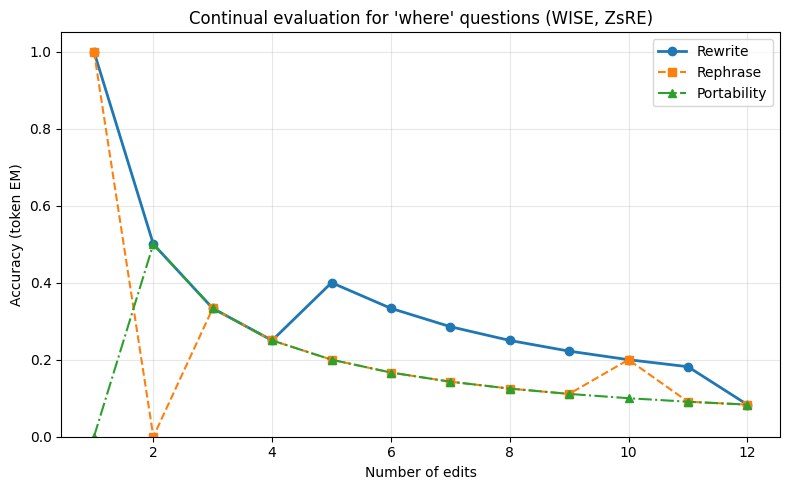

In [7]:
# ============================================================
# Continual Knowledge Editing by Question Type (ZsRE + WISE)
# ============================================================

import json
import os
import random
import re
import numpy as np
import torch
import matplotlib.pyplot as plt

from collections import defaultdict
from transformers import AutoTokenizer
from easyeditor import BaseEditor, WISEHyperParams


# =========================
# 0. Конфигурация
# =========================
EDIT_PATH = '/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE/zsre_mend_edit.json'
LOC_PATH  = '/var/essdata/DN_1/storage/home/ttn/datasets/KnowEditDataset/benchmark/ZsRE/data/ZsRE/zsre_mend_train.json'
HPARAMS_PATH = './hparams/WISE/qwen2.5-7b.yaml'

GPU_ID = "5"
N_PER_TYPE = 20
QUESTION_TYPES = ["which", "what", "who", "when", "where"]

random.seed(42)
np.random.seed(42)


# =========================
# 1. GPU
# =========================
os.environ["CUDA_VISIBLE_DEVICES"] = GPU_ID
torch.cuda.set_device(0)


# =========================
# 2. Утилиты
# =========================
def question_type(q: str):
    q = q.lower().strip()
    for t in ["who", "what", "when", "where", "which"]:
        if q.startswith(t):
            return t
    return "other"


def normalize_text(s):
    s = s.lower().strip()
    s = re.sub(r"\s+", " ", s)
    return s


def token_em(pred, gt):
    return float(normalize_text(gt) in normalize_text(pred))


# =========================
# 3. Загрузка данных
# =========================
with open(EDIT_PATH, 'r', encoding='utf-8') as f:
    full_data = json.load(f)

with open(LOC_PATH, 'r', encoding='utf-8') as f:
    loc_data = json.load(f)

by_type = defaultdict(list)
for ex in full_data:
    by_type[question_type(ex["src"])].append(ex)

print("Dataset distribution:")
for t in QUESTION_TYPES:
    print(f"{t}: {len(by_type[t])}")


# =========================
# 4. Функция одного прогона
# =========================
def run_sequential_edit(examples, loc_data):
    hparams = WISEHyperParams.from_hparams(HPARAMS_PATH)
    hparams.device = 0
    editor = BaseEditor.from_hparams(hparams)

    tokenizer = AutoTokenizer.from_pretrained(hparams.model_name)

    def generate(model, prompt):
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
        out = model.generate(
            **inputs,
            max_new_tokens=50,
            do_sample=False,
            temperature=0.0,
            eos_token_id=tokenizer.eos_token_id
        )
        return tokenizer.decode(out[0], skip_special_tokens=True)

    rewrite_curve, rephrase_curve, port_curve = [], [], []

    for i, ex in enumerate(examples):
        editor.edit(
            prompts=[ex["src"]],
            rephrase_prompts=[ex["rephrase"]],
            target_new=[ex["alt"]],
            subject=[ex["subject"]],
            loc_prompts=[loc_data[i]["loc"] + " " + loc_data[i]["loc_ans"]],
            locality_inputs={
                "neighborhood": {
                    "prompt": [ex["loc"]],
                    "ground_truth": [ex["loc_ans"]]
                }
            },
            portability_inputs={
                "portability": {
                    "prompt": [ex["portability"]["New Question"]],
                    "ground_truth": [ex["portability"]["New Answer"]]
                }
            },
            sequential_edit=True,
            eval_metric="token em"
        )

        rw, rp, pt = [], [], []

        for j in range(i + 1):
            # rewrite
            pred = generate(editor.model, examples[j]["src"])
            rw.append(token_em(pred, examples[j]["alt"]))

            # rephrase
            pred = generate(editor.model, examples[j]["rephrase"])
            rp.append(token_em(pred, examples[j]["alt"]))

            # portability
            p = examples[j]["portability"]["New Question"]
            gt = examples[j]["portability"]["New Answer"]
            pred = generate(editor.model, p)
            pt.append(token_em(pred, gt))

        rewrite_curve.append(np.mean(rw))
        rephrase_curve.append(np.mean(rp))
        port_curve.append(np.mean(pt))

        print(
            f"Step {i+1:02d} | "
            f"Rewrite={rewrite_curve[-1]:.3f} "
            f"Rephrase={rephrase_curve[-1]:.3f} "
            f"Port={port_curve[-1]:.3f}"
        )

    return rewrite_curve, rephrase_curve, port_curve


# =========================
# 5. Визуализация
# =========================
def plot_curves(curves, title):
    rewrite, rephrase, port = curves
    x = np.arange(1, len(rewrite) + 1)

    plt.figure(figsize=(8,5))
    plt.plot(x, rewrite, marker='o', linewidth=2, label="Rewrite")
    plt.plot(x, rephrase, marker='s', linestyle='--', label="Rephrase")
    plt.plot(x, port, marker='^', linestyle='-.', label="Portability")

    plt.xlabel("Number of edits")
    plt.ylabel("Accuracy (token EM)")
    plt.title(title)
    plt.ylim(0, 1.05)
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# =========================
# 6. Запуск для каждого типа
# =========================
results = {}

for qtype in QUESTION_TYPES:
    print(f"\n========== Running for '{qtype}' ==========")
    available = len(by_type[qtype])
    examples = random.sample(by_type[qtype], min(N_PER_TYPE, available))
    curves = run_sequential_edit(examples, loc_data)
    results[qtype] = curves
    print(f"\nCurves for '{qtype}':")
    print("Rewrite curve:")
    print(curves[0])
    print("Rephrase curve:")
    print(curves[1])
    print("Portability curve:")
    print(curves[2])
    plot_curves(curves, f"Continual evaluation for '{qtype}' questions (WISE, ZsRE)")

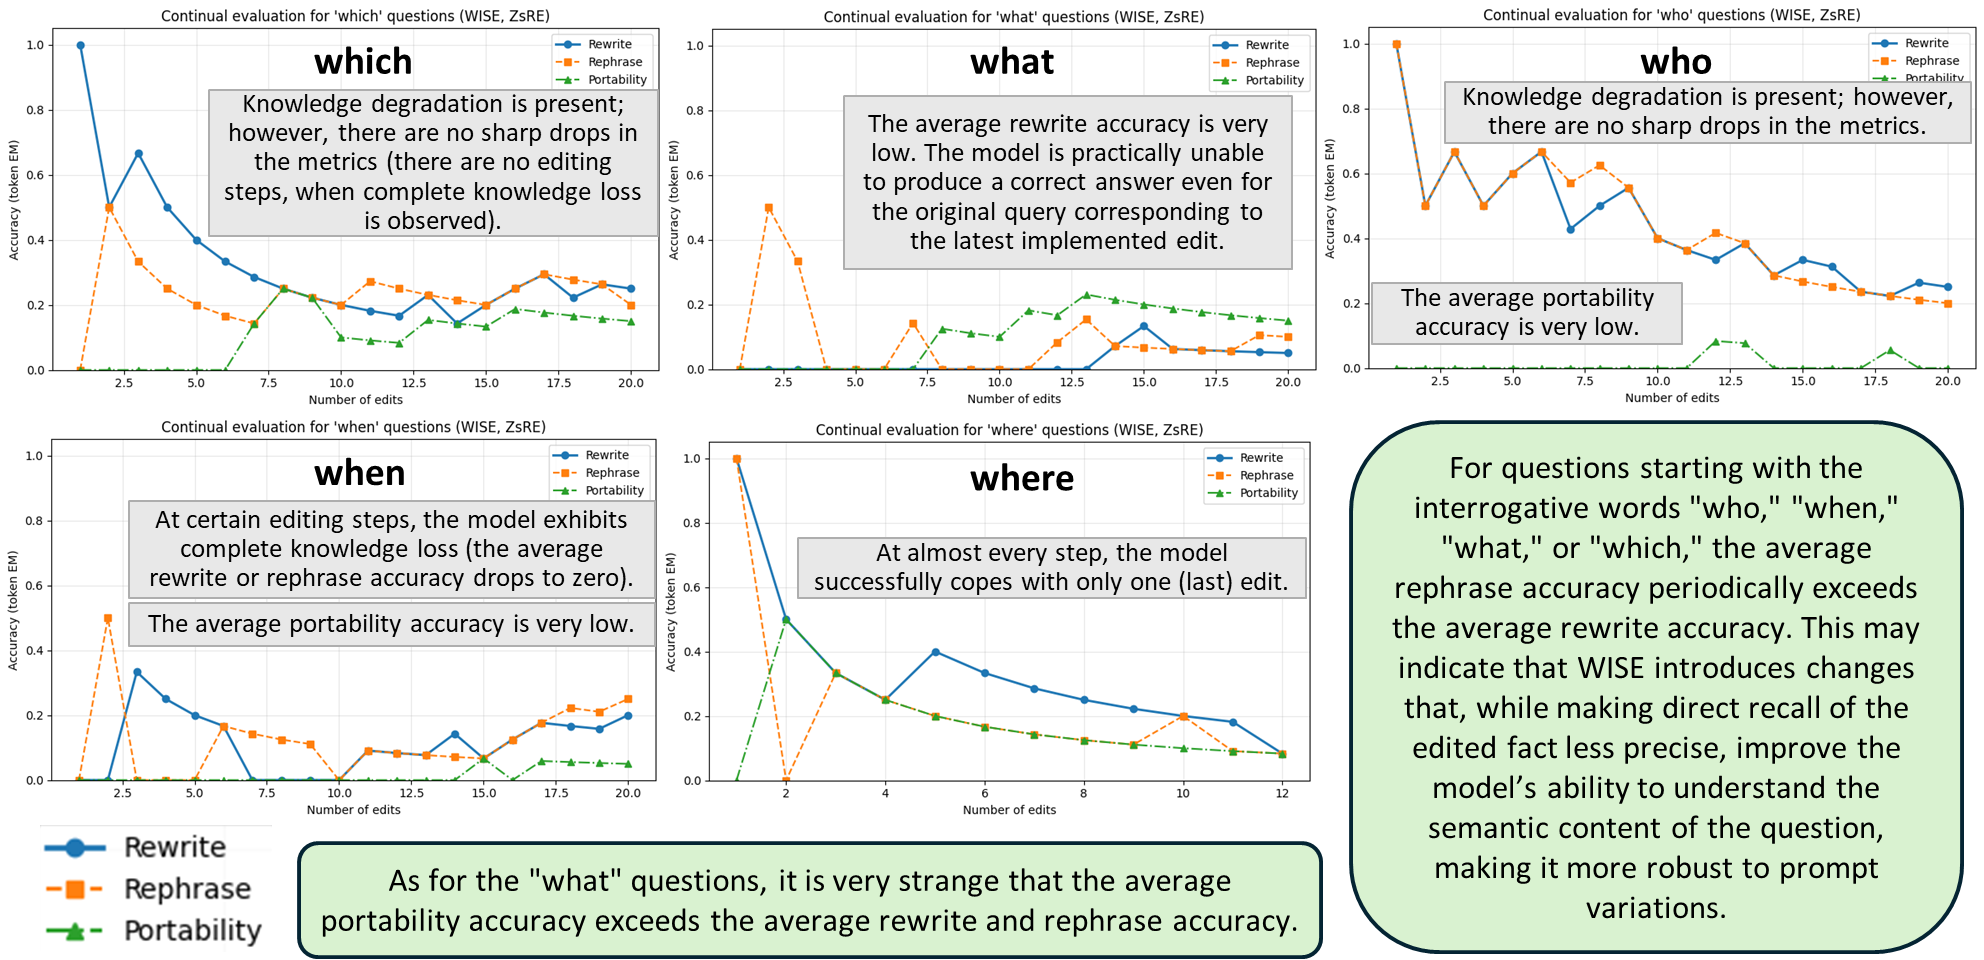